In [ ]:
#Global reconstruction of small (POC) and large (GOC) particulate organic carbon concentration using
#11 driver sets and 2 ML methods - Random Froest and XGBoost
#at the end we test Neural Network

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, RMSprop
import tensorflow.keras.callbacks
import numpy as np
import scipy.io
from scipy import stats
from scipy.signal import *
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from datetime import date
import dataframe_image as dfi

In [ ]:
def incident_light(df):
    convert_dict = {'year': int, 'month': int}
    df = df.astype(convert_dict)

    df['day_numb'] = 15

    for i in df.index.to_numpy():
        delta = date(df['year'][i],df['month'][i],15) - date(df['year'][i],1,1)
        df['day_numb'][i] = delta.days + 1
    
    convert_dict = {'day_numb': float}
    df = df.astype(convert_dict)

    df["psi"] = np.nan

    for i in df.index.to_numpy():
        if df['year'][i] != 2012:
            df.loc[df.index == i,'psi'] = np.pi*(df['day_numb'][i] * 360./365.)/180.
        else:
            df.loc[df.index == i,'psi'] = np.pi*(df['day_numb'][i] * 360./366.)/180.

    df['diclination'] = 0.39637 - 22.9133*np.cos(df['psi'])+4.02543*np.sin(df['psi'])-0.3872*np.cos(2.*df['psi'])+0.052*np.sin(2.*df['psi'])
    df['inc_light'] = np.sin(df['diclination'])*np.sin(df['lat_Pl']*np.pi/180.)-np.cos(df['lat_Pl']*np.pi/180.)*np.cos(df['diclination'])*np.cos(12.*360./24. * np.pi/180.)

    return df

In [ ]:
def incident_light_PlankTOM(df):
    convert_dict = {'year': int, 'month': int}
    df = df.astype(convert_dict)

    df['day_numb'] = 15

    for i in df.index.to_numpy():
        delta = date(2009,df['month'][i],15) - date(2009,1,1)
        df['day_numb'][i] = delta.days + 1  
    
    convert_dict = {'day_numb': float}
    df = df.astype(convert_dict)

    df['psi'] = np.pi*(df['day_numb'] * 360./365.)/180.

    df['diclination'] = 0.39637 - 22.9133*np.cos(df['psi'])+4.02543*np.sin(df['psi'])-0.3872*np.cos(2.*df['psi'])+0.052*np.sin(2.*df['psi'])

    df['inc_light'] = np.sin(df['diclination'])*np.sin(df['lat_Pl']*np.pi/180.)-np.cos(df['lat_Pl']*np.pi/180.)*np.cos(df['diclination'])*np.cos(12.*360./24. * np.pi/180.)
    
    return df

In [ ]:
def Driver_Sets(df):
    Target_POC = df['POC']
    Target_GOC = df['GOC']

    Driver_NoPFT = df[['depth','Temp','CHL','MLD','NO3','PO4']]

    Driver_PhZMLD = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                        'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                        'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean']]

    Driver_PhZBACMLD = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','MES','PTE','DIA_mean','COC_mean',\
                           'PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean','MES_mean',\
                           'PTE_mean','GEL_mean','PRO_mean','MAC_mean']]

    Driver_PhZMLD_latlon = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                               'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                               'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','sin_lat','sin_lon','cos_lon']]

    Driver_PhZMLD_day = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                            'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                            'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','inc_light']]

    Driver_PhZMLD_only = df[['depth','BAC','MES','PTE','DIA_mean','COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC',\
                             'MIX_mean','FIX_mean','BAC_mean','MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean']]

    Driver_PhZMLD_back2 = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                              'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                              'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','GEL_back','PRO_back']]

    Driver_PhZMLD_back3 = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                              'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                              'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','CHL_back']]

    Driver_PhZMLD_CHL = df[['depth','Temp','CHL','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean','COC_mean',\
                            'PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean','MES_mean',\
                            'PTE_mean','GEL_mean','PRO_mean','MAC_mean']]

    Driver_PhZMLD_PO4 = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4','BAC','MES','PTE','DIA_mean','COC_mean',\
                            'PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean','MES_mean',\
                            'PTE_mean','GEL_mean','PRO_mean','MAC_mean']]

    Driver_PhZMLD_back1 = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                              'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                              'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','GEL_back','CHL_back_mean',\
                              'PRO_back','MAC_back','COC_back_mean']]
    
    return Target_POC, Target_GOC, Driver_NoPFT, Driver_PhZMLD, Driver_PhZBACMLD, Driver_PhZMLD_latlon,\
           Driver_PhZMLD_day, Driver_PhZMLD_only, Driver_PhZMLD_back2, Driver_PhZMLD_back3, Driver_PhZMLD_CHL,\
           Driver_PhZMLD_PO4, Driver_PhZMLD_back1



In [ ]:
Test_names = ['_PhZMLD_NO3','_PhZMLD_chim']


In [ ]:
def Driver_Sets_POC(df):
    Target_POC = df['POC']
    Target_GOC = df['GOC']

    Driver_NoPFT = df[['depth','Temp','CHL','MLD','NO3','PO4']]

    Driver_PhZMLD = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                        'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                        'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean']]
    Driver_PhZMLD_CHL = df[['depth','Temp','CHL','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean','COC_mean',\
                            'PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean','MES_mean',\
                            'PTE_mean','GEL_mean','PRO_mean','MAC_mean']]
    Driver_PhZMLD_NO3 = df[['depth','Temp','CHL_mean','MLD','NO3','PO4_mean','BAC','MES','PTE','DIA_mean','COC_mean',\
                            'PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean','MES_mean',\
                            'PTE_mean','GEL_mean','PRO_mean','MAC_mean']]
    Driver_PhZMLD_PO4 = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4','BAC','MES','PTE','DIA_mean','COC_mean',\
                            'PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean','MES_mean',\
                            'PTE_mean','GEL_mean','PRO_mean','MAC_mean']]
    Driver_PhZMLD_chim = df[['depth','Temp','CHL','MLD','NO3','PO4','BAC','MES','PTE','DIA_mean','COC_mean',\
                             'PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean','MES_mean',\
                             'PTE_mean','GEL_mean','PRO_mean','MAC_mean']]
    Driver_PhZMLD_latlon = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                               'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                               'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','sin_lat','sin_lon','cos_lon']]

    Driver_PhZMLD_day = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                            'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                            'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','inc_light']]
    Driver_PhZMLD_back1 = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                              'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                              'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','GEL_back','CHL_back_mean',\
                              'PRO_back','MAC_back','COC_back_mean']]
    Driver_PhZMLD_back2 = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                              'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                              'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','GEL_back','PRO_back']]

    Driver_PhZMLD_back3 = df[['depth','Temp','CHL_mean','MLD','NO3_mean','PO4_mean','BAC','MES','PTE','DIA_mean',\
                              'COC_mean','PIC_mean','PHA_mean','GEL','PRO','MAC','MIX_mean','FIX_mean','BAC_mean',\
                              'MES_mean','PTE_mean','GEL_mean','PRO_mean','MAC_mean','CHL_back']]
    
    return Target_POC, Target_GOC, Driver_NoPFT, Driver_PhZMLD, Driver_PhZMLD_CHL, Driver_PhZMLD_NO3, Driver_PhZMLD_PO4,\
           Driver_PhZMLD_latlon,Driver_PhZMLD_day, Driver_PhZMLD_only, Driver_PhZMLD_back1, Driver_PhZMLD_back2,\
           Driver_PhZMLD_back3
           



In [ ]:
def reconstruction_GOC(df,df_base, year_float) :
    df_result = pd.DataFrame({'GOC': df, 'depth': df_base.depth.values,'lat': df_base.lat_Pl.values,\
                              'lon': df_base.lon_Pl.values,'month': df_base.month.values,\
                              'year': np.ones(len(df))*year_float},columns=['GOC','depth','lat','lon','month','year'])

    return df_result

In [ ]:
def reconstruction_POC(df,df_base, year_float) :
    df_result = pd.DataFrame({'POC': df, 'depth': df_base.depth.values,'lat': df_base.lat_Pl.values,\
                              'lon': df_base.lon_Pl.values,'month': df_base.month.values,\
                              'year': np.ones(len(df))*year_float},columns=['POC','depth','lat','lon','month','year'])

    return df_result

In [2]:
#read data for training and validation outside of UVP5 regions
All_Data_final = pd.read_csv('Data_Obs_Pos_19102021.csv') 
All_Data_IV_Pl_new = pd.read_csv('Data_IV_19102021.csv')

In [3]:
#convert latitude and longotude in sin and cos for use in ML
All_Data_final['sin_lat'] = np.sin(All_Data_final['lat_Pl']*np.pi/180.)
All_Data_final['sin_lon'] = np.sin(All_Data_final['lon_Pl']*np.pi/180.)
All_Data_final['cos_lon'] = np.cos(All_Data_final['lon_Pl']*np.pi/180.)

All_Data_IV_Pl_new['sin_lat'] = np.sin(All_Data_IV_Pl_new['lat_Pl']*np.pi/180.)
All_Data_IV_Pl_new['sin_lon'] = np.sin(All_Data_IV_Pl_new['lon_Pl']*np.pi/180.)
All_Data_IV_Pl_new['cos_lon'] = np.cos(All_Data_IV_Pl_new['lon_Pl']*np.pi/180.)

In [4]:
#adjustement of test data
All_Data_IV_Pl_new = All_Data_IV_Pl_new.loc[(All_Data_IV_Pl_new['lon_Pl'] < -70.) | (All_Data_IV_Pl_new['lon_Pl'] > 80.)]

In [5]:
#remove data deeper than 1400m
All_Data_final = All_Data_final.loc[All_Data_final['depth'] < 1400.]
All_Data_IV_Pl_new = All_Data_IV_Pl_new.loc[All_Data_IV_Pl_new['depth'] < 1400.]

In [6]:
All_Data_final = All_Data_final.drop(['Unnamed: 0'], axis=1)
All_Data_IV_Pl_new = All_Data_IV_Pl_new.drop(['Unnamed: 0'], axis=1)

In [7]:
All_Data_final = All_Data_final.drop_duplicates(subset=['depth','lat_Pl','lon_Pl','GOC'])
All_Data_IV_Pl_new = All_Data_IV_Pl_new.drop_duplicates(subset=['depth','lat_Pl','lon_Pl','GOC'])

In [8]:
All_Data_final = All_Data_final.drop_duplicates(subset=['depth','lat_Pl','lon_Pl','GOC'])
All_Data_IV_Pl_new = All_Data_IV_Pl_new.drop_duplicates(subset=['depth','lat_Pl','lon_Pl','GOC'])

In [9]:
#split original data into training and validation data sets
All_Data_coord = All_Data_final.groupby('coordinates').mean().reset_index()
All_Data_coord_sorted = All_Data_coord.sort_values(by=['lat_Pl','lon_Pl'])
a_valid = np.arange(0,len(All_Data_coord_sorted),4)
All_Data_coord_valid = All_Data_coord_sorted.loc[a_valid]

All_Data_valid = All_Data_final.loc[All_Data_final['coordinates'].isin(All_Data_coord_valid['coordinates'].values)]

All_Data_rest = All_Data_final.drop(All_Data_valid.index.to_numpy())


In [10]:
#estimation of incident light
incident_light(All_Data_valid)
incident_light(All_Data_rest)
incident_light(All_Data_IV_Pl_new)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [11]:
#target and driver sets for training and validation
Target_data_train_POC, Target_data_train_GOC, Driver_data_train_NoPFT, Driver_data_train_PhZMLD,\ 
Driver_data_train_PhZBACMLD, Driver_data_train_PhZMLD_latlon, Driver_data_train_PhZMLD_day,\
Driver_data_train_PhZMLD_only, Driver_data_train_PhZMLD_back2, Driver_data_train_PhZMLD_back3,\
Driver_data_train_PhZMLD_CHL, Driver_PhZMLD_data_train_PO4, Driver_data_train_PhZMLD_back1 = Driver_Sets(All_Data_rest)

Target_data_valid_POC, Target_data_valid_GOC, Driver_data_valid_NoPFT, Driver_data_valid_PhZMLD,\ 
Driver_data_valid_PhZBACMLD, Driver_data_valid_PhZMLD_latlon, Driver_data_valid_PhZMLD_day,\
Driver_data_valid_PhZMLD_only, Driver_data_valid_PhZMLD_back2, Driver_data_valid_PhZMLD_back3,\
Driver_data_valid_PhZMLD_CHL, Driver_PhZMLD_data_valid_PO4, Driver_data_valid_PhZMLD_back1 = Driver_Sets(All_Data_valid)

Target_data_IV_POC, Target_data_IV_GOC, Driver_data_IV_NoPFT, Driver_data_IV_PhZMLD,\ 
Driver_data_IV_PhZBACMLD, Driver_data_IV_PhZMLD_latlon, Driver_data_IV_PhZMLD_day,\
Driver_data_IV_PhZMLD_only, Driver_data_IV_PhZMLD_back2, Driver_data_IV_PhZMLD_back3,\
Driver_data_IV_PhZMLD_CHL, Driver_PhZMLD_data_IV_PO4, Driver_data_IV_PhZMLD_back1 = Driver_Sets(All_Data_IV_Pl_new)


In [13]:
#PlankTOM12 data for 2009
PlankTOM_2009_new3 = pd.read_csv('Data_PlankTOM2009_07102021.csv')


In [14]:
PlankTOM_2009_new3['sin_lat'] = np.sin(PlankTOM_2009_new3['lat_Pl']*np.pi/180.)
PlankTOM_2009_new3['sin_lon'] = np.sin(PlankTOM_2009_new3['lon_Pl']*np.pi/180.)
PlankTOM_2009_new3['cos_lon'] = np.cos(PlankTOM_2009_new3['lon_Pl']*np.pi/180.)

In [15]:
#prepare data from the previous month for driver sets
PlankTOM_2009_new3_back = PlankTOM_2009_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2009_new3_back['month'] = PlankTOM_2009_new3_back['month'] + 1

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
PlankTOM_2009_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [17]:
PlankTOM_2009_new3_back_new = PlankTOM_2009_new3_back.loc[PlankTOM_2009_new3_back['month'] < 13]
PlankTOM_2009_new3 = PlankTOM_2009_new3.drop(columns=['Unnamed: 0'])
PlankTOM_2009_back = PlankTOM_2009_new3.merge(PlankTOM_2009_new3_back_new, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2009_back = PlankTOM_2009_back.drop_duplicates()

In [18]:
incident_light_PlankTOM(PlankTOM_2009_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [20]:
Target_data_2009_POC, Target_data_2009_GOC, Driver_data_2009_NoPFT, Driver_data_2009_PhZMLD,\ 
Driver_data_2009_PhZBACMLD, Driver_data_2009_PhZMLD_latlon, Driver_data_2009_PhZMLD_day,\
Driver_data_2009_PhZMLD_only, Driver_data_2009_PhZMLD_back2, Driver_data_2009_PhZMLD_back3,\
Driver_data_2009_PhZMLD_CHL, Driver_PhZMLD_data_2009_PO4, Driver_data_2009_PhZMLD_back1 = Driver_Sets(PlankTOM_2009_new3)


In [21]:
#names of driver sets
Test_names = ['_NoPFT','_PhZMLD','_PhZBACMLD','_PhZMLD_latlon','_PhZMLD_day','_PhZMLD_only','_PhZMLD_CHL','_PhZMLD_PO4','_PhZMLD_back1','_PhZMLD_back2','_PhZMLD_back3']



In [22]:
#arrays of statistics
RMSE_train_GOC = []
RMSE_train_POC = []
Bias_mean_train_GOC = []
Bias_mean_train_POC = []
Bias_abs_train_GOC = []
Bias_abs_train_POC = []
Corr_train_GOC = []
Corr_train_POC = []

RMSE_valid_GOC = []
RMSE_valid_POC = []
Bias_mean_valid_GOC = []
Bias_mean_valid_POC = []
Bias_abs_valid_GOC = []
Bias_abs_valid_POC = []
Corr_valid_GOC = []
Corr_valid_POC = []

RMSE_IV_GOC = []
RMSE_IV_POC = []
Bias_mean_IV_GOC = []
Bias_mean_IV_POC = []
Bias_abs_IV_GOC = []
Bias_abs_IV_POC = []
Corr_IV_GOC = []
Corr_IV_POC = []

In [23]:
#Random Forest to reconstruct large (GOC) particulate organic carbon concentration
for name in Test_names:
    print(name)
    model = RandomForestRegressor(min_samples_leaf=20)
    model.fit(eval('Driver_data_train'+name), Target_data_train_GOC)

    GOC_prediction_RF_train = model.predict(eval('Driver_data_train'+name))
    print('Check train:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_train_GOC - GOC_prediction_RF_train)**2)))  
    print('Bias, mean:', np.mean(Target_data_train_GOC) - np.mean(GOC_prediction_RF_train))
    print('Bias, abs:', np.mean(np.abs(Target_data_train_GOC - GOC_prediction_RF_train)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_train_GOC,GOC_prediction_RF_train))
    RMSE_train_GOC.append(np.sqrt(np.mean((Target_data_train_GOC - GOC_prediction_RF_train)**2))) 
    Bias_mean_train_GOC.append(np.mean(Target_data_train_GOC) - np.mean(GOC_prediction_RF_train))
    Bias_abs_train_GOC.append(np.mean(np.abs(Target_data_train_GOC - GOC_prediction_RF_train)))
    Corr_train_GOC.append(scipy.stats.pearsonr(Target_data_train_GOC,GOC_prediction_RF_train)[0])

    GOC_prediction_RF = model.predict(eval('Driver_data_valid'+name))
    print('Check validation:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_valid_GOC - GOC_prediction_RF)**2)))
    print('Bias, mean:', np.mean(Target_data_valid_GOC) - np.mean(GOC_prediction_RF))
    print('Bias, abs:', np.mean(np.abs(Target_data_valid_GOC - GOC_prediction_RF)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_valid_GOC,GOC_prediction_RF))
    RMSE_valid_GOC.append(np.sqrt(np.mean((Target_data_valid_GOC - GOC_prediction_RF)**2))) 
    Bias_mean_valid_GOC.append(np.mean(Target_data_valid_GOC) - np.mean(GOC_prediction_RF))
    Bias_abs_valid_GOC.append(np.mean(np.abs(Target_data_valid_GOC - GOC_prediction_RF)))
    Corr_valid_GOC.append(scipy.stats.pearsonr(Target_data_valid_GOC,GOC_prediction_RF)[0])

    GOC_prediction_IV_RF = model.predict(eval('Driver_data_IV'+name))
    print('Check IV validation:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_IV_GOC - GOC_prediction_IV_RF)**2)))
    print('Bias, mean:', np.mean(Target_data_IV_GOC) - np.mean(GOC_prediction_IV_RF))
    print('Bias, abs:', np.mean(np.abs(Target_data_IV_GOC - GOC_prediction_IV_RF)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_IV_GOC,GOC_prediction_IV_RF))
    RMSE_IV_GOC.append(np.sqrt(np.mean((Target_data_IV_GOC - GOC_prediction_IV_RF)**2)))
    Bias_mean_IV_GOC.append(np.mean(Target_data_IV_GOC) - np.mean(GOC_prediction_IV_RF))
    Bias_abs_IV_GOC.append(np.mean(np.abs(Target_data_IV_GOC - GOC_prediction_IV_RF)))
    Corr_IV_GOC.append(scipy.stats.pearsonr(Target_data_IV_GOC,GOC_prediction_IV_RF)[0])

_NoPFT
Check train:
RMSE:  0.015171125664489742
Bias, mean: -1.9038598702281195e-06
Bias, abs: 0.009575677577954057
Correlation: (0.9142465763066354, 0.0)
Check validation:
RMSE:  0.03012104060882641
Bias, mean: 0.004157274528031767
Bias, abs: 0.016137506083336955
Correlation: (0.7629250826580012, 0.0)
Check IV validation:
RMSE:  0.030428048331098443
Bias, mean: -0.0009217179427229091
Bias, abs: 0.020852679520850573
Correlation: (0.5256663398526316, 0.0)
_PhZMLD
Check train:
RMSE:  0.008890343616540227
Bias, mean: -2.6083613227853575e-06
Bias, abs: 0.005078529974486398
Correlation: (0.9720889214576242, 0.0)
Check validation:
RMSE:  0.028612915316707642
Bias, mean: 0.004985762010475396
Bias, abs: 0.01347873296691799
Correlation: (0.7937542232927526, 0.0)
Check IV validation:
RMSE:  0.026214904865773596
Bias, mean: -0.008212370440057508
Bias, abs: 0.018824677504170974
Correlation: (0.7117392704406404, 0.0)
_PhZBACMLD
Check train:
RMSE:  0.009039889630453034
Bias, mean: 1.4118766557970341

In [24]:
Diagnostic_GOC_RF = pd.DataFrame({'Name': Test_names, 'RMSE train': RMSE_train_GOC, 'Bias_mean train': Bias_mean_train_GOC,\
                                  'Bias_abs train': Bias_abs_train_GOC, 'Corr train': Corr_train_GOC,\
                                  'RMSE valid': RMSE_valid_GOC, 'Bias_mean valid': Bias_mean_valid_GOC,\
                                  'Bias_abs valid': Bias_abs_valid_GOC, 'Corr valid': Corr_valid_GOC,\
                                  'RMSE IV': RMSE_IV_GOC, 'Bias_mean IV': Bias_mean_IV_GOC,\
                                  'Bias_abs IV': Bias_abs_IV_GOC, 'Corr IV': Corr_IV_GOC},\
                                 columns=['Name','RMSE train','Bias_mean train','Bias_abs train','Corr train',\
                                          'RMSE valid','Bias_mean valid','Bias_abs valid','Corr valid','RMSE IV',\
                                          'Bias_mean IV','Bias_abs IV','Corr IV'])


In [25]:
RMSE_train_xgb_GOC = []
RMSE_train_xgb_POC = []
Bias_mean_train_xgb_GOC = []
Bias_mean_train_xgb_POC = []
Bias_abs_train_xgb_GOC = []
Bias_abs_train_xgb_POC = []
Corr_train_xgb_GOC = []
Corr_train_xgb_POC = []

RMSE_valid_xgb_GOC = []
RMSE_valid_xgb_POC = []
Bias_mean_valid_xgb_GOC = []
Bias_mean_valid_xgb_POC = []
Bias_abs_valid_xgb_GOC = []
Bias_abs_valid_xgb_POC = []
Corr_valid_xgb_GOC = []
Corr_valid_xgb_POC = []

RMSE_IV_xgb_GOC = []
RMSE_IV_xgb_POC = []
Bias_mean_IV_xgb_GOC = []
Bias_mean_IV_xgb_POC = []
Bias_abs_IV_xgb_GOC = []
Bias_abs_IV_xgb_POC = []
Corr_IV_xgb_GOC = []
Corr_IV_xgb_POC = []

In [26]:
#XGBoost to reconstruct large (GOC) particulate organic carbon concentration
for name in Test_names:
    print(name)
    model = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.01)
    model.fit(eval('Driver_data_train'+name).values, Target_data_train_GOC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_GOC.values)])

    GOC_prediction_RF_train_xgb = model.predict(eval('Driver_data_train'+name).values)
    print('Check train:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_train_GOC - GOC_prediction_RF_train_xgb)**2)))  
    print('Bias, mean:', np.mean(Target_data_train_GOC) - np.mean(GOC_prediction_RF_train_xgb))
    print('Bias, abs:', np.mean(np.abs(Target_data_train_GOC - GOC_prediction_RF_train_xgb)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_train_GOC,GOC_prediction_RF_train_xgb))
    RMSE_train_xgb_GOC.append(np.sqrt(np.mean((Target_data_train_GOC - GOC_prediction_RF_train_xgb)**2))) 
    Bias_mean_train_xgb_GOC.append(np.mean(Target_data_train_GOC) - np.mean(GOC_prediction_RF_train_xgb))
    Bias_abs_train_xgb_GOC.append(np.mean(np.abs(Target_data_train_GOC - GOC_prediction_RF_train_xgb)))
    Corr_train_xgb_GOC.append(scipy.stats.pearsonr(Target_data_train_GOC,GOC_prediction_RF_train_xgb)[0])

    GOC_prediction_RF_xgb = model.predict(eval('Driver_data_valid'+name).values)
    print('Check validation:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_valid_GOC - GOC_prediction_RF_xgb)**2)))
    print('Bias, mean:', np.mean(Target_data_valid_GOC) - np.mean(GOC_prediction_RF_xgb))
    print('Bias, abs:', np.mean(np.abs(Target_data_valid_GOC - GOC_prediction_RF_xgb)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_valid_GOC,GOC_prediction_RF_xgb))
    RMSE_valid_xgb_GOC.append(np.sqrt(np.mean((Target_data_valid_GOC - GOC_prediction_RF_xgb)**2))) 
    Bias_mean_valid_xgb_GOC.append(np.mean(Target_data_valid_GOC) - np.mean(GOC_prediction_RF_xgb))
    Bias_abs_valid_xgb_GOC.append(np.mean(np.abs(Target_data_valid_GOC - GOC_prediction_RF_xgb)))
    Corr_valid_xgb_GOC.append(scipy.stats.pearsonr(Target_data_valid_GOC,GOC_prediction_RF_xgb)[0])

    GOC_prediction_IV_RF_xgb = model.predict(eval('Driver_data_IV'+name).values)
    print('Check IV validation:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_IV_GOC - GOC_prediction_IV_RF_xgb)**2)))
    print('Bias, mean:', np.mean(Target_data_IV_GOC) - np.mean(GOC_prediction_IV_RF_xgb))
    print('Bias, abs:', np.mean(np.abs(Target_data_IV_GOC - GOC_prediction_IV_RF_xgb)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_IV_GOC,GOC_prediction_IV_RF_xgb))
    RMSE_IV_xgb_GOC.append(np.sqrt(np.mean((Target_data_IV_GOC - GOC_prediction_IV_RF_xgb)**2)))
    Bias_mean_IV_xgb_GOC.append(np.mean(Target_data_IV_GOC) - np.mean(GOC_prediction_IV_RF_xgb))
    Bias_abs_IV_xgb_GOC.append(np.mean(np.abs(Target_data_IV_GOC - GOC_prediction_IV_RF_xgb)))
    Corr_IV_xgb_GOC.append(scipy.stats.pearsonr(Target_data_IV_GOC,GOC_prediction_IV_RF_xgb)[0])

_NoPFT
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44373
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42620
[6]	validation_0-rmse:0.42194
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40939
[10]	validation_0-rmse:0.40529
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39721
[13]	validation_0-rmse:0.39323
[14]	validation_0-rmse:0.38929
[15]	validation_0-rmse:0.38539
[16]	validation_0-rmse:0.38154
[17]	validation_0-rmse:0.37772
[18]	validation_0-rmse:0.37393
[19]	validation_0-rmse:0.37018
[20]	validation_0-rmse:0.36647
[21]	validation_0-rmse:0.36281
[22]	validation_0-rmse:0.35918
[23]	validation_0-rmse:0.35558
[24]	validation_0-rmse:0.35203
[25]	validation_0-rmse:0.34849
[26]	validation_0-rmse:0.34500
[27]	validation_0-rmse:0.34155
[28]	validation_0-rmse:0.33813
[29]	validation_0-rmse:0.33475
[30]	validation_0-rmse:0.33139
[31]	validation_0-rmse:0.32807
[32]	valida

[260]	validation_0-rmse:0.04312
[261]	validation_0-rmse:0.04289
[262]	validation_0-rmse:0.04266
[263]	validation_0-rmse:0.04244
[264]	validation_0-rmse:0.04221
[265]	validation_0-rmse:0.04199
[266]	validation_0-rmse:0.04178
[267]	validation_0-rmse:0.04158
[268]	validation_0-rmse:0.04137
[269]	validation_0-rmse:0.04117
[270]	validation_0-rmse:0.04097
[271]	validation_0-rmse:0.04078
[272]	validation_0-rmse:0.04057
[273]	validation_0-rmse:0.04038
[274]	validation_0-rmse:0.04020
[275]	validation_0-rmse:0.04002
[276]	validation_0-rmse:0.03984
[277]	validation_0-rmse:0.03966
[278]	validation_0-rmse:0.03949
[279]	validation_0-rmse:0.03932
[280]	validation_0-rmse:0.03915
[281]	validation_0-rmse:0.03898
[282]	validation_0-rmse:0.03881
[283]	validation_0-rmse:0.03865
[284]	validation_0-rmse:0.03849
[285]	validation_0-rmse:0.03834
[286]	validation_0-rmse:0.03818
[287]	validation_0-rmse:0.03803
[288]	validation_0-rmse:0.03788
[289]	validation_0-rmse:0.03774
[290]	validation_0-rmse:0.03760
[291]	va

[14]	validation_0-rmse:0.38944
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38170
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37409
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36669
[21]	validation_0-rmse:0.36303
[22]	validation_0-rmse:0.35942
[23]	validation_0-rmse:0.35584
[24]	validation_0-rmse:0.35228
[25]	validation_0-rmse:0.34878
[26]	validation_0-rmse:0.34530
[27]	validation_0-rmse:0.34186
[28]	validation_0-rmse:0.33845


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[29]	validation_0-rmse:0.33508
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32839
[32]	validation_0-rmse:0.32511
[33]	validation_0-rmse:0.32185
[34]	validation_0-rmse:0.31866
[35]	validation_0-rmse:0.31548
[36]	validation_0-rmse:0.31234
[37]	validation_0-rmse:0.30924
[38]	validation_0-rmse:0.30616
[39]	validation_0-rmse:0.30311
[40]	validation_0-rmse:0.30009
[41]	validation_0-rmse:0.29710
[42]	validation_0-rmse:0.29414
[43]	validation_0-rmse:0.29117
[44]	validation_0-rmse:0.28825
[45]	validation_0-rmse:0.28536
[46]	validation_0-rmse:0.28250
[47]	validation_0-rmse:0.27967
[48]	validation_0-rmse:0.27688
[49]	validation_0-rmse:0.27413
[50]	validation_0-rmse:0.27140
[51]	validation_0-rmse:0.26869
[52]	validation_0-rmse:0.26602
[53]	validation_0-rmse:0.26338
[54]	validation_0-rmse:0.26076
[55]	validation_0-rmse:0.25815
[56]	validation_0-rmse:0.25559
[57]	validation_0-rmse:0.25304
[58]	validation_0-rmse:0.25051
[59]	validation_0-rmse:0.24801
[60]	validation_0-rmse:0.24554
[61]	val

[288]	validation_0-rmse:0.03348
[289]	validation_0-rmse:0.03331
[290]	validation_0-rmse:0.03314
[291]	validation_0-rmse:0.03298
[292]	validation_0-rmse:0.03282
[293]	validation_0-rmse:0.03266
[294]	validation_0-rmse:0.03250
[295]	validation_0-rmse:0.03234
[296]	validation_0-rmse:0.03219
[297]	validation_0-rmse:0.03205
[298]	validation_0-rmse:0.03190
[299]	validation_0-rmse:0.03176
[300]	validation_0-rmse:0.03162
[301]	validation_0-rmse:0.03148
[302]	validation_0-rmse:0.03134
[303]	validation_0-rmse:0.03120
[304]	validation_0-rmse:0.03107
[305]	validation_0-rmse:0.03095
[306]	validation_0-rmse:0.03082
[307]	validation_0-rmse:0.03069
[308]	validation_0-rmse:0.03056
[309]	validation_0-rmse:0.03043
[310]	validation_0-rmse:0.03031
[311]	validation_0-rmse:0.03019
[312]	validation_0-rmse:0.03006
[313]	validation_0-rmse:0.02995
[314]	validation_0-rmse:0.02984
[315]	validation_0-rmse:0.02973
[316]	validation_0-rmse:0.02962
[317]	validation_0-rmse:0.02951
[318]	validation_0-rmse:0.02941
[319]	va

[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43932
[3]	validation_0-rmse:0.43492
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40538
[11]	validation_0-rmse:0.40132
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38169
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37407
[19]	validation_0-rmse:0.37033
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34876
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34182
[28]	validation_0-rmse:0.33842
[29]	validation_0-rmse:0.33503
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]	validation_0-rmse:0.32509
[33]	validation_0

[261]	validation_0-rmse:0.03935
[262]	validation_0-rmse:0.03909
[263]	validation_0-rmse:0.03883
[264]	validation_0-rmse:0.03859
[265]	validation_0-rmse:0.03834
[266]	validation_0-rmse:0.03810
[267]	validation_0-rmse:0.03786
[268]	validation_0-rmse:0.03763
[269]	validation_0-rmse:0.03740
[270]	validation_0-rmse:0.03718
[271]	validation_0-rmse:0.03696
[272]	validation_0-rmse:0.03674
[273]	validation_0-rmse:0.03652
[274]	validation_0-rmse:0.03630
[275]	validation_0-rmse:0.03609
[276]	validation_0-rmse:0.03589
[277]	validation_0-rmse:0.03568
[278]	validation_0-rmse:0.03548
[279]	validation_0-rmse:0.03528
[280]	validation_0-rmse:0.03509
[281]	validation_0-rmse:0.03490
[282]	validation_0-rmse:0.03472
[283]	validation_0-rmse:0.03454
[284]	validation_0-rmse:0.03435
[285]	validation_0-rmse:0.03417
[286]	validation_0-rmse:0.03399
[287]	validation_0-rmse:0.03381
[288]	validation_0-rmse:0.03364
[289]	validation_0-rmse:0.03347
[290]	validation_0-rmse:0.03330
[291]	validation_0-rmse:0.03314
[292]	va

[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43928
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42621
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40940
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40130
[12]	validation_0-rmse:0.39729
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38939
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37783
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37032
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36296
[22]	validation_0-rmse:0.35935
[23]	validation_0-rmse:0.35577
[24]	validation_0-rmse:0.35223
[25]	validation_0-rmse:0.34872
[26]	validation_0-rmse:0.34524
[27]	validation_0-rmse:0.34178
[28]	validation_0-rmse:0.33839
[29]	validation_0-rmse:0.33501
[30]	validation_0-rmse:0.33167
[31]	validation_0-rmse:0.32834
[32]	validation_0-rmse:0.32509
[33]	validation_0

[261]	validation_0-rmse:0.03921
[262]	validation_0-rmse:0.03895
[263]	validation_0-rmse:0.03870
[264]	validation_0-rmse:0.03844
[265]	validation_0-rmse:0.03821
[266]	validation_0-rmse:0.03796
[267]	validation_0-rmse:0.03772
[268]	validation_0-rmse:0.03749
[269]	validation_0-rmse:0.03725
[270]	validation_0-rmse:0.03702
[271]	validation_0-rmse:0.03680
[272]	validation_0-rmse:0.03657
[273]	validation_0-rmse:0.03635
[274]	validation_0-rmse:0.03613
[275]	validation_0-rmse:0.03592
[276]	validation_0-rmse:0.03571
[277]	validation_0-rmse:0.03550
[278]	validation_0-rmse:0.03531
[279]	validation_0-rmse:0.03510
[280]	validation_0-rmse:0.03490
[281]	validation_0-rmse:0.03470
[282]	validation_0-rmse:0.03451
[283]	validation_0-rmse:0.03432
[284]	validation_0-rmse:0.03413
[285]	validation_0-rmse:0.03395
[286]	validation_0-rmse:0.03378
[287]	validation_0-rmse:0.03360
[288]	validation_0-rmse:0.03343
[289]	validation_0-rmse:0.03325
[290]	validation_0-rmse:0.03309
[291]	validation_0-rmse:0.03292
[292]	va

[518]	validation_0-rmse:0.02427
[519]	validation_0-rmse:0.02427
[520]	validation_0-rmse:0.02426
[521]	validation_0-rmse:0.02427
[522]	validation_0-rmse:0.02427
Check train:
RMSE:  0.009978975267541523
Bias, mean: -0.0026525333537506315
Bias, abs: 0.007772890996852477
Correlation: (0.9702122599292868, 0.0)
Check validation:
RMSE:  0.024261635684290617
Bias, mean: 0.0007272094263286177
Bias, abs: 0.014067609510458746
Correlation: (0.8694646483670025, 0.0)
Check IV validation:
RMSE:  0.023903697725615652
Bias, mean: -0.00906111721819329
Bias, abs: 0.018255104284903796
Correlation: (0.7636675865204368, 0.0)
_PhZMLD_day
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41356
[9]	validation_0-rmse:0.40942
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40126
[12]	validation

[240]	validation_0-rmse:0.04545
[241]	validation_0-rmse:0.04511
[242]	validation_0-rmse:0.04478
[243]	validation_0-rmse:0.04445
[244]	validation_0-rmse:0.04413
[245]	validation_0-rmse:0.04380
[246]	validation_0-rmse:0.04347
[247]	validation_0-rmse:0.04316
[248]	validation_0-rmse:0.04285
[249]	validation_0-rmse:0.04255
[250]	validation_0-rmse:0.04225
[251]	validation_0-rmse:0.04195
[252]	validation_0-rmse:0.04166
[253]	validation_0-rmse:0.04137
[254]	validation_0-rmse:0.04110
[255]	validation_0-rmse:0.04082
[256]	validation_0-rmse:0.04054
[257]	validation_0-rmse:0.04027
[258]	validation_0-rmse:0.04001
[259]	validation_0-rmse:0.03974
[260]	validation_0-rmse:0.03948
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03776
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	va

[497]	validation_0-rmse:0.02486
[498]	validation_0-rmse:0.02486
[499]	validation_0-rmse:0.02486
Check train:
RMSE:  0.010350718794082442
Bias, mean: -0.0033372193588661406
Bias, abs: 0.008153809391799261
Correlation: (0.9688948969251292, 0.0)
Check validation:
RMSE:  0.024850958333916894
Bias, mean: 0.000513951457902867
Bias, abs: 0.014609833563152522
Correlation: (0.85983546655125, 0.0)
Check IV validation:
RMSE:  0.024020776805838976
Bias, mean: -0.009087488548216102
Bias, abs: 0.01849070781928425
Correlation: (0.7606554317627079, 0.0)
_PhZMLD_only
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43930
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43053
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41775
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40943
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40128
[12]	validation_0-rmse:0.39727
[13]	validation_0-rmse:0.39331
[14]	validation_0-r

[243]	validation_0-rmse:0.04448
[244]	validation_0-rmse:0.04416
[245]	validation_0-rmse:0.04384
[246]	validation_0-rmse:0.04353
[247]	validation_0-rmse:0.04321
[248]	validation_0-rmse:0.04290
[249]	validation_0-rmse:0.04259
[250]	validation_0-rmse:0.04229
[251]	validation_0-rmse:0.04199
[252]	validation_0-rmse:0.04170
[253]	validation_0-rmse:0.04141
[254]	validation_0-rmse:0.04113
[255]	validation_0-rmse:0.04085
[256]	validation_0-rmse:0.04058
[257]	validation_0-rmse:0.04031
[258]	validation_0-rmse:0.04004
[259]	validation_0-rmse:0.03978
[260]	validation_0-rmse:0.03952
[261]	validation_0-rmse:0.03926
[262]	validation_0-rmse:0.03901
[263]	validation_0-rmse:0.03876
[264]	validation_0-rmse:0.03852
[265]	validation_0-rmse:0.03827
[266]	validation_0-rmse:0.03804
[267]	validation_0-rmse:0.03780
[268]	validation_0-rmse:0.03756
[269]	validation_0-rmse:0.03733
[270]	validation_0-rmse:0.03710
[271]	validation_0-rmse:0.03688
[272]	validation_0-rmse:0.03666
[273]	validation_0-rmse:0.03644
[274]	va

[500]	validation_0-rmse:0.02467
[501]	validation_0-rmse:0.02467
[502]	validation_0-rmse:0.02468
[503]	validation_0-rmse:0.02468
[504]	validation_0-rmse:0.02468
[505]	validation_0-rmse:0.02468
[506]	validation_0-rmse:0.02468
[507]	validation_0-rmse:0.02468
[508]	validation_0-rmse:0.02468
Check train:
RMSE:  0.010398270123477535
Bias, mean: -0.0030549876405643675
Bias, abs: 0.008148953207572413
Correlation: (0.9680435650872415, 0.0)
Check validation:
RMSE:  0.02467388158580207
Bias, mean: 0.0008381820990294997
Bias, abs: 0.01461576789346356
Correlation: (0.860143627297, 0.0)
Check IV validation:
RMSE:  0.02314852831661803
Bias, mean: -0.00789587994044709
Bias, abs: 0.017890728883457517
Correlation: (0.7721543548309262, 0.0)
_PhZMLD_CHL
[0]	validation_0-rmse:0.44824
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41773
[8]	validation_0

[237]	validation_0-rmse:0.04708
[238]	validation_0-rmse:0.04673
[239]	validation_0-rmse:0.04638
[240]	validation_0-rmse:0.04605
[241]	validation_0-rmse:0.04571
[242]	validation_0-rmse:0.04538
[243]	validation_0-rmse:0.04505
[244]	validation_0-rmse:0.04473
[245]	validation_0-rmse:0.04441
[246]	validation_0-rmse:0.04410
[247]	validation_0-rmse:0.04378
[248]	validation_0-rmse:0.04347
[249]	validation_0-rmse:0.04317
[250]	validation_0-rmse:0.04287
[251]	validation_0-rmse:0.04258
[252]	validation_0-rmse:0.04229
[253]	validation_0-rmse:0.04201
[254]	validation_0-rmse:0.04173
[255]	validation_0-rmse:0.04146
[256]	validation_0-rmse:0.04119
[257]	validation_0-rmse:0.04092
[258]	validation_0-rmse:0.04066
[259]	validation_0-rmse:0.04039
[260]	validation_0-rmse:0.04014
[261]	validation_0-rmse:0.03989
[262]	validation_0-rmse:0.03964
[263]	validation_0-rmse:0.03940
[264]	validation_0-rmse:0.03916
[265]	validation_0-rmse:0.03891
[266]	validation_0-rmse:0.03867
[267]	validation_0-rmse:0.03844
[268]	va

[494]	validation_0-rmse:0.02555
[495]	validation_0-rmse:0.02555
[496]	validation_0-rmse:0.02555
[497]	validation_0-rmse:0.02555
Check train:
RMSE:  0.010649504538023529
Bias, mean: -0.003406904639189169
Bias, abs: 0.008314507729544559
Correlation: (0.965611025798792, 0.0)
Check validation:
RMSE:  0.0255410613399373
Bias, mean: 0.00028303188817210834
Bias, abs: 0.014848649869238588
Correlation: (0.8427635978391499, 0.0)
Check IV validation:
RMSE:  0.023289994184348024
Bias, mean: -0.007339019821342704
Bias, abs: 0.017521646577176468
Correlation: (0.7637844438665256, 0.0)
_PhZMLD_PO4
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43934
[3]	validation_0-rmse:0.43495
[4]	validation_0-rmse:0.43059
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42201
[7]	validation_0-rmse:0.41779
[8]	validation_0-rmse:0.41361
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40541
[11]	validation_0-rmse:0.40134
[12]	validation_0-rmse:0.39732
[13]	validation_0-

[242]	validation_0-rmse:0.04454
[243]	validation_0-rmse:0.04422
[244]	validation_0-rmse:0.04389
[245]	validation_0-rmse:0.04357
[246]	validation_0-rmse:0.04326
[247]	validation_0-rmse:0.04294
[248]	validation_0-rmse:0.04263
[249]	validation_0-rmse:0.04232
[250]	validation_0-rmse:0.04202
[251]	validation_0-rmse:0.04172
[252]	validation_0-rmse:0.04142
[253]	validation_0-rmse:0.04112
[254]	validation_0-rmse:0.04084
[255]	validation_0-rmse:0.04056
[256]	validation_0-rmse:0.04028
[257]	validation_0-rmse:0.04001
[258]	validation_0-rmse:0.03974
[259]	validation_0-rmse:0.03948
[260]	validation_0-rmse:0.03921
[261]	validation_0-rmse:0.03895
[262]	validation_0-rmse:0.03870
[263]	validation_0-rmse:0.03844
[264]	validation_0-rmse:0.03819
[265]	validation_0-rmse:0.03794
[266]	validation_0-rmse:0.03769
[267]	validation_0-rmse:0.03745
[268]	validation_0-rmse:0.03722
[269]	validation_0-rmse:0.03699
[270]	validation_0-rmse:0.03677
[271]	validation_0-rmse:0.03654
[272]	validation_0-rmse:0.03632
[273]	va

[1]	validation_0-rmse:0.44375
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42624
[6]	validation_0-rmse:0.42199
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41359
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40537
[11]	validation_0-rmse:0.40131
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38552
[16]	validation_0-rmse:0.38168
[17]	validation_0-rmse:0.37786
[18]	validation_0-rmse:0.37410
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36300
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35581
[24]	validation_0-rmse:0.35227
[25]	validation_0-rmse:0.34875
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33505
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32837
[32]	validation_0-rmse:0.32509
[33]	validation_0

[261]	validation_0-rmse:0.03939
[262]	validation_0-rmse:0.03914
[263]	validation_0-rmse:0.03889
[264]	validation_0-rmse:0.03863
[265]	validation_0-rmse:0.03839
[266]	validation_0-rmse:0.03815
[267]	validation_0-rmse:0.03791
[268]	validation_0-rmse:0.03767
[269]	validation_0-rmse:0.03745
[270]	validation_0-rmse:0.03723
[271]	validation_0-rmse:0.03701
[272]	validation_0-rmse:0.03679
[273]	validation_0-rmse:0.03657
[274]	validation_0-rmse:0.03635
[275]	validation_0-rmse:0.03614
[276]	validation_0-rmse:0.03594
[277]	validation_0-rmse:0.03574
[278]	validation_0-rmse:0.03554
[279]	validation_0-rmse:0.03534
[280]	validation_0-rmse:0.03514
[281]	validation_0-rmse:0.03494
[282]	validation_0-rmse:0.03476
[283]	validation_0-rmse:0.03457
[284]	validation_0-rmse:0.03438
[285]	validation_0-rmse:0.03420
[286]	validation_0-rmse:0.03403
[287]	validation_0-rmse:0.03385
[288]	validation_0-rmse:0.03367
[289]	validation_0-rmse:0.03351
[290]	validation_0-rmse:0.03334
[291]	validation_0-rmse:0.03317
[292]	va

[518]	validation_0-rmse:0.02466
[519]	validation_0-rmse:0.02466
[520]	validation_0-rmse:0.02466
[521]	validation_0-rmse:0.02466
[522]	validation_0-rmse:0.02466
[523]	validation_0-rmse:0.02466
[524]	validation_0-rmse:0.02466
[525]	validation_0-rmse:0.02466
[526]	validation_0-rmse:0.02466
[527]	validation_0-rmse:0.02466
[528]	validation_0-rmse:0.02464
[529]	validation_0-rmse:0.02465
[530]	validation_0-rmse:0.02465
[531]	validation_0-rmse:0.02465
[532]	validation_0-rmse:0.02465
[533]	validation_0-rmse:0.02465
[534]	validation_0-rmse:0.02465
[535]	validation_0-rmse:0.02465
[536]	validation_0-rmse:0.02465
[537]	validation_0-rmse:0.02465
Check train:
RMSE:  0.00988877508992112
Bias, mean: -0.0022606924189972136
Bias, abs: 0.007685815638749753
Correlation: (0.9699133491405152, 0.0)
Check validation:
RMSE:  0.02464426680465171
Bias, mean: 0.0011668905390948836
Bias, abs: 0.014271567334368318
Correlation: (0.8643958341952775, 0.0)
Check IV validation:
RMSE:  0.023024799732121567
Bias, mean: -0.

[225]	validation_0-rmse:0.05116
[226]	validation_0-rmse:0.05075
[227]	validation_0-rmse:0.05034
[228]	validation_0-rmse:0.04994
[229]	validation_0-rmse:0.04954
[230]	validation_0-rmse:0.04915
[231]	validation_0-rmse:0.04877
[232]	validation_0-rmse:0.04838
[233]	validation_0-rmse:0.04800
[234]	validation_0-rmse:0.04763
[235]	validation_0-rmse:0.04726
[236]	validation_0-rmse:0.04689
[237]	validation_0-rmse:0.04654
[238]	validation_0-rmse:0.04618
[239]	validation_0-rmse:0.04583
[240]	validation_0-rmse:0.04548
[241]	validation_0-rmse:0.04515
[242]	validation_0-rmse:0.04482
[243]	validation_0-rmse:0.04448
[244]	validation_0-rmse:0.04416
[245]	validation_0-rmse:0.04384
[246]	validation_0-rmse:0.04352
[247]	validation_0-rmse:0.04320
[248]	validation_0-rmse:0.04289
[249]	validation_0-rmse:0.04259
[250]	validation_0-rmse:0.04229
[251]	validation_0-rmse:0.04199
[252]	validation_0-rmse:0.04170
[253]	validation_0-rmse:0.04141
[254]	validation_0-rmse:0.04113
[255]	validation_0-rmse:0.04085
[256]	va

[482]	validation_0-rmse:0.02459
[483]	validation_0-rmse:0.02459
[484]	validation_0-rmse:0.02459
[485]	validation_0-rmse:0.02459
[486]	validation_0-rmse:0.02459
[487]	validation_0-rmse:0.02458
[488]	validation_0-rmse:0.02458
[489]	validation_0-rmse:0.02458
[490]	validation_0-rmse:0.02457
[491]	validation_0-rmse:0.02457
[492]	validation_0-rmse:0.02457
[493]	validation_0-rmse:0.02457
[494]	validation_0-rmse:0.02457
[495]	validation_0-rmse:0.02457
[496]	validation_0-rmse:0.02457
[497]	validation_0-rmse:0.02457
[498]	validation_0-rmse:0.02457
[499]	validation_0-rmse:0.02456
[500]	validation_0-rmse:0.02456
[501]	validation_0-rmse:0.02456
[502]	validation_0-rmse:0.02456
[503]	validation_0-rmse:0.02456
[504]	validation_0-rmse:0.02456
[505]	validation_0-rmse:0.02456
[506]	validation_0-rmse:0.02456
[507]	validation_0-rmse:0.02456
[508]	validation_0-rmse:0.02455
[509]	validation_0-rmse:0.02455
[510]	validation_0-rmse:0.02455
[511]	validation_0-rmse:0.02455
[512]	validation_0-rmse:0.02455
[513]	va

[200]	validation_0-rmse:0.06361
[201]	validation_0-rmse:0.06306
[202]	validation_0-rmse:0.06251
[203]	validation_0-rmse:0.06196
[204]	validation_0-rmse:0.06143
[205]	validation_0-rmse:0.06090
[206]	validation_0-rmse:0.06037
[207]	validation_0-rmse:0.05986
[208]	validation_0-rmse:0.05934
[209]	validation_0-rmse:0.05884
[210]	validation_0-rmse:0.05835
[211]	validation_0-rmse:0.05786
[212]	validation_0-rmse:0.05737
[213]	validation_0-rmse:0.05690
[214]	validation_0-rmse:0.05642
[215]	validation_0-rmse:0.05595
[216]	validation_0-rmse:0.05550
[217]	validation_0-rmse:0.05503
[218]	validation_0-rmse:0.05458
[219]	validation_0-rmse:0.05413
[220]	validation_0-rmse:0.05369
[221]	validation_0-rmse:0.05325
[222]	validation_0-rmse:0.05282
[223]	validation_0-rmse:0.05239
[224]	validation_0-rmse:0.05197
[225]	validation_0-rmse:0.05156
[226]	validation_0-rmse:0.05115
[227]	validation_0-rmse:0.05073
[228]	validation_0-rmse:0.05034
[229]	validation_0-rmse:0.04994
[230]	validation_0-rmse:0.04956
[231]	va

[457]	validation_0-rmse:0.02528
[458]	validation_0-rmse:0.02528
[459]	validation_0-rmse:0.02527
[460]	validation_0-rmse:0.02526
[461]	validation_0-rmse:0.02526
[462]	validation_0-rmse:0.02525
[463]	validation_0-rmse:0.02525
[464]	validation_0-rmse:0.02525
[465]	validation_0-rmse:0.02525
[466]	validation_0-rmse:0.02525
[467]	validation_0-rmse:0.02525
[468]	validation_0-rmse:0.02525
[469]	validation_0-rmse:0.02525
[470]	validation_0-rmse:0.02525
[471]	validation_0-rmse:0.02525
[472]	validation_0-rmse:0.02524
[473]	validation_0-rmse:0.02523
[474]	validation_0-rmse:0.02522
[475]	validation_0-rmse:0.02522
[476]	validation_0-rmse:0.02522
[477]	validation_0-rmse:0.02522
[478]	validation_0-rmse:0.02522
[479]	validation_0-rmse:0.02522
[480]	validation_0-rmse:0.02522
[481]	validation_0-rmse:0.02522
[482]	validation_0-rmse:0.02521
[483]	validation_0-rmse:0.02521
[484]	validation_0-rmse:0.02521
[485]	validation_0-rmse:0.02520
[486]	validation_0-rmse:0.02520
[487]	validation_0-rmse:0.02520
[488]	va

In [27]:
Diagnostic_GOC_xgb = pd.DataFrame({'Name': Test_names, 'RMSE train': RMSE_train_xgb_GOC, \
                                   'Bias_mean train': Bias_mean_train_xgb_GOC,\
                                   'Bias_abs train': Bias_abs_train_xgb_GOC, 'Corr train': Corr_train_xgb_GOC,\
                                   'RMSE valid': RMSE_valid_xgb_GOC, 'Bias_mean valid': Bias_mean_valid_xgb_GOC,\
                                   'Bias_abs valid': Bias_abs_valid_xgb_GOC, 'Corr valid': Corr_valid_xgb_GOC,\
                                   'RMSE IV': RMSE_IV_xgb_GOC, 'Bias_mean IV': Bias_mean_IV_xgb_GOC,\
                                   'Bias_abs IV': Bias_abs_IV_xgb_GOC, 'Corr IV': Corr_IV_xgb_GOC},\
                                  columns=['Name','RMSE train','Bias_mean train','Bias_abs train','Corr train',\
                                          'RMSE valid','Bias_mean valid','Bias_abs valid','Corr valid','RMSE IV',\
                                          'Bias_mean IV','Bias_abs IV','Corr IV'])


In [28]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

In [29]:
Diagnostic_GOC_xgb.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)\
.apply(highlight_max, props='color:white;background-color:darkred', axis=0)

,Name,RMSE train,Bias_mean train,Bias_abs train,Corr train,RMSE valid,Bias_mean valid,Bias_abs valid,Corr valid,RMSE IV,Bias_mean IV,Bias_abs IV,Corr IV
0,_NoPFT,0.0162266,-0.00369862,0.0120863,0.909337,0.0310137,0.000546298,0.0186922,0.741706,0.0304498,-0.00580179,0.0219234,0.534999
1,_PhZMLD,0.0100335,-0.00244673,0.00778093,0.969262,0.0244749,0.00113525,0.0140119,0.865135,0.0234323,-0.00835835,0.017895,0.769218
2,_PhZBACMLD,0.0102874,-0.00311645,0.00807681,0.968881,0.024822,0.000679053,0.0144726,0.860255,0.0237401,-0.00907874,0.0182756,0.768075
3,_PhZMLD_latlon,0.00997898,-0.00265253,0.00777289,0.970212,0.0242616,0.000727209,0.0140676,0.869465,0.0239037,-0.00906112,0.0182551,0.763668
4,_PhZMLD_day,0.0103507,-0.00333722,0.00815381,0.968895,0.024851,0.000513951,0.0146098,0.859835,0.0240208,-0.00908749,0.0184907,0.760655
5,_PhZMLD_only,0.0103983,-0.00305499,0.00814895,0.968044,0.0246739,0.000838182,0.0146158,0.860144,0.0231485,-0.00789588,0.0178907,0.772154
6,_PhZMLD_CHL,0.0106495,-0.0034069,0.00831451,0.965611,0.0255411,0.000283032,0.0148486,0.842764,0.02329,-0.00733902,0.0175216,0.763784
7,_PhZMLD_PO4,0.0102936,-0.00377208,0.00813834,0.97021,0.0240955,-0.000166026,0.0143799,0.86862,0.0240431,-0.00931371,0.0184374,0.762231
8,_PhZMLD_back1,0.00988878,-0.00226069,0.00768582,0.969913,0.0246443,0.00116689,0.0142716,0.864396,0.0230248,-0.00771076,0.0176022,0.773675
9,_PhZMLD_back2,0.00999469,-0.00252004,0.00777974,0.969816,0.0245361,0.00113014,0.0142415,0.864463,0.0228075,-0.00790169,0.0175306,0.780826


In [30]:
Diagnostic_GOC_xgb_img = Diagnostic_GOC_xgb.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)\
.apply(highlight_max, props='color:white;background-color:darkred', axis=0)
dfi.export(Diagnostic_GOC_xgb_img,'/Figures_Article/Diagnostic_GOC_xgb_img_10sets_3.png')

In [31]:
Diagnostic_GOC_RF.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)\
.apply(highlight_max, props='color:white;background-color:darkred', axis=0)

,Name,RMSE train,Bias_mean train,Bias_abs train,Corr train,RMSE valid,Bias_mean valid,Bias_abs valid,Corr valid,RMSE IV,Bias_mean IV,Bias_abs IV,Corr IV
0,_NoPFT,0.0151711,-1.90386e-06,0.00957568,0.914247,0.030121,0.00415727,0.0161375,0.762925,0.030428,-0.000921718,0.0208527,0.525666
1,_PhZMLD,0.00889034,-2.60836e-06,0.00507853,0.972089,0.0286129,0.00498576,0.0134787,0.793754,0.0262149,-0.00821237,0.0188247,0.711739
2,_PhZBACMLD,0.00903989,1.41188e-05,0.00515065,0.970938,0.0291151,0.00505668,0.0135888,0.783826,0.0271841,-0.00895212,0.0194607,0.699468
3,_PhZMLD_latlon,0.00878393,-8.97001e-06,0.00499529,0.972592,0.0291122,0.00506049,0.0135023,0.784497,0.0272008,-0.00901636,0.0195395,0.698524
4,_PhZMLD_day,0.00876936,-1.89305e-05,0.00498338,0.972824,0.0285915,0.00502289,0.0133715,0.794717,0.026617,-0.0083572,0.019145,0.704798
5,_PhZMLD_only,0.00924577,-1.9761e-05,0.0052807,0.969639,0.0304985,0.00579165,0.0140568,0.758116,0.0262823,-0.00679609,0.0186237,0.701048
6,_PhZMLD_CHL,0.0103723,-1.74409e-07,0.00589421,0.96185,0.0281934,0.00481573,0.0137409,0.801521,0.0246591,-5.66962e-05,0.0162411,0.694396
7,_PhZMLD_PO4,0.00870442,1.41294e-05,0.00511552,0.973107,0.0284885,0.00528548,0.0134415,0.796576,0.0264971,-0.0066898,0.0184132,0.695363
8,_PhZMLD_back1,0.00856104,-1.91316e-05,0.00493644,0.974104,0.0288891,0.00536217,0.0134443,0.791985,0.0266996,-0.00757134,0.0191685,0.688478
9,_PhZMLD_back2,0.00869798,-1.32509e-05,0.00499257,0.973367,0.0290071,0.00504383,0.0134909,0.78636,0.0260533,-0.00784654,0.0187721,0.709309


In [32]:
Diagnostic_GOC_RF_img = Diagnostic_GOC_RF.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)\
.apply(highlight_max, props='color:white;background-color:darkred', axis=0)
dfi.export(Diagnostic_GOC_RF_img,'/Figures_Article/Diagnostic_RF_xgb_img_10sets_3.png')

In [33]:
#Global recinstruction of large (GOC) particulate organic carbon concentration over 2009 using Random Forest and
#XGBoost
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_GOC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.01)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_GOC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_GOC.values)])
    
    if name == '_NoPFT':
        GOC_prediction_RF_2009_NoPFT = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_NoPFT = model_xgb.predict(eval('Driver_data_2009'+name).values)     
    if name == '_PhZMLD':
        GOC_prediction_RF_2009_PhZMLD = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZBACMLD':
        GOC_prediction_RF_2009_PhZBACMLD = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZBACMLD = model_xgb.predict(eval('Driver_data_2009'+name).values)   
    if name == '_PhZMLD_latlon':
        GOC_prediction_RF_2009_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_day':
        GOC_prediction_RF_2009_PhZMLD_day = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD_day = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_only':
        GOC_prediction_RF_2009_PhZMLD_only = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD_only = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_CHL':
        GOC_prediction_RF_2009_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_PO4':
        GOC_prediction_RF_2009_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_back1':
        GOC_prediction_RF_2009_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_back2':
        GOC_prediction_RF_2009_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_back3':
        GOC_prediction_RF_2009_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2009'+name))
        GOC_prediction_xgb_2009_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2009'+name).values)

_NoPFT
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44373
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42620
[6]	validation_0-rmse:0.42194
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40939
[10]	validation_0-rmse:0.40529
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39721
[13]	validation_0-rmse:0.39323
[14]	validation_0-rmse:0.38929
[15]	validation_0-rmse:0.38539
[16]	validation_0-rmse:0.38154
[17]	validation_0-rmse:0.37772
[18]	validation_0-rmse:0.37393
[19]	validation_0-rmse:0.37018
[20]	validation_0-rmse:0.36647
[21]	validation_0-rmse:0.36281
[22]	validation_0-rmse:0.35918
[23]	validation_0-rmse:0.35558
[24]	validation_0-rmse:0.35203
[25]	validation_0-rmse:0.34849
[26]	validation_0-rmse:0.34500
[27]	validation_0-rmse:0.34155
[28]	validation_0-rmse:0.33813
[29]	validation_0-rmse:0.33475
[30]	validation_0-rmse:0.33139
[31]	validation_0-rmse:0.32807
[32]	valida

[260]	validation_0-rmse:0.04312
[261]	validation_0-rmse:0.04289
[262]	validation_0-rmse:0.04266
[263]	validation_0-rmse:0.04244
[264]	validation_0-rmse:0.04221
[265]	validation_0-rmse:0.04199
[266]	validation_0-rmse:0.04178
[267]	validation_0-rmse:0.04158
[268]	validation_0-rmse:0.04137
[269]	validation_0-rmse:0.04117
[270]	validation_0-rmse:0.04097
[271]	validation_0-rmse:0.04078
[272]	validation_0-rmse:0.04057
[273]	validation_0-rmse:0.04038
[274]	validation_0-rmse:0.04020
[275]	validation_0-rmse:0.04002
[276]	validation_0-rmse:0.03984
[277]	validation_0-rmse:0.03966
[278]	validation_0-rmse:0.03949
[279]	validation_0-rmse:0.03932
[280]	validation_0-rmse:0.03915
[281]	validation_0-rmse:0.03898
[282]	validation_0-rmse:0.03881
[283]	validation_0-rmse:0.03865
[284]	validation_0-rmse:0.03849
[285]	validation_0-rmse:0.03834
[286]	validation_0-rmse:0.03818
[287]	validation_0-rmse:0.03803
[288]	validation_0-rmse:0.03788
[289]	validation_0-rmse:0.03774
[290]	validation_0-rmse:0.03760
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43936
[3]	validation_0-rmse:0.43496
[4]	validation_0-rmse:0.43061
[5]	validation_0-rmse:0.42629
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40949
[10]	validation_0-rmse:0.40542
[11]	validation_0-rmse:0.40136
[12]	validation_0-rmse:0.39735
[13]	validation_0-rmse:0.39338
[14]	validation_0-rmse:0.38944
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38170
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37409
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36669
[21]	validation_0-rmse:0.36303
[22]	validation_0-rmse:0.35942
[23]	validation_0-rmse:0.35584
[24]	validation_0-rmse:0.35228
[25]	validation_0-rmse:0.34878
[26]	validation_0-rmse:0.34530
[27]	validation_0-rmse:0.34186
[28]	validation_0-rmse:0.33845
[29]	validation_0-rmse:0.33508
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32839
[32]	valid

[260]	validation_0-rmse:0.03949
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03823
[266]	validation_0-rmse:0.03799
[267]	validation_0-rmse:0.03775
[268]	validation_0-rmse:0.03751
[269]	validation_0-rmse:0.03728
[270]	validation_0-rmse:0.03705
[271]	validation_0-rmse:0.03683
[272]	validation_0-rmse:0.03661
[273]	validation_0-rmse:0.03639
[274]	validation_0-rmse:0.03617
[275]	validation_0-rmse:0.03596
[276]	validation_0-rmse:0.03575
[277]	validation_0-rmse:0.03556
[278]	validation_0-rmse:0.03536
[279]	validation_0-rmse:0.03516
[280]	validation_0-rmse:0.03496
[281]	validation_0-rmse:0.03476
[282]	validation_0-rmse:0.03457
[283]	validation_0-rmse:0.03438
[284]	validation_0-rmse:0.03420
[285]	validation_0-rmse:0.03401
[286]	validation_0-rmse:0.03383
[287]	validation_0-rmse:0.03365
[288]	validation_0-rmse:0.03348
[289]	validation_0-rmse:0.03331
[290]	validation_0-rmse:0.03314
[291]	va

[517]	validation_0-rmse:0.02448
[518]	validation_0-rmse:0.02449
[519]	validation_0-rmse:0.02448
[520]	validation_0-rmse:0.02448
[521]	validation_0-rmse:0.02448
[522]	validation_0-rmse:0.02448
[523]	validation_0-rmse:0.02448
[524]	validation_0-rmse:0.02448
[525]	validation_0-rmse:0.02448
[526]	validation_0-rmse:0.02448
[527]	validation_0-rmse:0.02448
[528]	validation_0-rmse:0.02448
[529]	validation_0-rmse:0.02448
[530]	validation_0-rmse:0.02448


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZBACMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43932
[3]	validation_0-rmse:0.43492
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40538
[11]	validation_0-rmse:0.40132
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38169
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37407
[19]	validation_0-rmse:0.37033
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34876
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34182
[28]	validation_0-rmse:0.33842
[29]	validation_0-rmse:0.33503
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]	va

[260]	validation_0-rmse:0.03960
[261]	validation_0-rmse:0.03935
[262]	validation_0-rmse:0.03909
[263]	validation_0-rmse:0.03883
[264]	validation_0-rmse:0.03859
[265]	validation_0-rmse:0.03834
[266]	validation_0-rmse:0.03810
[267]	validation_0-rmse:0.03786
[268]	validation_0-rmse:0.03763
[269]	validation_0-rmse:0.03740
[270]	validation_0-rmse:0.03718
[271]	validation_0-rmse:0.03696
[272]	validation_0-rmse:0.03674
[273]	validation_0-rmse:0.03652
[274]	validation_0-rmse:0.03630
[275]	validation_0-rmse:0.03609
[276]	validation_0-rmse:0.03589
[277]	validation_0-rmse:0.03568
[278]	validation_0-rmse:0.03548
[279]	validation_0-rmse:0.03528
[280]	validation_0-rmse:0.03509
[281]	validation_0-rmse:0.03490
[282]	validation_0-rmse:0.03472
[283]	validation_0-rmse:0.03454
[284]	validation_0-rmse:0.03435
[285]	validation_0-rmse:0.03417
[286]	validation_0-rmse:0.03399
[287]	validation_0-rmse:0.03381
[288]	validation_0-rmse:0.03364
[289]	validation_0-rmse:0.03347
[290]	validation_0-rmse:0.03330
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43928
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42621
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40940
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40130
[12]	validation_0-rmse:0.39729
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38939
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37783
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37032
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36296
[22]	validation_0-rmse:0.35935
[23]	validation_0-rmse:0.35577
[24]	validation_0-rmse:0.35223
[25]	validation_0-rmse:0.34872
[26]	validation_0-rmse:0.34524
[27]	validation_0-rmse:0.34178
[28]	validation_0-rmse:0.33839
[29]	validation_0-rmse:0.33501
[30]	validation_0-rmse:0.33167
[31]	validation_0-rmse:0.32834
[32

[259]	validation_0-rmse:0.03973
[260]	validation_0-rmse:0.03947
[261]	validation_0-rmse:0.03921
[262]	validation_0-rmse:0.03895
[263]	validation_0-rmse:0.03870
[264]	validation_0-rmse:0.03844
[265]	validation_0-rmse:0.03821
[266]	validation_0-rmse:0.03796
[267]	validation_0-rmse:0.03772
[268]	validation_0-rmse:0.03749
[269]	validation_0-rmse:0.03725
[270]	validation_0-rmse:0.03702
[271]	validation_0-rmse:0.03680
[272]	validation_0-rmse:0.03657
[273]	validation_0-rmse:0.03635
[274]	validation_0-rmse:0.03613
[275]	validation_0-rmse:0.03592
[276]	validation_0-rmse:0.03571
[277]	validation_0-rmse:0.03550
[278]	validation_0-rmse:0.03531
[279]	validation_0-rmse:0.03510
[280]	validation_0-rmse:0.03490
[281]	validation_0-rmse:0.03470
[282]	validation_0-rmse:0.03451
[283]	validation_0-rmse:0.03432
[284]	validation_0-rmse:0.03413
[285]	validation_0-rmse:0.03395
[286]	validation_0-rmse:0.03378
[287]	validation_0-rmse:0.03360
[288]	validation_0-rmse:0.03343
[289]	validation_0-rmse:0.03325
[290]	va

[516]	validation_0-rmse:0.02426
[517]	validation_0-rmse:0.02427
[518]	validation_0-rmse:0.02427
[519]	validation_0-rmse:0.02427
[520]	validation_0-rmse:0.02426
[521]	validation_0-rmse:0.02427
[522]	validation_0-rmse:0.02427


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41356
[9]	validation_0-rmse:0.40942
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40126
[12]	validation_0-rmse:0.39725
[13]	validation_0-rmse:0.39327
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38546
[16]	validation_0-rmse:0.38162
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37034
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36301
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34874
[26]	validation_0-rmse:0.34528
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33840
[29]	validation_0-rmse:0.33502
[30]	validation_0-rmse:0.33169
[31]	validation_0-rmse:0.32836
[32]	v

[260]	validation_0-rmse:0.03948
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03776
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03686
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03642
[274]	validation_0-rmse:0.03620
[275]	validation_0-rmse:0.03599
[276]	validation_0-rmse:0.03578
[277]	validation_0-rmse:0.03558
[278]	validation_0-rmse:0.03539
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03463
[283]	validation_0-rmse:0.03445
[284]	validation_0-rmse:0.03427
[285]	validation_0-rmse:0.03409
[286]	validation_0-rmse:0.03391
[287]	validation_0-rmse:0.03374
[288]	validation_0-rmse:0.03357
[289]	validation_0-rmse:0.03341
[290]	validation_0-rmse:0.03324
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_only
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43930
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43053
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41775
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40943
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40128
[12]	validation_0-rmse:0.39727
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38937
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37778
[18]	validation_0-rmse:0.37399
[19]	validation_0-rmse:0.37026
[20]	validation_0-rmse:0.36655
[21]	validation_0-rmse:0.36292
[22]	validation_0-rmse:0.35930
[23]	validation_0-rmse:0.35570
[24]	validation_0-rmse:0.35214
[25]	validation_0-rmse:0.34862
[26]	validation_0-rmse:0.34513
[27]	validation_0-rmse:0.34167
[28]	validation_0-rmse:0.33826
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32818
[32]	

[260]	validation_0-rmse:0.03952
[261]	validation_0-rmse:0.03926
[262]	validation_0-rmse:0.03901
[263]	validation_0-rmse:0.03876
[264]	validation_0-rmse:0.03852
[265]	validation_0-rmse:0.03827
[266]	validation_0-rmse:0.03804
[267]	validation_0-rmse:0.03780
[268]	validation_0-rmse:0.03756
[269]	validation_0-rmse:0.03733
[270]	validation_0-rmse:0.03710
[271]	validation_0-rmse:0.03688
[272]	validation_0-rmse:0.03666
[273]	validation_0-rmse:0.03644
[274]	validation_0-rmse:0.03622
[275]	validation_0-rmse:0.03601
[276]	validation_0-rmse:0.03580
[277]	validation_0-rmse:0.03559
[278]	validation_0-rmse:0.03540
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03462
[283]	validation_0-rmse:0.03444
[284]	validation_0-rmse:0.03426
[285]	validation_0-rmse:0.03408
[286]	validation_0-rmse:0.03390
[287]	validation_0-rmse:0.03372
[288]	validation_0-rmse:0.03354
[289]	validation_0-rmse:0.03338
[290]	validation_0-rmse:0.03322
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.44824
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41355
[9]	validation_0-rmse:0.40941
[10]	validation_0-rmse:0.40531
[11]	validation_0-rmse:0.40125
[12]	validation_0-rmse:0.39723
[13]	validation_0-rmse:0.39324
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38157
[17]	validation_0-rmse:0.37776
[18]	validation_0-rmse:0.37398
[19]	validation_0-rmse:0.37022
[20]	validation_0-rmse:0.36653
[21]	validation_0-rmse:0.36287
[22]	validation_0-rmse:0.35924
[23]	validation_0-rmse:0.35565
[24]	validation_0-rmse:0.35210
[25]	validation_0-rmse:0.34858
[26]	validation_0-rmse:0.34509
[27]	validation_0-rmse:0.34166
[28]	validation_0-rmse:0.33824
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32820
[32]	v

[260]	validation_0-rmse:0.04014
[261]	validation_0-rmse:0.03989
[262]	validation_0-rmse:0.03964
[263]	validation_0-rmse:0.03940
[264]	validation_0-rmse:0.03916
[265]	validation_0-rmse:0.03891
[266]	validation_0-rmse:0.03867
[267]	validation_0-rmse:0.03844
[268]	validation_0-rmse:0.03820
[269]	validation_0-rmse:0.03799
[270]	validation_0-rmse:0.03776
[271]	validation_0-rmse:0.03755
[272]	validation_0-rmse:0.03734
[273]	validation_0-rmse:0.03712
[274]	validation_0-rmse:0.03690
[275]	validation_0-rmse:0.03669
[276]	validation_0-rmse:0.03649
[277]	validation_0-rmse:0.03629
[278]	validation_0-rmse:0.03610
[279]	validation_0-rmse:0.03590
[280]	validation_0-rmse:0.03571
[281]	validation_0-rmse:0.03552
[282]	validation_0-rmse:0.03533
[283]	validation_0-rmse:0.03515
[284]	validation_0-rmse:0.03496
[285]	validation_0-rmse:0.03479
[286]	validation_0-rmse:0.03461
[287]	validation_0-rmse:0.03444
[288]	validation_0-rmse:0.03426
[289]	validation_0-rmse:0.03409
[290]	validation_0-rmse:0.03393
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43934
[3]	validation_0-rmse:0.43495
[4]	validation_0-rmse:0.43059
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42201
[7]	validation_0-rmse:0.41779
[8]	validation_0-rmse:0.41361
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40541
[11]	validation_0-rmse:0.40134
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39333
[14]	validation_0-rmse:0.38940
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37403
[19]	validation_0-rmse:0.37031
[20]	validation_0-rmse:0.36661
[21]	validation_0-rmse:0.36295
[22]	validation_0-rmse:0.35934
[23]	validation_0-rmse:0.35575
[24]	validation_0-rmse:0.35219
[25]	validation_0-rmse:0.34867
[26]	validation_0-rmse:0.34518
[27]	validation_0-rmse:0.34172
[28]	validation_0-rmse:0.33831
[29]	validation_0-rmse:0.33494
[30]	validation_0-rmse:0.33157
[31]	validation_0-rmse:0.32825
[32]	v

[260]	validation_0-rmse:0.03921
[261]	validation_0-rmse:0.03895
[262]	validation_0-rmse:0.03870
[263]	validation_0-rmse:0.03844
[264]	validation_0-rmse:0.03819
[265]	validation_0-rmse:0.03794
[266]	validation_0-rmse:0.03769
[267]	validation_0-rmse:0.03745
[268]	validation_0-rmse:0.03722
[269]	validation_0-rmse:0.03699
[270]	validation_0-rmse:0.03677
[271]	validation_0-rmse:0.03654
[272]	validation_0-rmse:0.03632
[273]	validation_0-rmse:0.03610
[274]	validation_0-rmse:0.03588
[275]	validation_0-rmse:0.03566
[276]	validation_0-rmse:0.03545
[277]	validation_0-rmse:0.03524
[278]	validation_0-rmse:0.03504
[279]	validation_0-rmse:0.03484
[280]	validation_0-rmse:0.03464
[281]	validation_0-rmse:0.03445
[282]	validation_0-rmse:0.03426
[283]	validation_0-rmse:0.03408
[284]	validation_0-rmse:0.03389
[285]	validation_0-rmse:0.03371
[286]	validation_0-rmse:0.03352
[287]	validation_0-rmse:0.03334
[288]	validation_0-rmse:0.03316
[289]	validation_0-rmse:0.03299
[290]	validation_0-rmse:0.03282
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44375
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42624
[6]	validation_0-rmse:0.42199
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41359
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40537
[11]	validation_0-rmse:0.40131
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38552
[16]	validation_0-rmse:0.38168
[17]	validation_0-rmse:0.37786
[18]	validation_0-rmse:0.37410
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36300
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35581
[24]	validation_0-rmse:0.35227
[25]	validation_0-rmse:0.34875
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33505
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32837
[32]

[260]	validation_0-rmse:0.03964
[261]	validation_0-rmse:0.03939
[262]	validation_0-rmse:0.03914
[263]	validation_0-rmse:0.03889
[264]	validation_0-rmse:0.03863
[265]	validation_0-rmse:0.03839
[266]	validation_0-rmse:0.03815
[267]	validation_0-rmse:0.03791
[268]	validation_0-rmse:0.03767
[269]	validation_0-rmse:0.03745
[270]	validation_0-rmse:0.03723
[271]	validation_0-rmse:0.03701
[272]	validation_0-rmse:0.03679
[273]	validation_0-rmse:0.03657
[274]	validation_0-rmse:0.03635
[275]	validation_0-rmse:0.03614
[276]	validation_0-rmse:0.03594
[277]	validation_0-rmse:0.03574
[278]	validation_0-rmse:0.03554
[279]	validation_0-rmse:0.03534
[280]	validation_0-rmse:0.03514
[281]	validation_0-rmse:0.03494
[282]	validation_0-rmse:0.03476
[283]	validation_0-rmse:0.03457
[284]	validation_0-rmse:0.03438
[285]	validation_0-rmse:0.03420
[286]	validation_0-rmse:0.03403
[287]	validation_0-rmse:0.03385
[288]	validation_0-rmse:0.03367
[289]	validation_0-rmse:0.03351
[290]	validation_0-rmse:0.03334
[291]	va

[517]	validation_0-rmse:0.02467
[518]	validation_0-rmse:0.02466
[519]	validation_0-rmse:0.02466
[520]	validation_0-rmse:0.02466
[521]	validation_0-rmse:0.02466
[522]	validation_0-rmse:0.02466
[523]	validation_0-rmse:0.02466
[524]	validation_0-rmse:0.02466
[525]	validation_0-rmse:0.02466
[526]	validation_0-rmse:0.02466
[527]	validation_0-rmse:0.02466
[528]	validation_0-rmse:0.02464
[529]	validation_0-rmse:0.02465
[530]	validation_0-rmse:0.02465
[531]	validation_0-rmse:0.02465
[532]	validation_0-rmse:0.02465
[533]	validation_0-rmse:0.02465
[534]	validation_0-rmse:0.02465
[535]	validation_0-rmse:0.02465
[536]	validation_0-rmse:0.02465
[537]	validation_0-rmse:0.02465


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42198
[7]	validation_0-rmse:0.41777
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40534
[11]	validation_0-rmse:0.40127
[12]	validation_0-rmse:0.39726
[13]	validation_0-rmse:0.39328
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37781
[18]	validation_0-rmse:0.37405
[19]	validation_0-rmse:0.37030
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35224
[25]	validation_0-rmse:0.34871
[26]	validation_0-rmse:0.34525
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33504
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]

[260]	validation_0-rmse:0.03950
[261]	validation_0-rmse:0.03925
[262]	validation_0-rmse:0.03900
[263]	validation_0-rmse:0.03874
[264]	validation_0-rmse:0.03849
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03777
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03685
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03641
[274]	validation_0-rmse:0.03619
[275]	validation_0-rmse:0.03598
[276]	validation_0-rmse:0.03577
[277]	validation_0-rmse:0.03557
[278]	validation_0-rmse:0.03537
[279]	validation_0-rmse:0.03518
[280]	validation_0-rmse:0.03498
[281]	validation_0-rmse:0.03479
[282]	validation_0-rmse:0.03460
[283]	validation_0-rmse:0.03442
[284]	validation_0-rmse:0.03423
[285]	validation_0-rmse:0.03405
[286]	validation_0-rmse:0.03387
[287]	validation_0-rmse:0.03369
[288]	validation_0-rmse:0.03352
[289]	validation_0-rmse:0.03335
[290]	validation_0-rmse:0.03318
[291]	va

[517]	validation_0-rmse:0.02454
[518]	validation_0-rmse:0.02454
[519]	validation_0-rmse:0.02454
[520]	validation_0-rmse:0.02454
[521]	validation_0-rmse:0.02454
[522]	validation_0-rmse:0.02454
[523]	validation_0-rmse:0.02454
[524]	validation_0-rmse:0.02455
[525]	validation_0-rmse:0.02454
[526]	validation_0-rmse:0.02454
[527]	validation_0-rmse:0.02454


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.44827
[1]	validation_0-rmse:0.44378
[2]	validation_0-rmse:0.43933
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42193
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40938
[10]	validation_0-rmse:0.40528
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39722
[13]	validation_0-rmse:0.39325
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38159
[17]	validation_0-rmse:0.37779
[18]	validation_0-rmse:0.37401
[19]	validation_0-rmse:0.37029
[20]	validation_0-rmse:0.36658
[21]	validation_0-rmse:0.36293
[22]	validation_0-rmse:0.35929
[23]	validation_0-rmse:0.35569
[24]	validation_0-rmse:0.35213
[25]	validation_0-rmse:0.34860
[26]	validation_0-rmse:0.34514
[27]	validation_0-rmse:0.34171
[28]	validation_0-rmse:0.33828
[29]	validation_0-rmse:0.33489
[30]	validation_0-rmse:0.33155
[31]	validation_0-rmse:0.32822
[32]

[260]	validation_0-rmse:0.03997
[261]	validation_0-rmse:0.03972
[262]	validation_0-rmse:0.03947
[263]	validation_0-rmse:0.03922
[264]	validation_0-rmse:0.03897
[265]	validation_0-rmse:0.03873
[266]	validation_0-rmse:0.03849
[267]	validation_0-rmse:0.03825
[268]	validation_0-rmse:0.03802
[269]	validation_0-rmse:0.03779
[270]	validation_0-rmse:0.03756
[271]	validation_0-rmse:0.03734
[272]	validation_0-rmse:0.03712
[273]	validation_0-rmse:0.03691
[274]	validation_0-rmse:0.03669
[275]	validation_0-rmse:0.03648
[276]	validation_0-rmse:0.03626
[277]	validation_0-rmse:0.03607
[278]	validation_0-rmse:0.03587
[279]	validation_0-rmse:0.03568
[280]	validation_0-rmse:0.03548
[281]	validation_0-rmse:0.03529
[282]	validation_0-rmse:0.03510
[283]	validation_0-rmse:0.03492
[284]	validation_0-rmse:0.03474
[285]	validation_0-rmse:0.03456
[286]	validation_0-rmse:0.03439
[287]	validation_0-rmse:0.03421
[288]	validation_0-rmse:0.03404
[289]	validation_0-rmse:0.03387
[290]	validation_0-rmse:0.03370
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [34]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('GOC_prediction_2009_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2009'+name),PlankTOM_2009_back, 2009.) 
        eval('GOC_prediction_2009_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2009'+name),PlankTOM_2009_back, 2009.) 
    else:
        eval('GOC_prediction_2009_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2009'+name),PlankTOM_2009_new3,2009.)
        eval('GOC_prediction_2009_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2009'+name),PlankTOM_2009_new3,2009.)


In [35]:
PlankTOM_2009_est_copy = PlankTOM_2009_new3[['GOC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2009_est_b_copy = PlankTOM_2009_back[['GOC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2009_est = PlankTOM_2009_est_copy.copy()
PlankTOM_2009_est_b = PlankTOM_2009_est_b_copy.copy()

PlankTOM_122009_1 = PlankTOM_2009_new3.loc[PlankTOM_2009_new3['month'] == 12]
PlankTOM_122009_copy = PlankTOM_122009_1[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_122009 = PlankTOM_122009_copy.copy()
PlankTOM_122009.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_122009.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_122009.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_122009.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_122009.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_122009.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_122009.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_122009.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

In [36]:
%reset_selective -f PlankTOM_2009_new3
%reset_selective -f PlankTOM_2009_back
%reset_selective -f PlankTOM2009_new3_back
%reset_selective -f PlankTOM2009_new3_back_new
%reset_selective -f Target_data_2009_POC
%reset_selective -f Target_data_2009_GOC 
%reset_selective -f Driver_data_2009_NoPFT 
%reset_selective -f Driver_data_2009
%reset_selective -f Driver_data_2009_PhZMLD
%reset_selective -f Driver_data_2009_PhZMLD_only_CHL
%reset_selective -f Driver_data_2009_PhZMLD_CHL
%reset_selective -f Driver_data_2009_PhZMLD_chim
%reset_selective -f Driver_data_2009_PhZMLD_back2 
%reset_selective -f Driver_data_2009_PhZMLD_back3
%reset_selective -f GOC_prediction_RF_2009_NoPFT
%reset_selective -f GOC_prediction_RF_2009
%reset_selective -f GOC_prediction_RF_2009_PhZMLD
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_CHL
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_chim
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_back2
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_back3
%reset_selective -f GOC_prediction_xgb_2009_NoPFT
%reset_selective -f GOC_prediction_xgb_2009
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_CHL
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_chim
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_back2
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_back3

In [37]:
PlankTOM_2010_new3 = pd.read_csv('Data_PlankTOM2010_07102021.csv')


In [38]:
PlankTOM_2010_new3['sin_lat'] = np.sin(PlankTOM_2010_new3['lat_Pl']*np.pi/180.)
PlankTOM_2010_new3['sin_lon'] = np.sin(PlankTOM_2010_new3['lon_Pl']*np.pi/180.)
PlankTOM_2010_new3['cos_lon'] = np.cos(PlankTOM_2010_new3['lon_Pl']*np.pi/180.)

In [39]:
PlankTOM_2010_new3_back = PlankTOM_2010_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2010_new3_back['month'] = PlankTOM_2010_new3_back['month'] + 1
PlankTOM_2010_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

PlankTOM_2010_new3_back_new = PlankTOM_2010_new3_back.loc[PlankTOM_2010_new3_back['month'] < 13]
PlankTOM_122009['month'] = 1


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [40]:
PlankTOM_2010_new3_back_new2 = pd.concat([PlankTOM_122009,PlankTOM_2010_new3_back_new])
PlankTOM_2010_new3_back_new2 = PlankTOM_2010_new3_back_new2.drop_duplicates()

In [41]:
PlankTOM_2010_new3 = PlankTOM_2010_new3.drop(columns=['Unnamed: 0'])

In [42]:
PlankTOM_2010_back = PlankTOM_2010_new3.merge(PlankTOM_2010_new3_back_new2, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2010_back = PlankTOM_2010_back.drop_duplicates()

In [43]:
incident_light_PlankTOM(PlankTOM_2010_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [44]:
Target_data_2010_POC, Target_data_2010_GOC, Driver_data_2010_NoPFT, Driver_data_2010_PhZMLD,\ 
Driver_data_2010_PhZBACMLD, Driver_data_2010_PhZMLD_latlon, Driver_data_2010_PhZMLD_day,\
Driver_data_2010_PhZMLD_only, Driver_data_2010_PhZMLD_back2, Driver_data_2010_PhZMLD_back3,\
Driver_data_2010_PhZMLD_CHL, Driver_PhZMLD_data_2010_PO4, Driver_data_2010_PhZMLD_back1 = Driver_Sets(PlankTOM_2010_new3)


In [45]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_GOC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.01)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_GOC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_GOC.values)])
    
    if name == '_NoPFT':
        GOC_prediction_RF_2010_NoPFT = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_NoPFT = model_xgb.predict(eval('Driver_data_2010'+name).values)     
    if name == '_PhZMLD':
        GOC_prediction_RF_2010_PhZMLD = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZBACMLD':
        GOC_prediction_RF_2010_PhZBACMLD = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZBACMLD = model_xgb.predict(eval('Driver_data_2010'+name).values)   
    if name == '_PhZMLD_latlon':
        GOC_prediction_RF_2010_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_day':
        GOC_prediction_RF_2010_PhZMLD_day = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD_day = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_only':
        GOC_prediction_RF_2010_PhZMLD_only = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD_only = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_CHL':
        GOC_prediction_RF_2010_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_PO4':
        GOC_prediction_RF_2010_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_back1':
        GOC_prediction_RF_2010_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_back2':
        GOC_prediction_RF_2010_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_back3':
        GOC_prediction_RF_2010_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2010'+name))
        GOC_prediction_xgb_2010_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2010'+name).values)

_NoPFT
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44373
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42620
[6]	validation_0-rmse:0.42194
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40939
[10]	validation_0-rmse:0.40529
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39721
[13]	validation_0-rmse:0.39323
[14]	validation_0-rmse:0.38929
[15]	validation_0-rmse:0.38539
[16]	validation_0-rmse:0.38154
[17]	validation_0-rmse:0.37772
[18]	validation_0-rmse:0.37393
[19]	validation_0-rmse:0.37018
[20]	validation_0-rmse:0.36647
[21]	validation_0-rmse:0.36281
[22]	validation_0-rmse:0.35918
[23]	validation_0-rmse:0.35558
[24]	validation_0-rmse:0.35203
[25]	validation_0-rmse:0.34849
[26]	validation_0-rmse:0.34500
[27]	validation_0-rmse:0.34155
[28]	validation_0-rmse:0.33813
[29]	validation_0-rmse:0.33475
[30]	validation_0-rmse:0.33139
[31]	validation_0-rmse:0.32807
[32]	valida

[260]	validation_0-rmse:0.04312
[261]	validation_0-rmse:0.04289
[262]	validation_0-rmse:0.04266
[263]	validation_0-rmse:0.04244
[264]	validation_0-rmse:0.04221
[265]	validation_0-rmse:0.04199
[266]	validation_0-rmse:0.04178
[267]	validation_0-rmse:0.04158
[268]	validation_0-rmse:0.04137
[269]	validation_0-rmse:0.04117
[270]	validation_0-rmse:0.04097
[271]	validation_0-rmse:0.04078
[272]	validation_0-rmse:0.04057
[273]	validation_0-rmse:0.04038
[274]	validation_0-rmse:0.04020
[275]	validation_0-rmse:0.04002
[276]	validation_0-rmse:0.03984
[277]	validation_0-rmse:0.03966
[278]	validation_0-rmse:0.03949
[279]	validation_0-rmse:0.03932
[280]	validation_0-rmse:0.03915
[281]	validation_0-rmse:0.03898
[282]	validation_0-rmse:0.03881
[283]	validation_0-rmse:0.03865
[284]	validation_0-rmse:0.03849
[285]	validation_0-rmse:0.03834
[286]	validation_0-rmse:0.03818
[287]	validation_0-rmse:0.03803
[288]	validation_0-rmse:0.03788
[289]	validation_0-rmse:0.03774
[290]	validation_0-rmse:0.03760
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43936
[3]	validation_0-rmse:0.43496
[4]	validation_0-rmse:0.43061
[5]	validation_0-rmse:0.42629
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40949
[10]	validation_0-rmse:0.40542
[11]	validation_0-rmse:0.40136
[12]	validation_0-rmse:0.39735
[13]	validation_0-rmse:0.39338
[14]	validation_0-rmse:0.38944
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38170
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37409
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36669
[21]	validation_0-rmse:0.36303
[22]	validation_0-rmse:0.35942
[23]	validation_0-rmse:0.35584
[24]	validation_0-rmse:0.35228
[25]	validation_0-rmse:0.34878
[26]	validation_0-rmse:0.34530
[27]	validation_0-rmse:0.34186
[28]	validation_0-rmse:0.33845
[29]	validation_0-rmse:0.33508
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32839
[32]	valid

[260]	validation_0-rmse:0.03949
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03823
[266]	validation_0-rmse:0.03799
[267]	validation_0-rmse:0.03775
[268]	validation_0-rmse:0.03751
[269]	validation_0-rmse:0.03728
[270]	validation_0-rmse:0.03705
[271]	validation_0-rmse:0.03683
[272]	validation_0-rmse:0.03661
[273]	validation_0-rmse:0.03639
[274]	validation_0-rmse:0.03617
[275]	validation_0-rmse:0.03596
[276]	validation_0-rmse:0.03575
[277]	validation_0-rmse:0.03556
[278]	validation_0-rmse:0.03536
[279]	validation_0-rmse:0.03516
[280]	validation_0-rmse:0.03496
[281]	validation_0-rmse:0.03476
[282]	validation_0-rmse:0.03457
[283]	validation_0-rmse:0.03438
[284]	validation_0-rmse:0.03420
[285]	validation_0-rmse:0.03401
[286]	validation_0-rmse:0.03383
[287]	validation_0-rmse:0.03365
[288]	validation_0-rmse:0.03348
[289]	validation_0-rmse:0.03331
[290]	validation_0-rmse:0.03314
[291]	va

[517]	validation_0-rmse:0.02448
[518]	validation_0-rmse:0.02449
[519]	validation_0-rmse:0.02448
[520]	validation_0-rmse:0.02448
[521]	validation_0-rmse:0.02448
[522]	validation_0-rmse:0.02448
[523]	validation_0-rmse:0.02448
[524]	validation_0-rmse:0.02448
[525]	validation_0-rmse:0.02448
[526]	validation_0-rmse:0.02448
[527]	validation_0-rmse:0.02448
[528]	validation_0-rmse:0.02448
[529]	validation_0-rmse:0.02448
[530]	validation_0-rmse:0.02448


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZBACMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43932
[3]	validation_0-rmse:0.43492
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40538
[11]	validation_0-rmse:0.40132
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38169
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37407
[19]	validation_0-rmse:0.37033
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34876
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34182
[28]	validation_0-rmse:0.33842
[29]	validation_0-rmse:0.33503
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]	va

[260]	validation_0-rmse:0.03960
[261]	validation_0-rmse:0.03935
[262]	validation_0-rmse:0.03909
[263]	validation_0-rmse:0.03883
[264]	validation_0-rmse:0.03859
[265]	validation_0-rmse:0.03834
[266]	validation_0-rmse:0.03810
[267]	validation_0-rmse:0.03786
[268]	validation_0-rmse:0.03763
[269]	validation_0-rmse:0.03740
[270]	validation_0-rmse:0.03718
[271]	validation_0-rmse:0.03696
[272]	validation_0-rmse:0.03674
[273]	validation_0-rmse:0.03652
[274]	validation_0-rmse:0.03630
[275]	validation_0-rmse:0.03609
[276]	validation_0-rmse:0.03589
[277]	validation_0-rmse:0.03568
[278]	validation_0-rmse:0.03548
[279]	validation_0-rmse:0.03528
[280]	validation_0-rmse:0.03509
[281]	validation_0-rmse:0.03490
[282]	validation_0-rmse:0.03472
[283]	validation_0-rmse:0.03454
[284]	validation_0-rmse:0.03435
[285]	validation_0-rmse:0.03417
[286]	validation_0-rmse:0.03399
[287]	validation_0-rmse:0.03381
[288]	validation_0-rmse:0.03364
[289]	validation_0-rmse:0.03347
[290]	validation_0-rmse:0.03330
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43928
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42621
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40940
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40130
[12]	validation_0-rmse:0.39729
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38939
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37783
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37032
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36296
[22]	validation_0-rmse:0.35935
[23]	validation_0-rmse:0.35577
[24]	validation_0-rmse:0.35223
[25]	validation_0-rmse:0.34872
[26]	validation_0-rmse:0.34524
[27]	validation_0-rmse:0.34178
[28]	validation_0-rmse:0.33839
[29]	validation_0-rmse:0.33501
[30]	validation_0-rmse:0.33167
[31]	validation_0-rmse:0.32834
[32

[259]	validation_0-rmse:0.03973
[260]	validation_0-rmse:0.03947
[261]	validation_0-rmse:0.03921
[262]	validation_0-rmse:0.03895
[263]	validation_0-rmse:0.03870
[264]	validation_0-rmse:0.03844
[265]	validation_0-rmse:0.03821
[266]	validation_0-rmse:0.03796
[267]	validation_0-rmse:0.03772
[268]	validation_0-rmse:0.03749
[269]	validation_0-rmse:0.03725
[270]	validation_0-rmse:0.03702
[271]	validation_0-rmse:0.03680
[272]	validation_0-rmse:0.03657
[273]	validation_0-rmse:0.03635
[274]	validation_0-rmse:0.03613
[275]	validation_0-rmse:0.03592
[276]	validation_0-rmse:0.03571
[277]	validation_0-rmse:0.03550
[278]	validation_0-rmse:0.03531
[279]	validation_0-rmse:0.03510
[280]	validation_0-rmse:0.03490
[281]	validation_0-rmse:0.03470
[282]	validation_0-rmse:0.03451
[283]	validation_0-rmse:0.03432
[284]	validation_0-rmse:0.03413
[285]	validation_0-rmse:0.03395
[286]	validation_0-rmse:0.03378
[287]	validation_0-rmse:0.03360
[288]	validation_0-rmse:0.03343
[289]	validation_0-rmse:0.03325
[290]	va

[516]	validation_0-rmse:0.02426
[517]	validation_0-rmse:0.02427
[518]	validation_0-rmse:0.02427
[519]	validation_0-rmse:0.02427
[520]	validation_0-rmse:0.02426
[521]	validation_0-rmse:0.02427


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41356
[9]	validation_0-rmse:0.40942
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40126
[12]	validation_0-rmse:0.39725
[13]	validation_0-rmse:0.39327
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38546
[16]	validation_0-rmse:0.38162
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37034
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36301
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34874
[26]	validation_0-rmse:0.34528
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33840
[29]	validation_0-rmse:0.33502
[30]	validation_0-rmse:0.33169
[31]	validation_0-rmse:0.32836
[32]	v

[260]	validation_0-rmse:0.03948
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03776
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03686
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03642
[274]	validation_0-rmse:0.03620
[275]	validation_0-rmse:0.03599
[276]	validation_0-rmse:0.03578
[277]	validation_0-rmse:0.03558
[278]	validation_0-rmse:0.03539
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03463
[283]	validation_0-rmse:0.03445
[284]	validation_0-rmse:0.03427
[285]	validation_0-rmse:0.03409
[286]	validation_0-rmse:0.03391
[287]	validation_0-rmse:0.03374
[288]	validation_0-rmse:0.03357
[289]	validation_0-rmse:0.03341
[290]	validation_0-rmse:0.03324
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_only
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43930
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43053
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41775
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40943
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40128
[12]	validation_0-rmse:0.39727
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38937
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37778
[18]	validation_0-rmse:0.37399
[19]	validation_0-rmse:0.37026
[20]	validation_0-rmse:0.36655
[21]	validation_0-rmse:0.36292
[22]	validation_0-rmse:0.35930
[23]	validation_0-rmse:0.35570
[24]	validation_0-rmse:0.35214
[25]	validation_0-rmse:0.34862
[26]	validation_0-rmse:0.34513
[27]	validation_0-rmse:0.34167
[28]	validation_0-rmse:0.33826
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32818
[32]	

[260]	validation_0-rmse:0.03952
[261]	validation_0-rmse:0.03926
[262]	validation_0-rmse:0.03901
[263]	validation_0-rmse:0.03876
[264]	validation_0-rmse:0.03852
[265]	validation_0-rmse:0.03827
[266]	validation_0-rmse:0.03804
[267]	validation_0-rmse:0.03780
[268]	validation_0-rmse:0.03756
[269]	validation_0-rmse:0.03733
[270]	validation_0-rmse:0.03710
[271]	validation_0-rmse:0.03688
[272]	validation_0-rmse:0.03666
[273]	validation_0-rmse:0.03644
[274]	validation_0-rmse:0.03622
[275]	validation_0-rmse:0.03601
[276]	validation_0-rmse:0.03580
[277]	validation_0-rmse:0.03559
[278]	validation_0-rmse:0.03540
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03462
[283]	validation_0-rmse:0.03444
[284]	validation_0-rmse:0.03426
[285]	validation_0-rmse:0.03408
[286]	validation_0-rmse:0.03390
[287]	validation_0-rmse:0.03372
[288]	validation_0-rmse:0.03354
[289]	validation_0-rmse:0.03338
[290]	validation_0-rmse:0.03322
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.44824
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41355
[9]	validation_0-rmse:0.40941
[10]	validation_0-rmse:0.40531
[11]	validation_0-rmse:0.40125
[12]	validation_0-rmse:0.39723
[13]	validation_0-rmse:0.39324
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38157
[17]	validation_0-rmse:0.37776
[18]	validation_0-rmse:0.37398
[19]	validation_0-rmse:0.37022
[20]	validation_0-rmse:0.36653
[21]	validation_0-rmse:0.36287
[22]	validation_0-rmse:0.35924
[23]	validation_0-rmse:0.35565
[24]	validation_0-rmse:0.35210
[25]	validation_0-rmse:0.34858
[26]	validation_0-rmse:0.34509
[27]	validation_0-rmse:0.34166
[28]	validation_0-rmse:0.33824
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32820
[32]	v

[260]	validation_0-rmse:0.04014
[261]	validation_0-rmse:0.03989
[262]	validation_0-rmse:0.03964
[263]	validation_0-rmse:0.03940
[264]	validation_0-rmse:0.03916
[265]	validation_0-rmse:0.03891
[266]	validation_0-rmse:0.03867
[267]	validation_0-rmse:0.03844
[268]	validation_0-rmse:0.03820
[269]	validation_0-rmse:0.03799
[270]	validation_0-rmse:0.03776
[271]	validation_0-rmse:0.03755
[272]	validation_0-rmse:0.03734
[273]	validation_0-rmse:0.03712
[274]	validation_0-rmse:0.03690
[275]	validation_0-rmse:0.03669
[276]	validation_0-rmse:0.03649
[277]	validation_0-rmse:0.03629
[278]	validation_0-rmse:0.03610
[279]	validation_0-rmse:0.03590
[280]	validation_0-rmse:0.03571
[281]	validation_0-rmse:0.03552
[282]	validation_0-rmse:0.03533
[283]	validation_0-rmse:0.03515
[284]	validation_0-rmse:0.03496
[285]	validation_0-rmse:0.03479
[286]	validation_0-rmse:0.03461
[287]	validation_0-rmse:0.03444
[288]	validation_0-rmse:0.03426
[289]	validation_0-rmse:0.03409
[290]	validation_0-rmse:0.03393
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43934
[3]	validation_0-rmse:0.43495
[4]	validation_0-rmse:0.43059
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42201
[7]	validation_0-rmse:0.41779
[8]	validation_0-rmse:0.41361
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40541
[11]	validation_0-rmse:0.40134
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39333
[14]	validation_0-rmse:0.38940
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37403
[19]	validation_0-rmse:0.37031
[20]	validation_0-rmse:0.36661
[21]	validation_0-rmse:0.36295
[22]	validation_0-rmse:0.35934
[23]	validation_0-rmse:0.35575
[24]	validation_0-rmse:0.35219
[25]	validation_0-rmse:0.34867
[26]	validation_0-rmse:0.34518
[27]	validation_0-rmse:0.34172
[28]	validation_0-rmse:0.33831
[29]	validation_0-rmse:0.33494
[30]	validation_0-rmse:0.33157
[31]	validation_0-rmse:0.32825
[32]	v

[260]	validation_0-rmse:0.03921
[261]	validation_0-rmse:0.03895
[262]	validation_0-rmse:0.03870
[263]	validation_0-rmse:0.03844
[264]	validation_0-rmse:0.03819
[265]	validation_0-rmse:0.03794
[266]	validation_0-rmse:0.03769
[267]	validation_0-rmse:0.03745
[268]	validation_0-rmse:0.03722
[269]	validation_0-rmse:0.03699
[270]	validation_0-rmse:0.03677
[271]	validation_0-rmse:0.03654
[272]	validation_0-rmse:0.03632
[273]	validation_0-rmse:0.03610
[274]	validation_0-rmse:0.03588
[275]	validation_0-rmse:0.03566
[276]	validation_0-rmse:0.03545
[277]	validation_0-rmse:0.03524
[278]	validation_0-rmse:0.03504
[279]	validation_0-rmse:0.03484
[280]	validation_0-rmse:0.03464
[281]	validation_0-rmse:0.03445
[282]	validation_0-rmse:0.03426
[283]	validation_0-rmse:0.03408
[284]	validation_0-rmse:0.03389
[285]	validation_0-rmse:0.03371
[286]	validation_0-rmse:0.03352
[287]	validation_0-rmse:0.03334
[288]	validation_0-rmse:0.03316
[289]	validation_0-rmse:0.03299
[290]	validation_0-rmse:0.03282
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44375
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42624
[6]	validation_0-rmse:0.42199
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41359
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40537
[11]	validation_0-rmse:0.40131
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38552
[16]	validation_0-rmse:0.38168
[17]	validation_0-rmse:0.37786
[18]	validation_0-rmse:0.37410
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36300
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35581
[24]	validation_0-rmse:0.35227
[25]	validation_0-rmse:0.34875
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33505
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32837
[32]

[260]	validation_0-rmse:0.03964
[261]	validation_0-rmse:0.03939
[262]	validation_0-rmse:0.03914
[263]	validation_0-rmse:0.03889
[264]	validation_0-rmse:0.03863
[265]	validation_0-rmse:0.03839
[266]	validation_0-rmse:0.03815
[267]	validation_0-rmse:0.03791
[268]	validation_0-rmse:0.03767
[269]	validation_0-rmse:0.03745
[270]	validation_0-rmse:0.03723
[271]	validation_0-rmse:0.03701
[272]	validation_0-rmse:0.03679
[273]	validation_0-rmse:0.03657
[274]	validation_0-rmse:0.03635
[275]	validation_0-rmse:0.03614
[276]	validation_0-rmse:0.03594
[277]	validation_0-rmse:0.03574
[278]	validation_0-rmse:0.03554
[279]	validation_0-rmse:0.03534
[280]	validation_0-rmse:0.03514
[281]	validation_0-rmse:0.03494
[282]	validation_0-rmse:0.03476
[283]	validation_0-rmse:0.03457
[284]	validation_0-rmse:0.03438
[285]	validation_0-rmse:0.03420
[286]	validation_0-rmse:0.03403
[287]	validation_0-rmse:0.03385
[288]	validation_0-rmse:0.03367
[289]	validation_0-rmse:0.03351
[290]	validation_0-rmse:0.03334
[291]	va

[517]	validation_0-rmse:0.02467
[518]	validation_0-rmse:0.02466
[519]	validation_0-rmse:0.02466
[520]	validation_0-rmse:0.02466
[521]	validation_0-rmse:0.02466
[522]	validation_0-rmse:0.02466
[523]	validation_0-rmse:0.02466
[524]	validation_0-rmse:0.02466
[525]	validation_0-rmse:0.02466
[526]	validation_0-rmse:0.02466
[527]	validation_0-rmse:0.02466
[528]	validation_0-rmse:0.02464
[529]	validation_0-rmse:0.02465
[530]	validation_0-rmse:0.02465
[531]	validation_0-rmse:0.02465
[532]	validation_0-rmse:0.02465
[533]	validation_0-rmse:0.02465
[534]	validation_0-rmse:0.02465
[535]	validation_0-rmse:0.02465
[536]	validation_0-rmse:0.02465
[537]	validation_0-rmse:0.02465
[538]	validation_0-rmse:0.02465


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42198
[7]	validation_0-rmse:0.41777
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40534
[11]	validation_0-rmse:0.40127
[12]	validation_0-rmse:0.39726
[13]	validation_0-rmse:0.39328
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37781
[18]	validation_0-rmse:0.37405
[19]	validation_0-rmse:0.37030
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35224
[25]	validation_0-rmse:0.34871
[26]	validation_0-rmse:0.34525
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33504
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]

[260]	validation_0-rmse:0.03950
[261]	validation_0-rmse:0.03925
[262]	validation_0-rmse:0.03900
[263]	validation_0-rmse:0.03874
[264]	validation_0-rmse:0.03849
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03777
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03685
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03641
[274]	validation_0-rmse:0.03619
[275]	validation_0-rmse:0.03598
[276]	validation_0-rmse:0.03577
[277]	validation_0-rmse:0.03557
[278]	validation_0-rmse:0.03537
[279]	validation_0-rmse:0.03518
[280]	validation_0-rmse:0.03498
[281]	validation_0-rmse:0.03479
[282]	validation_0-rmse:0.03460
[283]	validation_0-rmse:0.03442
[284]	validation_0-rmse:0.03423
[285]	validation_0-rmse:0.03405
[286]	validation_0-rmse:0.03387
[287]	validation_0-rmse:0.03369
[288]	validation_0-rmse:0.03352
[289]	validation_0-rmse:0.03335
[290]	validation_0-rmse:0.03318
[291]	va

[517]	validation_0-rmse:0.02454
[518]	validation_0-rmse:0.02454
[519]	validation_0-rmse:0.02454
[520]	validation_0-rmse:0.02454
[521]	validation_0-rmse:0.02454
[522]	validation_0-rmse:0.02454
[523]	validation_0-rmse:0.02454
[524]	validation_0-rmse:0.02455
[525]	validation_0-rmse:0.02454
[526]	validation_0-rmse:0.02454
[527]	validation_0-rmse:0.02454


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.44827
[1]	validation_0-rmse:0.44378
[2]	validation_0-rmse:0.43933
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42193
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40938
[10]	validation_0-rmse:0.40528
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39722
[13]	validation_0-rmse:0.39325
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38159
[17]	validation_0-rmse:0.37779
[18]	validation_0-rmse:0.37401
[19]	validation_0-rmse:0.37029
[20]	validation_0-rmse:0.36658
[21]	validation_0-rmse:0.36293
[22]	validation_0-rmse:0.35929
[23]	validation_0-rmse:0.35569
[24]	validation_0-rmse:0.35213
[25]	validation_0-rmse:0.34860
[26]	validation_0-rmse:0.34514
[27]	validation_0-rmse:0.34171
[28]	validation_0-rmse:0.33828
[29]	validation_0-rmse:0.33489
[30]	validation_0-rmse:0.33155
[31]	validation_0-rmse:0.32822
[32]

[260]	validation_0-rmse:0.03997
[261]	validation_0-rmse:0.03972
[262]	validation_0-rmse:0.03947
[263]	validation_0-rmse:0.03922
[264]	validation_0-rmse:0.03897
[265]	validation_0-rmse:0.03873
[266]	validation_0-rmse:0.03849
[267]	validation_0-rmse:0.03825
[268]	validation_0-rmse:0.03802
[269]	validation_0-rmse:0.03779
[270]	validation_0-rmse:0.03756
[271]	validation_0-rmse:0.03734
[272]	validation_0-rmse:0.03712
[273]	validation_0-rmse:0.03691
[274]	validation_0-rmse:0.03669
[275]	validation_0-rmse:0.03648
[276]	validation_0-rmse:0.03626
[277]	validation_0-rmse:0.03607
[278]	validation_0-rmse:0.03587
[279]	validation_0-rmse:0.03568
[280]	validation_0-rmse:0.03548
[281]	validation_0-rmse:0.03529
[282]	validation_0-rmse:0.03510
[283]	validation_0-rmse:0.03492
[284]	validation_0-rmse:0.03474
[285]	validation_0-rmse:0.03456
[286]	validation_0-rmse:0.03439
[287]	validation_0-rmse:0.03421
[288]	validation_0-rmse:0.03404
[289]	validation_0-rmse:0.03387
[290]	validation_0-rmse:0.03370
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [47]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('GOC_prediction_2010_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2010'+name),PlankTOM_2010_back, 2010.) 
        eval('GOC_prediction_2010_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2010'+name),PlankTOM_2010_back, 2010.) 
    else:
        eval('GOC_prediction_2010_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2010'+name),PlankTOM_2010_new3,2010.)
        eval('GOC_prediction_2010_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2010'+name),PlankTOM_2010_new3,2010.)


In [48]:
PlankTOM_2010_est_copy = PlankTOM_2010_new3[['GOC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2010_est_b_copy = PlankTOM_2010_back[['GOC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2010_est = PlankTOM_2010_est_copy.copy()
PlankTOM_2010_est_b = PlankTOM_2010_est_b_copy.copy()

PlankTOM_122010_1 = PlankTOM_2010_new3.loc[PlankTOM_2010_new3['month'] == 12]
PlankTOM_122010_copy = PlankTOM_122010_1[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_122010 = PlankTOM_122010_copy.copy()
PlankTOM_122010.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_122010.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_122010.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_122010.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_122010.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_122010.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_122010.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_122010.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

In [49]:
%reset_selective -f PlankTOM_2010_new3
%reset_selective -f PlankTOM_2010_back
%reset_selective -f PlankTOM2010_new3_back
%reset_selective -f PlankTOM2010_new3_back_new
%reset_selective -f Target_data_2010_POC
%reset_selective -f Target_data_2010_GOC 
%reset_selective -f Driver_data_2010_NoPFT 
%reset_selective -f Driver_data_2010
%reset_selective -f Driver_data_2010_PhZMLD
%reset_selective -f Driver_data_2010_PhZMLD_only_CHL
%reset_selective -f Driver_data_2010_PhZMLD_CHL
%reset_selective -f Driver_data_2010_PhZMLD_chim
%reset_selective -f Driver_data_2010_PhZMLD_back2 
%reset_selective -f Driver_data_2010_PhZMLD_back3
%reset_selective -f GOC_prediction_RF_2010_NoPFT
%reset_selective -f GOC_prediction_RF_2010
%reset_selective -f GOC_prediction_RF_2010_PhZMLD
%reset_selective -f GOC_prediction_RF_2010_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_RF_2010_PhZMLD_CHL
%reset_selective -f GOC_prediction_RF_2010_PhZMLD_chim
%reset_selective -f GOC_prediction_RF_2010_PhZMLD_back2
%reset_selective -f GOC_prediction_RF_2010_PhZMLD_back3
%reset_selective -f GOC_prediction_xgb_2010_NoPFT
%reset_selective -f GOC_prediction_xgb_2010
%reset_selective -f GOC_prediction_xgb_2010_PhZMLD
%reset_selective -f GOC_prediction_xgb_2010_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_xgb_2010_PhZMLD_CHL
%reset_selective -f GOC_prediction_xgb_2010_PhZMLD_chim
%reset_selective -f GOC_prediction_xgb_2010_PhZMLD_back2
%reset_selective -f GOC_prediction_xgb_2010_PhZMLD_back3

In [50]:
PlankTOM_2011_new3 = pd.read_csv('Data_PlankTOM2011_07102021.csv')


In [51]:
PlankTOM_2011_new3['sin_lat'] = np.sin(PlankTOM_2011_new3['lat_Pl']*np.pi/180.)
PlankTOM_2011_new3['sin_lon'] = np.sin(PlankTOM_2011_new3['lon_Pl']*np.pi/180.)
PlankTOM_2011_new3['cos_lon'] = np.cos(PlankTOM_2011_new3['lon_Pl']*np.pi/180.)

In [52]:
PlankTOM_2011_new3_back = PlankTOM_2011_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2011_new3_back['month'] = PlankTOM_2011_new3_back['month'] + 1
PlankTOM_2011_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

PlankTOM_2011_new3_back_new = PlankTOM_2011_new3_back.loc[PlankTOM_2011_new3_back['month'] < 13]
PlankTOM_122010['month'] = 1


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [53]:
PlankTOM_2011_new3_back_new2 = pd.concat([PlankTOM_122010,PlankTOM_2011_new3_back_new])
PlankTOM_2011_new3_back_new2 = PlankTOM_2011_new3_back_new2.drop_duplicates()

In [54]:
PlankTOM_2011_new3 = PlankTOM_2011_new3.drop(columns=['Unnamed: 0'])

In [55]:
PlankTOM_2011_back = PlankTOM_2011_new3.merge(PlankTOM_2011_new3_back_new2, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2011_back = PlankTOM_2011_back.drop_duplicates()

In [56]:
incident_light_PlankTOM(PlankTOM_2011_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [57]:
Target_data_2011_POC, Target_data_2011_GOC, Driver_data_2011_NoPFT, Driver_data_2011_PhZMLD,\ 
Driver_data_2011_PhZBACMLD, Driver_data_2011_PhZMLD_latlon, Driver_data_2011_PhZMLD_day,\
Driver_data_2011_PhZMLD_only, Driver_data_2011_PhZMLD_back2, Driver_data_2011_PhZMLD_back3,\
Driver_data_2011_PhZMLD_CHL, Driver_PhZMLD_data_2011_PO4, Driver_data_2011_PhZMLD_back1 = Driver_Sets(PlankTOM_2011_new3)


In [58]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_GOC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.01)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_GOC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_GOC.values)])
    
    if name == '_NoPFT':
        GOC_prediction_RF_2011_NoPFT = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_NoPFT = model_xgb.predict(eval('Driver_data_2011'+name).values)     
    if name == '_PhZMLD':
        GOC_prediction_RF_2011_PhZMLD = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZBACMLD':
        GOC_prediction_RF_2011_PhZBACMLD = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZBACMLD = model_xgb.predict(eval('Driver_data_2011'+name).values)   
    if name == '_PhZMLD_latlon':
        GOC_prediction_RF_2011_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_day':
        GOC_prediction_RF_2011_PhZMLD_day = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD_day = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_only':
        GOC_prediction_RF_2011_PhZMLD_only = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD_only = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_CHL':
        GOC_prediction_RF_2011_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_PO4':
        GOC_prediction_RF_2011_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_back1':
        GOC_prediction_RF_2011_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_back2':
        GOC_prediction_RF_2011_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_back3':
        GOC_prediction_RF_2011_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2011'+name))
        GOC_prediction_xgb_2011_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2011'+name).values)

_NoPFT
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44373
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42620
[6]	validation_0-rmse:0.42194
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40939
[10]	validation_0-rmse:0.40529
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39721
[13]	validation_0-rmse:0.39323
[14]	validation_0-rmse:0.38929
[15]	validation_0-rmse:0.38539
[16]	validation_0-rmse:0.38154
[17]	validation_0-rmse:0.37772
[18]	validation_0-rmse:0.37393
[19]	validation_0-rmse:0.37018
[20]	validation_0-rmse:0.36647
[21]	validation_0-rmse:0.36281
[22]	validation_0-rmse:0.35918
[23]	validation_0-rmse:0.35558
[24]	validation_0-rmse:0.35203
[25]	validation_0-rmse:0.34849
[26]	validation_0-rmse:0.34500
[27]	validation_0-rmse:0.34155
[28]	validation_0-rmse:0.33813
[29]	validation_0-rmse:0.33475
[30]	validation_0-rmse:0.33139
[31]	validation_0-rmse:0.32807
[32]	valida

[260]	validation_0-rmse:0.04312
[261]	validation_0-rmse:0.04289
[262]	validation_0-rmse:0.04266
[263]	validation_0-rmse:0.04244
[264]	validation_0-rmse:0.04221
[265]	validation_0-rmse:0.04199
[266]	validation_0-rmse:0.04178
[267]	validation_0-rmse:0.04158
[268]	validation_0-rmse:0.04137
[269]	validation_0-rmse:0.04117
[270]	validation_0-rmse:0.04097
[271]	validation_0-rmse:0.04078
[272]	validation_0-rmse:0.04057
[273]	validation_0-rmse:0.04038
[274]	validation_0-rmse:0.04020
[275]	validation_0-rmse:0.04002
[276]	validation_0-rmse:0.03984
[277]	validation_0-rmse:0.03966
[278]	validation_0-rmse:0.03949
[279]	validation_0-rmse:0.03932
[280]	validation_0-rmse:0.03915
[281]	validation_0-rmse:0.03898
[282]	validation_0-rmse:0.03881
[283]	validation_0-rmse:0.03865
[284]	validation_0-rmse:0.03849
[285]	validation_0-rmse:0.03834
[286]	validation_0-rmse:0.03818
[287]	validation_0-rmse:0.03803
[288]	validation_0-rmse:0.03788
[289]	validation_0-rmse:0.03774
[290]	validation_0-rmse:0.03760
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43936
[3]	validation_0-rmse:0.43496
[4]	validation_0-rmse:0.43061
[5]	validation_0-rmse:0.42629
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40949
[10]	validation_0-rmse:0.40542
[11]	validation_0-rmse:0.40136
[12]	validation_0-rmse:0.39735
[13]	validation_0-rmse:0.39338
[14]	validation_0-rmse:0.38944
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38170
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37409
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36669
[21]	validation_0-rmse:0.36303
[22]	validation_0-rmse:0.35942
[23]	validation_0-rmse:0.35584
[24]	validation_0-rmse:0.35228
[25]	validation_0-rmse:0.34878
[26]	validation_0-rmse:0.34530
[27]	validation_0-rmse:0.34186
[28]	validation_0-rmse:0.33845
[29]	validation_0-rmse:0.33508
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32839
[32]	valid

[260]	validation_0-rmse:0.03949
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03823
[266]	validation_0-rmse:0.03799
[267]	validation_0-rmse:0.03775
[268]	validation_0-rmse:0.03751
[269]	validation_0-rmse:0.03728
[270]	validation_0-rmse:0.03705
[271]	validation_0-rmse:0.03683
[272]	validation_0-rmse:0.03661
[273]	validation_0-rmse:0.03639
[274]	validation_0-rmse:0.03617
[275]	validation_0-rmse:0.03596
[276]	validation_0-rmse:0.03575
[277]	validation_0-rmse:0.03556
[278]	validation_0-rmse:0.03536
[279]	validation_0-rmse:0.03516
[280]	validation_0-rmse:0.03496
[281]	validation_0-rmse:0.03476
[282]	validation_0-rmse:0.03457
[283]	validation_0-rmse:0.03438
[284]	validation_0-rmse:0.03420
[285]	validation_0-rmse:0.03401
[286]	validation_0-rmse:0.03383
[287]	validation_0-rmse:0.03365
[288]	validation_0-rmse:0.03348
[289]	validation_0-rmse:0.03331
[290]	validation_0-rmse:0.03314
[291]	va

[517]	validation_0-rmse:0.02448
[518]	validation_0-rmse:0.02449
[519]	validation_0-rmse:0.02448
[520]	validation_0-rmse:0.02448
[521]	validation_0-rmse:0.02448
[522]	validation_0-rmse:0.02448
[523]	validation_0-rmse:0.02448
[524]	validation_0-rmse:0.02448
[525]	validation_0-rmse:0.02448
[526]	validation_0-rmse:0.02448
[527]	validation_0-rmse:0.02448
[528]	validation_0-rmse:0.02448
[529]	validation_0-rmse:0.02448


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZBACMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43932
[3]	validation_0-rmse:0.43492
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40538
[11]	validation_0-rmse:0.40132
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38169
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37407
[19]	validation_0-rmse:0.37033
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34876
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34182
[28]	validation_0-rmse:0.33842
[29]	validation_0-rmse:0.33503
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]	va

[260]	validation_0-rmse:0.03960
[261]	validation_0-rmse:0.03935
[262]	validation_0-rmse:0.03909
[263]	validation_0-rmse:0.03883
[264]	validation_0-rmse:0.03859
[265]	validation_0-rmse:0.03834
[266]	validation_0-rmse:0.03810
[267]	validation_0-rmse:0.03786
[268]	validation_0-rmse:0.03763
[269]	validation_0-rmse:0.03740
[270]	validation_0-rmse:0.03718
[271]	validation_0-rmse:0.03696
[272]	validation_0-rmse:0.03674
[273]	validation_0-rmse:0.03652
[274]	validation_0-rmse:0.03630
[275]	validation_0-rmse:0.03609
[276]	validation_0-rmse:0.03589
[277]	validation_0-rmse:0.03568
[278]	validation_0-rmse:0.03548
[279]	validation_0-rmse:0.03528
[280]	validation_0-rmse:0.03509
[281]	validation_0-rmse:0.03490
[282]	validation_0-rmse:0.03472
[283]	validation_0-rmse:0.03454
[284]	validation_0-rmse:0.03435
[285]	validation_0-rmse:0.03417
[286]	validation_0-rmse:0.03399
[287]	validation_0-rmse:0.03381
[288]	validation_0-rmse:0.03364
[289]	validation_0-rmse:0.03347
[290]	validation_0-rmse:0.03330
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43928
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42621
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40940
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40130
[12]	validation_0-rmse:0.39729
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38939
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37783
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37032
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36296
[22]	validation_0-rmse:0.35935
[23]	validation_0-rmse:0.35577
[24]	validation_0-rmse:0.35223
[25]	validation_0-rmse:0.34872
[26]	validation_0-rmse:0.34524
[27]	validation_0-rmse:0.34178
[28]	validation_0-rmse:0.33839
[29]	validation_0-rmse:0.33501
[30]	validation_0-rmse:0.33167
[31]	validation_0-rmse:0.32834
[32

[259]	validation_0-rmse:0.03973
[260]	validation_0-rmse:0.03947
[261]	validation_0-rmse:0.03921
[262]	validation_0-rmse:0.03895
[263]	validation_0-rmse:0.03870
[264]	validation_0-rmse:0.03844
[265]	validation_0-rmse:0.03821
[266]	validation_0-rmse:0.03796
[267]	validation_0-rmse:0.03772
[268]	validation_0-rmse:0.03749
[269]	validation_0-rmse:0.03725
[270]	validation_0-rmse:0.03702
[271]	validation_0-rmse:0.03680
[272]	validation_0-rmse:0.03657
[273]	validation_0-rmse:0.03635
[274]	validation_0-rmse:0.03613
[275]	validation_0-rmse:0.03592
[276]	validation_0-rmse:0.03571
[277]	validation_0-rmse:0.03550
[278]	validation_0-rmse:0.03531
[279]	validation_0-rmse:0.03510
[280]	validation_0-rmse:0.03490
[281]	validation_0-rmse:0.03470
[282]	validation_0-rmse:0.03451
[283]	validation_0-rmse:0.03432
[284]	validation_0-rmse:0.03413
[285]	validation_0-rmse:0.03395
[286]	validation_0-rmse:0.03378
[287]	validation_0-rmse:0.03360
[288]	validation_0-rmse:0.03343
[289]	validation_0-rmse:0.03325
[290]	va

[516]	validation_0-rmse:0.02426
[517]	validation_0-rmse:0.02427
[518]	validation_0-rmse:0.02427
[519]	validation_0-rmse:0.02427
[520]	validation_0-rmse:0.02426
[521]	validation_0-rmse:0.02427


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41356
[9]	validation_0-rmse:0.40942
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40126
[12]	validation_0-rmse:0.39725
[13]	validation_0-rmse:0.39327
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38546
[16]	validation_0-rmse:0.38162
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37034
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36301
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34874
[26]	validation_0-rmse:0.34528
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33840
[29]	validation_0-rmse:0.33502
[30]	validation_0-rmse:0.33169
[31]	validation_0-rmse:0.32836
[32]	v

[260]	validation_0-rmse:0.03948
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03776
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03686
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03642
[274]	validation_0-rmse:0.03620
[275]	validation_0-rmse:0.03599
[276]	validation_0-rmse:0.03578
[277]	validation_0-rmse:0.03558
[278]	validation_0-rmse:0.03539
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03463
[283]	validation_0-rmse:0.03445
[284]	validation_0-rmse:0.03427
[285]	validation_0-rmse:0.03409
[286]	validation_0-rmse:0.03391
[287]	validation_0-rmse:0.03374
[288]	validation_0-rmse:0.03357
[289]	validation_0-rmse:0.03341
[290]	validation_0-rmse:0.03324
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_only
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43930
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43053
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41775
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40943
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40128
[12]	validation_0-rmse:0.39727
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38937
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37778
[18]	validation_0-rmse:0.37399
[19]	validation_0-rmse:0.37026
[20]	validation_0-rmse:0.36655
[21]	validation_0-rmse:0.36292
[22]	validation_0-rmse:0.35930
[23]	validation_0-rmse:0.35570
[24]	validation_0-rmse:0.35214
[25]	validation_0-rmse:0.34862
[26]	validation_0-rmse:0.34513
[27]	validation_0-rmse:0.34167
[28]	validation_0-rmse:0.33826
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32818
[32]	

[260]	validation_0-rmse:0.03952
[261]	validation_0-rmse:0.03926
[262]	validation_0-rmse:0.03901
[263]	validation_0-rmse:0.03876
[264]	validation_0-rmse:0.03852
[265]	validation_0-rmse:0.03827
[266]	validation_0-rmse:0.03804
[267]	validation_0-rmse:0.03780
[268]	validation_0-rmse:0.03756
[269]	validation_0-rmse:0.03733
[270]	validation_0-rmse:0.03710
[271]	validation_0-rmse:0.03688
[272]	validation_0-rmse:0.03666
[273]	validation_0-rmse:0.03644
[274]	validation_0-rmse:0.03622
[275]	validation_0-rmse:0.03601
[276]	validation_0-rmse:0.03580
[277]	validation_0-rmse:0.03559
[278]	validation_0-rmse:0.03540
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03462
[283]	validation_0-rmse:0.03444
[284]	validation_0-rmse:0.03426
[285]	validation_0-rmse:0.03408
[286]	validation_0-rmse:0.03390
[287]	validation_0-rmse:0.03372
[288]	validation_0-rmse:0.03354
[289]	validation_0-rmse:0.03338
[290]	validation_0-rmse:0.03322
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.44824
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41355
[9]	validation_0-rmse:0.40941
[10]	validation_0-rmse:0.40531
[11]	validation_0-rmse:0.40125
[12]	validation_0-rmse:0.39723
[13]	validation_0-rmse:0.39324
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38157
[17]	validation_0-rmse:0.37776
[18]	validation_0-rmse:0.37398
[19]	validation_0-rmse:0.37022
[20]	validation_0-rmse:0.36653
[21]	validation_0-rmse:0.36287
[22]	validation_0-rmse:0.35924
[23]	validation_0-rmse:0.35565
[24]	validation_0-rmse:0.35210
[25]	validation_0-rmse:0.34858
[26]	validation_0-rmse:0.34509
[27]	validation_0-rmse:0.34166
[28]	validation_0-rmse:0.33824
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32820
[32]	v

[260]	validation_0-rmse:0.04014
[261]	validation_0-rmse:0.03989
[262]	validation_0-rmse:0.03964
[263]	validation_0-rmse:0.03940
[264]	validation_0-rmse:0.03916
[265]	validation_0-rmse:0.03891
[266]	validation_0-rmse:0.03867
[267]	validation_0-rmse:0.03844
[268]	validation_0-rmse:0.03820
[269]	validation_0-rmse:0.03799
[270]	validation_0-rmse:0.03776
[271]	validation_0-rmse:0.03755
[272]	validation_0-rmse:0.03734
[273]	validation_0-rmse:0.03712
[274]	validation_0-rmse:0.03690
[275]	validation_0-rmse:0.03669
[276]	validation_0-rmse:0.03649
[277]	validation_0-rmse:0.03629
[278]	validation_0-rmse:0.03610
[279]	validation_0-rmse:0.03590
[280]	validation_0-rmse:0.03571
[281]	validation_0-rmse:0.03552
[282]	validation_0-rmse:0.03533
[283]	validation_0-rmse:0.03515
[284]	validation_0-rmse:0.03496
[285]	validation_0-rmse:0.03479
[286]	validation_0-rmse:0.03461
[287]	validation_0-rmse:0.03444
[288]	validation_0-rmse:0.03426
[289]	validation_0-rmse:0.03409
[290]	validation_0-rmse:0.03393
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43934
[3]	validation_0-rmse:0.43495
[4]	validation_0-rmse:0.43059
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42201
[7]	validation_0-rmse:0.41779
[8]	validation_0-rmse:0.41361
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40541
[11]	validation_0-rmse:0.40134
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39333
[14]	validation_0-rmse:0.38940
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37403
[19]	validation_0-rmse:0.37031
[20]	validation_0-rmse:0.36661
[21]	validation_0-rmse:0.36295
[22]	validation_0-rmse:0.35934
[23]	validation_0-rmse:0.35575
[24]	validation_0-rmse:0.35219
[25]	validation_0-rmse:0.34867
[26]	validation_0-rmse:0.34518
[27]	validation_0-rmse:0.34172
[28]	validation_0-rmse:0.33831
[29]	validation_0-rmse:0.33494
[30]	validation_0-rmse:0.33157
[31]	validation_0-rmse:0.32825
[32]	v

[260]	validation_0-rmse:0.03921
[261]	validation_0-rmse:0.03895
[262]	validation_0-rmse:0.03870
[263]	validation_0-rmse:0.03844
[264]	validation_0-rmse:0.03819
[265]	validation_0-rmse:0.03794
[266]	validation_0-rmse:0.03769
[267]	validation_0-rmse:0.03745
[268]	validation_0-rmse:0.03722
[269]	validation_0-rmse:0.03699
[270]	validation_0-rmse:0.03677
[271]	validation_0-rmse:0.03654
[272]	validation_0-rmse:0.03632
[273]	validation_0-rmse:0.03610
[274]	validation_0-rmse:0.03588
[275]	validation_0-rmse:0.03566
[276]	validation_0-rmse:0.03545
[277]	validation_0-rmse:0.03524
[278]	validation_0-rmse:0.03504
[279]	validation_0-rmse:0.03484
[280]	validation_0-rmse:0.03464
[281]	validation_0-rmse:0.03445
[282]	validation_0-rmse:0.03426
[283]	validation_0-rmse:0.03408
[284]	validation_0-rmse:0.03389
[285]	validation_0-rmse:0.03371
[286]	validation_0-rmse:0.03352
[287]	validation_0-rmse:0.03334
[288]	validation_0-rmse:0.03316
[289]	validation_0-rmse:0.03299
[290]	validation_0-rmse:0.03282
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44375
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42624
[6]	validation_0-rmse:0.42199
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41359
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40537
[11]	validation_0-rmse:0.40131
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38552
[16]	validation_0-rmse:0.38168
[17]	validation_0-rmse:0.37786
[18]	validation_0-rmse:0.37410
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36300
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35581
[24]	validation_0-rmse:0.35227
[25]	validation_0-rmse:0.34875
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33505
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32837
[32]

[260]	validation_0-rmse:0.03964
[261]	validation_0-rmse:0.03939
[262]	validation_0-rmse:0.03914
[263]	validation_0-rmse:0.03889
[264]	validation_0-rmse:0.03863
[265]	validation_0-rmse:0.03839
[266]	validation_0-rmse:0.03815
[267]	validation_0-rmse:0.03791
[268]	validation_0-rmse:0.03767
[269]	validation_0-rmse:0.03745
[270]	validation_0-rmse:0.03723
[271]	validation_0-rmse:0.03701
[272]	validation_0-rmse:0.03679
[273]	validation_0-rmse:0.03657
[274]	validation_0-rmse:0.03635
[275]	validation_0-rmse:0.03614
[276]	validation_0-rmse:0.03594
[277]	validation_0-rmse:0.03574
[278]	validation_0-rmse:0.03554
[279]	validation_0-rmse:0.03534
[280]	validation_0-rmse:0.03514
[281]	validation_0-rmse:0.03494
[282]	validation_0-rmse:0.03476
[283]	validation_0-rmse:0.03457
[284]	validation_0-rmse:0.03438
[285]	validation_0-rmse:0.03420
[286]	validation_0-rmse:0.03403
[287]	validation_0-rmse:0.03385
[288]	validation_0-rmse:0.03367
[289]	validation_0-rmse:0.03351
[290]	validation_0-rmse:0.03334
[291]	va

[517]	validation_0-rmse:0.02467
[518]	validation_0-rmse:0.02466
[519]	validation_0-rmse:0.02466
[520]	validation_0-rmse:0.02466
[521]	validation_0-rmse:0.02466
[522]	validation_0-rmse:0.02466
[523]	validation_0-rmse:0.02466
[524]	validation_0-rmse:0.02466
[525]	validation_0-rmse:0.02466
[526]	validation_0-rmse:0.02466
[527]	validation_0-rmse:0.02466
[528]	validation_0-rmse:0.02464
[529]	validation_0-rmse:0.02465
[530]	validation_0-rmse:0.02465
[531]	validation_0-rmse:0.02465
[532]	validation_0-rmse:0.02465
[533]	validation_0-rmse:0.02465
[534]	validation_0-rmse:0.02465
[535]	validation_0-rmse:0.02465
[536]	validation_0-rmse:0.02465
[537]	validation_0-rmse:0.02465
[538]	validation_0-rmse:0.02465


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42198
[7]	validation_0-rmse:0.41777
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40534
[11]	validation_0-rmse:0.40127
[12]	validation_0-rmse:0.39726
[13]	validation_0-rmse:0.39328
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37781
[18]	validation_0-rmse:0.37405
[19]	validation_0-rmse:0.37030
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35224
[25]	validation_0-rmse:0.34871
[26]	validation_0-rmse:0.34525
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33504
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]

[260]	validation_0-rmse:0.03950
[261]	validation_0-rmse:0.03925
[262]	validation_0-rmse:0.03900
[263]	validation_0-rmse:0.03874
[264]	validation_0-rmse:0.03849
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03777
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03685
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03641
[274]	validation_0-rmse:0.03619
[275]	validation_0-rmse:0.03598
[276]	validation_0-rmse:0.03577
[277]	validation_0-rmse:0.03557
[278]	validation_0-rmse:0.03537
[279]	validation_0-rmse:0.03518
[280]	validation_0-rmse:0.03498
[281]	validation_0-rmse:0.03479
[282]	validation_0-rmse:0.03460
[283]	validation_0-rmse:0.03442
[284]	validation_0-rmse:0.03423
[285]	validation_0-rmse:0.03405
[286]	validation_0-rmse:0.03387
[287]	validation_0-rmse:0.03369
[288]	validation_0-rmse:0.03352
[289]	validation_0-rmse:0.03335
[290]	validation_0-rmse:0.03318
[291]	va

[517]	validation_0-rmse:0.02454
[518]	validation_0-rmse:0.02454
[519]	validation_0-rmse:0.02454
[520]	validation_0-rmse:0.02454
[521]	validation_0-rmse:0.02454
[522]	validation_0-rmse:0.02454
[523]	validation_0-rmse:0.02454
[524]	validation_0-rmse:0.02455
[525]	validation_0-rmse:0.02454
[526]	validation_0-rmse:0.02454


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.44827
[1]	validation_0-rmse:0.44378
[2]	validation_0-rmse:0.43933
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42193
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40938
[10]	validation_0-rmse:0.40528
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39722
[13]	validation_0-rmse:0.39325
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38159
[17]	validation_0-rmse:0.37779
[18]	validation_0-rmse:0.37401
[19]	validation_0-rmse:0.37029
[20]	validation_0-rmse:0.36658
[21]	validation_0-rmse:0.36293
[22]	validation_0-rmse:0.35929
[23]	validation_0-rmse:0.35569
[24]	validation_0-rmse:0.35213
[25]	validation_0-rmse:0.34860
[26]	validation_0-rmse:0.34514
[27]	validation_0-rmse:0.34171
[28]	validation_0-rmse:0.33828
[29]	validation_0-rmse:0.33489
[30]	validation_0-rmse:0.33155
[31]	validation_0-rmse:0.32822
[32]

[260]	validation_0-rmse:0.03997
[261]	validation_0-rmse:0.03972
[262]	validation_0-rmse:0.03947
[263]	validation_0-rmse:0.03922
[264]	validation_0-rmse:0.03897
[265]	validation_0-rmse:0.03873
[266]	validation_0-rmse:0.03849
[267]	validation_0-rmse:0.03825
[268]	validation_0-rmse:0.03802
[269]	validation_0-rmse:0.03779
[270]	validation_0-rmse:0.03756
[271]	validation_0-rmse:0.03734
[272]	validation_0-rmse:0.03712
[273]	validation_0-rmse:0.03691
[274]	validation_0-rmse:0.03669
[275]	validation_0-rmse:0.03648
[276]	validation_0-rmse:0.03626
[277]	validation_0-rmse:0.03607
[278]	validation_0-rmse:0.03587
[279]	validation_0-rmse:0.03568
[280]	validation_0-rmse:0.03548
[281]	validation_0-rmse:0.03529
[282]	validation_0-rmse:0.03510
[283]	validation_0-rmse:0.03492
[284]	validation_0-rmse:0.03474
[285]	validation_0-rmse:0.03456
[286]	validation_0-rmse:0.03439
[287]	validation_0-rmse:0.03421
[288]	validation_0-rmse:0.03404
[289]	validation_0-rmse:0.03387
[290]	validation_0-rmse:0.03370
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [59]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('GOC_prediction_2011_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2011'+name),PlankTOM_2011_back, 2011.) 
        eval('GOC_prediction_2011_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2011'+name),PlankTOM_2011_back, 2011.) 
    else:
        eval('GOC_prediction_2011_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2011'+name),PlankTOM_2011_new3,2011.)
        eval('GOC_prediction_2011_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2011'+name),PlankTOM_2011_new3,2011.)


In [60]:
PlankTOM_2011_est_copy = PlankTOM_2011_new3[['GOC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2011_est_b_copy = PlankTOM_2011_back[['GOC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2011_est = PlankTOM_2011_est_copy.copy()
PlankTOM_2011_est_b = PlankTOM_2011_est_b_copy.copy()

PlankTOM_122011_1 = PlankTOM_2011_new3.loc[PlankTOM_2011_new3['month'] == 12]
PlankTOM_122011_copy = PlankTOM_122011_1[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_122011 = PlankTOM_122011_copy.copy()
PlankTOM_122011.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_122011.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_122011.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_122011.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_122011.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_122011.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_122011.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_122011.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

In [61]:
%reset_selective -f PlankTOM_2011_new3
%reset_selective -f PlankTOM_2011_back
%reset_selective -f PlankTOM2011_new3_back
%reset_selective -f PlankTOM2011_new3_back_new
%reset_selective -f Target_data_2011_POC
%reset_selective -f Target_data_2011_GOC 
%reset_selective -f Driver_data_2011_NoPFT 
%reset_selective -f Driver_data_2011
%reset_selective -f Driver_data_2011_PhZMLD
%reset_selective -f Driver_data_2011_PhZMLD_only_CHL
%reset_selective -f Driver_data_2011_PhZMLD_CHL
%reset_selective -f Driver_data_2011_PhZMLD_chim
%reset_selective -f Driver_data_2011_PhZMLD_back2 
%reset_selective -f Driver_data_2011_PhZMLD_back3
%reset_selective -f GOC_prediction_RF_2011_NoPFT
%reset_selective -f GOC_prediction_RF_2011
%reset_selective -f GOC_prediction_RF_2011_PhZMLD
%reset_selective -f GOC_prediction_RF_2011_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_RF_2011_PhZMLD_CHL
%reset_selective -f GOC_prediction_RF_2011_PhZMLD_chim
%reset_selective -f GOC_prediction_RF_2011_PhZMLD_back2
%reset_selective -f GOC_prediction_RF_2011_PhZMLD_back3
%reset_selective -f GOC_prediction_xgb_2011_NoPFT
%reset_selective -f GOC_prediction_xgb_2011
%reset_selective -f GOC_prediction_xgb_2011_PhZMLD
%reset_selective -f GOC_prediction_xgb_2011_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_xgb_2011_PhZMLD_CHL
%reset_selective -f GOC_prediction_xgb_2011_PhZMLD_chim
%reset_selective -f GOC_prediction_xgb_2011_PhZMLD_back2
%reset_selective -f GOC_prediction_xgb_2011_PhZMLD_back3

In [62]:
PlankTOM_2012_new3 = pd.read_csv('Data_from_PlankTOM/Data_PlankTOM2012_07102021.csv')


In [63]:
PlankTOM_2012_new3['sin_lat'] = np.sin(PlankTOM_2012_new3['lat_Pl']*np.pi/180.)
PlankTOM_2012_new3['sin_lon'] = np.sin(PlankTOM_2012_new3['lon_Pl']*np.pi/180.)
PlankTOM_2012_new3['cos_lon'] = np.cos(PlankTOM_2012_new3['lon_Pl']*np.pi/180.)

In [64]:
PlankTOM_2012_new3_back = PlankTOM_2012_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2012_new3_back['month'] = PlankTOM_2012_new3_back['month'] + 1
PlankTOM_2012_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

PlankTOM_2012_new3_back_new = PlankTOM_2012_new3_back.loc[PlankTOM_2012_new3_back['month'] < 13]
PlankTOM_122011['month'] = 1


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [65]:
PlankTOM_2012_new3_back_new2 = pd.concat([PlankTOM_122011,PlankTOM_2012_new3_back_new])
PlankTOM_2012_new3_back_new2 = PlankTOM_2012_new3_back_new2.drop_duplicates()

In [66]:
PlankTOM_2012_new3 = PlankTOM_2012_new3.drop(columns=['Unnamed: 0'])

In [67]:
PlankTOM_2012_back = PlankTOM_2012_new3.merge(PlankTOM_2012_new3_back_new2, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2012_back = PlankTOM_2012_back.drop_duplicates()

In [68]:
incident_light_PlankTOM(PlankTOM_2012_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [69]:
Target_data_2012_POC, Target_data_2012_GOC, Driver_data_2012_NoPFT, Driver_data_2012_PhZMLD,\ 
Driver_data_2012_PhZBACMLD, Driver_data_2012_PhZMLD_latlon, Driver_data_2012_PhZMLD_day,\
Driver_data_2012_PhZMLD_only, Driver_data_2012_PhZMLD_back2, Driver_data_2012_PhZMLD_back3,\
Driver_data_2012_PhZMLD_CHL, Driver_PhZMLD_data_2012_PO4, Driver_data_2012_PhZMLD_back1 = Driver_Sets(PlankTOM_2012_new3)


In [70]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_GOC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.01)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_GOC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_GOC.values)])
    
    if name == '_NoPFT':
        GOC_prediction_RF_2012_NoPFT = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_NoPFT = model_xgb.predict(eval('Driver_data_2012'+name).values)     
    if name == '_PhZMLD':
        GOC_prediction_RF_2012_PhZMLD = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZBACMLD':
        GOC_prediction_RF_2012_PhZBACMLD = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZBACMLD = model_xgb.predict(eval('Driver_data_2012'+name).values)   
    if name == '_PhZMLD_latlon':
        GOC_prediction_RF_2012_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_day':
        GOC_prediction_RF_2012_PhZMLD_day = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD_day = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_only':
        GOC_prediction_RF_2012_PhZMLD_only = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD_only = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_CHL':
        GOC_prediction_RF_2012_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_PO4':
        GOC_prediction_RF_2012_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_back1':
        GOC_prediction_RF_2012_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_back2':
        GOC_prediction_RF_2012_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_back3':
        GOC_prediction_RF_2012_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2012'+name))
        GOC_prediction_xgb_2012_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2012'+name).values)

_NoPFT
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44373
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42620
[6]	validation_0-rmse:0.42194
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40939
[10]	validation_0-rmse:0.40529
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39721
[13]	validation_0-rmse:0.39323
[14]	validation_0-rmse:0.38929
[15]	validation_0-rmse:0.38539
[16]	validation_0-rmse:0.38154
[17]	validation_0-rmse:0.37772
[18]	validation_0-rmse:0.37393
[19]	validation_0-rmse:0.37018
[20]	validation_0-rmse:0.36647
[21]	validation_0-rmse:0.36281
[22]	validation_0-rmse:0.35918
[23]	validation_0-rmse:0.35558
[24]	validation_0-rmse:0.35203
[25]	validation_0-rmse:0.34849
[26]	validation_0-rmse:0.34500
[27]	validation_0-rmse:0.34155
[28]	validation_0-rmse:0.33813
[29]	validation_0-rmse:0.33475
[30]	validation_0-rmse:0.33139
[31]	validation_0-rmse:0.32807
[32]	valida

[260]	validation_0-rmse:0.04312
[261]	validation_0-rmse:0.04289
[262]	validation_0-rmse:0.04266
[263]	validation_0-rmse:0.04244
[264]	validation_0-rmse:0.04221
[265]	validation_0-rmse:0.04199
[266]	validation_0-rmse:0.04178
[267]	validation_0-rmse:0.04158
[268]	validation_0-rmse:0.04137
[269]	validation_0-rmse:0.04117
[270]	validation_0-rmse:0.04097
[271]	validation_0-rmse:0.04078
[272]	validation_0-rmse:0.04057
[273]	validation_0-rmse:0.04038
[274]	validation_0-rmse:0.04020
[275]	validation_0-rmse:0.04002
[276]	validation_0-rmse:0.03984
[277]	validation_0-rmse:0.03966
[278]	validation_0-rmse:0.03949
[279]	validation_0-rmse:0.03932
[280]	validation_0-rmse:0.03915
[281]	validation_0-rmse:0.03898
[282]	validation_0-rmse:0.03881
[283]	validation_0-rmse:0.03865
[284]	validation_0-rmse:0.03849
[285]	validation_0-rmse:0.03834
[286]	validation_0-rmse:0.03818
[287]	validation_0-rmse:0.03803
[288]	validation_0-rmse:0.03788
[289]	validation_0-rmse:0.03774
[290]	validation_0-rmse:0.03760
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43936
[3]	validation_0-rmse:0.43496
[4]	validation_0-rmse:0.43061
[5]	validation_0-rmse:0.42629
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40949
[10]	validation_0-rmse:0.40542
[11]	validation_0-rmse:0.40136
[12]	validation_0-rmse:0.39735
[13]	validation_0-rmse:0.39338
[14]	validation_0-rmse:0.38944
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38170
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37409
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36669
[21]	validation_0-rmse:0.36303
[22]	validation_0-rmse:0.35942
[23]	validation_0-rmse:0.35584
[24]	validation_0-rmse:0.35228
[25]	validation_0-rmse:0.34878
[26]	validation_0-rmse:0.34530
[27]	validation_0-rmse:0.34186
[28]	validation_0-rmse:0.33845
[29]	validation_0-rmse:0.33508
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32839
[32]	valid

[260]	validation_0-rmse:0.03949
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03823
[266]	validation_0-rmse:0.03799
[267]	validation_0-rmse:0.03775
[268]	validation_0-rmse:0.03751
[269]	validation_0-rmse:0.03728
[270]	validation_0-rmse:0.03705
[271]	validation_0-rmse:0.03683
[272]	validation_0-rmse:0.03661
[273]	validation_0-rmse:0.03639
[274]	validation_0-rmse:0.03617
[275]	validation_0-rmse:0.03596
[276]	validation_0-rmse:0.03575
[277]	validation_0-rmse:0.03556
[278]	validation_0-rmse:0.03536
[279]	validation_0-rmse:0.03516
[280]	validation_0-rmse:0.03496
[281]	validation_0-rmse:0.03476
[282]	validation_0-rmse:0.03457
[283]	validation_0-rmse:0.03438
[284]	validation_0-rmse:0.03420
[285]	validation_0-rmse:0.03401
[286]	validation_0-rmse:0.03383
[287]	validation_0-rmse:0.03365
[288]	validation_0-rmse:0.03348
[289]	validation_0-rmse:0.03331
[290]	validation_0-rmse:0.03314
[291]	va

[517]	validation_0-rmse:0.02448
[518]	validation_0-rmse:0.02449
[519]	validation_0-rmse:0.02448
[520]	validation_0-rmse:0.02448
[521]	validation_0-rmse:0.02448
[522]	validation_0-rmse:0.02448
[523]	validation_0-rmse:0.02448
[524]	validation_0-rmse:0.02448
[525]	validation_0-rmse:0.02448
[526]	validation_0-rmse:0.02448
[527]	validation_0-rmse:0.02448
[528]	validation_0-rmse:0.02448
[529]	validation_0-rmse:0.02448
[530]	validation_0-rmse:0.02448


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZBACMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43932
[3]	validation_0-rmse:0.43492
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40538
[11]	validation_0-rmse:0.40132
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38169
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37407
[19]	validation_0-rmse:0.37033
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34876
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34182
[28]	validation_0-rmse:0.33842
[29]	validation_0-rmse:0.33503
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]	va

[260]	validation_0-rmse:0.03960
[261]	validation_0-rmse:0.03935
[262]	validation_0-rmse:0.03909
[263]	validation_0-rmse:0.03883
[264]	validation_0-rmse:0.03859
[265]	validation_0-rmse:0.03834
[266]	validation_0-rmse:0.03810
[267]	validation_0-rmse:0.03786
[268]	validation_0-rmse:0.03763
[269]	validation_0-rmse:0.03740
[270]	validation_0-rmse:0.03718
[271]	validation_0-rmse:0.03696
[272]	validation_0-rmse:0.03674
[273]	validation_0-rmse:0.03652
[274]	validation_0-rmse:0.03630
[275]	validation_0-rmse:0.03609
[276]	validation_0-rmse:0.03589
[277]	validation_0-rmse:0.03568
[278]	validation_0-rmse:0.03548
[279]	validation_0-rmse:0.03528
[280]	validation_0-rmse:0.03509
[281]	validation_0-rmse:0.03490
[282]	validation_0-rmse:0.03472
[283]	validation_0-rmse:0.03454
[284]	validation_0-rmse:0.03435
[285]	validation_0-rmse:0.03417
[286]	validation_0-rmse:0.03399
[287]	validation_0-rmse:0.03381
[288]	validation_0-rmse:0.03364
[289]	validation_0-rmse:0.03347
[290]	validation_0-rmse:0.03330
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43928
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42621
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40940
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40130
[12]	validation_0-rmse:0.39729
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38939
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37783
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37032
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36296
[22]	validation_0-rmse:0.35935
[23]	validation_0-rmse:0.35577
[24]	validation_0-rmse:0.35223
[25]	validation_0-rmse:0.34872
[26]	validation_0-rmse:0.34524
[27]	validation_0-rmse:0.34178
[28]	validation_0-rmse:0.33839
[29]	validation_0-rmse:0.33501
[30]	validation_0-rmse:0.33167
[31]	validation_0-rmse:0.32834
[32

[259]	validation_0-rmse:0.03973
[260]	validation_0-rmse:0.03947
[261]	validation_0-rmse:0.03921
[262]	validation_0-rmse:0.03895
[263]	validation_0-rmse:0.03870
[264]	validation_0-rmse:0.03844
[265]	validation_0-rmse:0.03821
[266]	validation_0-rmse:0.03796
[267]	validation_0-rmse:0.03772
[268]	validation_0-rmse:0.03749
[269]	validation_0-rmse:0.03725
[270]	validation_0-rmse:0.03702
[271]	validation_0-rmse:0.03680
[272]	validation_0-rmse:0.03657
[273]	validation_0-rmse:0.03635
[274]	validation_0-rmse:0.03613
[275]	validation_0-rmse:0.03592
[276]	validation_0-rmse:0.03571
[277]	validation_0-rmse:0.03550
[278]	validation_0-rmse:0.03531
[279]	validation_0-rmse:0.03510
[280]	validation_0-rmse:0.03490
[281]	validation_0-rmse:0.03470
[282]	validation_0-rmse:0.03451
[283]	validation_0-rmse:0.03432
[284]	validation_0-rmse:0.03413
[285]	validation_0-rmse:0.03395
[286]	validation_0-rmse:0.03378
[287]	validation_0-rmse:0.03360
[288]	validation_0-rmse:0.03343
[289]	validation_0-rmse:0.03325
[290]	va

[516]	validation_0-rmse:0.02426
[517]	validation_0-rmse:0.02427
[518]	validation_0-rmse:0.02427
[519]	validation_0-rmse:0.02427
[520]	validation_0-rmse:0.02426
[521]	validation_0-rmse:0.02427
[522]	validation_0-rmse:0.02427


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41356
[9]	validation_0-rmse:0.40942
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40126
[12]	validation_0-rmse:0.39725
[13]	validation_0-rmse:0.39327
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38546
[16]	validation_0-rmse:0.38162
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37034
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36301
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34874
[26]	validation_0-rmse:0.34528
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33840
[29]	validation_0-rmse:0.33502
[30]	validation_0-rmse:0.33169
[31]	validation_0-rmse:0.32836
[32]	v

[260]	validation_0-rmse:0.03948
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03776
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03686
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03642
[274]	validation_0-rmse:0.03620
[275]	validation_0-rmse:0.03599
[276]	validation_0-rmse:0.03578
[277]	validation_0-rmse:0.03558
[278]	validation_0-rmse:0.03539
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03463
[283]	validation_0-rmse:0.03445
[284]	validation_0-rmse:0.03427
[285]	validation_0-rmse:0.03409
[286]	validation_0-rmse:0.03391
[287]	validation_0-rmse:0.03374
[288]	validation_0-rmse:0.03357
[289]	validation_0-rmse:0.03341
[290]	validation_0-rmse:0.03324
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_only
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43930
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43053
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41775
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40943
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40128
[12]	validation_0-rmse:0.39727
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38937
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37778
[18]	validation_0-rmse:0.37399
[19]	validation_0-rmse:0.37026
[20]	validation_0-rmse:0.36655
[21]	validation_0-rmse:0.36292
[22]	validation_0-rmse:0.35930
[23]	validation_0-rmse:0.35570
[24]	validation_0-rmse:0.35214
[25]	validation_0-rmse:0.34862
[26]	validation_0-rmse:0.34513
[27]	validation_0-rmse:0.34167
[28]	validation_0-rmse:0.33826
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32818
[32]	

[260]	validation_0-rmse:0.03952
[261]	validation_0-rmse:0.03926
[262]	validation_0-rmse:0.03901
[263]	validation_0-rmse:0.03876
[264]	validation_0-rmse:0.03852
[265]	validation_0-rmse:0.03827
[266]	validation_0-rmse:0.03804
[267]	validation_0-rmse:0.03780
[268]	validation_0-rmse:0.03756
[269]	validation_0-rmse:0.03733
[270]	validation_0-rmse:0.03710
[271]	validation_0-rmse:0.03688
[272]	validation_0-rmse:0.03666
[273]	validation_0-rmse:0.03644
[274]	validation_0-rmse:0.03622
[275]	validation_0-rmse:0.03601
[276]	validation_0-rmse:0.03580
[277]	validation_0-rmse:0.03559
[278]	validation_0-rmse:0.03540
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03462
[283]	validation_0-rmse:0.03444
[284]	validation_0-rmse:0.03426
[285]	validation_0-rmse:0.03408
[286]	validation_0-rmse:0.03390
[287]	validation_0-rmse:0.03372
[288]	validation_0-rmse:0.03354
[289]	validation_0-rmse:0.03338
[290]	validation_0-rmse:0.03322
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.44824
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41355
[9]	validation_0-rmse:0.40941
[10]	validation_0-rmse:0.40531
[11]	validation_0-rmse:0.40125
[12]	validation_0-rmse:0.39723
[13]	validation_0-rmse:0.39324
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38157
[17]	validation_0-rmse:0.37776
[18]	validation_0-rmse:0.37398
[19]	validation_0-rmse:0.37022
[20]	validation_0-rmse:0.36653
[21]	validation_0-rmse:0.36287
[22]	validation_0-rmse:0.35924
[23]	validation_0-rmse:0.35565
[24]	validation_0-rmse:0.35210
[25]	validation_0-rmse:0.34858
[26]	validation_0-rmse:0.34509
[27]	validation_0-rmse:0.34166
[28]	validation_0-rmse:0.33824
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32820
[32]	v

[260]	validation_0-rmse:0.04014
[261]	validation_0-rmse:0.03989
[262]	validation_0-rmse:0.03964
[263]	validation_0-rmse:0.03940
[264]	validation_0-rmse:0.03916
[265]	validation_0-rmse:0.03891
[266]	validation_0-rmse:0.03867
[267]	validation_0-rmse:0.03844
[268]	validation_0-rmse:0.03820
[269]	validation_0-rmse:0.03799
[270]	validation_0-rmse:0.03776
[271]	validation_0-rmse:0.03755
[272]	validation_0-rmse:0.03734
[273]	validation_0-rmse:0.03712
[274]	validation_0-rmse:0.03690
[275]	validation_0-rmse:0.03669
[276]	validation_0-rmse:0.03649
[277]	validation_0-rmse:0.03629
[278]	validation_0-rmse:0.03610
[279]	validation_0-rmse:0.03590
[280]	validation_0-rmse:0.03571
[281]	validation_0-rmse:0.03552
[282]	validation_0-rmse:0.03533
[283]	validation_0-rmse:0.03515
[284]	validation_0-rmse:0.03496
[285]	validation_0-rmse:0.03479
[286]	validation_0-rmse:0.03461
[287]	validation_0-rmse:0.03444
[288]	validation_0-rmse:0.03426
[289]	validation_0-rmse:0.03409
[290]	validation_0-rmse:0.03393
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43934
[3]	validation_0-rmse:0.43495
[4]	validation_0-rmse:0.43059
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42201
[7]	validation_0-rmse:0.41779
[8]	validation_0-rmse:0.41361
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40541
[11]	validation_0-rmse:0.40134
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39333
[14]	validation_0-rmse:0.38940
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37403
[19]	validation_0-rmse:0.37031
[20]	validation_0-rmse:0.36661
[21]	validation_0-rmse:0.36295
[22]	validation_0-rmse:0.35934
[23]	validation_0-rmse:0.35575
[24]	validation_0-rmse:0.35219
[25]	validation_0-rmse:0.34867
[26]	validation_0-rmse:0.34518
[27]	validation_0-rmse:0.34172
[28]	validation_0-rmse:0.33831
[29]	validation_0-rmse:0.33494
[30]	validation_0-rmse:0.33157
[31]	validation_0-rmse:0.32825
[32]	v

[260]	validation_0-rmse:0.03921
[261]	validation_0-rmse:0.03895
[262]	validation_0-rmse:0.03870
[263]	validation_0-rmse:0.03844
[264]	validation_0-rmse:0.03819
[265]	validation_0-rmse:0.03794
[266]	validation_0-rmse:0.03769
[267]	validation_0-rmse:0.03745
[268]	validation_0-rmse:0.03722
[269]	validation_0-rmse:0.03699
[270]	validation_0-rmse:0.03677
[271]	validation_0-rmse:0.03654
[272]	validation_0-rmse:0.03632
[273]	validation_0-rmse:0.03610
[274]	validation_0-rmse:0.03588
[275]	validation_0-rmse:0.03566
[276]	validation_0-rmse:0.03545
[277]	validation_0-rmse:0.03524
[278]	validation_0-rmse:0.03504
[279]	validation_0-rmse:0.03484
[280]	validation_0-rmse:0.03464
[281]	validation_0-rmse:0.03445
[282]	validation_0-rmse:0.03426
[283]	validation_0-rmse:0.03408
[284]	validation_0-rmse:0.03389
[285]	validation_0-rmse:0.03371
[286]	validation_0-rmse:0.03352
[287]	validation_0-rmse:0.03334
[288]	validation_0-rmse:0.03316
[289]	validation_0-rmse:0.03299
[290]	validation_0-rmse:0.03282
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44375
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42624
[6]	validation_0-rmse:0.42199
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41359
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40537
[11]	validation_0-rmse:0.40131
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38552
[16]	validation_0-rmse:0.38168
[17]	validation_0-rmse:0.37786
[18]	validation_0-rmse:0.37410
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36300
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35581
[24]	validation_0-rmse:0.35227
[25]	validation_0-rmse:0.34875
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33505
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32837
[32]

[260]	validation_0-rmse:0.03964
[261]	validation_0-rmse:0.03939
[262]	validation_0-rmse:0.03914
[263]	validation_0-rmse:0.03889
[264]	validation_0-rmse:0.03863
[265]	validation_0-rmse:0.03839
[266]	validation_0-rmse:0.03815
[267]	validation_0-rmse:0.03791
[268]	validation_0-rmse:0.03767
[269]	validation_0-rmse:0.03745
[270]	validation_0-rmse:0.03723
[271]	validation_0-rmse:0.03701
[272]	validation_0-rmse:0.03679
[273]	validation_0-rmse:0.03657
[274]	validation_0-rmse:0.03635
[275]	validation_0-rmse:0.03614
[276]	validation_0-rmse:0.03594
[277]	validation_0-rmse:0.03574
[278]	validation_0-rmse:0.03554
[279]	validation_0-rmse:0.03534
[280]	validation_0-rmse:0.03514
[281]	validation_0-rmse:0.03494
[282]	validation_0-rmse:0.03476
[283]	validation_0-rmse:0.03457
[284]	validation_0-rmse:0.03438
[285]	validation_0-rmse:0.03420
[286]	validation_0-rmse:0.03403
[287]	validation_0-rmse:0.03385
[288]	validation_0-rmse:0.03367
[289]	validation_0-rmse:0.03351
[290]	validation_0-rmse:0.03334
[291]	va

[517]	validation_0-rmse:0.02467
[518]	validation_0-rmse:0.02466
[519]	validation_0-rmse:0.02466
[520]	validation_0-rmse:0.02466
[521]	validation_0-rmse:0.02466
[522]	validation_0-rmse:0.02466
[523]	validation_0-rmse:0.02466
[524]	validation_0-rmse:0.02466
[525]	validation_0-rmse:0.02466
[526]	validation_0-rmse:0.02466
[527]	validation_0-rmse:0.02466
[528]	validation_0-rmse:0.02464
[529]	validation_0-rmse:0.02465
[530]	validation_0-rmse:0.02465
[531]	validation_0-rmse:0.02465
[532]	validation_0-rmse:0.02465
[533]	validation_0-rmse:0.02465
[534]	validation_0-rmse:0.02465
[535]	validation_0-rmse:0.02465
[536]	validation_0-rmse:0.02465
[537]	validation_0-rmse:0.02465
[538]	validation_0-rmse:0.02465


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42198
[7]	validation_0-rmse:0.41777
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40534
[11]	validation_0-rmse:0.40127
[12]	validation_0-rmse:0.39726
[13]	validation_0-rmse:0.39328
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37781
[18]	validation_0-rmse:0.37405
[19]	validation_0-rmse:0.37030
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35224
[25]	validation_0-rmse:0.34871
[26]	validation_0-rmse:0.34525
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33504
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]

[260]	validation_0-rmse:0.03950
[261]	validation_0-rmse:0.03925
[262]	validation_0-rmse:0.03900
[263]	validation_0-rmse:0.03874
[264]	validation_0-rmse:0.03849
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03777
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03685
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03641
[274]	validation_0-rmse:0.03619
[275]	validation_0-rmse:0.03598
[276]	validation_0-rmse:0.03577
[277]	validation_0-rmse:0.03557
[278]	validation_0-rmse:0.03537
[279]	validation_0-rmse:0.03518
[280]	validation_0-rmse:0.03498
[281]	validation_0-rmse:0.03479
[282]	validation_0-rmse:0.03460
[283]	validation_0-rmse:0.03442
[284]	validation_0-rmse:0.03423
[285]	validation_0-rmse:0.03405
[286]	validation_0-rmse:0.03387
[287]	validation_0-rmse:0.03369
[288]	validation_0-rmse:0.03352
[289]	validation_0-rmse:0.03335
[290]	validation_0-rmse:0.03318
[291]	va

[517]	validation_0-rmse:0.02454
[518]	validation_0-rmse:0.02454
[519]	validation_0-rmse:0.02454
[520]	validation_0-rmse:0.02454
[521]	validation_0-rmse:0.02454
[522]	validation_0-rmse:0.02454
[523]	validation_0-rmse:0.02454
[524]	validation_0-rmse:0.02455
[525]	validation_0-rmse:0.02454
[526]	validation_0-rmse:0.02454


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.44827
[1]	validation_0-rmse:0.44378
[2]	validation_0-rmse:0.43933
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42193
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40938
[10]	validation_0-rmse:0.40528
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39722
[13]	validation_0-rmse:0.39325
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38159
[17]	validation_0-rmse:0.37779
[18]	validation_0-rmse:0.37401
[19]	validation_0-rmse:0.37029
[20]	validation_0-rmse:0.36658
[21]	validation_0-rmse:0.36293
[22]	validation_0-rmse:0.35929
[23]	validation_0-rmse:0.35569
[24]	validation_0-rmse:0.35213
[25]	validation_0-rmse:0.34860
[26]	validation_0-rmse:0.34514
[27]	validation_0-rmse:0.34171
[28]	validation_0-rmse:0.33828
[29]	validation_0-rmse:0.33489
[30]	validation_0-rmse:0.33155
[31]	validation_0-rmse:0.32822
[32]

[260]	validation_0-rmse:0.03997
[261]	validation_0-rmse:0.03972
[262]	validation_0-rmse:0.03947
[263]	validation_0-rmse:0.03922
[264]	validation_0-rmse:0.03897
[265]	validation_0-rmse:0.03873
[266]	validation_0-rmse:0.03849
[267]	validation_0-rmse:0.03825
[268]	validation_0-rmse:0.03802
[269]	validation_0-rmse:0.03779
[270]	validation_0-rmse:0.03756
[271]	validation_0-rmse:0.03734
[272]	validation_0-rmse:0.03712
[273]	validation_0-rmse:0.03691
[274]	validation_0-rmse:0.03669
[275]	validation_0-rmse:0.03648
[276]	validation_0-rmse:0.03626
[277]	validation_0-rmse:0.03607
[278]	validation_0-rmse:0.03587
[279]	validation_0-rmse:0.03568
[280]	validation_0-rmse:0.03548
[281]	validation_0-rmse:0.03529
[282]	validation_0-rmse:0.03510
[283]	validation_0-rmse:0.03492
[284]	validation_0-rmse:0.03474
[285]	validation_0-rmse:0.03456
[286]	validation_0-rmse:0.03439
[287]	validation_0-rmse:0.03421
[288]	validation_0-rmse:0.03404
[289]	validation_0-rmse:0.03387
[290]	validation_0-rmse:0.03370
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [71]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('GOC_prediction_2012_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2012'+name),PlankTOM_2012_back, 2012.) 
        eval('GOC_prediction_2012_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2012'+name),PlankTOM_2012_back, 2012.) 
    else:
        eval('GOC_prediction_2012_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2012'+name),PlankTOM_2012_new3,2012.)
        eval('GOC_prediction_2012_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2012'+name),PlankTOM_2012_new3,2012.)


In [72]:
PlankTOM_2012_est_copy = PlankTOM_2012_new3[['GOC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2012_est_b_copy = PlankTOM_2012_back[['GOC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2012_est = PlankTOM_2012_est_copy.copy()
PlankTOM_2012_est_b = PlankTOM_2012_est_b_copy.copy()

PlankTOM_122012_1 = PlankTOM_2012_new3.loc[PlankTOM_2012_new3['month'] == 12]
PlankTOM_122012_copy = PlankTOM_122012_1[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_122012 = PlankTOM_122012_copy.copy()
PlankTOM_122012.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_122012.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_122012.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_122012.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_122012.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_122012.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_122012.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_122012.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

In [73]:
%reset_selective -f PlankTOM_2012_new3
%reset_selective -f PlankTOM_2012_back
%reset_selective -f PlankTOM2012_new3_back
%reset_selective -f PlankTOM2012_new3_back_new
%reset_selective -f Target_data_2012_POC
%reset_selective -f Target_data_2012_GOC 
%reset_selective -f Driver_data_2012_NoPFT 
%reset_selective -f Driver_data_2012
%reset_selective -f Driver_data_2012_PhZMLD
%reset_selective -f Driver_data_2012_PhZMLD_only_CHL
%reset_selective -f Driver_data_2012_PhZMLD_CHL
%reset_selective -f Driver_data_2012_PhZMLD_chim
%reset_selective -f Driver_data_2012_PhZMLD_back2 
%reset_selective -f Driver_data_2012_PhZMLD_back3
%reset_selective -f GOC_prediction_RF_2012_NoPFT
%reset_selective -f GOC_prediction_RF_2012
%reset_selective -f GOC_prediction_RF_2012_PhZMLD
%reset_selective -f GOC_prediction_RF_2012_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_RF_2012_PhZMLD_CHL
%reset_selective -f GOC_prediction_RF_2012_PhZMLD_chim
%reset_selective -f GOC_prediction_RF_2012_PhZMLD_back2
%reset_selective -f GOC_prediction_RF_2012_PhZMLD_back3
%reset_selective -f GOC_prediction_xgb_2012_NoPFT
%reset_selective -f GOC_prediction_xgb_2012
%reset_selective -f GOC_prediction_xgb_2012_PhZMLD
%reset_selective -f GOC_prediction_xgb_2012_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_xgb_2012_PhZMLD_CHL
%reset_selective -f GOC_prediction_xgb_2012_PhZMLD_chim
%reset_selective -f GOC_prediction_xgb_2012_PhZMLD_back2
%reset_selective -f GOC_prediction_xgb_2012_PhZMLD_back3

In [74]:
PlankTOM_2013_new3 = pd.read_csv('Data_PlankTOM2013_07102021.csv')


In [75]:
PlankTOM_2013_new3['sin_lat'] = np.sin(PlankTOM_2013_new3['lat_Pl']*np.pi/180.)
PlankTOM_2013_new3['sin_lon'] = np.sin(PlankTOM_2013_new3['lon_Pl']*np.pi/180.)
PlankTOM_2013_new3['cos_lon'] = np.cos(PlankTOM_2013_new3['lon_Pl']*np.pi/180.)

In [76]:
PlankTOM_2013_new3_back = PlankTOM_2013_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2013_new3_back['month'] = PlankTOM_2013_new3_back['month'] + 1
PlankTOM_2013_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

PlankTOM_2013_new3_back_new = PlankTOM_2013_new3_back.loc[PlankTOM_2013_new3_back['month'] < 13]
PlankTOM_122012['month'] = 1


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [77]:
PlankTOM_2013_new3_back_new2 = pd.concat([PlankTOM_122012,PlankTOM_2013_new3_back_new])
PlankTOM_2013_new3_back_new2 = PlankTOM_2013_new3_back_new2.drop_duplicates()

In [78]:
PlankTOM_2013_new3 = PlankTOM_2013_new3.drop(columns=['Unnamed: 0'])

In [79]:
PlankTOM_2013_back = PlankTOM_2013_new3.merge(PlankTOM_2013_new3_back_new2, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2013_back = PlankTOM_2013_back.drop_duplicates()

In [80]:
incident_light_PlankTOM(PlankTOM_2013_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [81]:
Target_data_2013_POC, Target_data_2013_GOC, Driver_data_2013_NoPFT, Driver_data_2013_PhZMLD,\ 
Driver_data_2013_PhZBACMLD, Driver_data_2013_PhZMLD_latlon, Driver_data_2013_PhZMLD_day,\
Driver_data_2013_PhZMLD_only, Driver_data_2013_PhZMLD_back2, Driver_data_2013_PhZMLD_back3,\
Driver_data_2013_PhZMLD_CHL, Driver_PhZMLD_data_2013_PO4, Driver_data_2013_PhZMLD_back1 = Driver_Sets(PlankTOM_2013_new3)


In [82]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_GOC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.01)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_GOC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_GOC.values)])
    
    if name == '_NoPFT':
        GOC_prediction_RF_2013_NoPFT = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_NoPFT = model_xgb.predict(eval('Driver_data_2013'+name).values)     
    if name == '_PhZMLD':
        GOC_prediction_RF_2013_PhZMLD = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZBACMLD':
        GOC_prediction_RF_2013_PhZBACMLD = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZBACMLD = model_xgb.predict(eval('Driver_data_2013'+name).values)   
    if name == '_PhZMLD_latlon':
        GOC_prediction_RF_2013_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_day':
        GOC_prediction_RF_2013_PhZMLD_day = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD_day = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_only':
        GOC_prediction_RF_2013_PhZMLD_only = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD_only = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_CHL':
        GOC_prediction_RF_2013_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_PO4':
        GOC_prediction_RF_2013_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_back1':
        GOC_prediction_RF_2013_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_back2':
        GOC_prediction_RF_2013_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_back3':
        GOC_prediction_RF_2013_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2013'+name))
        GOC_prediction_xgb_2013_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2013'+name).values)

_NoPFT
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44373
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42620
[6]	validation_0-rmse:0.42194
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40939
[10]	validation_0-rmse:0.40529
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39721
[13]	validation_0-rmse:0.39323
[14]	validation_0-rmse:0.38929
[15]	validation_0-rmse:0.38539
[16]	validation_0-rmse:0.38154
[17]	validation_0-rmse:0.37772
[18]	validation_0-rmse:0.37393
[19]	validation_0-rmse:0.37018
[20]	validation_0-rmse:0.36647
[21]	validation_0-rmse:0.36281
[22]	validation_0-rmse:0.35918
[23]	validation_0-rmse:0.35558
[24]	validation_0-rmse:0.35203
[25]	validation_0-rmse:0.34849
[26]	validation_0-rmse:0.34500
[27]	validation_0-rmse:0.34155
[28]	validation_0-rmse:0.33813
[29]	validation_0-rmse:0.33475
[30]	validation_0-rmse:0.33139
[31]	validation_0-rmse:0.32807
[32]	valida

[260]	validation_0-rmse:0.04312
[261]	validation_0-rmse:0.04289
[262]	validation_0-rmse:0.04266
[263]	validation_0-rmse:0.04244
[264]	validation_0-rmse:0.04221
[265]	validation_0-rmse:0.04199
[266]	validation_0-rmse:0.04178
[267]	validation_0-rmse:0.04158
[268]	validation_0-rmse:0.04137
[269]	validation_0-rmse:0.04117
[270]	validation_0-rmse:0.04097
[271]	validation_0-rmse:0.04078
[272]	validation_0-rmse:0.04057
[273]	validation_0-rmse:0.04038
[274]	validation_0-rmse:0.04020
[275]	validation_0-rmse:0.04002
[276]	validation_0-rmse:0.03984
[277]	validation_0-rmse:0.03966
[278]	validation_0-rmse:0.03949
[279]	validation_0-rmse:0.03932
[280]	validation_0-rmse:0.03915
[281]	validation_0-rmse:0.03898
[282]	validation_0-rmse:0.03881
[283]	validation_0-rmse:0.03865
[284]	validation_0-rmse:0.03849
[285]	validation_0-rmse:0.03834
[286]	validation_0-rmse:0.03818
[287]	validation_0-rmse:0.03803
[288]	validation_0-rmse:0.03788
[289]	validation_0-rmse:0.03774
[290]	validation_0-rmse:0.03760
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43936
[3]	validation_0-rmse:0.43496
[4]	validation_0-rmse:0.43061
[5]	validation_0-rmse:0.42629
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40949
[10]	validation_0-rmse:0.40542
[11]	validation_0-rmse:0.40136
[12]	validation_0-rmse:0.39735
[13]	validation_0-rmse:0.39338
[14]	validation_0-rmse:0.38944
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38170
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37409
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36669
[21]	validation_0-rmse:0.36303
[22]	validation_0-rmse:0.35942
[23]	validation_0-rmse:0.35584
[24]	validation_0-rmse:0.35228
[25]	validation_0-rmse:0.34878
[26]	validation_0-rmse:0.34530
[27]	validation_0-rmse:0.34186
[28]	validation_0-rmse:0.33845
[29]	validation_0-rmse:0.33508
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32839
[32]	valid

[260]	validation_0-rmse:0.03949
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03823
[266]	validation_0-rmse:0.03799
[267]	validation_0-rmse:0.03775
[268]	validation_0-rmse:0.03751
[269]	validation_0-rmse:0.03728
[270]	validation_0-rmse:0.03705
[271]	validation_0-rmse:0.03683
[272]	validation_0-rmse:0.03661
[273]	validation_0-rmse:0.03639
[274]	validation_0-rmse:0.03617
[275]	validation_0-rmse:0.03596
[276]	validation_0-rmse:0.03575
[277]	validation_0-rmse:0.03556
[278]	validation_0-rmse:0.03536
[279]	validation_0-rmse:0.03516
[280]	validation_0-rmse:0.03496
[281]	validation_0-rmse:0.03476
[282]	validation_0-rmse:0.03457
[283]	validation_0-rmse:0.03438
[284]	validation_0-rmse:0.03420
[285]	validation_0-rmse:0.03401
[286]	validation_0-rmse:0.03383
[287]	validation_0-rmse:0.03365
[288]	validation_0-rmse:0.03348
[289]	validation_0-rmse:0.03331
[290]	validation_0-rmse:0.03314
[291]	va

[517]	validation_0-rmse:0.02448
[518]	validation_0-rmse:0.02449
[519]	validation_0-rmse:0.02448
[520]	validation_0-rmse:0.02448
[521]	validation_0-rmse:0.02448
[522]	validation_0-rmse:0.02448
[523]	validation_0-rmse:0.02448
[524]	validation_0-rmse:0.02448
[525]	validation_0-rmse:0.02448
[526]	validation_0-rmse:0.02448
[527]	validation_0-rmse:0.02448
[528]	validation_0-rmse:0.02448
[529]	validation_0-rmse:0.02448


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZBACMLD
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43932
[3]	validation_0-rmse:0.43492
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42202
[7]	validation_0-rmse:0.41781
[8]	validation_0-rmse:0.41363
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40538
[11]	validation_0-rmse:0.40132
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38553
[16]	validation_0-rmse:0.38169
[17]	validation_0-rmse:0.37787
[18]	validation_0-rmse:0.37407
[19]	validation_0-rmse:0.37033
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34876
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34182
[28]	validation_0-rmse:0.33842
[29]	validation_0-rmse:0.33503
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]	va

[260]	validation_0-rmse:0.03960
[261]	validation_0-rmse:0.03935
[262]	validation_0-rmse:0.03909
[263]	validation_0-rmse:0.03883
[264]	validation_0-rmse:0.03859
[265]	validation_0-rmse:0.03834
[266]	validation_0-rmse:0.03810
[267]	validation_0-rmse:0.03786
[268]	validation_0-rmse:0.03763
[269]	validation_0-rmse:0.03740
[270]	validation_0-rmse:0.03718
[271]	validation_0-rmse:0.03696
[272]	validation_0-rmse:0.03674
[273]	validation_0-rmse:0.03652
[274]	validation_0-rmse:0.03630
[275]	validation_0-rmse:0.03609
[276]	validation_0-rmse:0.03589
[277]	validation_0-rmse:0.03568
[278]	validation_0-rmse:0.03548
[279]	validation_0-rmse:0.03528
[280]	validation_0-rmse:0.03509
[281]	validation_0-rmse:0.03490
[282]	validation_0-rmse:0.03472
[283]	validation_0-rmse:0.03454
[284]	validation_0-rmse:0.03435
[285]	validation_0-rmse:0.03417
[286]	validation_0-rmse:0.03399
[287]	validation_0-rmse:0.03381
[288]	validation_0-rmse:0.03364
[289]	validation_0-rmse:0.03347
[290]	validation_0-rmse:0.03330
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43928
[3]	validation_0-rmse:0.43488
[4]	validation_0-rmse:0.43052
[5]	validation_0-rmse:0.42621
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40940
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40130
[12]	validation_0-rmse:0.39729
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38939
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37783
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37032
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36296
[22]	validation_0-rmse:0.35935
[23]	validation_0-rmse:0.35577
[24]	validation_0-rmse:0.35223
[25]	validation_0-rmse:0.34872
[26]	validation_0-rmse:0.34524
[27]	validation_0-rmse:0.34178
[28]	validation_0-rmse:0.33839
[29]	validation_0-rmse:0.33501
[30]	validation_0-rmse:0.33167
[31]	validation_0-rmse:0.32834
[32

[259]	validation_0-rmse:0.03973
[260]	validation_0-rmse:0.03947
[261]	validation_0-rmse:0.03921
[262]	validation_0-rmse:0.03895
[263]	validation_0-rmse:0.03870
[264]	validation_0-rmse:0.03844
[265]	validation_0-rmse:0.03821
[266]	validation_0-rmse:0.03796
[267]	validation_0-rmse:0.03772
[268]	validation_0-rmse:0.03749
[269]	validation_0-rmse:0.03725
[270]	validation_0-rmse:0.03702
[271]	validation_0-rmse:0.03680
[272]	validation_0-rmse:0.03657
[273]	validation_0-rmse:0.03635
[274]	validation_0-rmse:0.03613
[275]	validation_0-rmse:0.03592
[276]	validation_0-rmse:0.03571
[277]	validation_0-rmse:0.03550
[278]	validation_0-rmse:0.03531
[279]	validation_0-rmse:0.03510
[280]	validation_0-rmse:0.03490
[281]	validation_0-rmse:0.03470
[282]	validation_0-rmse:0.03451
[283]	validation_0-rmse:0.03432
[284]	validation_0-rmse:0.03413
[285]	validation_0-rmse:0.03395
[286]	validation_0-rmse:0.03378
[287]	validation_0-rmse:0.03360
[288]	validation_0-rmse:0.03343
[289]	validation_0-rmse:0.03325
[290]	va

[516]	validation_0-rmse:0.02426
[517]	validation_0-rmse:0.02427
[518]	validation_0-rmse:0.02427
[519]	validation_0-rmse:0.02427
[520]	validation_0-rmse:0.02426
[521]	validation_0-rmse:0.02427


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44377
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43057
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41356
[9]	validation_0-rmse:0.40942
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40126
[12]	validation_0-rmse:0.39725
[13]	validation_0-rmse:0.39327
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38546
[16]	validation_0-rmse:0.38162
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37406
[19]	validation_0-rmse:0.37034
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36301
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35225
[25]	validation_0-rmse:0.34874
[26]	validation_0-rmse:0.34528
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33840
[29]	validation_0-rmse:0.33502
[30]	validation_0-rmse:0.33169
[31]	validation_0-rmse:0.32836
[32]	v

[260]	validation_0-rmse:0.03948
[261]	validation_0-rmse:0.03923
[262]	validation_0-rmse:0.03898
[263]	validation_0-rmse:0.03872
[264]	validation_0-rmse:0.03848
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03776
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03686
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03642
[274]	validation_0-rmse:0.03620
[275]	validation_0-rmse:0.03599
[276]	validation_0-rmse:0.03578
[277]	validation_0-rmse:0.03558
[278]	validation_0-rmse:0.03539
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03463
[283]	validation_0-rmse:0.03445
[284]	validation_0-rmse:0.03427
[285]	validation_0-rmse:0.03409
[286]	validation_0-rmse:0.03391
[287]	validation_0-rmse:0.03374
[288]	validation_0-rmse:0.03357
[289]	validation_0-rmse:0.03341
[290]	validation_0-rmse:0.03324
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_only
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44372
[2]	validation_0-rmse:0.43930
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43053
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42195
[7]	validation_0-rmse:0.41775
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40943
[10]	validation_0-rmse:0.40533
[11]	validation_0-rmse:0.40128
[12]	validation_0-rmse:0.39727
[13]	validation_0-rmse:0.39331
[14]	validation_0-rmse:0.38937
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37778
[18]	validation_0-rmse:0.37399
[19]	validation_0-rmse:0.37026
[20]	validation_0-rmse:0.36655
[21]	validation_0-rmse:0.36292
[22]	validation_0-rmse:0.35930
[23]	validation_0-rmse:0.35570
[24]	validation_0-rmse:0.35214
[25]	validation_0-rmse:0.34862
[26]	validation_0-rmse:0.34513
[27]	validation_0-rmse:0.34167
[28]	validation_0-rmse:0.33826
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32818
[32]	

[260]	validation_0-rmse:0.03952
[261]	validation_0-rmse:0.03926
[262]	validation_0-rmse:0.03901
[263]	validation_0-rmse:0.03876
[264]	validation_0-rmse:0.03852
[265]	validation_0-rmse:0.03827
[266]	validation_0-rmse:0.03804
[267]	validation_0-rmse:0.03780
[268]	validation_0-rmse:0.03756
[269]	validation_0-rmse:0.03733
[270]	validation_0-rmse:0.03710
[271]	validation_0-rmse:0.03688
[272]	validation_0-rmse:0.03666
[273]	validation_0-rmse:0.03644
[274]	validation_0-rmse:0.03622
[275]	validation_0-rmse:0.03601
[276]	validation_0-rmse:0.03580
[277]	validation_0-rmse:0.03559
[278]	validation_0-rmse:0.03540
[279]	validation_0-rmse:0.03520
[280]	validation_0-rmse:0.03500
[281]	validation_0-rmse:0.03481
[282]	validation_0-rmse:0.03462
[283]	validation_0-rmse:0.03444
[284]	validation_0-rmse:0.03426
[285]	validation_0-rmse:0.03408
[286]	validation_0-rmse:0.03390
[287]	validation_0-rmse:0.03372
[288]	validation_0-rmse:0.03354
[289]	validation_0-rmse:0.03338
[290]	validation_0-rmse:0.03322
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.44824
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43931
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42196
[7]	validation_0-rmse:0.41773
[8]	validation_0-rmse:0.41355
[9]	validation_0-rmse:0.40941
[10]	validation_0-rmse:0.40531
[11]	validation_0-rmse:0.40125
[12]	validation_0-rmse:0.39723
[13]	validation_0-rmse:0.39324
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38157
[17]	validation_0-rmse:0.37776
[18]	validation_0-rmse:0.37398
[19]	validation_0-rmse:0.37022
[20]	validation_0-rmse:0.36653
[21]	validation_0-rmse:0.36287
[22]	validation_0-rmse:0.35924
[23]	validation_0-rmse:0.35565
[24]	validation_0-rmse:0.35210
[25]	validation_0-rmse:0.34858
[26]	validation_0-rmse:0.34509
[27]	validation_0-rmse:0.34166
[28]	validation_0-rmse:0.33824
[29]	validation_0-rmse:0.33486
[30]	validation_0-rmse:0.33152
[31]	validation_0-rmse:0.32820
[32]	v

[260]	validation_0-rmse:0.04014
[261]	validation_0-rmse:0.03989
[262]	validation_0-rmse:0.03964
[263]	validation_0-rmse:0.03940
[264]	validation_0-rmse:0.03916
[265]	validation_0-rmse:0.03891
[266]	validation_0-rmse:0.03867
[267]	validation_0-rmse:0.03844
[268]	validation_0-rmse:0.03820
[269]	validation_0-rmse:0.03799
[270]	validation_0-rmse:0.03776
[271]	validation_0-rmse:0.03755
[272]	validation_0-rmse:0.03734
[273]	validation_0-rmse:0.03712
[274]	validation_0-rmse:0.03690
[275]	validation_0-rmse:0.03669
[276]	validation_0-rmse:0.03649
[277]	validation_0-rmse:0.03629
[278]	validation_0-rmse:0.03610
[279]	validation_0-rmse:0.03590
[280]	validation_0-rmse:0.03571
[281]	validation_0-rmse:0.03552
[282]	validation_0-rmse:0.03533
[283]	validation_0-rmse:0.03515
[284]	validation_0-rmse:0.03496
[285]	validation_0-rmse:0.03479
[286]	validation_0-rmse:0.03461
[287]	validation_0-rmse:0.03444
[288]	validation_0-rmse:0.03426
[289]	validation_0-rmse:0.03409
[290]	validation_0-rmse:0.03393
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.44826
[1]	validation_0-rmse:0.44379
[2]	validation_0-rmse:0.43934
[3]	validation_0-rmse:0.43495
[4]	validation_0-rmse:0.43059
[5]	validation_0-rmse:0.42627
[6]	validation_0-rmse:0.42201
[7]	validation_0-rmse:0.41779
[8]	validation_0-rmse:0.41361
[9]	validation_0-rmse:0.40948
[10]	validation_0-rmse:0.40541
[11]	validation_0-rmse:0.40134
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39333
[14]	validation_0-rmse:0.38940
[15]	validation_0-rmse:0.38548
[16]	validation_0-rmse:0.38165
[17]	validation_0-rmse:0.37782
[18]	validation_0-rmse:0.37403
[19]	validation_0-rmse:0.37031
[20]	validation_0-rmse:0.36661
[21]	validation_0-rmse:0.36295
[22]	validation_0-rmse:0.35934
[23]	validation_0-rmse:0.35575
[24]	validation_0-rmse:0.35219
[25]	validation_0-rmse:0.34867
[26]	validation_0-rmse:0.34518
[27]	validation_0-rmse:0.34172
[28]	validation_0-rmse:0.33831
[29]	validation_0-rmse:0.33494
[30]	validation_0-rmse:0.33157
[31]	validation_0-rmse:0.32825
[32]	v

[260]	validation_0-rmse:0.03921
[261]	validation_0-rmse:0.03895
[262]	validation_0-rmse:0.03870
[263]	validation_0-rmse:0.03844
[264]	validation_0-rmse:0.03819
[265]	validation_0-rmse:0.03794
[266]	validation_0-rmse:0.03769
[267]	validation_0-rmse:0.03745
[268]	validation_0-rmse:0.03722
[269]	validation_0-rmse:0.03699
[270]	validation_0-rmse:0.03677
[271]	validation_0-rmse:0.03654
[272]	validation_0-rmse:0.03632
[273]	validation_0-rmse:0.03610
[274]	validation_0-rmse:0.03588
[275]	validation_0-rmse:0.03566
[276]	validation_0-rmse:0.03545
[277]	validation_0-rmse:0.03524
[278]	validation_0-rmse:0.03504
[279]	validation_0-rmse:0.03484
[280]	validation_0-rmse:0.03464
[281]	validation_0-rmse:0.03445
[282]	validation_0-rmse:0.03426
[283]	validation_0-rmse:0.03408
[284]	validation_0-rmse:0.03389
[285]	validation_0-rmse:0.03371
[286]	validation_0-rmse:0.03352
[287]	validation_0-rmse:0.03334
[288]	validation_0-rmse:0.03316
[289]	validation_0-rmse:0.03299
[290]	validation_0-rmse:0.03282
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44375
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43490
[4]	validation_0-rmse:0.43054
[5]	validation_0-rmse:0.42624
[6]	validation_0-rmse:0.42199
[7]	validation_0-rmse:0.41776
[8]	validation_0-rmse:0.41359
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40537
[11]	validation_0-rmse:0.40131
[12]	validation_0-rmse:0.39732
[13]	validation_0-rmse:0.39334
[14]	validation_0-rmse:0.38943
[15]	validation_0-rmse:0.38552
[16]	validation_0-rmse:0.38168
[17]	validation_0-rmse:0.37786
[18]	validation_0-rmse:0.37410
[19]	validation_0-rmse:0.37037
[20]	validation_0-rmse:0.36666
[21]	validation_0-rmse:0.36300
[22]	validation_0-rmse:0.35939
[23]	validation_0-rmse:0.35581
[24]	validation_0-rmse:0.35227
[25]	validation_0-rmse:0.34875
[26]	validation_0-rmse:0.34527
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33505
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32837
[32]

[260]	validation_0-rmse:0.03964
[261]	validation_0-rmse:0.03939
[262]	validation_0-rmse:0.03914
[263]	validation_0-rmse:0.03889
[264]	validation_0-rmse:0.03863
[265]	validation_0-rmse:0.03839
[266]	validation_0-rmse:0.03815
[267]	validation_0-rmse:0.03791
[268]	validation_0-rmse:0.03767
[269]	validation_0-rmse:0.03745
[270]	validation_0-rmse:0.03723
[271]	validation_0-rmse:0.03701
[272]	validation_0-rmse:0.03679
[273]	validation_0-rmse:0.03657
[274]	validation_0-rmse:0.03635
[275]	validation_0-rmse:0.03614
[276]	validation_0-rmse:0.03594
[277]	validation_0-rmse:0.03574
[278]	validation_0-rmse:0.03554
[279]	validation_0-rmse:0.03534
[280]	validation_0-rmse:0.03514
[281]	validation_0-rmse:0.03494
[282]	validation_0-rmse:0.03476
[283]	validation_0-rmse:0.03457
[284]	validation_0-rmse:0.03438
[285]	validation_0-rmse:0.03420
[286]	validation_0-rmse:0.03403
[287]	validation_0-rmse:0.03385
[288]	validation_0-rmse:0.03367
[289]	validation_0-rmse:0.03351
[290]	validation_0-rmse:0.03334
[291]	va

[517]	validation_0-rmse:0.02467
[518]	validation_0-rmse:0.02466
[519]	validation_0-rmse:0.02466
[520]	validation_0-rmse:0.02466
[521]	validation_0-rmse:0.02466
[522]	validation_0-rmse:0.02466
[523]	validation_0-rmse:0.02466
[524]	validation_0-rmse:0.02466
[525]	validation_0-rmse:0.02466
[526]	validation_0-rmse:0.02466
[527]	validation_0-rmse:0.02466
[528]	validation_0-rmse:0.02464
[529]	validation_0-rmse:0.02465
[530]	validation_0-rmse:0.02465
[531]	validation_0-rmse:0.02465
[532]	validation_0-rmse:0.02465
[533]	validation_0-rmse:0.02465
[534]	validation_0-rmse:0.02465
[535]	validation_0-rmse:0.02465
[536]	validation_0-rmse:0.02465
[537]	validation_0-rmse:0.02465
[538]	validation_0-rmse:0.02465


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.44823
[1]	validation_0-rmse:0.44374
[2]	validation_0-rmse:0.43929
[3]	validation_0-rmse:0.43489
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42625
[6]	validation_0-rmse:0.42198
[7]	validation_0-rmse:0.41777
[8]	validation_0-rmse:0.41358
[9]	validation_0-rmse:0.40944
[10]	validation_0-rmse:0.40534
[11]	validation_0-rmse:0.40127
[12]	validation_0-rmse:0.39726
[13]	validation_0-rmse:0.39328
[14]	validation_0-rmse:0.38936
[15]	validation_0-rmse:0.38545
[16]	validation_0-rmse:0.38161
[17]	validation_0-rmse:0.37781
[18]	validation_0-rmse:0.37405
[19]	validation_0-rmse:0.37030
[20]	validation_0-rmse:0.36662
[21]	validation_0-rmse:0.36298
[22]	validation_0-rmse:0.35936
[23]	validation_0-rmse:0.35579
[24]	validation_0-rmse:0.35224
[25]	validation_0-rmse:0.34871
[26]	validation_0-rmse:0.34525
[27]	validation_0-rmse:0.34181
[28]	validation_0-rmse:0.33841
[29]	validation_0-rmse:0.33504
[30]	validation_0-rmse:0.33171
[31]	validation_0-rmse:0.32838
[32]

[260]	validation_0-rmse:0.03950
[261]	validation_0-rmse:0.03925
[262]	validation_0-rmse:0.03900
[263]	validation_0-rmse:0.03874
[264]	validation_0-rmse:0.03849
[265]	validation_0-rmse:0.03824
[266]	validation_0-rmse:0.03800
[267]	validation_0-rmse:0.03777
[268]	validation_0-rmse:0.03753
[269]	validation_0-rmse:0.03730
[270]	validation_0-rmse:0.03707
[271]	validation_0-rmse:0.03685
[272]	validation_0-rmse:0.03663
[273]	validation_0-rmse:0.03641
[274]	validation_0-rmse:0.03619
[275]	validation_0-rmse:0.03598
[276]	validation_0-rmse:0.03577
[277]	validation_0-rmse:0.03557
[278]	validation_0-rmse:0.03537
[279]	validation_0-rmse:0.03518
[280]	validation_0-rmse:0.03498
[281]	validation_0-rmse:0.03479
[282]	validation_0-rmse:0.03460
[283]	validation_0-rmse:0.03442
[284]	validation_0-rmse:0.03423
[285]	validation_0-rmse:0.03405
[286]	validation_0-rmse:0.03387
[287]	validation_0-rmse:0.03369
[288]	validation_0-rmse:0.03352
[289]	validation_0-rmse:0.03335
[290]	validation_0-rmse:0.03318
[291]	va

[517]	validation_0-rmse:0.02454
[518]	validation_0-rmse:0.02454
[519]	validation_0-rmse:0.02454
[520]	validation_0-rmse:0.02454
[521]	validation_0-rmse:0.02454
[522]	validation_0-rmse:0.02454
[523]	validation_0-rmse:0.02454
[524]	validation_0-rmse:0.02455
[525]	validation_0-rmse:0.02454
[526]	validation_0-rmse:0.02454
[527]	validation_0-rmse:0.02454


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.44827
[1]	validation_0-rmse:0.44378
[2]	validation_0-rmse:0.43933
[3]	validation_0-rmse:0.43491
[4]	validation_0-rmse:0.43055
[5]	validation_0-rmse:0.42622
[6]	validation_0-rmse:0.42193
[7]	validation_0-rmse:0.41772
[8]	validation_0-rmse:0.41353
[9]	validation_0-rmse:0.40938
[10]	validation_0-rmse:0.40528
[11]	validation_0-rmse:0.40123
[12]	validation_0-rmse:0.39722
[13]	validation_0-rmse:0.39325
[14]	validation_0-rmse:0.38932
[15]	validation_0-rmse:0.38543
[16]	validation_0-rmse:0.38159
[17]	validation_0-rmse:0.37779
[18]	validation_0-rmse:0.37401
[19]	validation_0-rmse:0.37029
[20]	validation_0-rmse:0.36658
[21]	validation_0-rmse:0.36293
[22]	validation_0-rmse:0.35929
[23]	validation_0-rmse:0.35569
[24]	validation_0-rmse:0.35213
[25]	validation_0-rmse:0.34860
[26]	validation_0-rmse:0.34514
[27]	validation_0-rmse:0.34171
[28]	validation_0-rmse:0.33828
[29]	validation_0-rmse:0.33489
[30]	validation_0-rmse:0.33155
[31]	validation_0-rmse:0.32822
[32]

[260]	validation_0-rmse:0.03997
[261]	validation_0-rmse:0.03972
[262]	validation_0-rmse:0.03947
[263]	validation_0-rmse:0.03922
[264]	validation_0-rmse:0.03897
[265]	validation_0-rmse:0.03873
[266]	validation_0-rmse:0.03849
[267]	validation_0-rmse:0.03825
[268]	validation_0-rmse:0.03802
[269]	validation_0-rmse:0.03779
[270]	validation_0-rmse:0.03756
[271]	validation_0-rmse:0.03734
[272]	validation_0-rmse:0.03712
[273]	validation_0-rmse:0.03691
[274]	validation_0-rmse:0.03669
[275]	validation_0-rmse:0.03648
[276]	validation_0-rmse:0.03626
[277]	validation_0-rmse:0.03607
[278]	validation_0-rmse:0.03587
[279]	validation_0-rmse:0.03568
[280]	validation_0-rmse:0.03548
[281]	validation_0-rmse:0.03529
[282]	validation_0-rmse:0.03510
[283]	validation_0-rmse:0.03492
[284]	validation_0-rmse:0.03474
[285]	validation_0-rmse:0.03456
[286]	validation_0-rmse:0.03439
[287]	validation_0-rmse:0.03421
[288]	validation_0-rmse:0.03404
[289]	validation_0-rmse:0.03387
[290]	validation_0-rmse:0.03370
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [84]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('GOC_prediction_2013_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2013'+name),PlankTOM_2013_back, 2013.) 
        eval('GOC_prediction_2013_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2013'+name),PlankTOM_2013_back, 2013.) 
    else:
        eval('GOC_prediction_2013_RF'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_RF_2013'+name),PlankTOM_2013_new3,2013.)
        eval('GOC_prediction_2013_xgb'+name+'_all') = reconstruction_GOC(eval('GOC_prediction_xgb_2013'+name),PlankTOM_2013_new3,2013.)


NameError: name 'PlankTOM_2012_back' is not defined

In [85]:
PlankTOM_2013_est_copy = PlankTOM_2013_new3[['GOC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2013_est_b_copy = PlankTOM_2013_back[['GOC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2013_est = PlankTOM_2013_est_copy.copy()
PlankTOM_2013_est_b = PlankTOM_2013_est_b_copy.copy()

In [86]:
Test_names = ['_NoPFT','_PhZMLD','_PhZBACMLD','_PhZMLD_latlon','_PhZMLD_day','_PhZMLD_only','_PhZMLD_CHL','_PhZMLD_PO4','_PhZMLD_back1','_PhZMLD_back2','_PhZMLD_back3']

In [87]:
PlankTOM_2009_est.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2009_est.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2010_est.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2010_est.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2011_est.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2011_est.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2012_est.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2012_est.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2013_est.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2013_est.rename(columns={"lon_Pl": "lon"}, inplace=True)

PlankTOM_2009_est_b.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2009_est_b.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2010_est_b.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2010_est_b.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2011_est_b.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2011_est_b.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2012_est_b.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2012_est_b.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2013_est_b.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2013_est_b.rename(columns={"lon_Pl": "lon"}, inplace=True)

In [88]:
PlankTOM_20092013 = pd.concat([PlankTOM_2009_est,PlankTOM_2010_est,PlankTOM_2011_est,PlankTOM_2012_est,\
                               PlankTOM_2013_est])

In [89]:
PlankTOM_20092013_back = pd.concat([PlankTOM_2009_est_b,PlankTOM_2010_est_b,PlankTOM_2011_est_b,PlankTOM_2012_est_b,\
                                    PlankTOM_2013_est_b])

In [90]:
%reset_selective -f PlankTOM_2009_est
%reset_selective -f PlankTOM_2010_est
%reset_selective -f PlankTOM_2011_est
%reset_selective -f PlankTOM_2012_est
%reset_selective -f PlankTOM_2013_est
%reset_selective -f PlankTOM_2009_est_b
%reset_selective -f PlankTOM_2010_est_b
%reset_selective -f PlankTOM_2011_est_b
%reset_selective -f PlankTOM_2012_est_b
%reset_selective -f PlankTOM_2013_est_b


In [91]:
GOC_prediction_20092013_RF_NoPFT = pd.concat([GOC_prediction_2009_RF_NoPFT_all,GOC_prediction_2010_RF_NoPFT_all,\
                                              GOC_prediction_2011_RF_NoPFT_all,GOC_prediction_2012_RF_NoPFT_all,\
                                              GOC_prediction_2013_RF_NoPFT_all])

In [92]:
%reset_selective -f GOC_prediction_2009_RF_NoPFT_all
%reset_selective -f GOC_prediction_2010_RF_NoPFT_all
%reset_selective -f GOC_prediction_2011_RF_NoPFT_all
%reset_selective -f GOC_prediction_2012_RF_NoPFT_all
%reset_selective -f GOC_prediction_2013_RF_NoPFT_all


In [93]:
GOC_prediction_20092013_xgb_NoPFT = pd.concat([GOC_prediction_2009_xgb_NoPFT_all,GOC_prediction_2010_xgb_NoPFT_all,\
                                               GOC_prediction_2011_xgb_NoPFT_all,GOC_prediction_2012_xgb_NoPFT_all,\
                                               GOC_prediction_2013_xgb_NoPFT_all])

In [94]:
%reset_selective -f GOC_prediction_2009_xgb_NoPFT_all
%reset_selective -f GOC_prediction_2010_xgb_NoPFT_all
%reset_selective -f GOC_prediction_2011_xgb_NoPFT_all
%reset_selective -f GOC_prediction_2012_xgb_NoPFT_all
%reset_selective -f GOC_prediction_2013_xgb_NoPFT_all


In [95]:
GOC_prediction_20092013_RF_PhZMLD = pd.concat([GOC_prediction_2009_RF_PhZMLD_all,GOC_prediction_2010_RF_PhZMLD_all,\
                                               GOC_prediction_2011_RF_PhZMLD_all,GOC_prediction_2012_RF_PhZMLD_all,\
                                               GOC_prediction_2013_RF_PhZMLD_all])

In [96]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_all



In [97]:
GOC_prediction_20092013_xgb_PhZMLD = pd.concat([GOC_prediction_2009_xgb_PhZMLD_all,GOC_prediction_2010_xgb_PhZMLD_all,\
                                                GOC_prediction_2011_xgb_PhZMLD_all,GOC_prediction_2012_xgb_PhZMLD_all,\
                                                GOC_prediction_2013_xgb_PhZMLD_all])

In [98]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_all



In [99]:
GOC_prediction_20092013_RF_PhZBACMLD = pd.concat([GOC_prediction_2009_RF_PhZBACMLD_all,GOC_prediction_2010_RF_PhZBACMLD_all,\
                                        GOC_prediction_2011_RF_PhZBACMLD_all,GOC_prediction_2012_RF_PhZBACMLD_all,\
                                        GOC_prediction_2013_RF_PhZBACMLD_all])

In [100]:
%reset_selective -f GOC_prediction_2009_RF_PhZBACMLD_all
%reset_selective -f GOC_prediction_2010_RF_PhZBACMLD_all
%reset_selective -f GOC_prediction_2011_RF_PhZBACMLD_all
%reset_selective -f GOC_prediction_2012_RF_PhZBACMLD_all
%reset_selective -f GOC_prediction_2013_RF_PhZBACMLD_all


In [101]:
GOC_prediction_20092013_xgb_PhZBACMLD = pd.concat([GOC_prediction_2009_xgb_PhZBACMLD_all,GOC_prediction_2010_xgb_PhZBACMLD_all,\
                                         GOC_prediction_2011_xgb_PhZBACMLD_all,GOC_prediction_2012_xgb_PhZBACMLD_all,\
                                         GOC_prediction_2013_xgb_PhZBACMLD_all])

In [102]:
%reset_selective -f GOC_prediction_2009_xgb_PhZBACMLD_all
%reset_selective -f GOC_prediction_2010_xgb_PhZBACMLD_all
%reset_selective -f GOC_prediction_2011_xgb_PhZBACMLD_all
%reset_selective -f GOC_prediction_2012_xgb_PhZBACMLD_all
%reset_selective -f GOC_prediction_2013_xgb_PhZBACMLD_all



In [104]:
GOC_prediction_20092013_RF_PhZMLD_latlon = pd.concat([GOC_prediction_2009_RF_PhZMLD_latlon_all,\
                                                   GOC_prediction_2010_RF_PhZMLD_latlon_all,\
                                                   GOC_prediction_2011_RF_PhZMLD_latlon_all,\
                                                   GOC_prediction_2012_RF_PhZMLD_latlon_all,\
                                                   GOC_prediction_2013_RF_PhZMLD_latlon_all])

In [105]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_latlon_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_latlon_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_latlon_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_latlon_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_latlon_all



In [106]:
GOC_prediction_20092013_xgb_PhZMLD_latlon = pd.concat([GOC_prediction_2009_xgb_PhZMLD_latlon_all,\
                                                    GOC_prediction_2010_xgb_PhZMLD_latlon_all,\
                                                    GOC_prediction_2011_xgb_PhZMLD_latlon_all,\
                                                    GOC_prediction_2012_xgb_PhZMLD_latlon_all,\
                                                    GOC_prediction_2013_xgb_PhZMLD_latlon_all])

In [107]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_latlon_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_latlon_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_latlon_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_latlon_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_latlon_all



In [108]:
GOC_prediction_20092013_RF_PhZMLD_day = pd.concat([GOC_prediction_2009_RF_PhZMLD_day_all,\
                                                   GOC_prediction_2010_RF_PhZMLD_day_all,\
                                                   GOC_prediction_2011_RF_PhZMLD_day_all,\
                                                   GOC_prediction_2012_RF_PhZMLD_day_all,\
                                                   GOC_prediction_2013_RF_PhZMLD_day_all])

In [109]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_day_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_day_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_day_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_day_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_day_all



In [110]:
GOC_prediction_20092013_xgb_PhZMLD_day = pd.concat([GOC_prediction_2009_xgb_PhZMLD_day_all,\
                                                    GOC_prediction_2010_xgb_PhZMLD_day_all,\
                                                    GOC_prediction_2011_xgb_PhZMLD_day_all,\
                                                    GOC_prediction_2012_xgb_PhZMLD_day_all,\
                                                    GOC_prediction_2013_xgb_PhZMLD_day_all])

In [111]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_day_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_day_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_day_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_day_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_day_all


In [112]:
GOC_prediction_20092013_RF_PhZMLD_only = pd.concat([GOC_prediction_2009_RF_PhZMLD_only_all,\
                                                        GOC_prediction_2010_RF_PhZMLD_only_all,\
                                                        GOC_prediction_2011_RF_PhZMLD_only_all,\
                                                        GOC_prediction_2012_RF_PhZMLD_only_all,\
                                                        GOC_prediction_2013_RF_PhZMLD_only_all])

In [113]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_only_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_only_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_only_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_only_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_only_all


In [114]:
GOC_prediction_20092013_xgb_PhZMLD_only = pd.concat([GOC_prediction_2009_xgb_PhZMLD_only_all,\
                                                         GOC_prediction_2010_xgb_PhZMLD_only_all,\
                                                         GOC_prediction_2011_xgb_PhZMLD_only_all,\
                                                         GOC_prediction_2012_xgb_PhZMLD_only_all,\
                                                         GOC_prediction_2013_xgb_PhZMLD_only_all])

In [115]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_only_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_only_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_only_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_only_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_only_all


In [116]:
GOC_prediction_20092013_RF_PhZMLD_CHL = pd.concat([GOC_prediction_2009_RF_PhZMLD_CHL_all,\
                                                        GOC_prediction_2010_RF_PhZMLD_CHL_all,\
                                                        GOC_prediction_2011_RF_PhZMLD_CHL_all,\
                                                        GOC_prediction_2012_RF_PhZMLD_CHL_all,\
                                                        GOC_prediction_2013_RF_PhZMLD_CHL_all])

In [117]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_CHL_all


In [118]:
GOC_prediction_20092013_xgb_PhZMLD_CHL = pd.concat([GOC_prediction_2009_xgb_PhZMLD_CHL_all,\
                                                         GOC_prediction_2010_xgb_PhZMLD_CHL_all,\
                                                         GOC_prediction_2011_xgb_PhZMLD_CHL_all,\
                                                         GOC_prediction_2012_xgb_PhZMLD_CHL_all,\
                                                         GOC_prediction_2013_xgb_PhZMLD_CHL_all])

In [119]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_CHL_all


In [120]:
GOC_prediction_20092013_RF_PhZMLD_PO4 = pd.concat([GOC_prediction_2009_RF_PhZMLD_PO4_all,\
                                                        GOC_prediction_2010_RF_PhZMLD_PO4_all,\
                                                        GOC_prediction_2011_RF_PhZMLD_PO4_all,\
                                                        GOC_prediction_2012_RF_PhZMLD_PO4_all,\
                                                        GOC_prediction_2013_RF_PhZMLD_PO4_all])

In [121]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_PO4_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_PO4_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_PO4_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_PO4_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_PO4_all


In [122]:
GOC_prediction_20092013_xgb_PhZMLD_PO4 = pd.concat([GOC_prediction_2009_xgb_PhZMLD_PO4_all,\
                                                         GOC_prediction_2010_xgb_PhZMLD_PO4_all,\
                                                         GOC_prediction_2011_xgb_PhZMLD_PO4_all,\
                                                         GOC_prediction_2012_xgb_PhZMLD_PO4_all,\
                                                         GOC_prediction_2013_xgb_PhZMLD_PO4_all])

In [123]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_PO4_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_PO4_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_PO4_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_PO4_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_PO4_all


In [124]:
GOC_prediction_20092013_RF_PhZMLD_back1 = pd.concat([GOC_prediction_2009_RF_PhZMLD_back1_all,\
                                                     GOC_prediction_2010_RF_PhZMLD_back1_all,\
                                                     GOC_prediction_2011_RF_PhZMLD_back1_all,\
                                                     GOC_prediction_2012_RF_PhZMLD_back1_all,\
                                                     GOC_prediction_2013_RF_PhZMLD_back1_all])

In [125]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_back1_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_back1_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_back1_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_back1_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_back1_all

In [131]:
GOC_prediction_20092013_xgb_PhZMLD_back1 = pd.concat([GOC_prediction_2009_xgb_PhZMLD_back1_all,\
                                                      GOC_prediction_2010_xgb_PhZMLD_back1_all,\
                                                      GOC_prediction_2011_xgb_PhZMLD_back1_all,\
                                                      GOC_prediction_2012_xgb_PhZMLD_back1_all,\
                                                      GOC_prediction_2013_xgb_PhZMLD_back1_all])

In [132]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_back1_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_back1_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_back1_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_back1_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_back1_all


In [133]:
GOC_prediction_20092013_RF_PhZMLD_back2 = pd.concat([GOC_prediction_2009_RF_PhZMLD_back2_all,\
                                                     GOC_prediction_2010_RF_PhZMLD_back2_all,\
                                                     GOC_prediction_2011_RF_PhZMLD_back2_all,\
                                                     GOC_prediction_2012_RF_PhZMLD_back2_all,\
                                                     GOC_prediction_2013_RF_PhZMLD_back2_all])

In [134]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_back2_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_back2_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_back2_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_back2_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_back2_all


In [135]:
GOC_prediction_20092013_xgb_PhZMLD_back2 = pd.concat([GOC_prediction_2009_xgb_PhZMLD_back2_all,\
                                                      GOC_prediction_2010_xgb_PhZMLD_back2_all,\
                                                      GOC_prediction_2011_xgb_PhZMLD_back2_all,\
                                                      GOC_prediction_2012_xgb_PhZMLD_back2_all,\
                                                      GOC_prediction_2013_xgb_PhZMLD_back2_all])

In [136]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_back2_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_back2_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_back2_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_back2_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_back2_all


In [137]:
GOC_prediction_20092013_RF_PhZMLD_back3 = pd.concat([GOC_prediction_2009_RF_PhZMLD_back3_all,\
                                                     GOC_prediction_2010_RF_PhZMLD_back3_all,\
                                                     GOC_prediction_2011_RF_PhZMLD_back3_all,\
                                                     GOC_prediction_2012_RF_PhZMLD_back3_all,\
                                                     GOC_prediction_2013_RF_PhZMLD_back3_all])

In [138]:
%reset_selective -f GOC_prediction_2009_RF_PhZMLD_back3_all
%reset_selective -f GOC_prediction_2010_RF_PhZMLD_back3_all
%reset_selective -f GOC_prediction_2011_RF_PhZMLD_back3_all
%reset_selective -f GOC_prediction_2012_RF_PhZMLD_back3_all
%reset_selective -f GOC_prediction_2013_RF_PhZMLD_back3_all


In [139]:
GOC_prediction_20092013_xgb_PhZMLD_back3 = pd.concat([GOC_prediction_2009_xgb_PhZMLD_back3_all,\
                                                      GOC_prediction_2010_xgb_PhZMLD_back3_all,\
                                                      GOC_prediction_2011_xgb_PhZMLD_back3_all,\
                                                      GOC_prediction_2012_xgb_PhZMLD_back3_all,\
                                                      GOC_prediction_2013_xgb_PhZMLD_back3_all])

In [140]:
%reset_selective -f GOC_prediction_2009_xgb_PhZMLD_back3_all
%reset_selective -f GOC_prediction_2010_xgb_PhZMLD_back3_all
%reset_selective -f GOC_prediction_2011_xgb_PhZMLD_back3_all
%reset_selective -f GOC_prediction_2012_xgb_PhZMLD_back3_all
%reset_selective -f GOC_prediction_2013_xgb_PhZMLD_back3_all



In [141]:
PlankTOM_20092013.to_csv('PlankTOM_20092013_2.csv')
PlankTOM_20092013_back.to_csv('PlankTOM_20092013_back_2.csv')

In [142]:
GOC_prediction_20092013_RF_NoPFT.to_csv('GOC_prediction_20092013_RF_NoPFT_3.csv')
GOC_prediction_20092013_xgb_NoPFT.to_csv('GOC_prediction_20092013_xgb_NoPFT_3.csv')

GOC_prediction_20092013_RF_PhZMLD.to_csv('GOC_prediction_20092013_RF_PhZMLD_3.csv')
GOC_prediction_20092013_xgb_PhZMLD.to_csv('GOC_prediction_20092013_xgb_PhZMLD_3.csv')

GOC_prediction_20092013_RF_PhZBACMLD.to_csv('GOC_prediction_20092013_RF_PhZBACMLD_3.csv')
GOC_prediction_20092013_xgb_PhZBACMLD.to_csv('GOC_prediction_20092013_xgb_PhZBACMLD_3.csv')

GOC_prediction_20092013_RF_PhZMLD_latlon.to_csv('GOC_prediction_20092013_RF_PhZMLD_latlon_3.csv')
GOC_prediction_20092013_xgb_PhZMLD_latlon.to_csv('GOC_prediction_20092013_xgb_PhZMLD_latlon_3.csv')

GOC_prediction_20092013_RF_PhZMLD_day.to_csv('GOC_prediction_20092013_RF_PhZMLD_day_3.csv')
GOC_prediction_20092013_xgb_PhZMLD_day.to_csv('GOC_prediction_20092013_xgb_PhZMLD_day_3.csv')

GOC_prediction_20092013_RF_PhZMLD_only.to_csv('GOC_prediction_20092013_RF_PhZMLD_only_3.csv')
GOC_prediction_20092013_xgb_PhZMLD_only.to_csv('GOC_prediction_20092013_xgb_PhZMLD_only_3.csv')

GOC_prediction_20092013_RF_PhZMLD_CHL.to_csv('GOC_prediction_20092013_RF_PhZMLD_CHL_3.csv')
GOC_prediction_20092013_xgb_PhZMLD_CHL.to_csv('GOC_prediction_20092013_xgb_PhZMLD_CHL_3.csv')

GOC_prediction_20092013_RF_PhZMLD_PO4.to_csv('GOC_prediction_20092013_RF_PhZMLD_PO4_3.csv')
GOC_prediction_20092013_xgb_PhZMLD_PO4.to_csv('GOC_prediction_20092013_xgb_PhZMLD_PO4_3.csv')

GOC_prediction_20092013_RF_PhZMLD_back1.to_csv('GOC_prediction_20092013_RF_PhZMLD_back1_3.csv')
GOC_prediction_20092013_xgb_PhZMLD_back1.to_csv('GOC_prediction_20092013_xgb_PhZMLD_back1_3.csv')


GOC_prediction_20092013_RF_PhZMLD_back2.to_csv('GOC_prediction_20092013_RF_PhZMLD_back2_3.csv')
GOC_prediction_20092013_xgb_PhZMLD_back2.to_csv('GOC_prediction_20092013_xgb_PhZMLD_back2_3.csv')

GOC_prediction_20092013_RF_PhZMLD_back3.to_csv('GOC_prediction_20092013_RF_PhZMLD_back3_3.csv')
GOC_prediction_20092013_xgb_PhZMLD_back3.to_csv('GOC_prediction_20092013_xgb_PhZMLD_back3_3.csv')


NameError: name 'GOC_prediction_20092013_RF_PhZMLD_PTE' is not defined

In [139]:
%reset_selective -f PlankTOM_2013_new3
%reset_selective -f PlankTOM_2013_back
%reset_selective -f PlankTOM2013_new3_back
%reset_selective -f PlankTOM2013_new3_back_new
%reset_selective -f Target_data_2013_POC
%reset_selective -f Target_data_2013_GOC 
%reset_selective -f Driver_data_2013_NoPFT 
%reset_selective -f Driver_data_2013
%reset_selective -f Driver_data_2013_PhZMLD
%reset_selective -f Driver_data_2013_PhZMLD_only_CHL
%reset_selective -f Driver_data_2013_PhZMLD_CHL
%reset_selective -f Driver_data_2013_PhZMLD_chim
%reset_selective -f Driver_data_2013_PhZMLD_back2 
%reset_selective -f Driver_data_2013_PhZMLD_back3
%reset_selective -f GOC_prediction_RF_2013_NoPFT
%reset_selective -f GOC_prediction_RF_2013
%reset_selective -f GOC_prediction_RF_2013_PhZMLD
%reset_selective -f GOC_prediction_RF_2013_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_RF_2013_PhZMLD_CHL
%reset_selective -f GOC_prediction_RF_2013_PhZMLD_chim
%reset_selective -f GOC_prediction_RF_2013_PhZMLD_back2
%reset_selective -f GOC_prediction_RF_2013_PhZMLD_back3
%reset_selective -f GOC_prediction_xgb_2013_NoPFT
%reset_selective -f GOC_prediction_xgb_2013
%reset_selective -f GOC_prediction_xgb_2013_PhZMLD
%reset_selective -f GOC_prediction_xgb_2013_PhZMLD_only_CHL
%reset_selective -f GOC_prediction_xgb_2013_PhZMLD_CHL
%reset_selective -f GOC_prediction_xgb_2013_PhZMLD_chim
%reset_selective -f GOC_prediction_xgb_2013_PhZMLD_back2
%reset_selective -f GOC_prediction_xgb_2013_PhZMLD_back3
%reset_selective -f GOC_prediction_RF_2009_NoPFT_all
%reset_selective -f GOC_prediction_RF_2009_all
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_all
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_only_CHL_all
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_chim_all
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_back2_all
%reset_selective -f GOC_prediction_RF_2009_PhZMLD_back3_all
%reset_selective -f GOC_prediction_xgb_2009_NoPFT_all
%reset_selective -f GOC_prediction_xgb_2009_all
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_all
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_only_CHL_all
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_CHL_all
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_chim_all
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_back2_all
%reset_selective -f GOC_prediction_xgb_2009_PhZMLD_back3_all


%reset_selective -f PlankTOM_20092013_back_mean
%reset_selective -f PlankTOM_20092013_mean
%reset_selective -f PlankTOM_20092013
%reset_selective -f PlankTOM_20092013_back

In [140]:
%who_ls

['Activation',
 'All_Data_IV_Pl_new',
 'All_Data_coord',
 'All_Data_coord_sorted',
 'All_Data_coord_valid',
 'All_Data_final',
 'All_Data_rest',
 'All_Data_valid',
 'BadCoefficients',
 'Basemap',
 'Bias_abs_IV_GOC',
 'Bias_abs_IV_POC',
 'Bias_abs_IV_xgb_GOC',
 'Bias_abs_IV_xgb_POC',
 'Bias_abs_train_GOC',
 'Bias_abs_train_POC',
 'Bias_abs_train_xgb_GOC',
 'Bias_abs_train_xgb_POC',
 'Bias_abs_valid_GOC',
 'Bias_abs_valid_POC',
 'Bias_abs_valid_xgb_GOC',
 'Bias_abs_valid_xgb_POC',
 'Bias_mean_IV_GOC',
 'Bias_mean_IV_POC',
 'Bias_mean_IV_xgb_GOC',
 'Bias_mean_IV_xgb_POC',
 'Bias_mean_train_GOC',
 'Bias_mean_train_POC',
 'Bias_mean_train_xgb_GOC',
 'Bias_mean_train_xgb_POC',
 'Bias_mean_valid_GOC',
 'Bias_mean_valid_POC',
 'Bias_mean_valid_xgb_GOC',
 'Bias_mean_valid_xgb_POC',
 'Corr_IV_GOC',
 'Corr_IV_POC',
 'Corr_IV_xgb_GOC',
 'Corr_IV_xgb_POC',
 'Corr_train_GOC',
 'Corr_train_POC',
 'Corr_train_xgb_GOC',
 'Corr_train_xgb_POC',
 'Corr_valid_GOC',
 'Corr_valid_POC',
 'Corr_valid_xgb_GOC',

In [141]:
Test_names = ['_NoPFT','_PhZMLD','_PhZMLD_CHL','_PhZMLD_NO3','_PhZMLD_PO4','_PhZMLD_chim','_PhZMLD_latlon','_PhZMLD_day','_PhZMLD_back1','_PhZMLD_back2','_PhZMLD_back3']

In [ ]:
Target_data_train_POC, Target_data_train_GOC, Driver_data_train_NoPFT, Driver_data_train_PhZMLD, 
Driver_data_train_PhZMLD_CHL, Driver_data_train_PhZMLD_NO3, Driver_data_train_PhZMLD_PO4,\
Driver_data_train_PhZMLD_latlon,Driver_data_train_PhZMLD_day, Driver_data_train_PhZMLD_only, 
Driver_data_train_PhZMLD_back1, Driver_data_train_PhZMLD_back2,Driver_data_train_PhZMLD_back3 = Driver_Sets_POC(All_Data_rest)

Target_data_valid_POC, Target_data_valid_GOC, Driver_data_valid_NoPFT, Driver_data_valid_PhZMLD, 
Driver_data_valid_PhZMLD_CHL, Driver_data_valid_PhZMLD_NO3, Driver_data_valid_PhZMLD_PO4,\
Driver_data_valid_PhZMLD_latlon,Driver_data_valid_PhZMLD_day, Driver_data_valid_PhZMLD_only, 
Driver_data_valid_PhZMLD_back1, Driver_data_valid_PhZMLD_back2,Driver_data_valid_PhZMLD_back3 = Driver_Sets_POC(All_Data_valid)

Target_data_IV_POC, Target_data_IV_GOC, Driver_data_IV_NoPFT, Driver_data_IV_PhZMLD, 
Driver_data_IV_PhZMLD_CHL, Driver_data_IV_PhZMLD_NO3, Driver_data_IV_PhZMLD_PO4,\
Driver_data_IV_PhZMLD_latlon,Driver_data_IV_PhZMLD_day, Driver_data_IV_PhZMLD_only, 
Driver_data_IV_PhZMLD_back1, Driver_data_IV_PhZMLD_back2,Driver_data_IV_PhZMLD_back3 = Driver_Sets_POC(All_Data_IV_Pl_new)

In [142]:
RMSE_train_POC = []
Bias_mean_train_POC = []
Bias_abs_train_POC = []
Corr_train_POC = []

RMSE_valid_POC = []
Bias_mean_valid_POC = []
Bias_abs_valid_POC = []
Corr_valid_POC = []

RMSE_IV_POC = []
Bias_mean_IV_POC = []
Bias_abs_IV_POC = []
Corr_IV_POC = []

In [143]:
for name in Test_names:
    print(name)
    model = RandomForestRegressor(min_samples_leaf=20)
    model.fit(eval('Driver_data_train'+name), Target_data_train_POC)

    POC_prediction_RF_train = model.predict(eval('Driver_data_train'+name))
    print('Check train:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_train_POC - POC_prediction_RF_train)**2)))  
    print('Bias, mean:', np.mean(Target_data_train_POC) - np.mean(POC_prediction_RF_train))
    print('Bias, abs:', np.mean(np.abs(Target_data_train_POC - POC_prediction_RF_train)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_train_POC,POC_prediction_RF_train))
    RMSE_train_POC.append(np.sqrt(np.mean((Target_data_train_POC - POC_prediction_RF_train)**2))) 
    Bias_mean_train_POC.append(np.mean(Target_data_train_POC) - np.mean(POC_prediction_RF_train))
    Bias_abs_train_POC.append(np.mean(np.abs(Target_data_train_POC - POC_prediction_RF_train)))
    Corr_train_POC.append(scipy.stats.pearsonr(Target_data_train_POC,POC_prediction_RF_train)[0])

    POC_prediction_RF = model.predict(eval('Driver_data_valid'+name))
    print('Check validation:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_valid_POC - POC_prediction_RF)**2)))
    print('Bias, mean:', np.mean(Target_data_valid_POC) - np.mean(POC_prediction_RF))
    print('Bias, abs:', np.mean(np.abs(Target_data_valid_POC - POC_prediction_RF)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_valid_POC,POC_prediction_RF))
    RMSE_valid_POC.append(np.sqrt(np.mean((Target_data_valid_POC - POC_prediction_RF)**2))) 
    Bias_mean_valid_POC.append(np.mean(Target_data_valid_POC) - np.mean(POC_prediction_RF))
    Bias_abs_valid_POC.append(np.mean(np.abs(Target_data_valid_POC - POC_prediction_RF)))
    Corr_valid_POC.append(scipy.stats.pearsonr(Target_data_valid_POC,POC_prediction_RF)[0])

    POC_prediction_IV_RF = model.predict(eval('Driver_data_IV'+name))
    print('Check IV validation:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_IV_POC - POC_prediction_IV_RF)**2)))
    print('Bias, mean:', np.mean(Target_data_IV_POC) - np.mean(POC_prediction_IV_RF))
    print('Bias, abs:', np.mean(np.abs(Target_data_IV_POC - POC_prediction_IV_RF)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_IV_POC,POC_prediction_IV_RF))
    RMSE_IV_POC.append(np.sqrt(np.mean((Target_data_IV_POC - POC_prediction_IV_RF)**2)))
    Bias_mean_IV_POC.append(np.mean(Target_data_IV_POC) - np.mean(POC_prediction_IV_RF))
    Bias_abs_IV_POC.append(np.mean(np.abs(Target_data_IV_POC - POC_prediction_IV_RF)))
    Corr_IV_POC.append(scipy.stats.pearsonr(Target_data_IV_POC,POC_prediction_IV_RF)[0])

_NoPFT
Check train:
RMSE:  0.14345181510121532
Bias, mean: -8.525843562456892e-05
Bias, abs: 0.07547488898114474
Correlation: (0.9463595571987138, 0.0)
Check validation:
RMSE:  0.21802094302951397
Bias, mean: 0.013525724928326044
Bias, abs: 0.10854430589660802
Correlation: (0.8642653838797685, 0.0)
Check IV validation:
RMSE:  0.35046269852708534
Bias, mean: -0.11547956322168795
Bias, abs: 0.16428682222707033
Correlation: (0.523417396797131, 0.0)
_PhZMLD
Check train:
RMSE:  0.06926208834135103
Bias, mean: -6.142587611912553e-05
Bias, abs: 0.030707012262226482
Correlation: (0.9876361176922328, 0.0)
Check validation:
RMSE:  0.11622499414905098
Bias, mean: 0.00031096668561120255
Bias, abs: 0.050787051606009735
Correlation: (0.9633012169078952, 0.0)
Check IV validation:
RMSE:  0.08177863481552729
Bias, mean: -0.008929283818926742
Bias, abs: 0.03464768804392702
Correlation: (0.9612594380969817, 0.0)
_PhZMLD_CHL
Check train:
RMSE:  0.06975347844214419
Bias, mean: 0.0002215325750213326
Bias, a

In [144]:
Diagnostic_POC_RF = pd.DataFrame({'Name': Test_names,'RMSE train': RMSE_train_POC, 'Bias_mean train': Bias_mean_train_POC,\
                                  'Bias_abs train': Bias_abs_train_POC, 'Corr train': Corr_train_POC,\
                                  'RMSE valid': RMSE_valid_POC, 'Bias_mean valid': Bias_mean_valid_POC,\
                                  'Bias_abs valid': Bias_abs_valid_POC, 'Corr valid': Corr_valid_POC,\
                                  'RMSE IV': RMSE_IV_POC, 'Bias_mean IV': Bias_mean_IV_POC,\
                                  'Bias_abs IV': Bias_abs_IV_POC, 'Corr IV': Corr_IV_POC},\
                                 columns=['Name','RMSE train','Bias_mean train','Bias_abs train','Corr train',\
                                          'RMSE valid','Bias_mean valid','Bias_abs valid','Corr valid','RMSE IV',\
                                          'Bias_mean IV','Bias_abs IV','Corr IV'])


In [145]:
RMSE_train_xgb_POC = []
Bias_mean_train_xgb_POC = []
Bias_abs_train_xgb_POC = []
Corr_train_xgb_POC = []

RMSE_valid_xgb_POC = []
Bias_mean_valid_xgb_POC = []
Bias_abs_valid_xgb_POC = []
Corr_valid_xgb_POC = []

RMSE_IV_xgb_POC = []
Bias_mean_IV_xgb_POC = []
Bias_abs_IV_xgb_POC = []
Corr_IV_xgb_POC = []

In [146]:
for name in Test_names:
    print(name)
    model = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.3)
    model.fit(eval('Driver_data_train'+name).values, Target_data_train_POC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_POC.values)])

    POC_prediction_RF_train_xgb = model.predict(eval('Driver_data_train'+name).values)
    print('Check train:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_train_POC - POC_prediction_RF_train_xgb)**2)))  
    print('Bias, mean:', np.mean(Target_data_train_POC) - np.mean(POC_prediction_RF_train_xgb))
    print('Bias, abs:', np.mean(np.abs(Target_data_train_POC - POC_prediction_RF_train_xgb)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_train_POC,POC_prediction_RF_train_xgb))
    RMSE_train_xgb_POC.append(np.sqrt(np.mean((Target_data_train_POC - POC_prediction_RF_train_xgb)**2))) 
    Bias_mean_train_xgb_POC.append(np.mean(Target_data_train_POC) - np.mean(POC_prediction_RF_train_xgb))
    Bias_abs_train_xgb_POC.append(np.mean(np.abs(Target_data_train_POC - POC_prediction_RF_train_xgb)))
    Corr_train_xgb_POC.append(scipy.stats.pearsonr(Target_data_train_POC,POC_prediction_RF_train_xgb)[0])

    POC_prediction_RF_xgb = model.predict(eval('Driver_data_valid'+name).values)
    print('Check validation:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_valid_POC - POC_prediction_RF_xgb)**2)))
    print('Bias, mean:', np.mean(Target_data_valid_POC) - np.mean(POC_prediction_RF_xgb))
    print('Bias, abs:', np.mean(np.abs(Target_data_valid_POC - POC_prediction_RF_xgb)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_valid_POC,POC_prediction_RF_xgb))
    RMSE_valid_xgb_POC.append(np.sqrt(np.mean((Target_data_valid_POC - POC_prediction_RF_xgb)**2))) 
    Bias_mean_valid_xgb_POC.append(np.mean(Target_data_valid_POC) - np.mean(POC_prediction_RF_xgb))
    Bias_abs_valid_xgb_POC.append(np.mean(np.abs(Target_data_valid_POC - POC_prediction_RF_xgb)))
    Corr_valid_xgb_POC.append(scipy.stats.pearsonr(Target_data_valid_POC,POC_prediction_RF_xgb)[0])

    POC_prediction_IV_RF_xgb = model.predict(eval('Driver_data_IV'+name).values)
    print('Check IV validation:')
    print('RMSE: ',np.sqrt(np.mean((Target_data_IV_POC - POC_prediction_IV_RF_xgb)**2)))
    print('Bias, mean:', np.mean(Target_data_IV_POC) - np.mean(POC_prediction_IV_RF_xgb))
    print('Bias, abs:', np.mean(np.abs(Target_data_IV_POC - POC_prediction_IV_RF_xgb)))
    print('Correlation:', scipy.stats.pearsonr(Target_data_IV_POC,POC_prediction_IV_RF_xgb))
    RMSE_IV_xgb_POC.append(np.sqrt(np.mean((Target_data_IV_POC - POC_prediction_IV_RF_xgb)**2)))
    Bias_mean_IV_xgb_POC.append(np.mean(Target_data_IV_POC) - np.mean(POC_prediction_IV_RF_xgb))
    Bias_abs_IV_xgb_POC.append(np.mean(np.abs(Target_data_IV_POC - POC_prediction_IV_RF_xgb)))
    Corr_IV_xgb_POC.append(scipy.stats.pearsonr(Target_data_IV_POC,POC_prediction_IV_RF_xgb)[0])

_NoPFT
[0]	validation_0-rmse:0.45931
[1]	validation_0-rmse:0.45641
[2]	validation_0-rmse:0.45333
[3]	validation_0-rmse:0.45060
[4]	validation_0-rmse:0.44755
[5]	validation_0-rmse:0.44533
[6]	validation_0-rmse:0.44223
[7]	validation_0-rmse:0.43923
[8]	validation_0-rmse:0.43633
[9]	validation_0-rmse:0.43350
[10]	validation_0-rmse:0.43104
[11]	validation_0-rmse:0.42781
[12]	validation_0-rmse:0.42454
[13]	validation_0-rmse:0.42160
[14]	validation_0-rmse:0.41915
[15]	validation_0-rmse:0.41641
[16]	validation_0-rmse:0.41404
[17]	validation_0-rmse:0.41099
[18]	validation_0-rmse:0.40854
[19]	validation_0-rmse:0.40595
[20]	validation_0-rmse:0.40346
[21]	validation_0-rmse:0.40066
[22]	validation_0-rmse:0.39802
[23]	validation_0-rmse:0.39583
[24]	validation_0-rmse:0.39304
[25]	validation_0-rmse:0.39095
[26]	validation_0-rmse:0.38823
[27]	validation_0-rmse:0.38582
[28]	validation_0-rmse:0.38318
[29]	validation_0-rmse:0.38088
[30]	validation_0-rmse:0.37874
[31]	validation_0-rmse:0.37670
[32]	valida

[260]	validation_0-rmse:0.21748
[261]	validation_0-rmse:0.21729
[262]	validation_0-rmse:0.21713
[263]	validation_0-rmse:0.21696
[264]	validation_0-rmse:0.21681
[265]	validation_0-rmse:0.21679
[266]	validation_0-rmse:0.21660
[267]	validation_0-rmse:0.21649
[268]	validation_0-rmse:0.21639
[269]	validation_0-rmse:0.21624
[270]	validation_0-rmse:0.21610
[271]	validation_0-rmse:0.21598
[272]	validation_0-rmse:0.21588
[273]	validation_0-rmse:0.21573
[274]	validation_0-rmse:0.21566
[275]	validation_0-rmse:0.21558
[276]	validation_0-rmse:0.21549
[277]	validation_0-rmse:0.21549
[278]	validation_0-rmse:0.21538
[279]	validation_0-rmse:0.21530
[280]	validation_0-rmse:0.21530
[281]	validation_0-rmse:0.21520
[282]	validation_0-rmse:0.21510
[283]	validation_0-rmse:0.21504
[284]	validation_0-rmse:0.21495
[285]	validation_0-rmse:0.21483
[286]	validation_0-rmse:0.21477
[287]	validation_0-rmse:0.21469
[288]	validation_0-rmse:0.21465
[289]	validation_0-rmse:0.21457
[290]	validation_0-rmse:0.21452
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[25]	validation_0-rmse:0.36848
[26]	validation_0-rmse:0.36515
[27]	validation_0-rmse:0.36205
[28]	validation_0-rmse:0.35891
[29]	validation_0-rmse:0.35570
[30]	validation_0-rmse:0.35284
[31]	validation_0-rmse:0.34973
[32]	validation_0-rmse:0.34673
[33]	validation_0-rmse:0.34391
[34]	validation_0-rmse:0.34092
[35]	validation_0-rmse:0.33794
[36]	validation_0-rmse:0.33493
[37]	validation_0-rmse:0.33230
[38]	validation_0-rmse:0.32937
[39]	validation_0-rmse:0.32672
[40]	validation_0-rmse:0.32384
[41]	validation_0-rmse:0.32109
[42]	validation_0-rmse:0.31842
[43]	validation_0-rmse:0.31575
[44]	validation_0-rmse:0.31305
[45]	validation_0-rmse:0.31040
[46]	validation_0-rmse:0.30780
[47]	validation_0-rmse:0.30547
[48]	validation_0-rmse:0.30319
[49]	validation_0-rmse:0.30072
[50]	validation_0-rmse:0.29823
[51]	validation_0-rmse:0.29595
[52]	validation_0-rmse:0.29385
[53]	validation_0-rmse:0.29162
[54]	validation_0-rmse:0.28922
[55]	validation_0-rmse:0.28681
[56]	validation_0-rmse:0.28478
[57]	val

[284]	validation_0-rmse:0.10846
[285]	validation_0-rmse:0.10836
[286]	validation_0-rmse:0.10824
[287]	validation_0-rmse:0.10812
[288]	validation_0-rmse:0.10804
[289]	validation_0-rmse:0.10793
[290]	validation_0-rmse:0.10782
[291]	validation_0-rmse:0.10773
[292]	validation_0-rmse:0.10769
[293]	validation_0-rmse:0.10756
[294]	validation_0-rmse:0.10749
[295]	validation_0-rmse:0.10740
[296]	validation_0-rmse:0.10731
[297]	validation_0-rmse:0.10720
[298]	validation_0-rmse:0.10710
[299]	validation_0-rmse:0.10698
[300]	validation_0-rmse:0.10689
[301]	validation_0-rmse:0.10678
[302]	validation_0-rmse:0.10670
[303]	validation_0-rmse:0.10659
[304]	validation_0-rmse:0.10651
[305]	validation_0-rmse:0.10643
[306]	validation_0-rmse:0.10635
[307]	validation_0-rmse:0.10628
[308]	validation_0-rmse:0.10619
[309]	validation_0-rmse:0.10609
[310]	validation_0-rmse:0.10599
[311]	validation_0-rmse:0.10594
[312]	validation_0-rmse:0.10585
[313]	validation_0-rmse:0.10577
[314]	validation_0-rmse:0.10569
[315]	va

[29]	validation_0-rmse:0.35560
[30]	validation_0-rmse:0.35271
[31]	validation_0-rmse:0.34961
[32]	validation_0-rmse:0.34658
[33]	validation_0-rmse:0.34363
[34]	validation_0-rmse:0.34068
[35]	validation_0-rmse:0.33769
[36]	validation_0-rmse:0.33469
[37]	validation_0-rmse:0.33207
[38]	validation_0-rmse:0.32917
[39]	validation_0-rmse:0.32657
[40]	validation_0-rmse:0.32371
[41]	validation_0-rmse:0.32095
[42]	validation_0-rmse:0.31827
[43]	validation_0-rmse:0.31558
[44]	validation_0-rmse:0.31289
[45]	validation_0-rmse:0.31025
[46]	validation_0-rmse:0.30770
[47]	validation_0-rmse:0.30539
[48]	validation_0-rmse:0.30313
[49]	validation_0-rmse:0.30066
[50]	validation_0-rmse:0.29817
[51]	validation_0-rmse:0.29589
[52]	validation_0-rmse:0.29378
[53]	validation_0-rmse:0.29149
[54]	validation_0-rmse:0.28908
[55]	validation_0-rmse:0.28675
[56]	validation_0-rmse:0.28474
[57]	validation_0-rmse:0.28257
[58]	validation_0-rmse:0.28032
[59]	validation_0-rmse:0.27802
[60]	validation_0-rmse:0.27602
[61]	val

[288]	validation_0-rmse:0.10842
[289]	validation_0-rmse:0.10828
[290]	validation_0-rmse:0.10813
[291]	validation_0-rmse:0.10805
[292]	validation_0-rmse:0.10801
[293]	validation_0-rmse:0.10788
[294]	validation_0-rmse:0.10781
[295]	validation_0-rmse:0.10772
[296]	validation_0-rmse:0.10762
[297]	validation_0-rmse:0.10748
[298]	validation_0-rmse:0.10739
[299]	validation_0-rmse:0.10727
[300]	validation_0-rmse:0.10720
[301]	validation_0-rmse:0.10711
[302]	validation_0-rmse:0.10702
[303]	validation_0-rmse:0.10693
[304]	validation_0-rmse:0.10684
[305]	validation_0-rmse:0.10678
[306]	validation_0-rmse:0.10669
[307]	validation_0-rmse:0.10660
[308]	validation_0-rmse:0.10652
[309]	validation_0-rmse:0.10642
[310]	validation_0-rmse:0.10633
[311]	validation_0-rmse:0.10627
[312]	validation_0-rmse:0.10619
[313]	validation_0-rmse:0.10614
[314]	validation_0-rmse:0.10605
[315]	validation_0-rmse:0.10598
[316]	validation_0-rmse:0.10590
[317]	validation_0-rmse:0.10584
[318]	validation_0-rmse:0.10579
[319]	va

[35]	validation_0-rmse:0.33752
[36]	validation_0-rmse:0.33451
[37]	validation_0-rmse:0.33189
[38]	validation_0-rmse:0.32898
[39]	validation_0-rmse:0.32634
[40]	validation_0-rmse:0.32342
[41]	validation_0-rmse:0.32068
[42]	validation_0-rmse:0.31802
[43]	validation_0-rmse:0.31533
[44]	validation_0-rmse:0.31266
[45]	validation_0-rmse:0.31000
[46]	validation_0-rmse:0.30741
[47]	validation_0-rmse:0.30511
[48]	validation_0-rmse:0.30284
[49]	validation_0-rmse:0.30037
[50]	validation_0-rmse:0.29789
[51]	validation_0-rmse:0.29565
[52]	validation_0-rmse:0.29346
[53]	validation_0-rmse:0.29116
[54]	validation_0-rmse:0.28875
[55]	validation_0-rmse:0.28634
[56]	validation_0-rmse:0.28452
[57]	validation_0-rmse:0.28223
[58]	validation_0-rmse:0.27996
[59]	validation_0-rmse:0.27764
[60]	validation_0-rmse:0.27562
[61]	validation_0-rmse:0.27345
[62]	validation_0-rmse:0.27130
[63]	validation_0-rmse:0.26907
[64]	validation_0-rmse:0.26678
[65]	validation_0-rmse:0.26465
[66]	validation_0-rmse:0.26252
[67]	val

[294]	validation_0-rmse:0.10722
[295]	validation_0-rmse:0.10711
[296]	validation_0-rmse:0.10702
[297]	validation_0-rmse:0.10691
[298]	validation_0-rmse:0.10676
[299]	validation_0-rmse:0.10665
[300]	validation_0-rmse:0.10660
[301]	validation_0-rmse:0.10649
[302]	validation_0-rmse:0.10643
[303]	validation_0-rmse:0.10633
[304]	validation_0-rmse:0.10625
[305]	validation_0-rmse:0.10619
[306]	validation_0-rmse:0.10611
[307]	validation_0-rmse:0.10602
[308]	validation_0-rmse:0.10594
[309]	validation_0-rmse:0.10585
[310]	validation_0-rmse:0.10577
[311]	validation_0-rmse:0.10572
[312]	validation_0-rmse:0.10561
[313]	validation_0-rmse:0.10559
[314]	validation_0-rmse:0.10552
[315]	validation_0-rmse:0.10545
[316]	validation_0-rmse:0.10539
[317]	validation_0-rmse:0.10532
[318]	validation_0-rmse:0.10527
[319]	validation_0-rmse:0.10516
[320]	validation_0-rmse:0.10508
[321]	validation_0-rmse:0.10502
[322]	validation_0-rmse:0.10497
[323]	validation_0-rmse:0.10491
[324]	validation_0-rmse:0.10488
[325]	va

[12]	validation_0-rmse:0.41288
[13]	validation_0-rmse:0.40920
[14]	validation_0-rmse:0.40547
[15]	validation_0-rmse:0.40195
[16]	validation_0-rmse:0.39845
[17]	validation_0-rmse:0.39501
[18]	validation_0-rmse:0.39150
[19]	validation_0-rmse:0.38803
[20]	validation_0-rmse:0.38517
[21]	validation_0-rmse:0.38181
[22]	validation_0-rmse:0.37879
[23]	validation_0-rmse:0.37549
[24]	validation_0-rmse:0.37229
[25]	validation_0-rmse:0.36893
[26]	validation_0-rmse:0.36567
[27]	validation_0-rmse:0.36256
[28]	validation_0-rmse:0.35943
[29]	validation_0-rmse:0.35635
[30]	validation_0-rmse:0.35353
[31]	validation_0-rmse:0.35048
[32]	validation_0-rmse:0.34740
[33]	validation_0-rmse:0.34456
[34]	validation_0-rmse:0.34158
[35]	validation_0-rmse:0.33864
[36]	validation_0-rmse:0.33564
[37]	validation_0-rmse:0.33300
[38]	validation_0-rmse:0.33009
[39]	validation_0-rmse:0.32749
[40]	validation_0-rmse:0.32471
[41]	validation_0-rmse:0.32197
[42]	validation_0-rmse:0.31911
[43]	validation_0-rmse:0.31642
[44]	val

[271]	validation_0-rmse:0.10929
[272]	validation_0-rmse:0.10915
[273]	validation_0-rmse:0.10901
[274]	validation_0-rmse:0.10886
[275]	validation_0-rmse:0.10869
[276]	validation_0-rmse:0.10854
[277]	validation_0-rmse:0.10840
[278]	validation_0-rmse:0.10830
[279]	validation_0-rmse:0.10821
[280]	validation_0-rmse:0.10808
[281]	validation_0-rmse:0.10793
[282]	validation_0-rmse:0.10777
[283]	validation_0-rmse:0.10765
[284]	validation_0-rmse:0.10758
[285]	validation_0-rmse:0.10751
[286]	validation_0-rmse:0.10741
[287]	validation_0-rmse:0.10730
[288]	validation_0-rmse:0.10716
[289]	validation_0-rmse:0.10701
[290]	validation_0-rmse:0.10689
[291]	validation_0-rmse:0.10680
[292]	validation_0-rmse:0.10674
[293]	validation_0-rmse:0.10662
[294]	validation_0-rmse:0.10654
[295]	validation_0-rmse:0.10644
[296]	validation_0-rmse:0.10633
[297]	validation_0-rmse:0.10622
[298]	validation_0-rmse:0.10607
[299]	validation_0-rmse:0.10596
[300]	validation_0-rmse:0.10587
[301]	validation_0-rmse:0.10576
[302]	va

[16]	validation_0-rmse:0.39848
[17]	validation_0-rmse:0.39495
[18]	validation_0-rmse:0.39141
[19]	validation_0-rmse:0.38795
[20]	validation_0-rmse:0.38496
[21]	validation_0-rmse:0.38158
[22]	validation_0-rmse:0.37859
[23]	validation_0-rmse:0.37531
[24]	validation_0-rmse:0.37209
[25]	validation_0-rmse:0.36874
[26]	validation_0-rmse:0.36551
[27]	validation_0-rmse:0.36240
[28]	validation_0-rmse:0.35930
[29]	validation_0-rmse:0.35619
[30]	validation_0-rmse:0.35339
[31]	validation_0-rmse:0.35034
[32]	validation_0-rmse:0.34726
[33]	validation_0-rmse:0.34411
[34]	validation_0-rmse:0.34117
[35]	validation_0-rmse:0.33823
[36]	validation_0-rmse:0.33523
[37]	validation_0-rmse:0.33260
[38]	validation_0-rmse:0.32969
[39]	validation_0-rmse:0.32709
[40]	validation_0-rmse:0.32432
[41]	validation_0-rmse:0.32156
[42]	validation_0-rmse:0.31873
[43]	validation_0-rmse:0.31606
[44]	validation_0-rmse:0.31339
[45]	validation_0-rmse:0.31076
[46]	validation_0-rmse:0.30821
[47]	validation_0-rmse:0.30586
[48]	val

[275]	validation_0-rmse:0.10758
[276]	validation_0-rmse:0.10742
[277]	validation_0-rmse:0.10728
[278]	validation_0-rmse:0.10719
[279]	validation_0-rmse:0.10709
[280]	validation_0-rmse:0.10695
[281]	validation_0-rmse:0.10679
[282]	validation_0-rmse:0.10670
[283]	validation_0-rmse:0.10658
[284]	validation_0-rmse:0.10650
[285]	validation_0-rmse:0.10644
[286]	validation_0-rmse:0.10634
[287]	validation_0-rmse:0.10621
[288]	validation_0-rmse:0.10610
[289]	validation_0-rmse:0.10596
[290]	validation_0-rmse:0.10583
[291]	validation_0-rmse:0.10577
[292]	validation_0-rmse:0.10570
[293]	validation_0-rmse:0.10558
[294]	validation_0-rmse:0.10548
[295]	validation_0-rmse:0.10537
[296]	validation_0-rmse:0.10526
[297]	validation_0-rmse:0.10511
[298]	validation_0-rmse:0.10496
[299]	validation_0-rmse:0.10485
[300]	validation_0-rmse:0.10472
[301]	validation_0-rmse:0.10460
[302]	validation_0-rmse:0.10452
[303]	validation_0-rmse:0.10442
[304]	validation_0-rmse:0.10436
[305]	validation_0-rmse:0.10428
[306]	va

[20]	validation_0-rmse:0.38595
[21]	validation_0-rmse:0.38253
[22]	validation_0-rmse:0.37960
[23]	validation_0-rmse:0.37633
[24]	validation_0-rmse:0.37329
[25]	validation_0-rmse:0.36993
[26]	validation_0-rmse:0.36670
[27]	validation_0-rmse:0.36357
[28]	validation_0-rmse:0.36038
[29]	validation_0-rmse:0.35763
[30]	validation_0-rmse:0.35446
[31]	validation_0-rmse:0.35146
[32]	validation_0-rmse:0.34853
[33]	validation_0-rmse:0.34558
[34]	validation_0-rmse:0.34268
[35]	validation_0-rmse:0.33981
[36]	validation_0-rmse:0.33683
[37]	validation_0-rmse:0.33415
[38]	validation_0-rmse:0.33136
[39]	validation_0-rmse:0.32892
[40]	validation_0-rmse:0.32604
[41]	validation_0-rmse:0.32330
[42]	validation_0-rmse:0.32067
[43]	validation_0-rmse:0.31798
[44]	validation_0-rmse:0.31533
[45]	validation_0-rmse:0.31271
[46]	validation_0-rmse:0.31012
[47]	validation_0-rmse:0.30789
[48]	validation_0-rmse:0.30533
[49]	validation_0-rmse:0.30313
[50]	validation_0-rmse:0.30065
[51]	validation_0-rmse:0.29842
[52]	val

[279]	validation_0-rmse:0.11136
[280]	validation_0-rmse:0.11121
[281]	validation_0-rmse:0.11111
[282]	validation_0-rmse:0.11100
[283]	validation_0-rmse:0.11088
[284]	validation_0-rmse:0.11077
[285]	validation_0-rmse:0.11064
[286]	validation_0-rmse:0.11052
[287]	validation_0-rmse:0.11036
[288]	validation_0-rmse:0.11024
[289]	validation_0-rmse:0.11013
[290]	validation_0-rmse:0.11001
[291]	validation_0-rmse:0.10992
[292]	validation_0-rmse:0.10978
[293]	validation_0-rmse:0.10969
[294]	validation_0-rmse:0.10962
[295]	validation_0-rmse:0.10951
[296]	validation_0-rmse:0.10942
[297]	validation_0-rmse:0.10929
[298]	validation_0-rmse:0.10916
[299]	validation_0-rmse:0.10908
[300]	validation_0-rmse:0.10897
[301]	validation_0-rmse:0.10890
[302]	validation_0-rmse:0.10878
[303]	validation_0-rmse:0.10872
[304]	validation_0-rmse:0.10867
[305]	validation_0-rmse:0.10858
[306]	validation_0-rmse:0.10847
[307]	validation_0-rmse:0.10842
[308]	validation_0-rmse:0.10832
[309]	validation_0-rmse:0.10821
[310]	va

[1]	validation_0-rmse:0.45504
[2]	validation_0-rmse:0.45133
[3]	validation_0-rmse:0.44731
[4]	validation_0-rmse:0.44327
[5]	validation_0-rmse:0.43978
[6]	validation_0-rmse:0.43583
[7]	validation_0-rmse:0.43201
[8]	validation_0-rmse:0.42830
[9]	validation_0-rmse:0.42447
[10]	validation_0-rmse:0.42064
[11]	validation_0-rmse:0.41695
[12]	validation_0-rmse:0.41330
[13]	validation_0-rmse:0.40951
[14]	validation_0-rmse:0.40582
[15]	validation_0-rmse:0.40228
[16]	validation_0-rmse:0.39907
[17]	validation_0-rmse:0.39549
[18]	validation_0-rmse:0.39196
[19]	validation_0-rmse:0.38880
[20]	validation_0-rmse:0.38569
[21]	validation_0-rmse:0.38223
[22]	validation_0-rmse:0.37922
[23]	validation_0-rmse:0.37586
[24]	validation_0-rmse:0.37267
[25]	validation_0-rmse:0.36982
[26]	validation_0-rmse:0.36693
[27]	validation_0-rmse:0.36368
[28]	validation_0-rmse:0.36048
[29]	validation_0-rmse:0.35745
[30]	validation_0-rmse:0.35436
[31]	validation_0-rmse:0.35132
[32]	validation_0-rmse:0.34823
[33]	validation_0

[261]	validation_0-rmse:0.11147
[262]	validation_0-rmse:0.11132
[263]	validation_0-rmse:0.11113
[264]	validation_0-rmse:0.11097
[265]	validation_0-rmse:0.11083
[266]	validation_0-rmse:0.11071
[267]	validation_0-rmse:0.11050
[268]	validation_0-rmse:0.11035
[269]	validation_0-rmse:0.11020
[270]	validation_0-rmse:0.11005
[271]	validation_0-rmse:0.10987
[272]	validation_0-rmse:0.10975
[273]	validation_0-rmse:0.10961
[274]	validation_0-rmse:0.10945
[275]	validation_0-rmse:0.10927
[276]	validation_0-rmse:0.10913
[277]	validation_0-rmse:0.10900
[278]	validation_0-rmse:0.10888
[279]	validation_0-rmse:0.10876
[280]	validation_0-rmse:0.10862
[281]	validation_0-rmse:0.10849
[282]	validation_0-rmse:0.10837
[283]	validation_0-rmse:0.10825
[284]	validation_0-rmse:0.10817
[285]	validation_0-rmse:0.10808
[286]	validation_0-rmse:0.10797
[287]	validation_0-rmse:0.10787
[288]	validation_0-rmse:0.10778
[289]	validation_0-rmse:0.10772
[290]	validation_0-rmse:0.10761
[291]	validation_0-rmse:0.10754
[292]	va

[518]	validation_0-rmse:0.10057
[519]	validation_0-rmse:0.10052
[520]	validation_0-rmse:0.10052
[521]	validation_0-rmse:0.10052
[522]	validation_0-rmse:0.10052
[523]	validation_0-rmse:0.10052
[524]	validation_0-rmse:0.10051
[525]	validation_0-rmse:0.10051
[526]	validation_0-rmse:0.10051
[527]	validation_0-rmse:0.10051
[528]	validation_0-rmse:0.10051
[529]	validation_0-rmse:0.10051
[530]	validation_0-rmse:0.10050
[531]	validation_0-rmse:0.10050
[532]	validation_0-rmse:0.10050
[533]	validation_0-rmse:0.10050
[534]	validation_0-rmse:0.10050
[535]	validation_0-rmse:0.10050
[536]	validation_0-rmse:0.10050
[537]	validation_0-rmse:0.10050
[538]	validation_0-rmse:0.10050
[539]	validation_0-rmse:0.10050
Check train:
RMSE:  0.05131638824377025
Bias, mean: -0.0007698819881904462
Bias, abs: 0.03200453106044372
Correlation: (0.993602809763404, 0.0)
Check validation:
RMSE:  0.1005038070451199
Bias, mean: 0.0012887279590352851
Bias, abs: 0.05163789448746873
Correlation: (0.9735937388888936, 0.0)
Chec

[224]	validation_0-rmse:0.11463
[225]	validation_0-rmse:0.11439
[226]	validation_0-rmse:0.11413
[227]	validation_0-rmse:0.11386
[228]	validation_0-rmse:0.11363
[229]	validation_0-rmse:0.11335
[230]	validation_0-rmse:0.11312
[231]	validation_0-rmse:0.11290
[232]	validation_0-rmse:0.11266
[233]	validation_0-rmse:0.11235
[234]	validation_0-rmse:0.11212
[235]	validation_0-rmse:0.11183
[236]	validation_0-rmse:0.11161
[237]	validation_0-rmse:0.11138
[238]	validation_0-rmse:0.11119
[239]	validation_0-rmse:0.11095
[240]	validation_0-rmse:0.11073
[241]	validation_0-rmse:0.11048
[242]	validation_0-rmse:0.11032
[243]	validation_0-rmse:0.11006
[244]	validation_0-rmse:0.10983
[245]	validation_0-rmse:0.10962
[246]	validation_0-rmse:0.10942
[247]	validation_0-rmse:0.10923
[248]	validation_0-rmse:0.10901
[249]	validation_0-rmse:0.10877
[250]	validation_0-rmse:0.10854
[251]	validation_0-rmse:0.10838
[252]	validation_0-rmse:0.10820
[253]	validation_0-rmse:0.10806
[254]	validation_0-rmse:0.10792
[255]	va

[481]	validation_0-rmse:0.09602
[482]	validation_0-rmse:0.09602
[483]	validation_0-rmse:0.09602
[484]	validation_0-rmse:0.09601
[485]	validation_0-rmse:0.09601
[486]	validation_0-rmse:0.09601
[487]	validation_0-rmse:0.09601
[488]	validation_0-rmse:0.09601
[489]	validation_0-rmse:0.09599
[490]	validation_0-rmse:0.09599
[491]	validation_0-rmse:0.09599
[492]	validation_0-rmse:0.09599
[493]	validation_0-rmse:0.09596
[494]	validation_0-rmse:0.09596
[495]	validation_0-rmse:0.09596
[496]	validation_0-rmse:0.09596
[497]	validation_0-rmse:0.09596
[498]	validation_0-rmse:0.09596
[499]	validation_0-rmse:0.09596
[500]	validation_0-rmse:0.09596
[501]	validation_0-rmse:0.09596
[502]	validation_0-rmse:0.09595
[503]	validation_0-rmse:0.09595
[504]	validation_0-rmse:0.09597
[505]	validation_0-rmse:0.09597
[506]	validation_0-rmse:0.09597
[507]	validation_0-rmse:0.09596
[508]	validation_0-rmse:0.09596
[509]	validation_0-rmse:0.09596
[510]	validation_0-rmse:0.09588
[511]	validation_0-rmse:0.09588
[512]	va

[178]	validation_0-rmse:0.13126
[179]	validation_0-rmse:0.13075
[180]	validation_0-rmse:0.13019
[181]	validation_0-rmse:0.12966
[182]	validation_0-rmse:0.12921
[183]	validation_0-rmse:0.12873
[184]	validation_0-rmse:0.12826
[185]	validation_0-rmse:0.12774
[186]	validation_0-rmse:0.12729
[187]	validation_0-rmse:0.12683
[188]	validation_0-rmse:0.12640
[189]	validation_0-rmse:0.12594
[190]	validation_0-rmse:0.12552
[191]	validation_0-rmse:0.12509
[192]	validation_0-rmse:0.12463
[193]	validation_0-rmse:0.12418
[194]	validation_0-rmse:0.12372
[195]	validation_0-rmse:0.12337
[196]	validation_0-rmse:0.12296
[197]	validation_0-rmse:0.12263
[198]	validation_0-rmse:0.12223
[199]	validation_0-rmse:0.12186
[200]	validation_0-rmse:0.12147
[201]	validation_0-rmse:0.12111
[202]	validation_0-rmse:0.12066
[203]	validation_0-rmse:0.12029
[204]	validation_0-rmse:0.11993
[205]	validation_0-rmse:0.11959
[206]	validation_0-rmse:0.11928
[207]	validation_0-rmse:0.11898
[208]	validation_0-rmse:0.11865
[209]	va

[435]	validation_0-rmse:0.09593
[436]	validation_0-rmse:0.09594
[437]	validation_0-rmse:0.09594
[438]	validation_0-rmse:0.09596
[439]	validation_0-rmse:0.09596
[440]	validation_0-rmse:0.09596
[441]	validation_0-rmse:0.09594
[442]	validation_0-rmse:0.09593
[443]	validation_0-rmse:0.09593
[444]	validation_0-rmse:0.09590
[445]	validation_0-rmse:0.09588
[446]	validation_0-rmse:0.09588
[447]	validation_0-rmse:0.09586
[448]	validation_0-rmse:0.09586
[449]	validation_0-rmse:0.09583
[450]	validation_0-rmse:0.09581
[451]	validation_0-rmse:0.09578
[452]	validation_0-rmse:0.09578
[453]	validation_0-rmse:0.09575
[454]	validation_0-rmse:0.09575
[455]	validation_0-rmse:0.09571
[456]	validation_0-rmse:0.09571
[457]	validation_0-rmse:0.09570
[458]	validation_0-rmse:0.09567
[459]	validation_0-rmse:0.09567
[460]	validation_0-rmse:0.09567
[461]	validation_0-rmse:0.09567
[462]	validation_0-rmse:0.09567
[463]	validation_0-rmse:0.09562
[464]	validation_0-rmse:0.09562
[465]	validation_0-rmse:0.09562
[466]	va

[146]	validation_0-rmse:0.15931
[147]	validation_0-rmse:0.15851
[148]	validation_0-rmse:0.15774
[149]	validation_0-rmse:0.15696
[150]	validation_0-rmse:0.15624
[151]	validation_0-rmse:0.15540
[152]	validation_0-rmse:0.15480
[153]	validation_0-rmse:0.15402
[154]	validation_0-rmse:0.15328
[155]	validation_0-rmse:0.15257
[156]	validation_0-rmse:0.15185
[157]	validation_0-rmse:0.15116
[158]	validation_0-rmse:0.15045
[159]	validation_0-rmse:0.14973
[160]	validation_0-rmse:0.14912
[161]	validation_0-rmse:0.14861
[162]	validation_0-rmse:0.14801
[163]	validation_0-rmse:0.14746
[164]	validation_0-rmse:0.14693
[165]	validation_0-rmse:0.14627
[166]	validation_0-rmse:0.14568
[167]	validation_0-rmse:0.14514
[168]	validation_0-rmse:0.14454
[169]	validation_0-rmse:0.14396
[170]	validation_0-rmse:0.14342
[171]	validation_0-rmse:0.14279
[172]	validation_0-rmse:0.14230
[173]	validation_0-rmse:0.14173
[174]	validation_0-rmse:0.14114
[175]	validation_0-rmse:0.14055
[176]	validation_0-rmse:0.13997
[177]	va

[403]	validation_0-rmse:0.10480
[404]	validation_0-rmse:0.10479
[405]	validation_0-rmse:0.10478
[406]	validation_0-rmse:0.10476
[407]	validation_0-rmse:0.10474
[408]	validation_0-rmse:0.10471
[409]	validation_0-rmse:0.10466
[410]	validation_0-rmse:0.10463
[411]	validation_0-rmse:0.10463
[412]	validation_0-rmse:0.10461
[413]	validation_0-rmse:0.10458
[414]	validation_0-rmse:0.10457
[415]	validation_0-rmse:0.10455
[416]	validation_0-rmse:0.10452
[417]	validation_0-rmse:0.10451
[418]	validation_0-rmse:0.10451
[419]	validation_0-rmse:0.10449
[420]	validation_0-rmse:0.10447
[421]	validation_0-rmse:0.10449
[422]	validation_0-rmse:0.10447
[423]	validation_0-rmse:0.10445
[424]	validation_0-rmse:0.10446
[425]	validation_0-rmse:0.10446
[426]	validation_0-rmse:0.10443
[427]	validation_0-rmse:0.10444
[428]	validation_0-rmse:0.10446
[429]	validation_0-rmse:0.10447
[430]	validation_0-rmse:0.10447
[431]	validation_0-rmse:0.10447
[432]	validation_0-rmse:0.10443
[433]	validation_0-rmse:0.10440
[434]	va

In [147]:
Diagnostic_POC_xgb = pd.DataFrame({'Name': Test_names,'RMSE train': RMSE_train_xgb_POC,\
                                   'Bias_mean train': Bias_mean_train_xgb_POC,\
                                   'Bias_abs train': Bias_abs_train_xgb_POC, 'Corr train': Corr_train_xgb_POC,\
                                   'RMSE valid': RMSE_valid_xgb_POC, 'Bias_mean valid': Bias_mean_valid_xgb_POC,\
                                   'Bias_abs valid': Bias_abs_valid_xgb_POC, 'Corr valid': Corr_valid_xgb_POC,\
                                   'RMSE IV': RMSE_IV_xgb_POC, 'Bias_mean IV': Bias_mean_IV_xgb_POC,\
                                   'Bias_abs IV': Bias_abs_IV_xgb_POC, 'Corr IV': Corr_IV_xgb_POC},\
                                  columns=['Name','RMSE train','Bias_mean train','Bias_abs train','Corr train',\
                                          'RMSE valid','Bias_mean valid','Bias_abs valid','Corr valid','RMSE IV',\
                                          'Bias_mean IV','Bias_abs IV','Corr IV'])

In [148]:
Diagnostic_POC_xgb.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)\
.apply(highlight_max, props='color:white;background-color:darkred', axis=0)

,Name,RMSE train,Bias_mean train,Bias_abs train,Corr train,RMSE valid,Bias_mean valid,Bias_abs valid,Corr valid,RMSE IV,Bias_mean IV,Bias_abs IV,Corr IV
0,_NoPFT,0.0970268,-0.00150046,0.0634979,0.978003,0.20888,0.0177809,0.107778,0.879126,0.248997,-0.0876089,0.139064,0.664819
1,_PhZMLD,0.0520663,-0.00121292,0.032774,0.993476,0.101277,0.000601039,0.0523226,0.973202,0.0797457,-0.0176099,0.0400985,0.962712
2,_PhZMLD_CHL,0.0510974,-0.00121102,0.031784,0.993722,0.101575,0.00101175,0.0518122,0.973032,0.0785563,-0.0151473,0.0392734,0.962573
3,_PhZMLD_NO3,0.0516163,-0.000918715,0.0323709,0.993553,0.10108,0.000812785,0.0521579,0.973188,0.0796008,-0.0169611,0.0392442,0.963082
4,_PhZMLD_PO4,0.0518727,-0.00119999,0.0325714,0.993522,0.0999551,0.00135245,0.0516441,0.974085,0.0782117,-0.0165586,0.0391568,0.963943
5,_PhZMLD_chim,0.0510162,-0.00119656,0.0317691,0.993754,0.098681,0.00128712,0.0512912,0.97479,0.0769527,-0.0139573,0.0382904,0.964074
6,_PhZMLD_latlon,0.0513115,-0.000910817,0.0323752,0.993629,0.102669,0.00169624,0.0524706,0.972717,0.0788183,-0.0174577,0.0407988,0.962678
7,_PhZMLD_day,0.0513164,-0.000769882,0.0320045,0.993603,0.100504,0.00128873,0.0516379,0.973594,0.0802313,-0.016794,0.0396346,0.962512
8,_PhZMLD_back1,0.0496483,-0.000706612,0.0313726,0.994043,0.0957683,0.000457303,0.0497182,0.976121,0.0687308,-0.0112787,0.0351511,0.970957
9,_PhZMLD_back2,0.0500245,-0.000828533,0.0317143,0.993946,0.0951955,-0.000208272,0.0497,0.976329,0.0708635,-0.0126521,0.0359185,0.969482


In [149]:
Diagnostic_POC_xgb_img = Diagnostic_POC_xgb.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)\
.apply(highlight_max, props='color:white;background-color:darkred', axis=0)
dfi.export(Diagnostic_POC_xgb_img,'/Figures_Article/Diagnostic_POC_xgb_img_10sets_2.png')

In [150]:
Diagnostic_POC_RF.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)\
.apply(highlight_max, props='color:white;background-color:darkred', axis=0)

,Name,RMSE train,Bias_mean train,Bias_abs train,Corr train,RMSE valid,Bias_mean valid,Bias_abs valid,Corr valid,RMSE IV,Bias_mean IV,Bias_abs IV,Corr IV
0,_NoPFT,0.143452,-8.52584e-05,0.0754749,0.94636,0.218021,0.0135257,0.108544,0.864265,0.350463,-0.11548,0.164287,0.523417
1,_PhZMLD,0.0692621,-6.14259e-05,0.030707,0.987636,0.116225,0.000310967,0.0507871,0.963301,0.0817786,-0.00892928,0.0346477,0.961259
2,_PhZMLD_CHL,0.0697535,0.000221533,0.0302275,0.987478,0.116697,0.00099523,0.0512198,0.962976,0.0792447,-0.00591573,0.0343488,0.962076
3,_PhZMLD_NO3,0.0692963,-7.84008e-05,0.0304951,0.987616,0.115006,0.00153937,0.0507448,0.964138,0.0818851,-0.00737533,0.0339186,0.961109
4,_PhZMLD_PO4,0.0691865,-0.000147166,0.030571,0.987666,0.115965,0.000836416,0.0514538,0.963432,0.080414,-0.00707404,0.0333311,0.962363
5,_PhZMLD_chim,0.0687315,-1.05018e-06,0.0299988,0.987835,0.116238,0.00173797,0.0515682,0.963308,0.0784333,-0.00392429,0.0328698,0.96319
6,_PhZMLD_latlon,0.067421,0.000215416,0.0300848,0.988319,0.115805,0.00190132,0.050465,0.963751,0.0804705,-0.00739769,0.0340545,0.96172
7,_PhZMLD_day,0.0703664,5.11769e-05,0.0307909,0.987241,0.115838,0.000660221,0.0508488,0.963554,0.0800006,-0.00808095,0.0339747,0.962232
8,_PhZMLD_back1,0.0671411,1.87655e-05,0.029864,0.988421,0.11163,-0.000205341,0.0512362,0.96626,0.0776541,-0.00738914,0.0336098,0.963591
9,_PhZMLD_back2,0.0670334,0.000136992,0.0300648,0.988459,0.111418,6.2928e-05,0.0507819,0.966421,0.0778772,-0.00730989,0.0337552,0.963272


In [151]:
Diagnostic_POC_RF_img = Diagnostic_POC_RF.style.apply(highlight_min, props='color:white;background-color:darkblue', axis=0)\
.apply(highlight_max, props='color:white;background-color:darkred', axis=0)
dfi.export(Diagnostic_POC_RF_img,'/Figures_Article/Diagnostic_POC_RF_img_10sets_2.png')

In [152]:
PlankTOM_2009_new3 = pd.read_csv('Data_PlankTOM2009_07102021.csv')


In [153]:
PlankTOM_2009_new3['sin_lat'] = np.sin(PlankTOM_2009_new3['lat_Pl']*np.pi/180.)
PlankTOM_2009_new3['sin_lon'] = np.sin(PlankTOM_2009_new3['lon_Pl']*np.pi/180.)
PlankTOM_2009_new3['cos_lon'] = np.cos(PlankTOM_2009_new3['lon_Pl']*np.pi/180.)

In [154]:
PlankTOM_2009_new3_back = PlankTOM_2009_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2009_new3_back['month'] = PlankTOM_2009_new3_back['month'] + 1

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
PlankTOM_2009_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2009_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [156]:
PlankTOM_2009_new3_back_new = PlankTOM_2009_new3_back.loc[PlankTOM_2009_new3_back['month'] < 13]
PlankTOM_2009_new3 = PlankTOM_2009_new3.drop(columns=['Unnamed: 0'])
PlankTOM_2009_back = PlankTOM_2009_new3.merge(PlankTOM_2009_new3_back_new, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2009_back = PlankTOM_2009_back.drop_duplicates()

In [157]:
incident_light_PlankTOM(PlankTOM_2009_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [158]:
Target_data_2009_POC, Target_data_2009_GOC, Driver_data_2009_NoPFT, Driver_data_2009_PhZMLD, 
Driver_data_2009_PhZMLD_CHL, Driver_data_2009_PhZMLD_NO3, Driver_data_2009_PhZMLD_PO4,\
Driver_data_2009_PhZMLD_latlon,Driver_data_2009_PhZMLD_day, Driver_data_2009_PhZMLD_only, 
Driver_data_2009_PhZMLD_back1, Driver_data_2009_PhZMLD_back2,Driver_data_2009_PhZMLD_back3 = Driver_Sets_POC(PlankTOM_2009_new3)


In [159]:
Test_names = ['_NoPFT','_PhZMLD','_PhZMLD_latlon','_PhZMLD_day','_PhZMLD_back2','_PhZMLD_back3','_PhZMLD_CHL','_PhZMLD_NO3','_PhZMLD_PO4','_PhZMLD_chim','_PhZMLD_back1']


In [160]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_POC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.3)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_POC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_POC.values)])
    
    if name == '_NoPFT':
        POC_prediction_RF_2009_NoPFT = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_NoPFT = model_xgb.predict(eval('Driver_data_2009'+name).values)     
    if name == '_PhZMLD':
        POC_prediction_RF_2009_PhZMLD = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_latlon':
        POC_prediction_RF_2009_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_day':
        POC_prediction_RF_2009_PhZMLD_day = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_day = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_back2':
        POC_prediction_RF_2009_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_back3':
        POC_prediction_RF_2009_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_CHL':
        POC_prediction_RF_2009_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2009'+name).values)   
    if name == '_PhZMLD_NO3':
        POC_prediction_RF_2009_PhZMLD_NO3 = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_NO3 = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_PO4':
        POC_prediction_RF_2009_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_chim':
        POC_prediction_RF_2009_PhZMLD_chim = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_chim = model_xgb.predict(eval('Driver_data_2009'+name).values)
    if name == '_PhZMLD_back1':
        POC_prediction_RF_2009_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2009'+name))
        POC_prediction_xgb_2009_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2009'+name).values)

_NoPFT
[0]	validation_0-rmse:0.45931
[1]	validation_0-rmse:0.45641
[2]	validation_0-rmse:0.45333
[3]	validation_0-rmse:0.45060
[4]	validation_0-rmse:0.44755
[5]	validation_0-rmse:0.44533
[6]	validation_0-rmse:0.44223
[7]	validation_0-rmse:0.43923
[8]	validation_0-rmse:0.43633
[9]	validation_0-rmse:0.43350
[10]	validation_0-rmse:0.43104
[11]	validation_0-rmse:0.42781
[12]	validation_0-rmse:0.42454
[13]	validation_0-rmse:0.42160
[14]	validation_0-rmse:0.41915
[15]	validation_0-rmse:0.41641
[16]	validation_0-rmse:0.41404
[17]	validation_0-rmse:0.41099
[18]	validation_0-rmse:0.40854
[19]	validation_0-rmse:0.40595
[20]	validation_0-rmse:0.40346
[21]	validation_0-rmse:0.40066
[22]	validation_0-rmse:0.39802
[23]	validation_0-rmse:0.39583
[24]	validation_0-rmse:0.39304
[25]	validation_0-rmse:0.39095
[26]	validation_0-rmse:0.38823
[27]	validation_0-rmse:0.38582
[28]	validation_0-rmse:0.38318
[29]	validation_0-rmse:0.38088
[30]	validation_0-rmse:0.37874
[31]	validation_0-rmse:0.37670
[32]	valida

[260]	validation_0-rmse:0.21748
[261]	validation_0-rmse:0.21729
[262]	validation_0-rmse:0.21713
[263]	validation_0-rmse:0.21696
[264]	validation_0-rmse:0.21681
[265]	validation_0-rmse:0.21679
[266]	validation_0-rmse:0.21660
[267]	validation_0-rmse:0.21649
[268]	validation_0-rmse:0.21639
[269]	validation_0-rmse:0.21624
[270]	validation_0-rmse:0.21610
[271]	validation_0-rmse:0.21598
[272]	validation_0-rmse:0.21588
[273]	validation_0-rmse:0.21573
[274]	validation_0-rmse:0.21566
[275]	validation_0-rmse:0.21558
[276]	validation_0-rmse:0.21549
[277]	validation_0-rmse:0.21549
[278]	validation_0-rmse:0.21538
[279]	validation_0-rmse:0.21530
[280]	validation_0-rmse:0.21530
[281]	validation_0-rmse:0.21520
[282]	validation_0-rmse:0.21510
[283]	validation_0-rmse:0.21504
[284]	validation_0-rmse:0.21495
[285]	validation_0-rmse:0.21483
[286]	validation_0-rmse:0.21477
[287]	validation_0-rmse:0.21469
[288]	validation_0-rmse:0.21465
[289]	validation_0-rmse:0.21457
[290]	validation_0-rmse:0.21452
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45483
[2]	validation_0-rmse:0.45086
[3]	validation_0-rmse:0.44668
[4]	validation_0-rmse:0.44290
[5]	validation_0-rmse:0.43895
[6]	validation_0-rmse:0.43496
[7]	validation_0-rmse:0.43115
[8]	validation_0-rmse:0.42726
[9]	validation_0-rmse:0.42339
[10]	validation_0-rmse:0.41984
[11]	validation_0-rmse:0.41600
[12]	validation_0-rmse:0.41263
[13]	validation_0-rmse:0.40887
[14]	validation_0-rmse:0.40514
[15]	validation_0-rmse:0.40160
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39458
[18]	validation_0-rmse:0.39106
[19]	validation_0-rmse:0.38758
[20]	validation_0-rmse:0.38473
[21]	validation_0-rmse:0.38136
[22]	validation_0-rmse:0.37828
[23]	validation_0-rmse:0.37498
[24]	validation_0-rmse:0.37184
[25]	validation_0-rmse:0.36848
[26]	validation_0-rmse:0.36515
[27]	validation_0-rmse:0.36205
[28]	validation_0-rmse:0.35891
[29]	validation_0-rmse:0.35570
[30]	validation_0-rmse:0.35284
[31]	validation_0-rmse:0.34973
[32]	valid

[260]	validation_0-rmse:0.11197
[261]	validation_0-rmse:0.11177
[262]	validation_0-rmse:0.11162
[263]	validation_0-rmse:0.11145
[264]	validation_0-rmse:0.11127
[265]	validation_0-rmse:0.11113
[266]	validation_0-rmse:0.11097
[267]	validation_0-rmse:0.11080
[268]	validation_0-rmse:0.11062
[269]	validation_0-rmse:0.11046
[270]	validation_0-rmse:0.11028
[271]	validation_0-rmse:0.11012
[272]	validation_0-rmse:0.10998
[273]	validation_0-rmse:0.10983
[274]	validation_0-rmse:0.10968
[275]	validation_0-rmse:0.10952
[276]	validation_0-rmse:0.10938
[277]	validation_0-rmse:0.10924
[278]	validation_0-rmse:0.10914
[279]	validation_0-rmse:0.10904
[280]	validation_0-rmse:0.10891
[281]	validation_0-rmse:0.10876
[282]	validation_0-rmse:0.10861
[283]	validation_0-rmse:0.10850
[284]	validation_0-rmse:0.10846
[285]	validation_0-rmse:0.10836
[286]	validation_0-rmse:0.10824
[287]	validation_0-rmse:0.10812
[288]	validation_0-rmse:0.10804
[289]	validation_0-rmse:0.10793
[290]	validation_0-rmse:0.10782
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.45881
[1]	validation_0-rmse:0.45511
[2]	validation_0-rmse:0.45103
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44310
[5]	validation_0-rmse:0.43942
[6]	validation_0-rmse:0.43590
[7]	validation_0-rmse:0.43246
[8]	validation_0-rmse:0.42857
[9]	validation_0-rmse:0.42470
[10]	validation_0-rmse:0.42098
[11]	validation_0-rmse:0.41722
[12]	validation_0-rmse:0.41397
[13]	validation_0-rmse:0.41022
[14]	validation_0-rmse:0.40651
[15]	validation_0-rmse:0.40300
[16]	validation_0-rmse:0.39931
[17]	validation_0-rmse:0.39574
[18]	validation_0-rmse:0.39261
[19]	validation_0-rmse:0.38911
[20]	validation_0-rmse:0.38595
[21]	validation_0-rmse:0.38253
[22]	validation_0-rmse:0.37960
[23]	validation_0-rmse:0.37633
[24]	validation_0-rmse:0.37329
[25]	validation_0-rmse:0.36993
[26]	validation_0-rmse:0.36670
[27]	validation_0-rmse:0.36357
[28]	validation_0-rmse:0.36038
[29]	validation_0-rmse:0.35763
[30]	validation_0-rmse:0.35446
[31]	validation_0-rmse:0.35146
[32

[259]	validation_0-rmse:0.11440
[260]	validation_0-rmse:0.11424
[261]	validation_0-rmse:0.11407
[262]	validation_0-rmse:0.11390
[263]	validation_0-rmse:0.11372
[264]	validation_0-rmse:0.11355
[265]	validation_0-rmse:0.11340
[266]	validation_0-rmse:0.11326
[267]	validation_0-rmse:0.11311
[268]	validation_0-rmse:0.11296
[269]	validation_0-rmse:0.11281
[270]	validation_0-rmse:0.11266
[271]	validation_0-rmse:0.11249
[272]	validation_0-rmse:0.11235
[273]	validation_0-rmse:0.11221
[274]	validation_0-rmse:0.11206
[275]	validation_0-rmse:0.11188
[276]	validation_0-rmse:0.11174
[277]	validation_0-rmse:0.11160
[278]	validation_0-rmse:0.11147
[279]	validation_0-rmse:0.11136
[280]	validation_0-rmse:0.11121
[281]	validation_0-rmse:0.11111
[282]	validation_0-rmse:0.11100
[283]	validation_0-rmse:0.11088
[284]	validation_0-rmse:0.11077
[285]	validation_0-rmse:0.11064
[286]	validation_0-rmse:0.11052
[287]	validation_0-rmse:0.11036
[288]	validation_0-rmse:0.11024
[289]	validation_0-rmse:0.11013
[290]	va

[516]	validation_0-rmse:0.10267
[517]	validation_0-rmse:0.10267
[518]	validation_0-rmse:0.10267
[519]	validation_0-rmse:0.10267
[520]	validation_0-rmse:0.10267
[521]	validation_0-rmse:0.10267
[522]	validation_0-rmse:0.10267
[523]	validation_0-rmse:0.10267
[524]	validation_0-rmse:0.10267
[525]	validation_0-rmse:0.10267


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.45915
[1]	validation_0-rmse:0.45504
[2]	validation_0-rmse:0.45133
[3]	validation_0-rmse:0.44731
[4]	validation_0-rmse:0.44327
[5]	validation_0-rmse:0.43978
[6]	validation_0-rmse:0.43583
[7]	validation_0-rmse:0.43201
[8]	validation_0-rmse:0.42830
[9]	validation_0-rmse:0.42447
[10]	validation_0-rmse:0.42064
[11]	validation_0-rmse:0.41695
[12]	validation_0-rmse:0.41330
[13]	validation_0-rmse:0.40951
[14]	validation_0-rmse:0.40582
[15]	validation_0-rmse:0.40228
[16]	validation_0-rmse:0.39907
[17]	validation_0-rmse:0.39549
[18]	validation_0-rmse:0.39196
[19]	validation_0-rmse:0.38880
[20]	validation_0-rmse:0.38569
[21]	validation_0-rmse:0.38223
[22]	validation_0-rmse:0.37922
[23]	validation_0-rmse:0.37586
[24]	validation_0-rmse:0.37267
[25]	validation_0-rmse:0.36982
[26]	validation_0-rmse:0.36693
[27]	validation_0-rmse:0.36368
[28]	validation_0-rmse:0.36048
[29]	validation_0-rmse:0.35745
[30]	validation_0-rmse:0.35436
[31]	validation_0-rmse:0.35132
[32]	v

[260]	validation_0-rmse:0.11164
[261]	validation_0-rmse:0.11147
[262]	validation_0-rmse:0.11132
[263]	validation_0-rmse:0.11113
[264]	validation_0-rmse:0.11097
[265]	validation_0-rmse:0.11083
[266]	validation_0-rmse:0.11071
[267]	validation_0-rmse:0.11050
[268]	validation_0-rmse:0.11035
[269]	validation_0-rmse:0.11020
[270]	validation_0-rmse:0.11005
[271]	validation_0-rmse:0.10987
[272]	validation_0-rmse:0.10975
[273]	validation_0-rmse:0.10961
[274]	validation_0-rmse:0.10945
[275]	validation_0-rmse:0.10927
[276]	validation_0-rmse:0.10913
[277]	validation_0-rmse:0.10900
[278]	validation_0-rmse:0.10888
[279]	validation_0-rmse:0.10876
[280]	validation_0-rmse:0.10862
[281]	validation_0-rmse:0.10849
[282]	validation_0-rmse:0.10837
[283]	validation_0-rmse:0.10825
[284]	validation_0-rmse:0.10817
[285]	validation_0-rmse:0.10808
[286]	validation_0-rmse:0.10797
[287]	validation_0-rmse:0.10787
[288]	validation_0-rmse:0.10778
[289]	validation_0-rmse:0.10772
[290]	validation_0-rmse:0.10761
[291]	va

[517]	validation_0-rmse:0.10057
[518]	validation_0-rmse:0.10057
[519]	validation_0-rmse:0.10052
[520]	validation_0-rmse:0.10052
[521]	validation_0-rmse:0.10052
[522]	validation_0-rmse:0.10052
[523]	validation_0-rmse:0.10052
[524]	validation_0-rmse:0.10051
[525]	validation_0-rmse:0.10051
[526]	validation_0-rmse:0.10051
[527]	validation_0-rmse:0.10051
[528]	validation_0-rmse:0.10051
[529]	validation_0-rmse:0.10051
[530]	validation_0-rmse:0.10050
[531]	validation_0-rmse:0.10050
[532]	validation_0-rmse:0.10050
[533]	validation_0-rmse:0.10050
[534]	validation_0-rmse:0.10050
[535]	validation_0-rmse:0.10050
[536]	validation_0-rmse:0.10050
[537]	validation_0-rmse:0.10050
[538]	validation_0-rmse:0.10050
[539]	validation_0-rmse:0.10050


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.45883
[1]	validation_0-rmse:0.45466
[2]	validation_0-rmse:0.45053
[3]	validation_0-rmse:0.44636
[4]	validation_0-rmse:0.44233
[5]	validation_0-rmse:0.43828
[6]	validation_0-rmse:0.43426
[7]	validation_0-rmse:0.43036
[8]	validation_0-rmse:0.42651
[9]	validation_0-rmse:0.42256
[10]	validation_0-rmse:0.41867
[11]	validation_0-rmse:0.41506
[12]	validation_0-rmse:0.41158
[13]	validation_0-rmse:0.40775
[14]	validation_0-rmse:0.40393
[15]	validation_0-rmse:0.40030
[16]	validation_0-rmse:0.39679
[17]	validation_0-rmse:0.39319
[18]	validation_0-rmse:0.38962
[19]	validation_0-rmse:0.38616
[20]	validation_0-rmse:0.38285
[21]	validation_0-rmse:0.37947
[22]	validation_0-rmse:0.37616
[23]	validation_0-rmse:0.37280
[24]	validation_0-rmse:0.36951
[25]	validation_0-rmse:0.36644
[26]	validation_0-rmse:0.36346
[27]	validation_0-rmse:0.36027
[28]	validation_0-rmse:0.35705
[29]	validation_0-rmse:0.35413
[30]	validation_0-rmse:0.35129
[31]	validation_0-rmse:0.34826
[32]

[260]	validation_0-rmse:0.10614
[261]	validation_0-rmse:0.10596
[262]	validation_0-rmse:0.10582
[263]	validation_0-rmse:0.10566
[264]	validation_0-rmse:0.10547
[265]	validation_0-rmse:0.10532
[266]	validation_0-rmse:0.10517
[267]	validation_0-rmse:0.10496
[268]	validation_0-rmse:0.10482
[269]	validation_0-rmse:0.10465
[270]	validation_0-rmse:0.10450
[271]	validation_0-rmse:0.10439
[272]	validation_0-rmse:0.10426
[273]	validation_0-rmse:0.10412
[274]	validation_0-rmse:0.10398
[275]	validation_0-rmse:0.10386
[276]	validation_0-rmse:0.10371
[277]	validation_0-rmse:0.10360
[278]	validation_0-rmse:0.10350
[279]	validation_0-rmse:0.10333
[280]	validation_0-rmse:0.10323
[281]	validation_0-rmse:0.10310
[282]	validation_0-rmse:0.10301
[283]	validation_0-rmse:0.10293
[284]	validation_0-rmse:0.10286
[285]	validation_0-rmse:0.10276
[286]	validation_0-rmse:0.10259
[287]	validation_0-rmse:0.10245
[288]	validation_0-rmse:0.10236
[289]	validation_0-rmse:0.10228
[290]	validation_0-rmse:0.10217
[291]	va

[517]	validation_0-rmse:0.09527
[518]	validation_0-rmse:0.09527
[519]	validation_0-rmse:0.09524
[520]	validation_0-rmse:0.09524
[521]	validation_0-rmse:0.09520
[522]	validation_0-rmse:0.09520
[523]	validation_0-rmse:0.09520
[524]	validation_0-rmse:0.09520
[525]	validation_0-rmse:0.09520
[526]	validation_0-rmse:0.09520
[527]	validation_0-rmse:0.09520
[528]	validation_0-rmse:0.09520
[529]	validation_0-rmse:0.09520
[530]	validation_0-rmse:0.09520
[531]	validation_0-rmse:0.09520
[532]	validation_0-rmse:0.09520
[533]	validation_0-rmse:0.09520
[534]	validation_0-rmse:0.09520


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.45913
[1]	validation_0-rmse:0.45503
[2]	validation_0-rmse:0.45130
[3]	validation_0-rmse:0.44732
[4]	validation_0-rmse:0.44320
[5]	validation_0-rmse:0.43972
[6]	validation_0-rmse:0.43576
[7]	validation_0-rmse:0.43195
[8]	validation_0-rmse:0.42824
[9]	validation_0-rmse:0.42441
[10]	validation_0-rmse:0.42054
[11]	validation_0-rmse:0.41673
[12]	validation_0-rmse:0.41308
[13]	validation_0-rmse:0.40928
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40204
[16]	validation_0-rmse:0.39880
[17]	validation_0-rmse:0.39527
[18]	validation_0-rmse:0.39174
[19]	validation_0-rmse:0.38855
[20]	validation_0-rmse:0.38557
[21]	validation_0-rmse:0.38211
[22]	validation_0-rmse:0.37910
[23]	validation_0-rmse:0.37589
[24]	validation_0-rmse:0.37272
[25]	validation_0-rmse:0.36986
[26]	validation_0-rmse:0.36697
[27]	validation_0-rmse:0.36373
[28]	validation_0-rmse:0.36061
[29]	validation_0-rmse:0.35759
[30]	validation_0-rmse:0.35450
[31]	validation_0-rmse:0.35144
[32]

[260]	validation_0-rmse:0.11491
[261]	validation_0-rmse:0.11467
[262]	validation_0-rmse:0.11449
[263]	validation_0-rmse:0.11431
[264]	validation_0-rmse:0.11413
[265]	validation_0-rmse:0.11397
[266]	validation_0-rmse:0.11380
[267]	validation_0-rmse:0.11365
[268]	validation_0-rmse:0.11350
[269]	validation_0-rmse:0.11331
[270]	validation_0-rmse:0.11316
[271]	validation_0-rmse:0.11299
[272]	validation_0-rmse:0.11287
[273]	validation_0-rmse:0.11274
[274]	validation_0-rmse:0.11264
[275]	validation_0-rmse:0.11245
[276]	validation_0-rmse:0.11233
[277]	validation_0-rmse:0.11219
[278]	validation_0-rmse:0.11209
[279]	validation_0-rmse:0.11199
[280]	validation_0-rmse:0.11185
[281]	validation_0-rmse:0.11176
[282]	validation_0-rmse:0.11163
[283]	validation_0-rmse:0.11152
[284]	validation_0-rmse:0.11141
[285]	validation_0-rmse:0.11129
[286]	validation_0-rmse:0.11118
[287]	validation_0-rmse:0.11108
[288]	validation_0-rmse:0.11099
[289]	validation_0-rmse:0.11085
[290]	validation_0-rmse:0.11074
[291]	va

[517]	validation_0-rmse:0.10369
[518]	validation_0-rmse:0.10369
[519]	validation_0-rmse:0.10366
[520]	validation_0-rmse:0.10366
[521]	validation_0-rmse:0.10366
[522]	validation_0-rmse:0.10366
[523]	validation_0-rmse:0.10366
[524]	validation_0-rmse:0.10366
[525]	validation_0-rmse:0.10366
[526]	validation_0-rmse:0.10366
[527]	validation_0-rmse:0.10366
[528]	validation_0-rmse:0.10366
[529]	validation_0-rmse:0.10366


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.45885
[1]	validation_0-rmse:0.45486
[2]	validation_0-rmse:0.45089
[3]	validation_0-rmse:0.44678
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43905
[6]	validation_0-rmse:0.43497
[7]	validation_0-rmse:0.43116
[8]	validation_0-rmse:0.42730
[9]	validation_0-rmse:0.42341
[10]	validation_0-rmse:0.41986
[11]	validation_0-rmse:0.41609
[12]	validation_0-rmse:0.41271
[13]	validation_0-rmse:0.40891
[14]	validation_0-rmse:0.40518
[15]	validation_0-rmse:0.40162
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39448
[18]	validation_0-rmse:0.39095
[19]	validation_0-rmse:0.38745
[20]	validation_0-rmse:0.38460
[21]	validation_0-rmse:0.38123
[22]	validation_0-rmse:0.37819
[23]	validation_0-rmse:0.37489
[24]	validation_0-rmse:0.37171
[25]	validation_0-rmse:0.36835
[26]	validation_0-rmse:0.36503
[27]	validation_0-rmse:0.36192
[28]	validation_0-rmse:0.35879
[29]	validation_0-rmse:0.35560
[30]	validation_0-rmse:0.35271
[31]	validation_0-rmse:0.34961
[32]	v

[260]	validation_0-rmse:0.11217
[261]	validation_0-rmse:0.11198
[262]	validation_0-rmse:0.11184
[263]	validation_0-rmse:0.11168
[264]	validation_0-rmse:0.11151
[265]	validation_0-rmse:0.11138
[266]	validation_0-rmse:0.11124
[267]	validation_0-rmse:0.11103
[268]	validation_0-rmse:0.11085
[269]	validation_0-rmse:0.11069
[270]	validation_0-rmse:0.11053
[271]	validation_0-rmse:0.11036
[272]	validation_0-rmse:0.11023
[273]	validation_0-rmse:0.11009
[274]	validation_0-rmse:0.10999
[275]	validation_0-rmse:0.10982
[276]	validation_0-rmse:0.10968
[277]	validation_0-rmse:0.10955
[278]	validation_0-rmse:0.10946
[279]	validation_0-rmse:0.10937
[280]	validation_0-rmse:0.10924
[281]	validation_0-rmse:0.10909
[282]	validation_0-rmse:0.10895
[283]	validation_0-rmse:0.10884
[284]	validation_0-rmse:0.10880
[285]	validation_0-rmse:0.10874
[286]	validation_0-rmse:0.10864
[287]	validation_0-rmse:0.10853
[288]	validation_0-rmse:0.10842
[289]	validation_0-rmse:0.10828
[290]	validation_0-rmse:0.10813
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_NO3
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45481
[2]	validation_0-rmse:0.45084
[3]	validation_0-rmse:0.44664
[4]	validation_0-rmse:0.44289
[5]	validation_0-rmse:0.43894
[6]	validation_0-rmse:0.43485
[7]	validation_0-rmse:0.43105
[8]	validation_0-rmse:0.42716
[9]	validation_0-rmse:0.42329
[10]	validation_0-rmse:0.41973
[11]	validation_0-rmse:0.41589
[12]	validation_0-rmse:0.41250
[13]	validation_0-rmse:0.40876
[14]	validation_0-rmse:0.40503
[15]	validation_0-rmse:0.40148
[16]	validation_0-rmse:0.39788
[17]	validation_0-rmse:0.39444
[18]	validation_0-rmse:0.39092
[19]	validation_0-rmse:0.38743
[20]	validation_0-rmse:0.38440
[21]	validation_0-rmse:0.38103
[22]	validation_0-rmse:0.37795
[23]	validation_0-rmse:0.37466
[24]	validation_0-rmse:0.37151
[25]	validation_0-rmse:0.36815
[26]	validation_0-rmse:0.36483
[27]	validation_0-rmse:0.36173
[28]	validation_0-rmse:0.35860
[29]	validation_0-rmse:0.35538
[30]	validation_0-rmse:0.35251
[31]	validation_0-rmse:0.34939
[32]	v

[260]	validation_0-rmse:0.11183
[261]	validation_0-rmse:0.11160
[262]	validation_0-rmse:0.11143
[263]	validation_0-rmse:0.11127
[264]	validation_0-rmse:0.11110
[265]	validation_0-rmse:0.11093
[266]	validation_0-rmse:0.11078
[267]	validation_0-rmse:0.11060
[268]	validation_0-rmse:0.11042
[269]	validation_0-rmse:0.11026
[270]	validation_0-rmse:0.11011
[271]	validation_0-rmse:0.10995
[272]	validation_0-rmse:0.10980
[273]	validation_0-rmse:0.10965
[274]	validation_0-rmse:0.10950
[275]	validation_0-rmse:0.10933
[276]	validation_0-rmse:0.10920
[277]	validation_0-rmse:0.10908
[278]	validation_0-rmse:0.10898
[279]	validation_0-rmse:0.10889
[280]	validation_0-rmse:0.10876
[281]	validation_0-rmse:0.10862
[282]	validation_0-rmse:0.10848
[283]	validation_0-rmse:0.10837
[284]	validation_0-rmse:0.10832
[285]	validation_0-rmse:0.10816
[286]	validation_0-rmse:0.10803
[287]	validation_0-rmse:0.10791
[288]	validation_0-rmse:0.10781
[289]	validation_0-rmse:0.10771
[290]	validation_0-rmse:0.10762
[291]	va

[517]	validation_0-rmse:0.10108
[518]	validation_0-rmse:0.10108
[519]	validation_0-rmse:0.10108
[520]	validation_0-rmse:0.10108
[521]	validation_0-rmse:0.10108
[522]	validation_0-rmse:0.10108
[523]	validation_0-rmse:0.10108


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45493
[2]	validation_0-rmse:0.45093
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43902
[6]	validation_0-rmse:0.43503
[7]	validation_0-rmse:0.43122
[8]	validation_0-rmse:0.42739
[9]	validation_0-rmse:0.42359
[10]	validation_0-rmse:0.42001
[11]	validation_0-rmse:0.41626
[12]	validation_0-rmse:0.41288
[13]	validation_0-rmse:0.40920
[14]	validation_0-rmse:0.40547
[15]	validation_0-rmse:0.40195
[16]	validation_0-rmse:0.39845
[17]	validation_0-rmse:0.39501
[18]	validation_0-rmse:0.39150
[19]	validation_0-rmse:0.38803
[20]	validation_0-rmse:0.38517
[21]	validation_0-rmse:0.38181
[22]	validation_0-rmse:0.37879
[23]	validation_0-rmse:0.37549
[24]	validation_0-rmse:0.37229
[25]	validation_0-rmse:0.36893
[26]	validation_0-rmse:0.36567
[27]	validation_0-rmse:0.36256
[28]	validation_0-rmse:0.35943
[29]	validation_0-rmse:0.35635
[30]	validation_0-rmse:0.35353
[31]	validation_0-rmse:0.35048
[32]	v

[260]	validation_0-rmse:0.11120
[261]	validation_0-rmse:0.11099
[262]	validation_0-rmse:0.11080
[263]	validation_0-rmse:0.11064
[264]	validation_0-rmse:0.11047
[265]	validation_0-rmse:0.11033
[266]	validation_0-rmse:0.11016
[267]	validation_0-rmse:0.10997
[268]	validation_0-rmse:0.10979
[269]	validation_0-rmse:0.10963
[270]	validation_0-rmse:0.10946
[271]	validation_0-rmse:0.10929
[272]	validation_0-rmse:0.10915
[273]	validation_0-rmse:0.10901
[274]	validation_0-rmse:0.10886
[275]	validation_0-rmse:0.10869
[276]	validation_0-rmse:0.10854
[277]	validation_0-rmse:0.10840
[278]	validation_0-rmse:0.10830
[279]	validation_0-rmse:0.10821
[280]	validation_0-rmse:0.10808
[281]	validation_0-rmse:0.10793
[282]	validation_0-rmse:0.10777
[283]	validation_0-rmse:0.10765
[284]	validation_0-rmse:0.10758
[285]	validation_0-rmse:0.10751
[286]	validation_0-rmse:0.10741
[287]	validation_0-rmse:0.10730
[288]	validation_0-rmse:0.10716
[289]	validation_0-rmse:0.10701
[290]	validation_0-rmse:0.10689
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_chim
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45487
[2]	validation_0-rmse:0.45087
[3]	validation_0-rmse:0.44688
[4]	validation_0-rmse:0.44313
[5]	validation_0-rmse:0.43911
[6]	validation_0-rmse:0.43505
[7]	validation_0-rmse:0.43124
[8]	validation_0-rmse:0.42751
[9]	validation_0-rmse:0.42371
[10]	validation_0-rmse:0.42016
[11]	validation_0-rmse:0.41643
[12]	validation_0-rmse:0.41302
[13]	validation_0-rmse:0.40932
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40196
[16]	validation_0-rmse:0.39848
[17]	validation_0-rmse:0.39495
[18]	validation_0-rmse:0.39141
[19]	validation_0-rmse:0.38795
[20]	validation_0-rmse:0.38496
[21]	validation_0-rmse:0.38158
[22]	validation_0-rmse:0.37859
[23]	validation_0-rmse:0.37531
[24]	validation_0-rmse:0.37209
[25]	validation_0-rmse:0.36874
[26]	validation_0-rmse:0.36551
[27]	validation_0-rmse:0.36240
[28]	validation_0-rmse:0.35930
[29]	validation_0-rmse:0.35619
[30]	validation_0-rmse:0.35339
[31]	validation_0-rmse:0.35034
[32]	

[260]	validation_0-rmse:0.10994
[261]	validation_0-rmse:0.10971
[262]	validation_0-rmse:0.10957
[263]	validation_0-rmse:0.10938
[264]	validation_0-rmse:0.10920
[265]	validation_0-rmse:0.10907
[266]	validation_0-rmse:0.10890
[267]	validation_0-rmse:0.10874
[268]	validation_0-rmse:0.10856
[269]	validation_0-rmse:0.10844
[270]	validation_0-rmse:0.10829
[271]	validation_0-rmse:0.10814
[272]	validation_0-rmse:0.10800
[273]	validation_0-rmse:0.10786
[274]	validation_0-rmse:0.10774
[275]	validation_0-rmse:0.10758
[276]	validation_0-rmse:0.10742
[277]	validation_0-rmse:0.10728
[278]	validation_0-rmse:0.10719
[279]	validation_0-rmse:0.10709
[280]	validation_0-rmse:0.10695
[281]	validation_0-rmse:0.10679
[282]	validation_0-rmse:0.10670
[283]	validation_0-rmse:0.10658
[284]	validation_0-rmse:0.10650
[285]	validation_0-rmse:0.10644
[286]	validation_0-rmse:0.10634
[287]	validation_0-rmse:0.10621
[288]	validation_0-rmse:0.10610
[289]	validation_0-rmse:0.10596
[290]	validation_0-rmse:0.10583
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45485
[2]	validation_0-rmse:0.45081
[3]	validation_0-rmse:0.44673
[4]	validation_0-rmse:0.44265
[5]	validation_0-rmse:0.43865
[6]	validation_0-rmse:0.43475
[7]	validation_0-rmse:0.43078
[8]	validation_0-rmse:0.42691
[9]	validation_0-rmse:0.42296
[10]	validation_0-rmse:0.41906
[11]	validation_0-rmse:0.41534
[12]	validation_0-rmse:0.41161
[13]	validation_0-rmse:0.40780
[14]	validation_0-rmse:0.40430
[15]	validation_0-rmse:0.40066
[16]	validation_0-rmse:0.39721
[17]	validation_0-rmse:0.39372
[18]	validation_0-rmse:0.39012
[19]	validation_0-rmse:0.38672
[20]	validation_0-rmse:0.38324
[21]	validation_0-rmse:0.37986
[22]	validation_0-rmse:0.37664
[23]	validation_0-rmse:0.37325
[24]	validation_0-rmse:0.37008
[25]	validation_0-rmse:0.36675
[26]	validation_0-rmse:0.36353
[27]	validation_0-rmse:0.36040
[28]	validation_0-rmse:0.35730
[29]	validation_0-rmse:0.35431
[30]	validation_0-rmse:0.35122
[31]	validation_0-rmse:0.34815
[32]

[260]	validation_0-rmse:0.10689
[261]	validation_0-rmse:0.10672
[262]	validation_0-rmse:0.10654
[263]	validation_0-rmse:0.10640
[264]	validation_0-rmse:0.10625
[265]	validation_0-rmse:0.10603
[266]	validation_0-rmse:0.10585
[267]	validation_0-rmse:0.10568
[268]	validation_0-rmse:0.10556
[269]	validation_0-rmse:0.10540
[270]	validation_0-rmse:0.10531
[271]	validation_0-rmse:0.10519
[272]	validation_0-rmse:0.10504
[273]	validation_0-rmse:0.10488
[274]	validation_0-rmse:0.10476
[275]	validation_0-rmse:0.10460
[276]	validation_0-rmse:0.10445
[277]	validation_0-rmse:0.10435
[278]	validation_0-rmse:0.10420
[279]	validation_0-rmse:0.10410
[280]	validation_0-rmse:0.10398
[281]	validation_0-rmse:0.10383
[282]	validation_0-rmse:0.10371
[283]	validation_0-rmse:0.10362
[284]	validation_0-rmse:0.10353
[285]	validation_0-rmse:0.10341
[286]	validation_0-rmse:0.10332
[287]	validation_0-rmse:0.10318
[288]	validation_0-rmse:0.10305
[289]	validation_0-rmse:0.10294
[290]	validation_0-rmse:0.10285
[291]	va

[517]	validation_0-rmse:0.09582
[518]	validation_0-rmse:0.09582
[519]	validation_0-rmse:0.09582
[520]	validation_0-rmse:0.09582
[521]	validation_0-rmse:0.09581
[522]	validation_0-rmse:0.09581
[523]	validation_0-rmse:0.09581
[524]	validation_0-rmse:0.09581
[525]	validation_0-rmse:0.09581
[526]	validation_0-rmse:0.09581
[527]	validation_0-rmse:0.09581
[528]	validation_0-rmse:0.09581
[529]	validation_0-rmse:0.09581
[530]	validation_0-rmse:0.09581
[531]	validation_0-rmse:0.09579
[532]	validation_0-rmse:0.09579
[533]	validation_0-rmse:0.09579
[534]	validation_0-rmse:0.09579
[535]	validation_0-rmse:0.09579
[536]	validation_0-rmse:0.09579
[537]	validation_0-rmse:0.09579
[538]	validation_0-rmse:0.09579
[539]	validation_0-rmse:0.09577
[540]	validation_0-rmse:0.09577
[541]	validation_0-rmse:0.09577
[542]	validation_0-rmse:0.09577
[543]	validation_0-rmse:0.09577
[544]	validation_0-rmse:0.09577
[545]	validation_0-rmse:0.09577
[546]	validation_0-rmse:0.09577
[547]	validation_0-rmse:0.09577
[548]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [161]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('POC_prediction_2009_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2009'+name),PlankTOM_2009_back, 2009.) 
        eval('POC_prediction_2009_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2009'+name),PlankTOM_2009_back, 2009.) 
    else:
        eval('POC_prediction_2009_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2009'+name),PlankTOM_2009_new3,2009.)
        eval('POC_prediction_2009_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2009'+name),PlankTOM_2009_new3,2009.)


In [162]:
PlankTOM_2009_est_POC_copy = PlankTOM_2009_new3[['POC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2009_est_b_POC_copy = PlankTOM_2009_back[['POC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2009_est_POC = PlankTOM_2009_est_POC_copy.copy()
PlankTOM_2009_est_b_POC = PlankTOM_2009_est_b_POC_copy.copy()

PlankTOM_122009_1 = PlankTOM_2009_new3.loc[PlankTOM_2009_new3['month'] == 12]
PlankTOM_122009_copy = PlankTOM_122009_1[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_122009 = PlankTOM_122009_copy.copy()
PlankTOM_122009.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_122009.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_122009.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_122009.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_122009.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_122009.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_122009.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_122009.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

In [163]:
%reset_selective -f PlankTOM_2009_new3
%reset_selective -f PlankTOM_2009_back
%reset_selective -f PlankTOM2009_new3_back
%reset_selective -f PlankTOM2009_new3_back_new
%reset_selective -f Target_data_2009_POC
%reset_selective -f Driver_data_2009_NoPFT 
%reset_selective -f Driver_data_2009_PhZMLD
%reset_selective -f Driver_data_2009_PhZMLD_back1
%reset_selective -f Driver_data_2009_PhZMLD_CHL
%reset_selective -f Driver_data_2009_PhZMLD_chim
%reset_selective -f Driver_data_2009_PhZMLD_back2 
%reset_selective -f Driver_data_2009_PhZMLD_back3
%reset_selective -f POC_prediction_RF_2009_NoPFT
%reset_selective -f POC_prediction_RF_2009_PO4
%reset_selective -f POC_prediction_RF_2009_PhZMLD
%reset_selective -f POC_prediction_RF_2009_PhZMLD_CHL
%reset_selective -f POC_prediction_RF_2009_PhZMLD_NO3
%reset_selective -f POC_prediction_RF_2009_PhZMLD_chim
%reset_selective -f POC_prediction_RF_2009_PhZMLD_back1
%reset_selective -f POC_prediction_RF_2009_PhZMLD_back2
%reset_selective -f POC_prediction_RF_2009_PhZMLD_back3
%reset_selective -f POC_prediction_xgb_2009_NoPFT
%reset_selective -f POC_prediction_xgb_2009_PO4
%reset_selective -f POC_prediction_xgb_2009_PhZMLD
%reset_selective -f POC_prediction_xgb_2009_PhZMLD_CHL
%reset_selective -f POC_prediction_xgb_2009_PhZMLD_NO3
%reset_selective -f POC_prediction_xgb_2009_PhZMLD_chim
%reset_selective -f POC_prediction_xgb_2009_PhZMLD_back1
%reset_selective -f POC_prediction_xgb_2009_PhZMLD_back2
%reset_selective -f POC_prediction_xgb_2009_PhZMLD_back3

In [164]:
PlankTOM_2010_new3 = pd.read_csv('Data_PlankTOM2010_07102021.csv')


In [165]:
PlankTOM_2010_new3['sin_lat'] = np.sin(PlankTOM_2010_new3['lat_Pl']*np.pi/180.)
PlankTOM_2010_new3['sin_lon'] = np.sin(PlankTOM_2010_new3['lon_Pl']*np.pi/180.)
PlankTOM_2010_new3['cos_lon'] = np.cos(PlankTOM_2010_new3['lon_Pl']*np.pi/180.)

In [166]:
PlankTOM_2010_new3_back = PlankTOM_2010_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2010_new3_back['month'] = PlankTOM_2010_new3_back['month'] + 1
PlankTOM_2010_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2010_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

PlankTOM_2010_new3_back_new = PlankTOM_2010_new3_back.loc[PlankTOM_2010_new3_back['month'] < 13]
PlankTOM_122009['month'] = 1


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [167]:
PlankTOM_2010_new3_back_new2 = pd.concat([PlankTOM_122009,PlankTOM_2010_new3_back_new])
PlankTOM_2010_new3_back_new2 = PlankTOM_2010_new3_back_new2.drop_duplicates()

In [168]:
PlankTOM_2010_new3 = PlankTOM_2010_new3.drop(columns=['Unnamed: 0'])

In [169]:
PlankTOM_2010_back = PlankTOM_2010_new3.merge(PlankTOM_2010_new3_back_new2, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2010_back = PlankTOM_2010_back.drop_duplicates()

In [170]:
incident_light_PlankTOM(PlankTOM_2010_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [171]:
Target_data_2010_POC, Target_data_2010_GOC, Driver_data_2010_NoPFT, Driver_data_2010_PhZMLD, 
Driver_data_2010_PhZMLD_CHL, Driver_data_2010_PhZMLD_NO3, Driver_data_2010_PhZMLD_PO4,\
Driver_data_2010_PhZMLD_latlon,Driver_data_2010_PhZMLD_day, Driver_data_2010_PhZMLD_only, 
Driver_data_2010_PhZMLD_back1, Driver_data_2010_PhZMLD_back2,Driver_data_2010_PhZMLD_back3 = Driver_Sets_POC(PlankTOM_2010_new3)


In [172]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_POC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.3)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_POC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_POC.values)])
    
    if name == '_NoPFT':
        POC_prediction_RF_2010_NoPFT = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_NoPFT = model_xgb.predict(eval('Driver_data_2010'+name).values)     
    if name == '_PhZMLD':
        POC_prediction_RF_2010_PhZMLD = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_latlon':
        POC_prediction_RF_2010_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_day':
        POC_prediction_RF_2010_PhZMLD_day = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_day = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_back2':
        POC_prediction_RF_2010_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_back3':
        POC_prediction_RF_2010_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_CHL':
        POC_prediction_RF_2010_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2010'+name).values)   
    if name == '_PhZMLD_NO3':
        POC_prediction_RF_2010_PhZMLD_NO3 = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_NO3 = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_PO4':
        POC_prediction_RF_2010_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_chim':
        POC_prediction_RF_2010_PhZMLD_chim = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_chim = model_xgb.predict(eval('Driver_data_2010'+name).values)
    if name == '_PhZMLD_back1':
        POC_prediction_RF_2010_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2010'+name))
        POC_prediction_xgb_2010_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2010'+name).values)

_NoPFT
[0]	validation_0-rmse:0.45931
[1]	validation_0-rmse:0.45641
[2]	validation_0-rmse:0.45333
[3]	validation_0-rmse:0.45060
[4]	validation_0-rmse:0.44755
[5]	validation_0-rmse:0.44533
[6]	validation_0-rmse:0.44223
[7]	validation_0-rmse:0.43923
[8]	validation_0-rmse:0.43633
[9]	validation_0-rmse:0.43350
[10]	validation_0-rmse:0.43104
[11]	validation_0-rmse:0.42781
[12]	validation_0-rmse:0.42454
[13]	validation_0-rmse:0.42160
[14]	validation_0-rmse:0.41915
[15]	validation_0-rmse:0.41641
[16]	validation_0-rmse:0.41404
[17]	validation_0-rmse:0.41099
[18]	validation_0-rmse:0.40854
[19]	validation_0-rmse:0.40595
[20]	validation_0-rmse:0.40346
[21]	validation_0-rmse:0.40066
[22]	validation_0-rmse:0.39802
[23]	validation_0-rmse:0.39583
[24]	validation_0-rmse:0.39304
[25]	validation_0-rmse:0.39095
[26]	validation_0-rmse:0.38823
[27]	validation_0-rmse:0.38582
[28]	validation_0-rmse:0.38318
[29]	validation_0-rmse:0.38088
[30]	validation_0-rmse:0.37874
[31]	validation_0-rmse:0.37670
[32]	valida

[260]	validation_0-rmse:0.21748
[261]	validation_0-rmse:0.21729
[262]	validation_0-rmse:0.21713
[263]	validation_0-rmse:0.21696
[264]	validation_0-rmse:0.21681
[265]	validation_0-rmse:0.21679
[266]	validation_0-rmse:0.21660
[267]	validation_0-rmse:0.21649
[268]	validation_0-rmse:0.21639
[269]	validation_0-rmse:0.21624
[270]	validation_0-rmse:0.21610
[271]	validation_0-rmse:0.21598
[272]	validation_0-rmse:0.21588
[273]	validation_0-rmse:0.21573
[274]	validation_0-rmse:0.21566
[275]	validation_0-rmse:0.21558
[276]	validation_0-rmse:0.21549
[277]	validation_0-rmse:0.21549
[278]	validation_0-rmse:0.21538
[279]	validation_0-rmse:0.21530
[280]	validation_0-rmse:0.21530
[281]	validation_0-rmse:0.21520
[282]	validation_0-rmse:0.21510
[283]	validation_0-rmse:0.21504
[284]	validation_0-rmse:0.21495
[285]	validation_0-rmse:0.21483
[286]	validation_0-rmse:0.21477
[287]	validation_0-rmse:0.21469
[288]	validation_0-rmse:0.21465
[289]	validation_0-rmse:0.21457
[290]	validation_0-rmse:0.21452
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45483
[2]	validation_0-rmse:0.45086
[3]	validation_0-rmse:0.44668
[4]	validation_0-rmse:0.44290
[5]	validation_0-rmse:0.43895
[6]	validation_0-rmse:0.43496
[7]	validation_0-rmse:0.43115
[8]	validation_0-rmse:0.42726
[9]	validation_0-rmse:0.42339
[10]	validation_0-rmse:0.41984
[11]	validation_0-rmse:0.41600
[12]	validation_0-rmse:0.41263
[13]	validation_0-rmse:0.40887
[14]	validation_0-rmse:0.40514
[15]	validation_0-rmse:0.40160
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39458
[18]	validation_0-rmse:0.39106
[19]	validation_0-rmse:0.38758
[20]	validation_0-rmse:0.38473
[21]	validation_0-rmse:0.38136
[22]	validation_0-rmse:0.37828
[23]	validation_0-rmse:0.37498
[24]	validation_0-rmse:0.37184
[25]	validation_0-rmse:0.36848
[26]	validation_0-rmse:0.36515
[27]	validation_0-rmse:0.36205
[28]	validation_0-rmse:0.35891
[29]	validation_0-rmse:0.35570
[30]	validation_0-rmse:0.35284
[31]	validation_0-rmse:0.34973
[32]	valid

[260]	validation_0-rmse:0.11197
[261]	validation_0-rmse:0.11177
[262]	validation_0-rmse:0.11162
[263]	validation_0-rmse:0.11145
[264]	validation_0-rmse:0.11127
[265]	validation_0-rmse:0.11113
[266]	validation_0-rmse:0.11097
[267]	validation_0-rmse:0.11080
[268]	validation_0-rmse:0.11062
[269]	validation_0-rmse:0.11046
[270]	validation_0-rmse:0.11028
[271]	validation_0-rmse:0.11012
[272]	validation_0-rmse:0.10998
[273]	validation_0-rmse:0.10983
[274]	validation_0-rmse:0.10968
[275]	validation_0-rmse:0.10952
[276]	validation_0-rmse:0.10938
[277]	validation_0-rmse:0.10924
[278]	validation_0-rmse:0.10914
[279]	validation_0-rmse:0.10904
[280]	validation_0-rmse:0.10891
[281]	validation_0-rmse:0.10876
[282]	validation_0-rmse:0.10861
[283]	validation_0-rmse:0.10850
[284]	validation_0-rmse:0.10846
[285]	validation_0-rmse:0.10836
[286]	validation_0-rmse:0.10824
[287]	validation_0-rmse:0.10812
[288]	validation_0-rmse:0.10804
[289]	validation_0-rmse:0.10793
[290]	validation_0-rmse:0.10782
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.45881
[1]	validation_0-rmse:0.45511
[2]	validation_0-rmse:0.45103
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44310
[5]	validation_0-rmse:0.43942
[6]	validation_0-rmse:0.43590
[7]	validation_0-rmse:0.43246
[8]	validation_0-rmse:0.42857
[9]	validation_0-rmse:0.42470
[10]	validation_0-rmse:0.42098
[11]	validation_0-rmse:0.41722
[12]	validation_0-rmse:0.41397
[13]	validation_0-rmse:0.41022
[14]	validation_0-rmse:0.40651
[15]	validation_0-rmse:0.40300
[16]	validation_0-rmse:0.39931
[17]	validation_0-rmse:0.39574
[18]	validation_0-rmse:0.39261
[19]	validation_0-rmse:0.38911
[20]	validation_0-rmse:0.38595
[21]	validation_0-rmse:0.38253
[22]	validation_0-rmse:0.37960
[23]	validation_0-rmse:0.37633
[24]	validation_0-rmse:0.37329
[25]	validation_0-rmse:0.36993
[26]	validation_0-rmse:0.36670
[27]	validation_0-rmse:0.36357
[28]	validation_0-rmse:0.36038
[29]	validation_0-rmse:0.35763
[30]	validation_0-rmse:0.35446
[31]	validation_0-rmse:0.35146
[32

[259]	validation_0-rmse:0.11440
[260]	validation_0-rmse:0.11424
[261]	validation_0-rmse:0.11407
[262]	validation_0-rmse:0.11390
[263]	validation_0-rmse:0.11372
[264]	validation_0-rmse:0.11355
[265]	validation_0-rmse:0.11340
[266]	validation_0-rmse:0.11326
[267]	validation_0-rmse:0.11311
[268]	validation_0-rmse:0.11296
[269]	validation_0-rmse:0.11281
[270]	validation_0-rmse:0.11266
[271]	validation_0-rmse:0.11249
[272]	validation_0-rmse:0.11235
[273]	validation_0-rmse:0.11221
[274]	validation_0-rmse:0.11206
[275]	validation_0-rmse:0.11188
[276]	validation_0-rmse:0.11174
[277]	validation_0-rmse:0.11160
[278]	validation_0-rmse:0.11147
[279]	validation_0-rmse:0.11136
[280]	validation_0-rmse:0.11121
[281]	validation_0-rmse:0.11111
[282]	validation_0-rmse:0.11100
[283]	validation_0-rmse:0.11088
[284]	validation_0-rmse:0.11077
[285]	validation_0-rmse:0.11064
[286]	validation_0-rmse:0.11052
[287]	validation_0-rmse:0.11036
[288]	validation_0-rmse:0.11024
[289]	validation_0-rmse:0.11013
[290]	va

[516]	validation_0-rmse:0.10267
[517]	validation_0-rmse:0.10267
[518]	validation_0-rmse:0.10267
[519]	validation_0-rmse:0.10267
[520]	validation_0-rmse:0.10267
[521]	validation_0-rmse:0.10267
[522]	validation_0-rmse:0.10267
[523]	validation_0-rmse:0.10267
[524]	validation_0-rmse:0.10267
[525]	validation_0-rmse:0.10267


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.45915
[1]	validation_0-rmse:0.45504
[2]	validation_0-rmse:0.45133
[3]	validation_0-rmse:0.44731
[4]	validation_0-rmse:0.44327
[5]	validation_0-rmse:0.43978
[6]	validation_0-rmse:0.43583
[7]	validation_0-rmse:0.43201
[8]	validation_0-rmse:0.42830
[9]	validation_0-rmse:0.42447
[10]	validation_0-rmse:0.42064
[11]	validation_0-rmse:0.41695
[12]	validation_0-rmse:0.41330
[13]	validation_0-rmse:0.40951
[14]	validation_0-rmse:0.40582
[15]	validation_0-rmse:0.40228
[16]	validation_0-rmse:0.39907
[17]	validation_0-rmse:0.39549
[18]	validation_0-rmse:0.39196
[19]	validation_0-rmse:0.38880
[20]	validation_0-rmse:0.38569
[21]	validation_0-rmse:0.38223
[22]	validation_0-rmse:0.37922
[23]	validation_0-rmse:0.37586
[24]	validation_0-rmse:0.37267
[25]	validation_0-rmse:0.36982
[26]	validation_0-rmse:0.36693
[27]	validation_0-rmse:0.36368
[28]	validation_0-rmse:0.36048
[29]	validation_0-rmse:0.35745
[30]	validation_0-rmse:0.35436
[31]	validation_0-rmse:0.35132
[32]	v

[260]	validation_0-rmse:0.11164
[261]	validation_0-rmse:0.11147
[262]	validation_0-rmse:0.11132
[263]	validation_0-rmse:0.11113
[264]	validation_0-rmse:0.11097
[265]	validation_0-rmse:0.11083
[266]	validation_0-rmse:0.11071
[267]	validation_0-rmse:0.11050
[268]	validation_0-rmse:0.11035
[269]	validation_0-rmse:0.11020
[270]	validation_0-rmse:0.11005
[271]	validation_0-rmse:0.10987
[272]	validation_0-rmse:0.10975
[273]	validation_0-rmse:0.10961
[274]	validation_0-rmse:0.10945
[275]	validation_0-rmse:0.10927
[276]	validation_0-rmse:0.10913
[277]	validation_0-rmse:0.10900
[278]	validation_0-rmse:0.10888
[279]	validation_0-rmse:0.10876
[280]	validation_0-rmse:0.10862
[281]	validation_0-rmse:0.10849
[282]	validation_0-rmse:0.10837
[283]	validation_0-rmse:0.10825
[284]	validation_0-rmse:0.10817
[285]	validation_0-rmse:0.10808
[286]	validation_0-rmse:0.10797
[287]	validation_0-rmse:0.10787
[288]	validation_0-rmse:0.10778
[289]	validation_0-rmse:0.10772
[290]	validation_0-rmse:0.10761
[291]	va

[517]	validation_0-rmse:0.10057
[518]	validation_0-rmse:0.10057
[519]	validation_0-rmse:0.10052
[520]	validation_0-rmse:0.10052
[521]	validation_0-rmse:0.10052
[522]	validation_0-rmse:0.10052
[523]	validation_0-rmse:0.10052
[524]	validation_0-rmse:0.10051
[525]	validation_0-rmse:0.10051
[526]	validation_0-rmse:0.10051
[527]	validation_0-rmse:0.10051
[528]	validation_0-rmse:0.10051
[529]	validation_0-rmse:0.10051
[530]	validation_0-rmse:0.10050
[531]	validation_0-rmse:0.10050
[532]	validation_0-rmse:0.10050
[533]	validation_0-rmse:0.10050
[534]	validation_0-rmse:0.10050
[535]	validation_0-rmse:0.10050
[536]	validation_0-rmse:0.10050
[537]	validation_0-rmse:0.10050
[538]	validation_0-rmse:0.10050
[539]	validation_0-rmse:0.10050
[540]	validation_0-rmse:0.10050


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.45883
[1]	validation_0-rmse:0.45466
[2]	validation_0-rmse:0.45053
[3]	validation_0-rmse:0.44636
[4]	validation_0-rmse:0.44233
[5]	validation_0-rmse:0.43828
[6]	validation_0-rmse:0.43426
[7]	validation_0-rmse:0.43036
[8]	validation_0-rmse:0.42651
[9]	validation_0-rmse:0.42256
[10]	validation_0-rmse:0.41867
[11]	validation_0-rmse:0.41506
[12]	validation_0-rmse:0.41158
[13]	validation_0-rmse:0.40775
[14]	validation_0-rmse:0.40393
[15]	validation_0-rmse:0.40030
[16]	validation_0-rmse:0.39679
[17]	validation_0-rmse:0.39319
[18]	validation_0-rmse:0.38962
[19]	validation_0-rmse:0.38616
[20]	validation_0-rmse:0.38285
[21]	validation_0-rmse:0.37947
[22]	validation_0-rmse:0.37616
[23]	validation_0-rmse:0.37280
[24]	validation_0-rmse:0.36951
[25]	validation_0-rmse:0.36644
[26]	validation_0-rmse:0.36346
[27]	validation_0-rmse:0.36027
[28]	validation_0-rmse:0.35705
[29]	validation_0-rmse:0.35413
[30]	validation_0-rmse:0.35129
[31]	validation_0-rmse:0.34826
[32]

[260]	validation_0-rmse:0.10614
[261]	validation_0-rmse:0.10596
[262]	validation_0-rmse:0.10582
[263]	validation_0-rmse:0.10566
[264]	validation_0-rmse:0.10547
[265]	validation_0-rmse:0.10532
[266]	validation_0-rmse:0.10517
[267]	validation_0-rmse:0.10496
[268]	validation_0-rmse:0.10482
[269]	validation_0-rmse:0.10465
[270]	validation_0-rmse:0.10450
[271]	validation_0-rmse:0.10439
[272]	validation_0-rmse:0.10426
[273]	validation_0-rmse:0.10412
[274]	validation_0-rmse:0.10398
[275]	validation_0-rmse:0.10386
[276]	validation_0-rmse:0.10371
[277]	validation_0-rmse:0.10360
[278]	validation_0-rmse:0.10350
[279]	validation_0-rmse:0.10333
[280]	validation_0-rmse:0.10323
[281]	validation_0-rmse:0.10310
[282]	validation_0-rmse:0.10301
[283]	validation_0-rmse:0.10293
[284]	validation_0-rmse:0.10286
[285]	validation_0-rmse:0.10276
[286]	validation_0-rmse:0.10259
[287]	validation_0-rmse:0.10245
[288]	validation_0-rmse:0.10236
[289]	validation_0-rmse:0.10228
[290]	validation_0-rmse:0.10217
[291]	va

[517]	validation_0-rmse:0.09527
[518]	validation_0-rmse:0.09527
[519]	validation_0-rmse:0.09524
[520]	validation_0-rmse:0.09524
[521]	validation_0-rmse:0.09520
[522]	validation_0-rmse:0.09520
[523]	validation_0-rmse:0.09520
[524]	validation_0-rmse:0.09520
[525]	validation_0-rmse:0.09520
[526]	validation_0-rmse:0.09520
[527]	validation_0-rmse:0.09520
[528]	validation_0-rmse:0.09520
[529]	validation_0-rmse:0.09520
[530]	validation_0-rmse:0.09520
[531]	validation_0-rmse:0.09520
[532]	validation_0-rmse:0.09520
[533]	validation_0-rmse:0.09520


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.45913
[1]	validation_0-rmse:0.45503
[2]	validation_0-rmse:0.45130
[3]	validation_0-rmse:0.44732
[4]	validation_0-rmse:0.44320
[5]	validation_0-rmse:0.43972
[6]	validation_0-rmse:0.43576
[7]	validation_0-rmse:0.43195
[8]	validation_0-rmse:0.42824
[9]	validation_0-rmse:0.42441
[10]	validation_0-rmse:0.42054
[11]	validation_0-rmse:0.41673
[12]	validation_0-rmse:0.41308
[13]	validation_0-rmse:0.40928
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40204
[16]	validation_0-rmse:0.39880
[17]	validation_0-rmse:0.39527
[18]	validation_0-rmse:0.39174
[19]	validation_0-rmse:0.38855
[20]	validation_0-rmse:0.38557
[21]	validation_0-rmse:0.38211
[22]	validation_0-rmse:0.37910
[23]	validation_0-rmse:0.37589
[24]	validation_0-rmse:0.37272
[25]	validation_0-rmse:0.36986
[26]	validation_0-rmse:0.36697
[27]	validation_0-rmse:0.36373
[28]	validation_0-rmse:0.36061
[29]	validation_0-rmse:0.35759
[30]	validation_0-rmse:0.35450
[31]	validation_0-rmse:0.35144
[32]

[260]	validation_0-rmse:0.11491
[261]	validation_0-rmse:0.11467
[262]	validation_0-rmse:0.11449
[263]	validation_0-rmse:0.11431
[264]	validation_0-rmse:0.11413
[265]	validation_0-rmse:0.11397
[266]	validation_0-rmse:0.11380
[267]	validation_0-rmse:0.11365
[268]	validation_0-rmse:0.11350
[269]	validation_0-rmse:0.11331
[270]	validation_0-rmse:0.11316
[271]	validation_0-rmse:0.11299
[272]	validation_0-rmse:0.11287
[273]	validation_0-rmse:0.11274
[274]	validation_0-rmse:0.11264
[275]	validation_0-rmse:0.11245
[276]	validation_0-rmse:0.11233
[277]	validation_0-rmse:0.11219
[278]	validation_0-rmse:0.11209
[279]	validation_0-rmse:0.11199
[280]	validation_0-rmse:0.11185
[281]	validation_0-rmse:0.11176
[282]	validation_0-rmse:0.11163
[283]	validation_0-rmse:0.11152
[284]	validation_0-rmse:0.11141
[285]	validation_0-rmse:0.11129
[286]	validation_0-rmse:0.11118
[287]	validation_0-rmse:0.11108
[288]	validation_0-rmse:0.11099
[289]	validation_0-rmse:0.11085
[290]	validation_0-rmse:0.11074
[291]	va

[517]	validation_0-rmse:0.10369
[518]	validation_0-rmse:0.10369
[519]	validation_0-rmse:0.10366
[520]	validation_0-rmse:0.10366
[521]	validation_0-rmse:0.10366
[522]	validation_0-rmse:0.10366
[523]	validation_0-rmse:0.10366
[524]	validation_0-rmse:0.10366
[525]	validation_0-rmse:0.10366
[526]	validation_0-rmse:0.10366
[527]	validation_0-rmse:0.10366
[528]	validation_0-rmse:0.10366
[529]	validation_0-rmse:0.10366


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.45885
[1]	validation_0-rmse:0.45486
[2]	validation_0-rmse:0.45089
[3]	validation_0-rmse:0.44678
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43905
[6]	validation_0-rmse:0.43497
[7]	validation_0-rmse:0.43116
[8]	validation_0-rmse:0.42730
[9]	validation_0-rmse:0.42341
[10]	validation_0-rmse:0.41986
[11]	validation_0-rmse:0.41609
[12]	validation_0-rmse:0.41271
[13]	validation_0-rmse:0.40891
[14]	validation_0-rmse:0.40518
[15]	validation_0-rmse:0.40162
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39448
[18]	validation_0-rmse:0.39095
[19]	validation_0-rmse:0.38745
[20]	validation_0-rmse:0.38460
[21]	validation_0-rmse:0.38123
[22]	validation_0-rmse:0.37819
[23]	validation_0-rmse:0.37489
[24]	validation_0-rmse:0.37171
[25]	validation_0-rmse:0.36835
[26]	validation_0-rmse:0.36503
[27]	validation_0-rmse:0.36192
[28]	validation_0-rmse:0.35879
[29]	validation_0-rmse:0.35560
[30]	validation_0-rmse:0.35271
[31]	validation_0-rmse:0.34961
[32]	v

[260]	validation_0-rmse:0.11217
[261]	validation_0-rmse:0.11198
[262]	validation_0-rmse:0.11184
[263]	validation_0-rmse:0.11168
[264]	validation_0-rmse:0.11151
[265]	validation_0-rmse:0.11138
[266]	validation_0-rmse:0.11124
[267]	validation_0-rmse:0.11103
[268]	validation_0-rmse:0.11085
[269]	validation_0-rmse:0.11069
[270]	validation_0-rmse:0.11053
[271]	validation_0-rmse:0.11036
[272]	validation_0-rmse:0.11023
[273]	validation_0-rmse:0.11009
[274]	validation_0-rmse:0.10999
[275]	validation_0-rmse:0.10982
[276]	validation_0-rmse:0.10968
[277]	validation_0-rmse:0.10955
[278]	validation_0-rmse:0.10946
[279]	validation_0-rmse:0.10937
[280]	validation_0-rmse:0.10924
[281]	validation_0-rmse:0.10909
[282]	validation_0-rmse:0.10895
[283]	validation_0-rmse:0.10884
[284]	validation_0-rmse:0.10880
[285]	validation_0-rmse:0.10874
[286]	validation_0-rmse:0.10864
[287]	validation_0-rmse:0.10853
[288]	validation_0-rmse:0.10842
[289]	validation_0-rmse:0.10828
[290]	validation_0-rmse:0.10813
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_NO3
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45481
[2]	validation_0-rmse:0.45084
[3]	validation_0-rmse:0.44664
[4]	validation_0-rmse:0.44289
[5]	validation_0-rmse:0.43894
[6]	validation_0-rmse:0.43485
[7]	validation_0-rmse:0.43105
[8]	validation_0-rmse:0.42716
[9]	validation_0-rmse:0.42329
[10]	validation_0-rmse:0.41973
[11]	validation_0-rmse:0.41589
[12]	validation_0-rmse:0.41250
[13]	validation_0-rmse:0.40876
[14]	validation_0-rmse:0.40503
[15]	validation_0-rmse:0.40148
[16]	validation_0-rmse:0.39788
[17]	validation_0-rmse:0.39444
[18]	validation_0-rmse:0.39092
[19]	validation_0-rmse:0.38743
[20]	validation_0-rmse:0.38440
[21]	validation_0-rmse:0.38103
[22]	validation_0-rmse:0.37795
[23]	validation_0-rmse:0.37466
[24]	validation_0-rmse:0.37151
[25]	validation_0-rmse:0.36815
[26]	validation_0-rmse:0.36483
[27]	validation_0-rmse:0.36173
[28]	validation_0-rmse:0.35860
[29]	validation_0-rmse:0.35538
[30]	validation_0-rmse:0.35251
[31]	validation_0-rmse:0.34939
[32]	v

[260]	validation_0-rmse:0.11183
[261]	validation_0-rmse:0.11160
[262]	validation_0-rmse:0.11143
[263]	validation_0-rmse:0.11127
[264]	validation_0-rmse:0.11110
[265]	validation_0-rmse:0.11093
[266]	validation_0-rmse:0.11078
[267]	validation_0-rmse:0.11060
[268]	validation_0-rmse:0.11042
[269]	validation_0-rmse:0.11026
[270]	validation_0-rmse:0.11011
[271]	validation_0-rmse:0.10995
[272]	validation_0-rmse:0.10980
[273]	validation_0-rmse:0.10965
[274]	validation_0-rmse:0.10950
[275]	validation_0-rmse:0.10933
[276]	validation_0-rmse:0.10920
[277]	validation_0-rmse:0.10908
[278]	validation_0-rmse:0.10898
[279]	validation_0-rmse:0.10889
[280]	validation_0-rmse:0.10876
[281]	validation_0-rmse:0.10862
[282]	validation_0-rmse:0.10848
[283]	validation_0-rmse:0.10837
[284]	validation_0-rmse:0.10832
[285]	validation_0-rmse:0.10816
[286]	validation_0-rmse:0.10803
[287]	validation_0-rmse:0.10791
[288]	validation_0-rmse:0.10781
[289]	validation_0-rmse:0.10771
[290]	validation_0-rmse:0.10762
[291]	va

[517]	validation_0-rmse:0.10108
[518]	validation_0-rmse:0.10108
[519]	validation_0-rmse:0.10108
[520]	validation_0-rmse:0.10108
[521]	validation_0-rmse:0.10108
[522]	validation_0-rmse:0.10108
[523]	validation_0-rmse:0.10108
[524]	validation_0-rmse:0.10108


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45493
[2]	validation_0-rmse:0.45093
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43902
[6]	validation_0-rmse:0.43503
[7]	validation_0-rmse:0.43122
[8]	validation_0-rmse:0.42739
[9]	validation_0-rmse:0.42359
[10]	validation_0-rmse:0.42001
[11]	validation_0-rmse:0.41626
[12]	validation_0-rmse:0.41288
[13]	validation_0-rmse:0.40920
[14]	validation_0-rmse:0.40547
[15]	validation_0-rmse:0.40195
[16]	validation_0-rmse:0.39845
[17]	validation_0-rmse:0.39501
[18]	validation_0-rmse:0.39150
[19]	validation_0-rmse:0.38803
[20]	validation_0-rmse:0.38517
[21]	validation_0-rmse:0.38181
[22]	validation_0-rmse:0.37879
[23]	validation_0-rmse:0.37549
[24]	validation_0-rmse:0.37229
[25]	validation_0-rmse:0.36893
[26]	validation_0-rmse:0.36567
[27]	validation_0-rmse:0.36256
[28]	validation_0-rmse:0.35943
[29]	validation_0-rmse:0.35635
[30]	validation_0-rmse:0.35353
[31]	validation_0-rmse:0.35048
[32]	v

[260]	validation_0-rmse:0.11120
[261]	validation_0-rmse:0.11099
[262]	validation_0-rmse:0.11080
[263]	validation_0-rmse:0.11064
[264]	validation_0-rmse:0.11047
[265]	validation_0-rmse:0.11033
[266]	validation_0-rmse:0.11016
[267]	validation_0-rmse:0.10997
[268]	validation_0-rmse:0.10979
[269]	validation_0-rmse:0.10963
[270]	validation_0-rmse:0.10946
[271]	validation_0-rmse:0.10929
[272]	validation_0-rmse:0.10915
[273]	validation_0-rmse:0.10901
[274]	validation_0-rmse:0.10886
[275]	validation_0-rmse:0.10869
[276]	validation_0-rmse:0.10854
[277]	validation_0-rmse:0.10840
[278]	validation_0-rmse:0.10830
[279]	validation_0-rmse:0.10821
[280]	validation_0-rmse:0.10808
[281]	validation_0-rmse:0.10793
[282]	validation_0-rmse:0.10777
[283]	validation_0-rmse:0.10765
[284]	validation_0-rmse:0.10758
[285]	validation_0-rmse:0.10751
[286]	validation_0-rmse:0.10741
[287]	validation_0-rmse:0.10730
[288]	validation_0-rmse:0.10716
[289]	validation_0-rmse:0.10701
[290]	validation_0-rmse:0.10689
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_chim
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45487
[2]	validation_0-rmse:0.45087
[3]	validation_0-rmse:0.44688
[4]	validation_0-rmse:0.44313
[5]	validation_0-rmse:0.43911
[6]	validation_0-rmse:0.43505
[7]	validation_0-rmse:0.43124
[8]	validation_0-rmse:0.42751
[9]	validation_0-rmse:0.42371
[10]	validation_0-rmse:0.42016
[11]	validation_0-rmse:0.41643
[12]	validation_0-rmse:0.41302
[13]	validation_0-rmse:0.40932
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40196
[16]	validation_0-rmse:0.39848
[17]	validation_0-rmse:0.39495
[18]	validation_0-rmse:0.39141
[19]	validation_0-rmse:0.38795
[20]	validation_0-rmse:0.38496
[21]	validation_0-rmse:0.38158
[22]	validation_0-rmse:0.37859
[23]	validation_0-rmse:0.37531
[24]	validation_0-rmse:0.37209
[25]	validation_0-rmse:0.36874
[26]	validation_0-rmse:0.36551
[27]	validation_0-rmse:0.36240
[28]	validation_0-rmse:0.35930
[29]	validation_0-rmse:0.35619
[30]	validation_0-rmse:0.35339
[31]	validation_0-rmse:0.35034
[32]	

[260]	validation_0-rmse:0.10994
[261]	validation_0-rmse:0.10971
[262]	validation_0-rmse:0.10957
[263]	validation_0-rmse:0.10938
[264]	validation_0-rmse:0.10920
[265]	validation_0-rmse:0.10907
[266]	validation_0-rmse:0.10890
[267]	validation_0-rmse:0.10874
[268]	validation_0-rmse:0.10856
[269]	validation_0-rmse:0.10844
[270]	validation_0-rmse:0.10829
[271]	validation_0-rmse:0.10814
[272]	validation_0-rmse:0.10800
[273]	validation_0-rmse:0.10786
[274]	validation_0-rmse:0.10774
[275]	validation_0-rmse:0.10758
[276]	validation_0-rmse:0.10742
[277]	validation_0-rmse:0.10728
[278]	validation_0-rmse:0.10719
[279]	validation_0-rmse:0.10709
[280]	validation_0-rmse:0.10695
[281]	validation_0-rmse:0.10679
[282]	validation_0-rmse:0.10670
[283]	validation_0-rmse:0.10658
[284]	validation_0-rmse:0.10650
[285]	validation_0-rmse:0.10644
[286]	validation_0-rmse:0.10634
[287]	validation_0-rmse:0.10621
[288]	validation_0-rmse:0.10610
[289]	validation_0-rmse:0.10596
[290]	validation_0-rmse:0.10583
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45485
[2]	validation_0-rmse:0.45081
[3]	validation_0-rmse:0.44673
[4]	validation_0-rmse:0.44265
[5]	validation_0-rmse:0.43865
[6]	validation_0-rmse:0.43475
[7]	validation_0-rmse:0.43078
[8]	validation_0-rmse:0.42691
[9]	validation_0-rmse:0.42296
[10]	validation_0-rmse:0.41906
[11]	validation_0-rmse:0.41534
[12]	validation_0-rmse:0.41161
[13]	validation_0-rmse:0.40780
[14]	validation_0-rmse:0.40430
[15]	validation_0-rmse:0.40066
[16]	validation_0-rmse:0.39721
[17]	validation_0-rmse:0.39372
[18]	validation_0-rmse:0.39012
[19]	validation_0-rmse:0.38672
[20]	validation_0-rmse:0.38324
[21]	validation_0-rmse:0.37986
[22]	validation_0-rmse:0.37664
[23]	validation_0-rmse:0.37325
[24]	validation_0-rmse:0.37008
[25]	validation_0-rmse:0.36675
[26]	validation_0-rmse:0.36353
[27]	validation_0-rmse:0.36040
[28]	validation_0-rmse:0.35730
[29]	validation_0-rmse:0.35431
[30]	validation_0-rmse:0.35122
[31]	validation_0-rmse:0.34815
[32]

[260]	validation_0-rmse:0.10689
[261]	validation_0-rmse:0.10672
[262]	validation_0-rmse:0.10654
[263]	validation_0-rmse:0.10640
[264]	validation_0-rmse:0.10625
[265]	validation_0-rmse:0.10603
[266]	validation_0-rmse:0.10585
[267]	validation_0-rmse:0.10568
[268]	validation_0-rmse:0.10556
[269]	validation_0-rmse:0.10540
[270]	validation_0-rmse:0.10531
[271]	validation_0-rmse:0.10519
[272]	validation_0-rmse:0.10504
[273]	validation_0-rmse:0.10488
[274]	validation_0-rmse:0.10476
[275]	validation_0-rmse:0.10460
[276]	validation_0-rmse:0.10445
[277]	validation_0-rmse:0.10435
[278]	validation_0-rmse:0.10420
[279]	validation_0-rmse:0.10410
[280]	validation_0-rmse:0.10398
[281]	validation_0-rmse:0.10383
[282]	validation_0-rmse:0.10371
[283]	validation_0-rmse:0.10362
[284]	validation_0-rmse:0.10353
[285]	validation_0-rmse:0.10341
[286]	validation_0-rmse:0.10332
[287]	validation_0-rmse:0.10318
[288]	validation_0-rmse:0.10305
[289]	validation_0-rmse:0.10294
[290]	validation_0-rmse:0.10285
[291]	va

[517]	validation_0-rmse:0.09582
[518]	validation_0-rmse:0.09582
[519]	validation_0-rmse:0.09582
[520]	validation_0-rmse:0.09582
[521]	validation_0-rmse:0.09581
[522]	validation_0-rmse:0.09581
[523]	validation_0-rmse:0.09581
[524]	validation_0-rmse:0.09581
[525]	validation_0-rmse:0.09581
[526]	validation_0-rmse:0.09581
[527]	validation_0-rmse:0.09581
[528]	validation_0-rmse:0.09581
[529]	validation_0-rmse:0.09581
[530]	validation_0-rmse:0.09581
[531]	validation_0-rmse:0.09579
[532]	validation_0-rmse:0.09579
[533]	validation_0-rmse:0.09579
[534]	validation_0-rmse:0.09579
[535]	validation_0-rmse:0.09579
[536]	validation_0-rmse:0.09579
[537]	validation_0-rmse:0.09579
[538]	validation_0-rmse:0.09579
[539]	validation_0-rmse:0.09577
[540]	validation_0-rmse:0.09577
[541]	validation_0-rmse:0.09577
[542]	validation_0-rmse:0.09577
[543]	validation_0-rmse:0.09577
[544]	validation_0-rmse:0.09577
[545]	validation_0-rmse:0.09577
[546]	validation_0-rmse:0.09577
[547]	validation_0-rmse:0.09577
[548]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [173]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('POC_prediction_2010_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2010'+name),PlankTOM_2010_back, 2010.) 
        eval('POC_prediction_2010_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2010'+name),PlankTOM_2010_back, 2010.) 
    else:
        eval('POC_prediction_2010_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2010'+name),PlankTOM_2010_new3,2010.)
        eval('POC_prediction_2010_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2010'+name),PlankTOM_2010_new3,2010.)


In [174]:
PlankTOM_2010_est_POC_copy = PlankTOM_2010_new3[['POC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2010_est_b_POC_copy = PlankTOM_2010_back[['POC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2010_est_POC = PlankTOM_2010_est_POC_copy.copy()
PlankTOM_2010_est_b_POC = PlankTOM_2010_est_b_POC_copy.copy()

PlankTOM_122010_1 = PlankTOM_2010_new3.loc[PlankTOM_2010_new3['month'] == 12]
PlankTOM_122010_copy = PlankTOM_122010_1[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_122010 = PlankTOM_122010_copy.copy()
PlankTOM_122010.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_122010.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_122010.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_122010.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_122010.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_122010.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_122010.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_122010.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

In [175]:
%reset_selective -f PlankTOM_2010_new3
%reset_selective -f PlankTOM_2010_back
%reset_selective -f PlankTOM2010_new3_back
%reset_selective -f PlankTOM2010_new3_back_new
%reset_selective -f Target_data_2010_POC
%reset_selective -f Driver_data_2010_NoPFT 
%reset_selective -f Driver_data_2010_PhZMLD
%reset_selective -f Driver_data_2010_PhZMLD_back1
%reset_selective -f Driver_data_2010_PhZMLD_CHL
%reset_selective -f Driver_data_2010_PhZMLD_chim
%reset_selective -f Driver_data_2010_PhZMLD_back2 
%reset_selective -f Driver_data_2010_PhZMLD_back3
%reset_selective -f POC_prediction_RF_2010_NoPFT
%reset_selective -f POC_prediction_RF_2010_PO4
%reset_selective -f POC_prediction_RF_2010_PhZMLD
%reset_selective -f POC_prediction_RF_2010_PhZMLD_CHL
%reset_selective -f POC_prediction_RF_2010_PhZMLD_NO3
%reset_selective -f POC_prediction_RF_2010_PhZMLD_chim
%reset_selective -f POC_prediction_RF_2010_PhZMLD_back1
%reset_selective -f POC_prediction_RF_2010_PhZMLD_back2
%reset_selective -f POC_prediction_RF_2010_PhZMLD_back3
%reset_selective -f POC_prediction_xgb_2010_NoPFT
%reset_selective -f POC_prediction_xgb_2010_PO4
%reset_selective -f POC_prediction_xgb_2010_PhZMLD
%reset_selective -f POC_prediction_xgb_2010_PhZMLD_CHL
%reset_selective -f POC_prediction_xgb_2010_PhZMLD_NO3
%reset_selective -f POC_prediction_xgb_2010_PhZMLD_chim
%reset_selective -f POC_prediction_xgb_2010_PhZMLD_back1
%reset_selective -f POC_prediction_xgb_2010_PhZMLD_back2
%reset_selective -f POC_prediction_xgb_2010_PhZMLD_back3

In [176]:
PlankTOM_2011_new3 = pd.read_csv('Data_PlankTOM2011_07102021.csv')


In [177]:
PlankTOM_2011_new3['sin_lat'] = np.sin(PlankTOM_2011_new3['lat_Pl']*np.pi/180.)
PlankTOM_2011_new3['sin_lon'] = np.sin(PlankTOM_2011_new3['lon_Pl']*np.pi/180.)
PlankTOM_2011_new3['cos_lon'] = np.cos(PlankTOM_2011_new3['lon_Pl']*np.pi/180.)

In [178]:
PlankTOM_2011_new3_back = PlankTOM_2011_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2011_new3_back['month'] = PlankTOM_2011_new3_back['month'] + 1
PlankTOM_2011_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2011_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

PlankTOM_2011_new3_back_new = PlankTOM_2011_new3_back.loc[PlankTOM_2011_new3_back['month'] < 13]
PlankTOM_122010['month'] = 1


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [179]:
PlankTOM_2011_new3_back_new2 = pd.concat([PlankTOM_122010,PlankTOM_2011_new3_back_new])
PlankTOM_2011_new3_back_new2 = PlankTOM_2011_new3_back_new2.drop_duplicates()

In [180]:
PlankTOM_2011_new3 = PlankTOM_2011_new3.drop(columns=['Unnamed: 0'])

In [181]:
PlankTOM_2011_back = PlankTOM_2011_new3.merge(PlankTOM_2011_new3_back_new2, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2011_back = PlankTOM_2011_back.drop_duplicates()

In [182]:
incident_light_PlankTOM(PlankTOM_2011_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [183]:
Target_data_2011_POC, Target_data_2011_GOC, Driver_data_2011_NoPFT, Driver_data_2011_PhZMLD, 
Driver_data_2011_PhZMLD_CHL, Driver_data_2011_PhZMLD_NO3, Driver_data_2011_PhZMLD_PO4,\
Driver_data_2011_PhZMLD_latlon,Driver_data_2011_PhZMLD_day, Driver_data_2011_PhZMLD_only, 
Driver_data_2011_PhZMLD_back1, Driver_data_2011_PhZMLD_back2,Driver_data_2011_PhZMLD_back3 = Driver_Sets_POC(PlankTOM_2011_new3)


In [184]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_POC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.3)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_POC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_POC.values)])
    
    if name == '_NoPFT':
        POC_prediction_RF_2011_NoPFT = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_NoPFT = model_xgb.predict(eval('Driver_data_2011'+name).values)     
    if name == '_PhZMLD':
        POC_prediction_RF_2011_PhZMLD = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_latlon':
        POC_prediction_RF_2011_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_day':
        POC_prediction_RF_2011_PhZMLD_day = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_day = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_back2':
        POC_prediction_RF_2011_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_back3':
        POC_prediction_RF_2011_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_CHL':
        POC_prediction_RF_2011_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2011'+name).values)   
    if name == '_PhZMLD_NO3':
        POC_prediction_RF_2011_PhZMLD_NO3 = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_NO3 = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_PO4':
        POC_prediction_RF_2011_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_chim':
        POC_prediction_RF_2011_PhZMLD_chim = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_chim = model_xgb.predict(eval('Driver_data_2011'+name).values)
    if name == '_PhZMLD_back1':
        POC_prediction_RF_2011_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2011'+name))
        POC_prediction_xgb_2011_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2011'+name).values)

_NoPFT
[0]	validation_0-rmse:0.45931
[1]	validation_0-rmse:0.45641
[2]	validation_0-rmse:0.45333
[3]	validation_0-rmse:0.45060
[4]	validation_0-rmse:0.44755
[5]	validation_0-rmse:0.44533
[6]	validation_0-rmse:0.44223
[7]	validation_0-rmse:0.43923
[8]	validation_0-rmse:0.43633
[9]	validation_0-rmse:0.43350
[10]	validation_0-rmse:0.43104
[11]	validation_0-rmse:0.42781
[12]	validation_0-rmse:0.42454
[13]	validation_0-rmse:0.42160
[14]	validation_0-rmse:0.41915
[15]	validation_0-rmse:0.41641
[16]	validation_0-rmse:0.41404
[17]	validation_0-rmse:0.41099
[18]	validation_0-rmse:0.40854
[19]	validation_0-rmse:0.40595
[20]	validation_0-rmse:0.40346
[21]	validation_0-rmse:0.40066
[22]	validation_0-rmse:0.39802
[23]	validation_0-rmse:0.39583
[24]	validation_0-rmse:0.39304
[25]	validation_0-rmse:0.39095
[26]	validation_0-rmse:0.38823
[27]	validation_0-rmse:0.38582
[28]	validation_0-rmse:0.38318
[29]	validation_0-rmse:0.38088
[30]	validation_0-rmse:0.37874
[31]	validation_0-rmse:0.37670
[32]	valida

[260]	validation_0-rmse:0.21748
[261]	validation_0-rmse:0.21729
[262]	validation_0-rmse:0.21713
[263]	validation_0-rmse:0.21696
[264]	validation_0-rmse:0.21681
[265]	validation_0-rmse:0.21679
[266]	validation_0-rmse:0.21660
[267]	validation_0-rmse:0.21649
[268]	validation_0-rmse:0.21639
[269]	validation_0-rmse:0.21624
[270]	validation_0-rmse:0.21610
[271]	validation_0-rmse:0.21598
[272]	validation_0-rmse:0.21588
[273]	validation_0-rmse:0.21573
[274]	validation_0-rmse:0.21566
[275]	validation_0-rmse:0.21558
[276]	validation_0-rmse:0.21549
[277]	validation_0-rmse:0.21549
[278]	validation_0-rmse:0.21538
[279]	validation_0-rmse:0.21530
[280]	validation_0-rmse:0.21530
[281]	validation_0-rmse:0.21520
[282]	validation_0-rmse:0.21510
[283]	validation_0-rmse:0.21504
[284]	validation_0-rmse:0.21495
[285]	validation_0-rmse:0.21483
[286]	validation_0-rmse:0.21477
[287]	validation_0-rmse:0.21469
[288]	validation_0-rmse:0.21465
[289]	validation_0-rmse:0.21457
[290]	validation_0-rmse:0.21452
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45483
[2]	validation_0-rmse:0.45086
[3]	validation_0-rmse:0.44668
[4]	validation_0-rmse:0.44290
[5]	validation_0-rmse:0.43895
[6]	validation_0-rmse:0.43496
[7]	validation_0-rmse:0.43115
[8]	validation_0-rmse:0.42726
[9]	validation_0-rmse:0.42339
[10]	validation_0-rmse:0.41984
[11]	validation_0-rmse:0.41600
[12]	validation_0-rmse:0.41263
[13]	validation_0-rmse:0.40887
[14]	validation_0-rmse:0.40514
[15]	validation_0-rmse:0.40160
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39458
[18]	validation_0-rmse:0.39106
[19]	validation_0-rmse:0.38758
[20]	validation_0-rmse:0.38473
[21]	validation_0-rmse:0.38136
[22]	validation_0-rmse:0.37828
[23]	validation_0-rmse:0.37498
[24]	validation_0-rmse:0.37184
[25]	validation_0-rmse:0.36848
[26]	validation_0-rmse:0.36515
[27]	validation_0-rmse:0.36205
[28]	validation_0-rmse:0.35891
[29]	validation_0-rmse:0.35570
[30]	validation_0-rmse:0.35284
[31]	validation_0-rmse:0.34973
[32]	valid

[260]	validation_0-rmse:0.11197
[261]	validation_0-rmse:0.11177
[262]	validation_0-rmse:0.11162
[263]	validation_0-rmse:0.11145
[264]	validation_0-rmse:0.11127
[265]	validation_0-rmse:0.11113
[266]	validation_0-rmse:0.11097
[267]	validation_0-rmse:0.11080
[268]	validation_0-rmse:0.11062
[269]	validation_0-rmse:0.11046
[270]	validation_0-rmse:0.11028
[271]	validation_0-rmse:0.11012
[272]	validation_0-rmse:0.10998
[273]	validation_0-rmse:0.10983
[274]	validation_0-rmse:0.10968
[275]	validation_0-rmse:0.10952
[276]	validation_0-rmse:0.10938
[277]	validation_0-rmse:0.10924
[278]	validation_0-rmse:0.10914
[279]	validation_0-rmse:0.10904
[280]	validation_0-rmse:0.10891
[281]	validation_0-rmse:0.10876
[282]	validation_0-rmse:0.10861
[283]	validation_0-rmse:0.10850
[284]	validation_0-rmse:0.10846
[285]	validation_0-rmse:0.10836
[286]	validation_0-rmse:0.10824
[287]	validation_0-rmse:0.10812
[288]	validation_0-rmse:0.10804
[289]	validation_0-rmse:0.10793
[290]	validation_0-rmse:0.10782
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.45881
[1]	validation_0-rmse:0.45511
[2]	validation_0-rmse:0.45103
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44310
[5]	validation_0-rmse:0.43942
[6]	validation_0-rmse:0.43590
[7]	validation_0-rmse:0.43246
[8]	validation_0-rmse:0.42857
[9]	validation_0-rmse:0.42470
[10]	validation_0-rmse:0.42098
[11]	validation_0-rmse:0.41722
[12]	validation_0-rmse:0.41397
[13]	validation_0-rmse:0.41022
[14]	validation_0-rmse:0.40651
[15]	validation_0-rmse:0.40300
[16]	validation_0-rmse:0.39931
[17]	validation_0-rmse:0.39574
[18]	validation_0-rmse:0.39261
[19]	validation_0-rmse:0.38911
[20]	validation_0-rmse:0.38595
[21]	validation_0-rmse:0.38253
[22]	validation_0-rmse:0.37960
[23]	validation_0-rmse:0.37633
[24]	validation_0-rmse:0.37329
[25]	validation_0-rmse:0.36993
[26]	validation_0-rmse:0.36670
[27]	validation_0-rmse:0.36357
[28]	validation_0-rmse:0.36038
[29]	validation_0-rmse:0.35763
[30]	validation_0-rmse:0.35446
[31]	validation_0-rmse:0.35146
[32

[259]	validation_0-rmse:0.11440
[260]	validation_0-rmse:0.11424
[261]	validation_0-rmse:0.11407
[262]	validation_0-rmse:0.11390
[263]	validation_0-rmse:0.11372
[264]	validation_0-rmse:0.11355
[265]	validation_0-rmse:0.11340
[266]	validation_0-rmse:0.11326
[267]	validation_0-rmse:0.11311
[268]	validation_0-rmse:0.11296
[269]	validation_0-rmse:0.11281
[270]	validation_0-rmse:0.11266
[271]	validation_0-rmse:0.11249
[272]	validation_0-rmse:0.11235
[273]	validation_0-rmse:0.11221
[274]	validation_0-rmse:0.11206
[275]	validation_0-rmse:0.11188
[276]	validation_0-rmse:0.11174
[277]	validation_0-rmse:0.11160
[278]	validation_0-rmse:0.11147
[279]	validation_0-rmse:0.11136
[280]	validation_0-rmse:0.11121
[281]	validation_0-rmse:0.11111
[282]	validation_0-rmse:0.11100
[283]	validation_0-rmse:0.11088
[284]	validation_0-rmse:0.11077
[285]	validation_0-rmse:0.11064
[286]	validation_0-rmse:0.11052
[287]	validation_0-rmse:0.11036
[288]	validation_0-rmse:0.11024
[289]	validation_0-rmse:0.11013
[290]	va

[516]	validation_0-rmse:0.10267
[517]	validation_0-rmse:0.10267
[518]	validation_0-rmse:0.10267
[519]	validation_0-rmse:0.10267
[520]	validation_0-rmse:0.10267
[521]	validation_0-rmse:0.10267
[522]	validation_0-rmse:0.10267
[523]	validation_0-rmse:0.10267
[524]	validation_0-rmse:0.10267
[525]	validation_0-rmse:0.10267


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.45915
[1]	validation_0-rmse:0.45504
[2]	validation_0-rmse:0.45133
[3]	validation_0-rmse:0.44731
[4]	validation_0-rmse:0.44327
[5]	validation_0-rmse:0.43978
[6]	validation_0-rmse:0.43583
[7]	validation_0-rmse:0.43201
[8]	validation_0-rmse:0.42830
[9]	validation_0-rmse:0.42447
[10]	validation_0-rmse:0.42064
[11]	validation_0-rmse:0.41695
[12]	validation_0-rmse:0.41330
[13]	validation_0-rmse:0.40951
[14]	validation_0-rmse:0.40582
[15]	validation_0-rmse:0.40228
[16]	validation_0-rmse:0.39907
[17]	validation_0-rmse:0.39549
[18]	validation_0-rmse:0.39196
[19]	validation_0-rmse:0.38880
[20]	validation_0-rmse:0.38569
[21]	validation_0-rmse:0.38223
[22]	validation_0-rmse:0.37922
[23]	validation_0-rmse:0.37586
[24]	validation_0-rmse:0.37267
[25]	validation_0-rmse:0.36982
[26]	validation_0-rmse:0.36693
[27]	validation_0-rmse:0.36368
[28]	validation_0-rmse:0.36048
[29]	validation_0-rmse:0.35745
[30]	validation_0-rmse:0.35436
[31]	validation_0-rmse:0.35132
[32]	v

[260]	validation_0-rmse:0.11164
[261]	validation_0-rmse:0.11147
[262]	validation_0-rmse:0.11132
[263]	validation_0-rmse:0.11113
[264]	validation_0-rmse:0.11097
[265]	validation_0-rmse:0.11083
[266]	validation_0-rmse:0.11071
[267]	validation_0-rmse:0.11050
[268]	validation_0-rmse:0.11035
[269]	validation_0-rmse:0.11020
[270]	validation_0-rmse:0.11005
[271]	validation_0-rmse:0.10987
[272]	validation_0-rmse:0.10975
[273]	validation_0-rmse:0.10961
[274]	validation_0-rmse:0.10945
[275]	validation_0-rmse:0.10927
[276]	validation_0-rmse:0.10913
[277]	validation_0-rmse:0.10900
[278]	validation_0-rmse:0.10888
[279]	validation_0-rmse:0.10876
[280]	validation_0-rmse:0.10862
[281]	validation_0-rmse:0.10849
[282]	validation_0-rmse:0.10837
[283]	validation_0-rmse:0.10825
[284]	validation_0-rmse:0.10817
[285]	validation_0-rmse:0.10808
[286]	validation_0-rmse:0.10797
[287]	validation_0-rmse:0.10787
[288]	validation_0-rmse:0.10778
[289]	validation_0-rmse:0.10772
[290]	validation_0-rmse:0.10761
[291]	va

[517]	validation_0-rmse:0.10057
[518]	validation_0-rmse:0.10057
[519]	validation_0-rmse:0.10052
[520]	validation_0-rmse:0.10052
[521]	validation_0-rmse:0.10052
[522]	validation_0-rmse:0.10052
[523]	validation_0-rmse:0.10052
[524]	validation_0-rmse:0.10051
[525]	validation_0-rmse:0.10051
[526]	validation_0-rmse:0.10051
[527]	validation_0-rmse:0.10051
[528]	validation_0-rmse:0.10051
[529]	validation_0-rmse:0.10051
[530]	validation_0-rmse:0.10050
[531]	validation_0-rmse:0.10050
[532]	validation_0-rmse:0.10050
[533]	validation_0-rmse:0.10050
[534]	validation_0-rmse:0.10050
[535]	validation_0-rmse:0.10050
[536]	validation_0-rmse:0.10050
[537]	validation_0-rmse:0.10050
[538]	validation_0-rmse:0.10050
[539]	validation_0-rmse:0.10050
[540]	validation_0-rmse:0.10050


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.45883
[1]	validation_0-rmse:0.45466
[2]	validation_0-rmse:0.45053
[3]	validation_0-rmse:0.44636
[4]	validation_0-rmse:0.44233
[5]	validation_0-rmse:0.43828
[6]	validation_0-rmse:0.43426
[7]	validation_0-rmse:0.43036
[8]	validation_0-rmse:0.42651
[9]	validation_0-rmse:0.42256
[10]	validation_0-rmse:0.41867
[11]	validation_0-rmse:0.41506
[12]	validation_0-rmse:0.41158
[13]	validation_0-rmse:0.40775
[14]	validation_0-rmse:0.40393
[15]	validation_0-rmse:0.40030
[16]	validation_0-rmse:0.39679
[17]	validation_0-rmse:0.39319
[18]	validation_0-rmse:0.38962
[19]	validation_0-rmse:0.38616
[20]	validation_0-rmse:0.38285
[21]	validation_0-rmse:0.37947
[22]	validation_0-rmse:0.37616
[23]	validation_0-rmse:0.37280
[24]	validation_0-rmse:0.36951
[25]	validation_0-rmse:0.36644
[26]	validation_0-rmse:0.36346
[27]	validation_0-rmse:0.36027
[28]	validation_0-rmse:0.35705
[29]	validation_0-rmse:0.35413
[30]	validation_0-rmse:0.35129
[31]	validation_0-rmse:0.34826
[32]

[260]	validation_0-rmse:0.10614
[261]	validation_0-rmse:0.10596
[262]	validation_0-rmse:0.10582
[263]	validation_0-rmse:0.10566
[264]	validation_0-rmse:0.10547
[265]	validation_0-rmse:0.10532
[266]	validation_0-rmse:0.10517
[267]	validation_0-rmse:0.10496
[268]	validation_0-rmse:0.10482
[269]	validation_0-rmse:0.10465
[270]	validation_0-rmse:0.10450
[271]	validation_0-rmse:0.10439
[272]	validation_0-rmse:0.10426
[273]	validation_0-rmse:0.10412
[274]	validation_0-rmse:0.10398
[275]	validation_0-rmse:0.10386
[276]	validation_0-rmse:0.10371
[277]	validation_0-rmse:0.10360
[278]	validation_0-rmse:0.10350
[279]	validation_0-rmse:0.10333
[280]	validation_0-rmse:0.10323
[281]	validation_0-rmse:0.10310
[282]	validation_0-rmse:0.10301
[283]	validation_0-rmse:0.10293
[284]	validation_0-rmse:0.10286
[285]	validation_0-rmse:0.10276
[286]	validation_0-rmse:0.10259
[287]	validation_0-rmse:0.10245
[288]	validation_0-rmse:0.10236
[289]	validation_0-rmse:0.10228
[290]	validation_0-rmse:0.10217
[291]	va

[517]	validation_0-rmse:0.09527
[518]	validation_0-rmse:0.09527
[519]	validation_0-rmse:0.09524
[520]	validation_0-rmse:0.09524
[521]	validation_0-rmse:0.09520
[522]	validation_0-rmse:0.09520
[523]	validation_0-rmse:0.09520
[524]	validation_0-rmse:0.09520
[525]	validation_0-rmse:0.09520
[526]	validation_0-rmse:0.09520
[527]	validation_0-rmse:0.09520
[528]	validation_0-rmse:0.09520
[529]	validation_0-rmse:0.09520
[530]	validation_0-rmse:0.09520
[531]	validation_0-rmse:0.09520
[532]	validation_0-rmse:0.09520
[533]	validation_0-rmse:0.09520
[534]	validation_0-rmse:0.09520


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.45913
[1]	validation_0-rmse:0.45503
[2]	validation_0-rmse:0.45130
[3]	validation_0-rmse:0.44732
[4]	validation_0-rmse:0.44320
[5]	validation_0-rmse:0.43972
[6]	validation_0-rmse:0.43576
[7]	validation_0-rmse:0.43195
[8]	validation_0-rmse:0.42824
[9]	validation_0-rmse:0.42441
[10]	validation_0-rmse:0.42054
[11]	validation_0-rmse:0.41673
[12]	validation_0-rmse:0.41308
[13]	validation_0-rmse:0.40928
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40204
[16]	validation_0-rmse:0.39880
[17]	validation_0-rmse:0.39527
[18]	validation_0-rmse:0.39174
[19]	validation_0-rmse:0.38855
[20]	validation_0-rmse:0.38557
[21]	validation_0-rmse:0.38211
[22]	validation_0-rmse:0.37910
[23]	validation_0-rmse:0.37589
[24]	validation_0-rmse:0.37272
[25]	validation_0-rmse:0.36986
[26]	validation_0-rmse:0.36697
[27]	validation_0-rmse:0.36373
[28]	validation_0-rmse:0.36061
[29]	validation_0-rmse:0.35759
[30]	validation_0-rmse:0.35450
[31]	validation_0-rmse:0.35144
[32]

[260]	validation_0-rmse:0.11491
[261]	validation_0-rmse:0.11467
[262]	validation_0-rmse:0.11449
[263]	validation_0-rmse:0.11431
[264]	validation_0-rmse:0.11413
[265]	validation_0-rmse:0.11397
[266]	validation_0-rmse:0.11380
[267]	validation_0-rmse:0.11365
[268]	validation_0-rmse:0.11350
[269]	validation_0-rmse:0.11331
[270]	validation_0-rmse:0.11316
[271]	validation_0-rmse:0.11299
[272]	validation_0-rmse:0.11287
[273]	validation_0-rmse:0.11274
[274]	validation_0-rmse:0.11264
[275]	validation_0-rmse:0.11245
[276]	validation_0-rmse:0.11233
[277]	validation_0-rmse:0.11219
[278]	validation_0-rmse:0.11209
[279]	validation_0-rmse:0.11199
[280]	validation_0-rmse:0.11185
[281]	validation_0-rmse:0.11176
[282]	validation_0-rmse:0.11163
[283]	validation_0-rmse:0.11152
[284]	validation_0-rmse:0.11141
[285]	validation_0-rmse:0.11129
[286]	validation_0-rmse:0.11118
[287]	validation_0-rmse:0.11108
[288]	validation_0-rmse:0.11099
[289]	validation_0-rmse:0.11085
[290]	validation_0-rmse:0.11074
[291]	va

[517]	validation_0-rmse:0.10369
[518]	validation_0-rmse:0.10369
[519]	validation_0-rmse:0.10366
[520]	validation_0-rmse:0.10366
[521]	validation_0-rmse:0.10366
[522]	validation_0-rmse:0.10366
[523]	validation_0-rmse:0.10366
[524]	validation_0-rmse:0.10366
[525]	validation_0-rmse:0.10366
[526]	validation_0-rmse:0.10366
[527]	validation_0-rmse:0.10366
[528]	validation_0-rmse:0.10366
[529]	validation_0-rmse:0.10366


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.45885
[1]	validation_0-rmse:0.45486
[2]	validation_0-rmse:0.45089
[3]	validation_0-rmse:0.44678
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43905
[6]	validation_0-rmse:0.43497
[7]	validation_0-rmse:0.43116
[8]	validation_0-rmse:0.42730
[9]	validation_0-rmse:0.42341
[10]	validation_0-rmse:0.41986
[11]	validation_0-rmse:0.41609
[12]	validation_0-rmse:0.41271
[13]	validation_0-rmse:0.40891
[14]	validation_0-rmse:0.40518
[15]	validation_0-rmse:0.40162
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39448
[18]	validation_0-rmse:0.39095
[19]	validation_0-rmse:0.38745
[20]	validation_0-rmse:0.38460
[21]	validation_0-rmse:0.38123
[22]	validation_0-rmse:0.37819
[23]	validation_0-rmse:0.37489
[24]	validation_0-rmse:0.37171
[25]	validation_0-rmse:0.36835
[26]	validation_0-rmse:0.36503
[27]	validation_0-rmse:0.36192
[28]	validation_0-rmse:0.35879
[29]	validation_0-rmse:0.35560
[30]	validation_0-rmse:0.35271
[31]	validation_0-rmse:0.34961
[32]	v

[260]	validation_0-rmse:0.11217
[261]	validation_0-rmse:0.11198
[262]	validation_0-rmse:0.11184
[263]	validation_0-rmse:0.11168
[264]	validation_0-rmse:0.11151
[265]	validation_0-rmse:0.11138
[266]	validation_0-rmse:0.11124
[267]	validation_0-rmse:0.11103
[268]	validation_0-rmse:0.11085
[269]	validation_0-rmse:0.11069
[270]	validation_0-rmse:0.11053
[271]	validation_0-rmse:0.11036
[272]	validation_0-rmse:0.11023
[273]	validation_0-rmse:0.11009
[274]	validation_0-rmse:0.10999
[275]	validation_0-rmse:0.10982
[276]	validation_0-rmse:0.10968
[277]	validation_0-rmse:0.10955
[278]	validation_0-rmse:0.10946
[279]	validation_0-rmse:0.10937
[280]	validation_0-rmse:0.10924
[281]	validation_0-rmse:0.10909
[282]	validation_0-rmse:0.10895
[283]	validation_0-rmse:0.10884
[284]	validation_0-rmse:0.10880
[285]	validation_0-rmse:0.10874
[286]	validation_0-rmse:0.10864
[287]	validation_0-rmse:0.10853
[288]	validation_0-rmse:0.10842
[289]	validation_0-rmse:0.10828
[290]	validation_0-rmse:0.10813
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_NO3
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45481
[2]	validation_0-rmse:0.45084
[3]	validation_0-rmse:0.44664
[4]	validation_0-rmse:0.44289
[5]	validation_0-rmse:0.43894
[6]	validation_0-rmse:0.43485
[7]	validation_0-rmse:0.43105
[8]	validation_0-rmse:0.42716
[9]	validation_0-rmse:0.42329
[10]	validation_0-rmse:0.41973
[11]	validation_0-rmse:0.41589
[12]	validation_0-rmse:0.41250
[13]	validation_0-rmse:0.40876
[14]	validation_0-rmse:0.40503
[15]	validation_0-rmse:0.40148
[16]	validation_0-rmse:0.39788
[17]	validation_0-rmse:0.39444
[18]	validation_0-rmse:0.39092
[19]	validation_0-rmse:0.38743
[20]	validation_0-rmse:0.38440
[21]	validation_0-rmse:0.38103
[22]	validation_0-rmse:0.37795
[23]	validation_0-rmse:0.37466
[24]	validation_0-rmse:0.37151
[25]	validation_0-rmse:0.36815
[26]	validation_0-rmse:0.36483
[27]	validation_0-rmse:0.36173
[28]	validation_0-rmse:0.35860
[29]	validation_0-rmse:0.35538
[30]	validation_0-rmse:0.35251
[31]	validation_0-rmse:0.34939
[32]	v

[260]	validation_0-rmse:0.11183
[261]	validation_0-rmse:0.11160
[262]	validation_0-rmse:0.11143
[263]	validation_0-rmse:0.11127
[264]	validation_0-rmse:0.11110
[265]	validation_0-rmse:0.11093
[266]	validation_0-rmse:0.11078
[267]	validation_0-rmse:0.11060
[268]	validation_0-rmse:0.11042
[269]	validation_0-rmse:0.11026
[270]	validation_0-rmse:0.11011
[271]	validation_0-rmse:0.10995
[272]	validation_0-rmse:0.10980
[273]	validation_0-rmse:0.10965
[274]	validation_0-rmse:0.10950
[275]	validation_0-rmse:0.10933
[276]	validation_0-rmse:0.10920
[277]	validation_0-rmse:0.10908
[278]	validation_0-rmse:0.10898
[279]	validation_0-rmse:0.10889
[280]	validation_0-rmse:0.10876
[281]	validation_0-rmse:0.10862
[282]	validation_0-rmse:0.10848
[283]	validation_0-rmse:0.10837
[284]	validation_0-rmse:0.10832
[285]	validation_0-rmse:0.10816
[286]	validation_0-rmse:0.10803
[287]	validation_0-rmse:0.10791
[288]	validation_0-rmse:0.10781
[289]	validation_0-rmse:0.10771
[290]	validation_0-rmse:0.10762
[291]	va

[517]	validation_0-rmse:0.10108
[518]	validation_0-rmse:0.10108
[519]	validation_0-rmse:0.10108
[520]	validation_0-rmse:0.10108
[521]	validation_0-rmse:0.10108
[522]	validation_0-rmse:0.10108
[523]	validation_0-rmse:0.10108


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45493
[2]	validation_0-rmse:0.45093
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43902
[6]	validation_0-rmse:0.43503
[7]	validation_0-rmse:0.43122
[8]	validation_0-rmse:0.42739
[9]	validation_0-rmse:0.42359
[10]	validation_0-rmse:0.42001
[11]	validation_0-rmse:0.41626
[12]	validation_0-rmse:0.41288
[13]	validation_0-rmse:0.40920
[14]	validation_0-rmse:0.40547
[15]	validation_0-rmse:0.40195
[16]	validation_0-rmse:0.39845
[17]	validation_0-rmse:0.39501
[18]	validation_0-rmse:0.39150
[19]	validation_0-rmse:0.38803
[20]	validation_0-rmse:0.38517
[21]	validation_0-rmse:0.38181
[22]	validation_0-rmse:0.37879
[23]	validation_0-rmse:0.37549
[24]	validation_0-rmse:0.37229
[25]	validation_0-rmse:0.36893
[26]	validation_0-rmse:0.36567
[27]	validation_0-rmse:0.36256
[28]	validation_0-rmse:0.35943
[29]	validation_0-rmse:0.35635
[30]	validation_0-rmse:0.35353
[31]	validation_0-rmse:0.35048
[32]	v

[260]	validation_0-rmse:0.11120
[261]	validation_0-rmse:0.11099
[262]	validation_0-rmse:0.11080
[263]	validation_0-rmse:0.11064
[264]	validation_0-rmse:0.11047
[265]	validation_0-rmse:0.11033
[266]	validation_0-rmse:0.11016
[267]	validation_0-rmse:0.10997
[268]	validation_0-rmse:0.10979
[269]	validation_0-rmse:0.10963
[270]	validation_0-rmse:0.10946
[271]	validation_0-rmse:0.10929
[272]	validation_0-rmse:0.10915
[273]	validation_0-rmse:0.10901
[274]	validation_0-rmse:0.10886
[275]	validation_0-rmse:0.10869
[276]	validation_0-rmse:0.10854
[277]	validation_0-rmse:0.10840
[278]	validation_0-rmse:0.10830
[279]	validation_0-rmse:0.10821
[280]	validation_0-rmse:0.10808
[281]	validation_0-rmse:0.10793
[282]	validation_0-rmse:0.10777
[283]	validation_0-rmse:0.10765
[284]	validation_0-rmse:0.10758
[285]	validation_0-rmse:0.10751
[286]	validation_0-rmse:0.10741
[287]	validation_0-rmse:0.10730
[288]	validation_0-rmse:0.10716
[289]	validation_0-rmse:0.10701
[290]	validation_0-rmse:0.10689
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_chim
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45487
[2]	validation_0-rmse:0.45087
[3]	validation_0-rmse:0.44688
[4]	validation_0-rmse:0.44313
[5]	validation_0-rmse:0.43911
[6]	validation_0-rmse:0.43505
[7]	validation_0-rmse:0.43124
[8]	validation_0-rmse:0.42751
[9]	validation_0-rmse:0.42371
[10]	validation_0-rmse:0.42016
[11]	validation_0-rmse:0.41643
[12]	validation_0-rmse:0.41302
[13]	validation_0-rmse:0.40932
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40196
[16]	validation_0-rmse:0.39848
[17]	validation_0-rmse:0.39495
[18]	validation_0-rmse:0.39141
[19]	validation_0-rmse:0.38795
[20]	validation_0-rmse:0.38496
[21]	validation_0-rmse:0.38158
[22]	validation_0-rmse:0.37859
[23]	validation_0-rmse:0.37531
[24]	validation_0-rmse:0.37209
[25]	validation_0-rmse:0.36874
[26]	validation_0-rmse:0.36551
[27]	validation_0-rmse:0.36240
[28]	validation_0-rmse:0.35930
[29]	validation_0-rmse:0.35619
[30]	validation_0-rmse:0.35339
[31]	validation_0-rmse:0.35034
[32]	

[260]	validation_0-rmse:0.10994
[261]	validation_0-rmse:0.10971
[262]	validation_0-rmse:0.10957
[263]	validation_0-rmse:0.10938
[264]	validation_0-rmse:0.10920
[265]	validation_0-rmse:0.10907
[266]	validation_0-rmse:0.10890
[267]	validation_0-rmse:0.10874
[268]	validation_0-rmse:0.10856
[269]	validation_0-rmse:0.10844
[270]	validation_0-rmse:0.10829
[271]	validation_0-rmse:0.10814
[272]	validation_0-rmse:0.10800
[273]	validation_0-rmse:0.10786
[274]	validation_0-rmse:0.10774
[275]	validation_0-rmse:0.10758
[276]	validation_0-rmse:0.10742
[277]	validation_0-rmse:0.10728
[278]	validation_0-rmse:0.10719
[279]	validation_0-rmse:0.10709
[280]	validation_0-rmse:0.10695
[281]	validation_0-rmse:0.10679
[282]	validation_0-rmse:0.10670
[283]	validation_0-rmse:0.10658
[284]	validation_0-rmse:0.10650
[285]	validation_0-rmse:0.10644
[286]	validation_0-rmse:0.10634
[287]	validation_0-rmse:0.10621
[288]	validation_0-rmse:0.10610
[289]	validation_0-rmse:0.10596
[290]	validation_0-rmse:0.10583
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45485
[2]	validation_0-rmse:0.45081
[3]	validation_0-rmse:0.44673
[4]	validation_0-rmse:0.44265
[5]	validation_0-rmse:0.43865
[6]	validation_0-rmse:0.43475
[7]	validation_0-rmse:0.43078
[8]	validation_0-rmse:0.42691
[9]	validation_0-rmse:0.42296
[10]	validation_0-rmse:0.41906
[11]	validation_0-rmse:0.41534
[12]	validation_0-rmse:0.41161
[13]	validation_0-rmse:0.40780
[14]	validation_0-rmse:0.40430
[15]	validation_0-rmse:0.40066
[16]	validation_0-rmse:0.39721
[17]	validation_0-rmse:0.39372
[18]	validation_0-rmse:0.39012
[19]	validation_0-rmse:0.38672
[20]	validation_0-rmse:0.38324
[21]	validation_0-rmse:0.37986
[22]	validation_0-rmse:0.37664
[23]	validation_0-rmse:0.37325
[24]	validation_0-rmse:0.37008
[25]	validation_0-rmse:0.36675
[26]	validation_0-rmse:0.36353
[27]	validation_0-rmse:0.36040
[28]	validation_0-rmse:0.35730
[29]	validation_0-rmse:0.35431
[30]	validation_0-rmse:0.35122
[31]	validation_0-rmse:0.34815
[32]

[260]	validation_0-rmse:0.10689
[261]	validation_0-rmse:0.10672
[262]	validation_0-rmse:0.10654
[263]	validation_0-rmse:0.10640
[264]	validation_0-rmse:0.10625
[265]	validation_0-rmse:0.10603
[266]	validation_0-rmse:0.10585
[267]	validation_0-rmse:0.10568
[268]	validation_0-rmse:0.10556
[269]	validation_0-rmse:0.10540
[270]	validation_0-rmse:0.10531
[271]	validation_0-rmse:0.10519
[272]	validation_0-rmse:0.10504
[273]	validation_0-rmse:0.10488
[274]	validation_0-rmse:0.10476
[275]	validation_0-rmse:0.10460
[276]	validation_0-rmse:0.10445
[277]	validation_0-rmse:0.10435
[278]	validation_0-rmse:0.10420
[279]	validation_0-rmse:0.10410
[280]	validation_0-rmse:0.10398
[281]	validation_0-rmse:0.10383
[282]	validation_0-rmse:0.10371
[283]	validation_0-rmse:0.10362
[284]	validation_0-rmse:0.10353
[285]	validation_0-rmse:0.10341
[286]	validation_0-rmse:0.10332
[287]	validation_0-rmse:0.10318
[288]	validation_0-rmse:0.10305
[289]	validation_0-rmse:0.10294
[290]	validation_0-rmse:0.10285
[291]	va

[517]	validation_0-rmse:0.09582
[518]	validation_0-rmse:0.09582
[519]	validation_0-rmse:0.09582
[520]	validation_0-rmse:0.09582
[521]	validation_0-rmse:0.09581
[522]	validation_0-rmse:0.09581
[523]	validation_0-rmse:0.09581
[524]	validation_0-rmse:0.09581
[525]	validation_0-rmse:0.09581
[526]	validation_0-rmse:0.09581
[527]	validation_0-rmse:0.09581
[528]	validation_0-rmse:0.09581
[529]	validation_0-rmse:0.09581
[530]	validation_0-rmse:0.09581
[531]	validation_0-rmse:0.09579
[532]	validation_0-rmse:0.09579
[533]	validation_0-rmse:0.09579
[534]	validation_0-rmse:0.09579
[535]	validation_0-rmse:0.09579
[536]	validation_0-rmse:0.09579
[537]	validation_0-rmse:0.09579
[538]	validation_0-rmse:0.09579
[539]	validation_0-rmse:0.09577
[540]	validation_0-rmse:0.09577
[541]	validation_0-rmse:0.09577
[542]	validation_0-rmse:0.09577
[543]	validation_0-rmse:0.09577
[544]	validation_0-rmse:0.09577
[545]	validation_0-rmse:0.09577
[546]	validation_0-rmse:0.09577
[547]	validation_0-rmse:0.09577
[548]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [185]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('POC_prediction_2011_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2011'+name),PlankTOM_2011_back, 2011.) 
        eval('POC_prediction_2011_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2011'+name),PlankTOM_2011_back, 2011.) 
    else:
        eval('POC_prediction_2011_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2011'+name),PlankTOM_2011_new3,2011.)
        eval('POC_prediction_2011_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2011'+name),PlankTOM_2011_new3,2011.)


In [186]:
PlankTOM_2011_est_POC_copy = PlankTOM_2011_new3[['POC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2011_est_b_POC_copy = PlankTOM_2011_back[['POC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2011_est_POC = PlankTOM_2011_est_POC_copy.copy()
PlankTOM_2011_est_b_POC = PlankTOM_2011_est_b_POC_copy.copy()

PlankTOM_122011_1 = PlankTOM_2011_new3.loc[PlankTOM_2011_new3['month'] == 12]
PlankTOM_122011_copy = PlankTOM_122011_1[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_122011 = PlankTOM_122011_copy.copy()
PlankTOM_122011.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_122011.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_122011.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_122011.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_122011.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_122011.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_122011.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_122011.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

In [187]:
%reset_selective -f PlankTOM_2011_new3
%reset_selective -f PlankTOM_2011_back
%reset_selective -f PlankTOM2011_new3_back
%reset_selective -f PlankTOM2011_new3_back_new
%reset_selective -f Target_data_2011_POC
%reset_selective -f Driver_data_2011_NoPFT 
%reset_selective -f Driver_data_2011_PhZMLD
%reset_selective -f Driver_data_2011_PhZMLD_back1
%reset_selective -f Driver_data_2011_PhZMLD_CHL
%reset_selective -f Driver_data_2011_PhZMLD_chim
%reset_selective -f Driver_data_2011_PhZMLD_back2 
%reset_selective -f Driver_data_2011_PhZMLD_back3
%reset_selective -f POC_prediction_RF_2011_NoPFT
%reset_selective -f POC_prediction_RF_2011_PO4
%reset_selective -f POC_prediction_RF_2011_PhZMLD
%reset_selective -f POC_prediction_RF_2011_PhZMLD_CHL
%reset_selective -f POC_prediction_RF_2011_PhZMLD_NO3
%reset_selective -f POC_prediction_RF_2011_PhZMLD_chim
%reset_selective -f POC_prediction_RF_2011_PhZMLD_back1
%reset_selective -f POC_prediction_RF_2011_PhZMLD_back2
%reset_selective -f POC_prediction_RF_2011_PhZMLD_back3
%reset_selective -f POC_prediction_xgb_2011_NoPFT
%reset_selective -f POC_prediction_xgb_2011_PO4
%reset_selective -f POC_prediction_xgb_2011_PhZMLD
%reset_selective -f POC_prediction_xgb_2011_PhZMLD_CHL
%reset_selective -f POC_prediction_xgb_2011_PhZMLD_NO3
%reset_selective -f POC_prediction_xgb_2011_PhZMLD_chim
%reset_selective -f POC_prediction_xgb_2011_PhZMLD_back1
%reset_selective -f POC_prediction_xgb_2011_PhZMLD_back2
%reset_selective -f POC_prediction_xgb_2011_PhZMLD_back3

In [188]:
PlankTOM_2012_new3 = pd.read_csv('Data_PlankTOM2012_07102021.csv')


In [189]:
PlankTOM_2012_new3['sin_lat'] = np.sin(PlankTOM_2012_new3['lat_Pl']*np.pi/180.)
PlankTOM_2012_new3['sin_lon'] = np.sin(PlankTOM_2012_new3['lon_Pl']*np.pi/180.)
PlankTOM_2012_new3['cos_lon'] = np.cos(PlankTOM_2012_new3['lon_Pl']*np.pi/180.)

In [190]:
PlankTOM_2012_new3_back = PlankTOM_2012_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2012_new3_back['month'] = PlankTOM_2012_new3_back['month'] + 1
PlankTOM_2012_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2012_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

PlankTOM_2012_new3_back_new = PlankTOM_2012_new3_back.loc[PlankTOM_2012_new3_back['month'] < 13]
PlankTOM_122011['month'] = 1


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [191]:
PlankTOM_2012_new3_back_new2 = pd.concat([PlankTOM_122011,PlankTOM_2012_new3_back_new])
PlankTOM_2012_new3_back_new2 = PlankTOM_2012_new3_back_new2.drop_duplicates()

In [192]:
PlankTOM_2012_new3 = PlankTOM_2012_new3.drop(columns=['Unnamed: 0'])

In [193]:
PlankTOM_2012_back = PlankTOM_2012_new3.merge(PlankTOM_2012_new3_back_new2, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2012_back = PlankTOM_2012_back.drop_duplicates()

In [194]:
incident_light_PlankTOM(PlankTOM_2012_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [195]:
Target_data_2012_POC, Target_data_2012_GOC, Driver_data_2012_NoPFT, Driver_data_2012_PhZMLD, 
Driver_data_2012_PhZMLD_CHL, Driver_data_2012_PhZMLD_NO3, Driver_data_2012_PhZMLD_PO4,\
Driver_data_2012_PhZMLD_latlon,Driver_data_2012_PhZMLD_day, Driver_data_2012_PhZMLD_only, 
Driver_data_2012_PhZMLD_back1, Driver_data_2012_PhZMLD_back2,Driver_data_2012_PhZMLD_back3 = Driver_Sets_POC(PlankTOM_2012_new3)


In [196]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_POC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.3)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_POC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_POC.values)])
    
    if name == '_NoPFT':
        POC_prediction_RF_2012_NoPFT = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_NoPFT = model_xgb.predict(eval('Driver_data_2012'+name).values)     
    if name == '_PhZMLD':
        POC_prediction_RF_2012_PhZMLD = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_latlon':
        POC_prediction_RF_2012_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_day':
        POC_prediction_RF_2012_PhZMLD_day = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_day = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_back2':
        POC_prediction_RF_2012_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_back3':
        POC_prediction_RF_2012_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_CHL':
        POC_prediction_RF_2012_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2012'+name).values)   
    if name == '_PhZMLD_NO3':
        POC_prediction_RF_2012_PhZMLD_NO3 = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_NO3 = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_PO4':
        POC_prediction_RF_2012_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_chim':
        POC_prediction_RF_2012_PhZMLD_chim = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_chim = model_xgb.predict(eval('Driver_data_2012'+name).values)
    if name == '_PhZMLD_back1':
        POC_prediction_RF_2012_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2012'+name))
        POC_prediction_xgb_2012_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2012'+name).values)

_NoPFT
[0]	validation_0-rmse:0.45931
[1]	validation_0-rmse:0.45641
[2]	validation_0-rmse:0.45333
[3]	validation_0-rmse:0.45060
[4]	validation_0-rmse:0.44755
[5]	validation_0-rmse:0.44533
[6]	validation_0-rmse:0.44223
[7]	validation_0-rmse:0.43923
[8]	validation_0-rmse:0.43633
[9]	validation_0-rmse:0.43350
[10]	validation_0-rmse:0.43104
[11]	validation_0-rmse:0.42781
[12]	validation_0-rmse:0.42454
[13]	validation_0-rmse:0.42160
[14]	validation_0-rmse:0.41915
[15]	validation_0-rmse:0.41641
[16]	validation_0-rmse:0.41404
[17]	validation_0-rmse:0.41099
[18]	validation_0-rmse:0.40854
[19]	validation_0-rmse:0.40595
[20]	validation_0-rmse:0.40346
[21]	validation_0-rmse:0.40066
[22]	validation_0-rmse:0.39802
[23]	validation_0-rmse:0.39583
[24]	validation_0-rmse:0.39304
[25]	validation_0-rmse:0.39095
[26]	validation_0-rmse:0.38823
[27]	validation_0-rmse:0.38582
[28]	validation_0-rmse:0.38318
[29]	validation_0-rmse:0.38088
[30]	validation_0-rmse:0.37874
[31]	validation_0-rmse:0.37670
[32]	valida

[260]	validation_0-rmse:0.21748
[261]	validation_0-rmse:0.21729
[262]	validation_0-rmse:0.21713
[263]	validation_0-rmse:0.21696
[264]	validation_0-rmse:0.21681
[265]	validation_0-rmse:0.21679
[266]	validation_0-rmse:0.21660
[267]	validation_0-rmse:0.21649
[268]	validation_0-rmse:0.21639
[269]	validation_0-rmse:0.21624
[270]	validation_0-rmse:0.21610
[271]	validation_0-rmse:0.21598
[272]	validation_0-rmse:0.21588
[273]	validation_0-rmse:0.21573
[274]	validation_0-rmse:0.21566
[275]	validation_0-rmse:0.21558
[276]	validation_0-rmse:0.21549
[277]	validation_0-rmse:0.21549
[278]	validation_0-rmse:0.21538
[279]	validation_0-rmse:0.21530
[280]	validation_0-rmse:0.21530
[281]	validation_0-rmse:0.21520
[282]	validation_0-rmse:0.21510
[283]	validation_0-rmse:0.21504
[284]	validation_0-rmse:0.21495
[285]	validation_0-rmse:0.21483
[286]	validation_0-rmse:0.21477
[287]	validation_0-rmse:0.21469
[288]	validation_0-rmse:0.21465
[289]	validation_0-rmse:0.21457
[290]	validation_0-rmse:0.21452
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45483
[2]	validation_0-rmse:0.45086
[3]	validation_0-rmse:0.44668
[4]	validation_0-rmse:0.44290
[5]	validation_0-rmse:0.43895
[6]	validation_0-rmse:0.43496
[7]	validation_0-rmse:0.43115
[8]	validation_0-rmse:0.42726
[9]	validation_0-rmse:0.42339
[10]	validation_0-rmse:0.41984
[11]	validation_0-rmse:0.41600
[12]	validation_0-rmse:0.41263
[13]	validation_0-rmse:0.40887
[14]	validation_0-rmse:0.40514
[15]	validation_0-rmse:0.40160
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39458
[18]	validation_0-rmse:0.39106
[19]	validation_0-rmse:0.38758
[20]	validation_0-rmse:0.38473
[21]	validation_0-rmse:0.38136
[22]	validation_0-rmse:0.37828
[23]	validation_0-rmse:0.37498
[24]	validation_0-rmse:0.37184
[25]	validation_0-rmse:0.36848
[26]	validation_0-rmse:0.36515
[27]	validation_0-rmse:0.36205
[28]	validation_0-rmse:0.35891
[29]	validation_0-rmse:0.35570
[30]	validation_0-rmse:0.35284
[31]	validation_0-rmse:0.34973
[32]	valid

[260]	validation_0-rmse:0.11197
[261]	validation_0-rmse:0.11177
[262]	validation_0-rmse:0.11162
[263]	validation_0-rmse:0.11145
[264]	validation_0-rmse:0.11127
[265]	validation_0-rmse:0.11113
[266]	validation_0-rmse:0.11097
[267]	validation_0-rmse:0.11080
[268]	validation_0-rmse:0.11062
[269]	validation_0-rmse:0.11046
[270]	validation_0-rmse:0.11028
[271]	validation_0-rmse:0.11012
[272]	validation_0-rmse:0.10998
[273]	validation_0-rmse:0.10983
[274]	validation_0-rmse:0.10968
[275]	validation_0-rmse:0.10952
[276]	validation_0-rmse:0.10938
[277]	validation_0-rmse:0.10924
[278]	validation_0-rmse:0.10914
[279]	validation_0-rmse:0.10904
[280]	validation_0-rmse:0.10891
[281]	validation_0-rmse:0.10876
[282]	validation_0-rmse:0.10861
[283]	validation_0-rmse:0.10850
[284]	validation_0-rmse:0.10846
[285]	validation_0-rmse:0.10836
[286]	validation_0-rmse:0.10824
[287]	validation_0-rmse:0.10812
[288]	validation_0-rmse:0.10804
[289]	validation_0-rmse:0.10793
[290]	validation_0-rmse:0.10782
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.45881
[1]	validation_0-rmse:0.45511
[2]	validation_0-rmse:0.45103
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44310
[5]	validation_0-rmse:0.43942
[6]	validation_0-rmse:0.43590
[7]	validation_0-rmse:0.43246
[8]	validation_0-rmse:0.42857
[9]	validation_0-rmse:0.42470
[10]	validation_0-rmse:0.42098
[11]	validation_0-rmse:0.41722
[12]	validation_0-rmse:0.41397
[13]	validation_0-rmse:0.41022
[14]	validation_0-rmse:0.40651
[15]	validation_0-rmse:0.40300
[16]	validation_0-rmse:0.39931
[17]	validation_0-rmse:0.39574
[18]	validation_0-rmse:0.39261
[19]	validation_0-rmse:0.38911
[20]	validation_0-rmse:0.38595
[21]	validation_0-rmse:0.38253
[22]	validation_0-rmse:0.37960
[23]	validation_0-rmse:0.37633
[24]	validation_0-rmse:0.37329
[25]	validation_0-rmse:0.36993
[26]	validation_0-rmse:0.36670
[27]	validation_0-rmse:0.36357
[28]	validation_0-rmse:0.36038
[29]	validation_0-rmse:0.35763
[30]	validation_0-rmse:0.35446
[31]	validation_0-rmse:0.35146
[32

[259]	validation_0-rmse:0.11440
[260]	validation_0-rmse:0.11424
[261]	validation_0-rmse:0.11407
[262]	validation_0-rmse:0.11390
[263]	validation_0-rmse:0.11372
[264]	validation_0-rmse:0.11355
[265]	validation_0-rmse:0.11340
[266]	validation_0-rmse:0.11326
[267]	validation_0-rmse:0.11311
[268]	validation_0-rmse:0.11296
[269]	validation_0-rmse:0.11281
[270]	validation_0-rmse:0.11266
[271]	validation_0-rmse:0.11249
[272]	validation_0-rmse:0.11235
[273]	validation_0-rmse:0.11221
[274]	validation_0-rmse:0.11206
[275]	validation_0-rmse:0.11188
[276]	validation_0-rmse:0.11174
[277]	validation_0-rmse:0.11160
[278]	validation_0-rmse:0.11147
[279]	validation_0-rmse:0.11136
[280]	validation_0-rmse:0.11121
[281]	validation_0-rmse:0.11111
[282]	validation_0-rmse:0.11100
[283]	validation_0-rmse:0.11088
[284]	validation_0-rmse:0.11077
[285]	validation_0-rmse:0.11064
[286]	validation_0-rmse:0.11052
[287]	validation_0-rmse:0.11036
[288]	validation_0-rmse:0.11024
[289]	validation_0-rmse:0.11013
[290]	va

[516]	validation_0-rmse:0.10267
[517]	validation_0-rmse:0.10267
[518]	validation_0-rmse:0.10267
[519]	validation_0-rmse:0.10267
[520]	validation_0-rmse:0.10267
[521]	validation_0-rmse:0.10267
[522]	validation_0-rmse:0.10267
[523]	validation_0-rmse:0.10267
[524]	validation_0-rmse:0.10267
[525]	validation_0-rmse:0.10267


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.45915
[1]	validation_0-rmse:0.45504
[2]	validation_0-rmse:0.45133
[3]	validation_0-rmse:0.44731
[4]	validation_0-rmse:0.44327
[5]	validation_0-rmse:0.43978
[6]	validation_0-rmse:0.43583
[7]	validation_0-rmse:0.43201
[8]	validation_0-rmse:0.42830
[9]	validation_0-rmse:0.42447
[10]	validation_0-rmse:0.42064
[11]	validation_0-rmse:0.41695
[12]	validation_0-rmse:0.41330
[13]	validation_0-rmse:0.40951
[14]	validation_0-rmse:0.40582
[15]	validation_0-rmse:0.40228
[16]	validation_0-rmse:0.39907
[17]	validation_0-rmse:0.39549
[18]	validation_0-rmse:0.39196
[19]	validation_0-rmse:0.38880
[20]	validation_0-rmse:0.38569
[21]	validation_0-rmse:0.38223
[22]	validation_0-rmse:0.37922
[23]	validation_0-rmse:0.37586
[24]	validation_0-rmse:0.37267
[25]	validation_0-rmse:0.36982
[26]	validation_0-rmse:0.36693
[27]	validation_0-rmse:0.36368
[28]	validation_0-rmse:0.36048
[29]	validation_0-rmse:0.35745
[30]	validation_0-rmse:0.35436
[31]	validation_0-rmse:0.35132
[32]	v

[260]	validation_0-rmse:0.11164
[261]	validation_0-rmse:0.11147
[262]	validation_0-rmse:0.11132
[263]	validation_0-rmse:0.11113
[264]	validation_0-rmse:0.11097
[265]	validation_0-rmse:0.11083
[266]	validation_0-rmse:0.11071
[267]	validation_0-rmse:0.11050
[268]	validation_0-rmse:0.11035
[269]	validation_0-rmse:0.11020
[270]	validation_0-rmse:0.11005
[271]	validation_0-rmse:0.10987
[272]	validation_0-rmse:0.10975
[273]	validation_0-rmse:0.10961
[274]	validation_0-rmse:0.10945
[275]	validation_0-rmse:0.10927
[276]	validation_0-rmse:0.10913
[277]	validation_0-rmse:0.10900
[278]	validation_0-rmse:0.10888
[279]	validation_0-rmse:0.10876
[280]	validation_0-rmse:0.10862
[281]	validation_0-rmse:0.10849
[282]	validation_0-rmse:0.10837
[283]	validation_0-rmse:0.10825
[284]	validation_0-rmse:0.10817
[285]	validation_0-rmse:0.10808
[286]	validation_0-rmse:0.10797
[287]	validation_0-rmse:0.10787
[288]	validation_0-rmse:0.10778
[289]	validation_0-rmse:0.10772
[290]	validation_0-rmse:0.10761
[291]	va

[517]	validation_0-rmse:0.10057
[518]	validation_0-rmse:0.10057
[519]	validation_0-rmse:0.10052
[520]	validation_0-rmse:0.10052
[521]	validation_0-rmse:0.10052
[522]	validation_0-rmse:0.10052
[523]	validation_0-rmse:0.10052
[524]	validation_0-rmse:0.10051
[525]	validation_0-rmse:0.10051
[526]	validation_0-rmse:0.10051
[527]	validation_0-rmse:0.10051
[528]	validation_0-rmse:0.10051
[529]	validation_0-rmse:0.10051
[530]	validation_0-rmse:0.10050
[531]	validation_0-rmse:0.10050
[532]	validation_0-rmse:0.10050
[533]	validation_0-rmse:0.10050
[534]	validation_0-rmse:0.10050
[535]	validation_0-rmse:0.10050
[536]	validation_0-rmse:0.10050
[537]	validation_0-rmse:0.10050
[538]	validation_0-rmse:0.10050
[539]	validation_0-rmse:0.10050
[540]	validation_0-rmse:0.10050


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.45883
[1]	validation_0-rmse:0.45466
[2]	validation_0-rmse:0.45053
[3]	validation_0-rmse:0.44636
[4]	validation_0-rmse:0.44233
[5]	validation_0-rmse:0.43828
[6]	validation_0-rmse:0.43426
[7]	validation_0-rmse:0.43036
[8]	validation_0-rmse:0.42651
[9]	validation_0-rmse:0.42256
[10]	validation_0-rmse:0.41867
[11]	validation_0-rmse:0.41506
[12]	validation_0-rmse:0.41158
[13]	validation_0-rmse:0.40775
[14]	validation_0-rmse:0.40393
[15]	validation_0-rmse:0.40030
[16]	validation_0-rmse:0.39679
[17]	validation_0-rmse:0.39319
[18]	validation_0-rmse:0.38962
[19]	validation_0-rmse:0.38616
[20]	validation_0-rmse:0.38285
[21]	validation_0-rmse:0.37947
[22]	validation_0-rmse:0.37616
[23]	validation_0-rmse:0.37280
[24]	validation_0-rmse:0.36951
[25]	validation_0-rmse:0.36644
[26]	validation_0-rmse:0.36346
[27]	validation_0-rmse:0.36027
[28]	validation_0-rmse:0.35705
[29]	validation_0-rmse:0.35413
[30]	validation_0-rmse:0.35129
[31]	validation_0-rmse:0.34826
[32]

[260]	validation_0-rmse:0.10614
[261]	validation_0-rmse:0.10596
[262]	validation_0-rmse:0.10582
[263]	validation_0-rmse:0.10566
[264]	validation_0-rmse:0.10547
[265]	validation_0-rmse:0.10532
[266]	validation_0-rmse:0.10517
[267]	validation_0-rmse:0.10496
[268]	validation_0-rmse:0.10482
[269]	validation_0-rmse:0.10465
[270]	validation_0-rmse:0.10450
[271]	validation_0-rmse:0.10439
[272]	validation_0-rmse:0.10426
[273]	validation_0-rmse:0.10412
[274]	validation_0-rmse:0.10398
[275]	validation_0-rmse:0.10386
[276]	validation_0-rmse:0.10371
[277]	validation_0-rmse:0.10360
[278]	validation_0-rmse:0.10350
[279]	validation_0-rmse:0.10333
[280]	validation_0-rmse:0.10323
[281]	validation_0-rmse:0.10310
[282]	validation_0-rmse:0.10301
[283]	validation_0-rmse:0.10293
[284]	validation_0-rmse:0.10286
[285]	validation_0-rmse:0.10276
[286]	validation_0-rmse:0.10259
[287]	validation_0-rmse:0.10245
[288]	validation_0-rmse:0.10236
[289]	validation_0-rmse:0.10228
[290]	validation_0-rmse:0.10217
[291]	va

[517]	validation_0-rmse:0.09527
[518]	validation_0-rmse:0.09527
[519]	validation_0-rmse:0.09524
[520]	validation_0-rmse:0.09524
[521]	validation_0-rmse:0.09520
[522]	validation_0-rmse:0.09520
[523]	validation_0-rmse:0.09520
[524]	validation_0-rmse:0.09520
[525]	validation_0-rmse:0.09520
[526]	validation_0-rmse:0.09520
[527]	validation_0-rmse:0.09520
[528]	validation_0-rmse:0.09520
[529]	validation_0-rmse:0.09520
[530]	validation_0-rmse:0.09520
[531]	validation_0-rmse:0.09520
[532]	validation_0-rmse:0.09520
[533]	validation_0-rmse:0.09520


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.45913
[1]	validation_0-rmse:0.45503
[2]	validation_0-rmse:0.45130
[3]	validation_0-rmse:0.44732
[4]	validation_0-rmse:0.44320
[5]	validation_0-rmse:0.43972
[6]	validation_0-rmse:0.43576
[7]	validation_0-rmse:0.43195
[8]	validation_0-rmse:0.42824
[9]	validation_0-rmse:0.42441
[10]	validation_0-rmse:0.42054
[11]	validation_0-rmse:0.41673
[12]	validation_0-rmse:0.41308
[13]	validation_0-rmse:0.40928
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40204
[16]	validation_0-rmse:0.39880
[17]	validation_0-rmse:0.39527
[18]	validation_0-rmse:0.39174
[19]	validation_0-rmse:0.38855
[20]	validation_0-rmse:0.38557
[21]	validation_0-rmse:0.38211
[22]	validation_0-rmse:0.37910
[23]	validation_0-rmse:0.37589
[24]	validation_0-rmse:0.37272
[25]	validation_0-rmse:0.36986
[26]	validation_0-rmse:0.36697
[27]	validation_0-rmse:0.36373
[28]	validation_0-rmse:0.36061
[29]	validation_0-rmse:0.35759
[30]	validation_0-rmse:0.35450
[31]	validation_0-rmse:0.35144
[32]

[260]	validation_0-rmse:0.11491
[261]	validation_0-rmse:0.11467
[262]	validation_0-rmse:0.11449
[263]	validation_0-rmse:0.11431
[264]	validation_0-rmse:0.11413
[265]	validation_0-rmse:0.11397
[266]	validation_0-rmse:0.11380
[267]	validation_0-rmse:0.11365
[268]	validation_0-rmse:0.11350
[269]	validation_0-rmse:0.11331
[270]	validation_0-rmse:0.11316
[271]	validation_0-rmse:0.11299
[272]	validation_0-rmse:0.11287
[273]	validation_0-rmse:0.11274
[274]	validation_0-rmse:0.11264
[275]	validation_0-rmse:0.11245
[276]	validation_0-rmse:0.11233
[277]	validation_0-rmse:0.11219
[278]	validation_0-rmse:0.11209
[279]	validation_0-rmse:0.11199
[280]	validation_0-rmse:0.11185
[281]	validation_0-rmse:0.11176
[282]	validation_0-rmse:0.11163
[283]	validation_0-rmse:0.11152
[284]	validation_0-rmse:0.11141
[285]	validation_0-rmse:0.11129
[286]	validation_0-rmse:0.11118
[287]	validation_0-rmse:0.11108
[288]	validation_0-rmse:0.11099
[289]	validation_0-rmse:0.11085
[290]	validation_0-rmse:0.11074
[291]	va

[517]	validation_0-rmse:0.10369
[518]	validation_0-rmse:0.10369
[519]	validation_0-rmse:0.10366
[520]	validation_0-rmse:0.10366
[521]	validation_0-rmse:0.10366
[522]	validation_0-rmse:0.10366
[523]	validation_0-rmse:0.10366
[524]	validation_0-rmse:0.10366
[525]	validation_0-rmse:0.10366
[526]	validation_0-rmse:0.10366
[527]	validation_0-rmse:0.10366
[528]	validation_0-rmse:0.10366


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.45885
[1]	validation_0-rmse:0.45486
[2]	validation_0-rmse:0.45089
[3]	validation_0-rmse:0.44678
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43905
[6]	validation_0-rmse:0.43497
[7]	validation_0-rmse:0.43116
[8]	validation_0-rmse:0.42730
[9]	validation_0-rmse:0.42341
[10]	validation_0-rmse:0.41986
[11]	validation_0-rmse:0.41609
[12]	validation_0-rmse:0.41271
[13]	validation_0-rmse:0.40891
[14]	validation_0-rmse:0.40518
[15]	validation_0-rmse:0.40162
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39448
[18]	validation_0-rmse:0.39095
[19]	validation_0-rmse:0.38745
[20]	validation_0-rmse:0.38460
[21]	validation_0-rmse:0.38123
[22]	validation_0-rmse:0.37819
[23]	validation_0-rmse:0.37489
[24]	validation_0-rmse:0.37171
[25]	validation_0-rmse:0.36835
[26]	validation_0-rmse:0.36503
[27]	validation_0-rmse:0.36192
[28]	validation_0-rmse:0.35879
[29]	validation_0-rmse:0.35560
[30]	validation_0-rmse:0.35271
[31]	validation_0-rmse:0.34961
[32]	v

[260]	validation_0-rmse:0.11217
[261]	validation_0-rmse:0.11198
[262]	validation_0-rmse:0.11184
[263]	validation_0-rmse:0.11168
[264]	validation_0-rmse:0.11151
[265]	validation_0-rmse:0.11138
[266]	validation_0-rmse:0.11124
[267]	validation_0-rmse:0.11103
[268]	validation_0-rmse:0.11085
[269]	validation_0-rmse:0.11069
[270]	validation_0-rmse:0.11053
[271]	validation_0-rmse:0.11036
[272]	validation_0-rmse:0.11023
[273]	validation_0-rmse:0.11009
[274]	validation_0-rmse:0.10999
[275]	validation_0-rmse:0.10982
[276]	validation_0-rmse:0.10968
[277]	validation_0-rmse:0.10955
[278]	validation_0-rmse:0.10946
[279]	validation_0-rmse:0.10937
[280]	validation_0-rmse:0.10924
[281]	validation_0-rmse:0.10909
[282]	validation_0-rmse:0.10895
[283]	validation_0-rmse:0.10884
[284]	validation_0-rmse:0.10880
[285]	validation_0-rmse:0.10874
[286]	validation_0-rmse:0.10864
[287]	validation_0-rmse:0.10853
[288]	validation_0-rmse:0.10842
[289]	validation_0-rmse:0.10828
[290]	validation_0-rmse:0.10813
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_NO3
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45481
[2]	validation_0-rmse:0.45084
[3]	validation_0-rmse:0.44664
[4]	validation_0-rmse:0.44289
[5]	validation_0-rmse:0.43894
[6]	validation_0-rmse:0.43485
[7]	validation_0-rmse:0.43105
[8]	validation_0-rmse:0.42716
[9]	validation_0-rmse:0.42329
[10]	validation_0-rmse:0.41973
[11]	validation_0-rmse:0.41589
[12]	validation_0-rmse:0.41250
[13]	validation_0-rmse:0.40876
[14]	validation_0-rmse:0.40503
[15]	validation_0-rmse:0.40148
[16]	validation_0-rmse:0.39788
[17]	validation_0-rmse:0.39444
[18]	validation_0-rmse:0.39092
[19]	validation_0-rmse:0.38743
[20]	validation_0-rmse:0.38440
[21]	validation_0-rmse:0.38103
[22]	validation_0-rmse:0.37795
[23]	validation_0-rmse:0.37466
[24]	validation_0-rmse:0.37151
[25]	validation_0-rmse:0.36815
[26]	validation_0-rmse:0.36483
[27]	validation_0-rmse:0.36173
[28]	validation_0-rmse:0.35860
[29]	validation_0-rmse:0.35538
[30]	validation_0-rmse:0.35251
[31]	validation_0-rmse:0.34939
[32]	v

[260]	validation_0-rmse:0.11183
[261]	validation_0-rmse:0.11160
[262]	validation_0-rmse:0.11143
[263]	validation_0-rmse:0.11127
[264]	validation_0-rmse:0.11110
[265]	validation_0-rmse:0.11093
[266]	validation_0-rmse:0.11078
[267]	validation_0-rmse:0.11060
[268]	validation_0-rmse:0.11042
[269]	validation_0-rmse:0.11026
[270]	validation_0-rmse:0.11011
[271]	validation_0-rmse:0.10995
[272]	validation_0-rmse:0.10980
[273]	validation_0-rmse:0.10965
[274]	validation_0-rmse:0.10950
[275]	validation_0-rmse:0.10933
[276]	validation_0-rmse:0.10920
[277]	validation_0-rmse:0.10908
[278]	validation_0-rmse:0.10898
[279]	validation_0-rmse:0.10889
[280]	validation_0-rmse:0.10876
[281]	validation_0-rmse:0.10862
[282]	validation_0-rmse:0.10848
[283]	validation_0-rmse:0.10837
[284]	validation_0-rmse:0.10832
[285]	validation_0-rmse:0.10816
[286]	validation_0-rmse:0.10803
[287]	validation_0-rmse:0.10791
[288]	validation_0-rmse:0.10781
[289]	validation_0-rmse:0.10771
[290]	validation_0-rmse:0.10762
[291]	va

[517]	validation_0-rmse:0.10108
[518]	validation_0-rmse:0.10108
[519]	validation_0-rmse:0.10108
[520]	validation_0-rmse:0.10108
[521]	validation_0-rmse:0.10108
[522]	validation_0-rmse:0.10108
[523]	validation_0-rmse:0.10108


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45493
[2]	validation_0-rmse:0.45093
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43902
[6]	validation_0-rmse:0.43503
[7]	validation_0-rmse:0.43122
[8]	validation_0-rmse:0.42739
[9]	validation_0-rmse:0.42359
[10]	validation_0-rmse:0.42001
[11]	validation_0-rmse:0.41626
[12]	validation_0-rmse:0.41288
[13]	validation_0-rmse:0.40920
[14]	validation_0-rmse:0.40547
[15]	validation_0-rmse:0.40195
[16]	validation_0-rmse:0.39845
[17]	validation_0-rmse:0.39501
[18]	validation_0-rmse:0.39150
[19]	validation_0-rmse:0.38803
[20]	validation_0-rmse:0.38517
[21]	validation_0-rmse:0.38181
[22]	validation_0-rmse:0.37879
[23]	validation_0-rmse:0.37549
[24]	validation_0-rmse:0.37229
[25]	validation_0-rmse:0.36893
[26]	validation_0-rmse:0.36567
[27]	validation_0-rmse:0.36256
[28]	validation_0-rmse:0.35943
[29]	validation_0-rmse:0.35635
[30]	validation_0-rmse:0.35353
[31]	validation_0-rmse:0.35048
[32]	v

[260]	validation_0-rmse:0.11120
[261]	validation_0-rmse:0.11099
[262]	validation_0-rmse:0.11080
[263]	validation_0-rmse:0.11064
[264]	validation_0-rmse:0.11047
[265]	validation_0-rmse:0.11033
[266]	validation_0-rmse:0.11016
[267]	validation_0-rmse:0.10997
[268]	validation_0-rmse:0.10979
[269]	validation_0-rmse:0.10963
[270]	validation_0-rmse:0.10946
[271]	validation_0-rmse:0.10929
[272]	validation_0-rmse:0.10915
[273]	validation_0-rmse:0.10901
[274]	validation_0-rmse:0.10886
[275]	validation_0-rmse:0.10869
[276]	validation_0-rmse:0.10854
[277]	validation_0-rmse:0.10840
[278]	validation_0-rmse:0.10830
[279]	validation_0-rmse:0.10821
[280]	validation_0-rmse:0.10808
[281]	validation_0-rmse:0.10793
[282]	validation_0-rmse:0.10777
[283]	validation_0-rmse:0.10765
[284]	validation_0-rmse:0.10758
[285]	validation_0-rmse:0.10751
[286]	validation_0-rmse:0.10741
[287]	validation_0-rmse:0.10730
[288]	validation_0-rmse:0.10716
[289]	validation_0-rmse:0.10701
[290]	validation_0-rmse:0.10689
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_chim
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45487
[2]	validation_0-rmse:0.45087
[3]	validation_0-rmse:0.44688
[4]	validation_0-rmse:0.44313
[5]	validation_0-rmse:0.43911
[6]	validation_0-rmse:0.43505
[7]	validation_0-rmse:0.43124
[8]	validation_0-rmse:0.42751
[9]	validation_0-rmse:0.42371
[10]	validation_0-rmse:0.42016
[11]	validation_0-rmse:0.41643
[12]	validation_0-rmse:0.41302
[13]	validation_0-rmse:0.40932
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40196
[16]	validation_0-rmse:0.39848
[17]	validation_0-rmse:0.39495
[18]	validation_0-rmse:0.39141
[19]	validation_0-rmse:0.38795
[20]	validation_0-rmse:0.38496
[21]	validation_0-rmse:0.38158
[22]	validation_0-rmse:0.37859
[23]	validation_0-rmse:0.37531
[24]	validation_0-rmse:0.37209
[25]	validation_0-rmse:0.36874
[26]	validation_0-rmse:0.36551
[27]	validation_0-rmse:0.36240
[28]	validation_0-rmse:0.35930
[29]	validation_0-rmse:0.35619
[30]	validation_0-rmse:0.35339
[31]	validation_0-rmse:0.35034
[32]	

[260]	validation_0-rmse:0.10994
[261]	validation_0-rmse:0.10971
[262]	validation_0-rmse:0.10957
[263]	validation_0-rmse:0.10938
[264]	validation_0-rmse:0.10920
[265]	validation_0-rmse:0.10907
[266]	validation_0-rmse:0.10890
[267]	validation_0-rmse:0.10874
[268]	validation_0-rmse:0.10856
[269]	validation_0-rmse:0.10844
[270]	validation_0-rmse:0.10829
[271]	validation_0-rmse:0.10814
[272]	validation_0-rmse:0.10800
[273]	validation_0-rmse:0.10786
[274]	validation_0-rmse:0.10774
[275]	validation_0-rmse:0.10758
[276]	validation_0-rmse:0.10742
[277]	validation_0-rmse:0.10728
[278]	validation_0-rmse:0.10719
[279]	validation_0-rmse:0.10709
[280]	validation_0-rmse:0.10695
[281]	validation_0-rmse:0.10679
[282]	validation_0-rmse:0.10670
[283]	validation_0-rmse:0.10658
[284]	validation_0-rmse:0.10650
[285]	validation_0-rmse:0.10644
[286]	validation_0-rmse:0.10634
[287]	validation_0-rmse:0.10621
[288]	validation_0-rmse:0.10610
[289]	validation_0-rmse:0.10596
[290]	validation_0-rmse:0.10583
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45485
[2]	validation_0-rmse:0.45081
[3]	validation_0-rmse:0.44673
[4]	validation_0-rmse:0.44265
[5]	validation_0-rmse:0.43865
[6]	validation_0-rmse:0.43475
[7]	validation_0-rmse:0.43078
[8]	validation_0-rmse:0.42691
[9]	validation_0-rmse:0.42296
[10]	validation_0-rmse:0.41906
[11]	validation_0-rmse:0.41534
[12]	validation_0-rmse:0.41161
[13]	validation_0-rmse:0.40780
[14]	validation_0-rmse:0.40430
[15]	validation_0-rmse:0.40066
[16]	validation_0-rmse:0.39721
[17]	validation_0-rmse:0.39372
[18]	validation_0-rmse:0.39012
[19]	validation_0-rmse:0.38672
[20]	validation_0-rmse:0.38324
[21]	validation_0-rmse:0.37986
[22]	validation_0-rmse:0.37664
[23]	validation_0-rmse:0.37325
[24]	validation_0-rmse:0.37008
[25]	validation_0-rmse:0.36675
[26]	validation_0-rmse:0.36353
[27]	validation_0-rmse:0.36040
[28]	validation_0-rmse:0.35730
[29]	validation_0-rmse:0.35431
[30]	validation_0-rmse:0.35122
[31]	validation_0-rmse:0.34815
[32]

[260]	validation_0-rmse:0.10689
[261]	validation_0-rmse:0.10672
[262]	validation_0-rmse:0.10654
[263]	validation_0-rmse:0.10640
[264]	validation_0-rmse:0.10625
[265]	validation_0-rmse:0.10603
[266]	validation_0-rmse:0.10585
[267]	validation_0-rmse:0.10568
[268]	validation_0-rmse:0.10556
[269]	validation_0-rmse:0.10540
[270]	validation_0-rmse:0.10531
[271]	validation_0-rmse:0.10519
[272]	validation_0-rmse:0.10504
[273]	validation_0-rmse:0.10488
[274]	validation_0-rmse:0.10476
[275]	validation_0-rmse:0.10460
[276]	validation_0-rmse:0.10445
[277]	validation_0-rmse:0.10435
[278]	validation_0-rmse:0.10420
[279]	validation_0-rmse:0.10410
[280]	validation_0-rmse:0.10398
[281]	validation_0-rmse:0.10383
[282]	validation_0-rmse:0.10371
[283]	validation_0-rmse:0.10362
[284]	validation_0-rmse:0.10353
[285]	validation_0-rmse:0.10341
[286]	validation_0-rmse:0.10332
[287]	validation_0-rmse:0.10318
[288]	validation_0-rmse:0.10305
[289]	validation_0-rmse:0.10294
[290]	validation_0-rmse:0.10285
[291]	va

[517]	validation_0-rmse:0.09582
[518]	validation_0-rmse:0.09582
[519]	validation_0-rmse:0.09582
[520]	validation_0-rmse:0.09582
[521]	validation_0-rmse:0.09581
[522]	validation_0-rmse:0.09581
[523]	validation_0-rmse:0.09581
[524]	validation_0-rmse:0.09581
[525]	validation_0-rmse:0.09581
[526]	validation_0-rmse:0.09581
[527]	validation_0-rmse:0.09581
[528]	validation_0-rmse:0.09581
[529]	validation_0-rmse:0.09581
[530]	validation_0-rmse:0.09581
[531]	validation_0-rmse:0.09579
[532]	validation_0-rmse:0.09579
[533]	validation_0-rmse:0.09579
[534]	validation_0-rmse:0.09579
[535]	validation_0-rmse:0.09579
[536]	validation_0-rmse:0.09579
[537]	validation_0-rmse:0.09579
[538]	validation_0-rmse:0.09579
[539]	validation_0-rmse:0.09577
[540]	validation_0-rmse:0.09577
[541]	validation_0-rmse:0.09577
[542]	validation_0-rmse:0.09577
[543]	validation_0-rmse:0.09577
[544]	validation_0-rmse:0.09577
[545]	validation_0-rmse:0.09577
[546]	validation_0-rmse:0.09577
[547]	validation_0-rmse:0.09577
[548]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [197]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('POC_prediction_2012_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2012'+name),PlankTOM_2012_back, 2012.) 
        eval('POC_prediction_2012_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2012'+name),PlankTOM_2012_back, 2012.) 
    else:
        eval('POC_prediction_2012_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2012'+name),PlankTOM_2012_new3,2012.)
        eval('POC_prediction_2012_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2012'+name),PlankTOM_2012_new3,2012.)


In [198]:
PlankTOM_2012_est_POC_copy = PlankTOM_2012_new3[['POC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2012_est_b_POC_copy = PlankTOM_2012_back[['POC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2012_est_POC = PlankTOM_2012_est_POC_copy.copy()
PlankTOM_2012_est_b_POC = PlankTOM_2012_est_b_POC_copy.copy()

PlankTOM_122012_1 = PlankTOM_2012_new3.loc[PlankTOM_2012_new3['month'] == 12]
PlankTOM_122012_copy = PlankTOM_122012_1[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_122012 = PlankTOM_122012_copy.copy()
PlankTOM_122012.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_122012.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_122012.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_122012.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_122012.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_122012.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_122012.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_122012.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

In [199]:
%reset_selective -f PlankTOM_2012_new3
%reset_selective -f PlankTOM_2012_back
%reset_selective -f PlankTOM2012_new3_back
%reset_selective -f PlankTOM2012_new3_back_new
%reset_selective -f Target_data_2012_POC
%reset_selective -f Driver_data_2012_NoPFT 
%reset_selective -f Driver_data_2012_PhZMLD
%reset_selective -f Driver_data_2012_PhZMLD_back1
%reset_selective -f Driver_data_2012_PhZMLD_CHL
%reset_selective -f Driver_data_2012_PhZMLD_chim
%reset_selective -f Driver_data_2012_PhZMLD_back2 
%reset_selective -f Driver_data_2012_PhZMLD_back3
%reset_selective -f POC_prediction_RF_2012_NoPFT
%reset_selective -f POC_prediction_RF_2012_PO4
%reset_selective -f POC_prediction_RF_2012_PhZMLD
%reset_selective -f POC_prediction_RF_2012_PhZMLD_CHL
%reset_selective -f POC_prediction_RF_2012_PhZMLD_NO3
%reset_selective -f POC_prediction_RF_2012_PhZMLD_chim
%reset_selective -f POC_prediction_RF_2012_PhZMLD_back1
%reset_selective -f POC_prediction_RF_2012_PhZMLD_back2
%reset_selective -f POC_prediction_RF_2012_PhZMLD_back3
%reset_selective -f POC_prediction_xgb_2012_NoPFT
%reset_selective -f POC_prediction_xgb_2012_PO4
%reset_selective -f POC_prediction_xgb_2012_PhZMLD
%reset_selective -f POC_prediction_xgb_2012_PhZMLD_CHL
%reset_selective -f POC_prediction_xgb_2012_PhZMLD_NO3
%reset_selective -f POC_prediction_xgb_2012_PhZMLD_chim
%reset_selective -f POC_prediction_xgb_2012_PhZMLD_back1
%reset_selective -f POC_prediction_xgb_2012_PhZMLD_back2
%reset_selective -f POC_prediction_xgb_2012_PhZMLD_back3

In [200]:
PlankTOM_2013_new3 = pd.read_csv('Data_PlankTOM2013_07102021.csv')


In [201]:
PlankTOM_2013_new3['sin_lat'] = np.sin(PlankTOM_2013_new3['lat_Pl']*np.pi/180.)
PlankTOM_2013_new3['sin_lon'] = np.sin(PlankTOM_2013_new3['lon_Pl']*np.pi/180.)
PlankTOM_2013_new3['cos_lon'] = np.cos(PlankTOM_2013_new3['lon_Pl']*np.pi/180.)

In [202]:
PlankTOM_2013_new3_back = PlankTOM_2013_new3[['depth', 'COC', 'GEL', 'PRO', 'MAC', 'COC_mean', 'GEL_mean', 'PRO_mean',\
                                              'MAC_mean', 'year', 'month', 'lat_Pl', 'lon_Pl']]
PlankTOM_2013_new3_back['month'] = PlankTOM_2013_new3_back['month'] + 1
PlankTOM_2013_new3_back.rename(columns={"COC": "COC_back"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"GEL": "GEL_back"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"PRO": "PRO_back"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"MAC": "MAC_back"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"COC_mean": "COC_back_mean"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"GEL_mean": "GEL_back_mean"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"PRO_mean": "PRO_back_mean"}, inplace=True)
PlankTOM_2013_new3_back.rename(columns={"MAC_mean": "MAC_back_mean"}, inplace=True)

PlankTOM_2013_new3_back_new = PlankTOM_2013_new3_back.loc[PlankTOM_2013_new3_back['month'] < 13]
PlankTOM_122012['month'] = 1


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [203]:
PlankTOM_2013_new3_back_new2 = pd.concat([PlankTOM_122012,PlankTOM_2013_new3_back_new])
PlankTOM_2013_new3_back_new2 = PlankTOM_2013_new3_back_new2.drop_duplicates()

In [204]:
PlankTOM_2013_new3 = PlankTOM_2013_new3.drop(columns=['Unnamed: 0'])

In [205]:
PlankTOM_2013_back = PlankTOM_2013_new3.merge(PlankTOM_2013_new3_back_new2, how='inner', on=['month','lat_Pl','lon_Pl',\
                                                                                          'depth','year'])
PlankTOM_2013_back = PlankTOM_2013_back.drop_duplicates()

In [206]:
incident_light_PlankTOM(PlankTOM_2013_new3)


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Coucou


In [207]:
Target_data_2013_POC, Target_data_2013_GOC, Driver_data_2013_NoPFT, Driver_data_2013_PhZMLD, 
Driver_data_2013_PhZMLD_CHL, Driver_data_2013_PhZMLD_NO3, Driver_data_2013_PhZMLD_PO4,\
Driver_data_2013_PhZMLD_latlon,Driver_data_2013_PhZMLD_day, Driver_data_2013_PhZMLD_only, 
Driver_data_2013_PhZMLD_back1, Driver_data_2013_PhZMLD_back2,Driver_data_2013_PhZMLD_back3 = Driver_Sets_POC(PlankTOM_2013_new3)


In [208]:
for name in Test_names:
    print(name)
    model_RF = RandomForestRegressor(min_samples_leaf=20)
    model_RF.fit(eval('Driver_data_train'+name), Target_data_train_POC)

    model_xgb = XGBRegressor(n_estimators=2000, max_depth=7, eta=0.01, subsample=0.7, colsample_bytree=0.8,gamma=0.3)
    model_xgb.fit(eval('Driver_data_train'+name).values, Target_data_train_POC.values,early_stopping_rounds=10,\
              eval_set=[(eval('Driver_data_valid'+name).values, Target_data_valid_POC.values)])
    
    if name == '_NoPFT':
        POC_prediction_RF_2013_NoPFT = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_NoPFT = model_xgb.predict(eval('Driver_data_2013'+name).values)     
    if name == '_PhZMLD':
        POC_prediction_RF_2013_PhZMLD = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_latlon':
        POC_prediction_RF_2013_PhZMLD_latlon = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_latlon = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_day':
        POC_prediction_RF_2013_PhZMLD_day = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_day = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_back2':
        POC_prediction_RF_2013_PhZMLD_back2 = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_back2 = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_back3':
        POC_prediction_RF_2013_PhZMLD_back3 = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_back3 = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_CHL':
        POC_prediction_RF_2013_PhZMLD_CHL = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_CHL = model_xgb.predict(eval('Driver_data_2013'+name).values)   
    if name == '_PhZMLD_NO3':
        POC_prediction_RF_2013_PhZMLD_NO3 = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_NO3 = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_PO4':
        POC_prediction_RF_2013_PhZMLD_PO4 = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_PO4 = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_chim':
        POC_prediction_RF_2013_PhZMLD_chim = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_chim = model_xgb.predict(eval('Driver_data_2013'+name).values)
    if name == '_PhZMLD_back1':
        POC_prediction_RF_2013_PhZMLD_back1 = model_RF.predict(eval('Driver_data_2013'+name))
        POC_prediction_xgb_2013_PhZMLD_back1 = model_xgb.predict(eval('Driver_data_2013'+name).values)

_NoPFT
[0]	validation_0-rmse:0.45931
[1]	validation_0-rmse:0.45641
[2]	validation_0-rmse:0.45333
[3]	validation_0-rmse:0.45060
[4]	validation_0-rmse:0.44755
[5]	validation_0-rmse:0.44533
[6]	validation_0-rmse:0.44223
[7]	validation_0-rmse:0.43923
[8]	validation_0-rmse:0.43633
[9]	validation_0-rmse:0.43350
[10]	validation_0-rmse:0.43104
[11]	validation_0-rmse:0.42781
[12]	validation_0-rmse:0.42454
[13]	validation_0-rmse:0.42160
[14]	validation_0-rmse:0.41915
[15]	validation_0-rmse:0.41641
[16]	validation_0-rmse:0.41404
[17]	validation_0-rmse:0.41099
[18]	validation_0-rmse:0.40854
[19]	validation_0-rmse:0.40595
[20]	validation_0-rmse:0.40346
[21]	validation_0-rmse:0.40066
[22]	validation_0-rmse:0.39802
[23]	validation_0-rmse:0.39583
[24]	validation_0-rmse:0.39304
[25]	validation_0-rmse:0.39095
[26]	validation_0-rmse:0.38823
[27]	validation_0-rmse:0.38582
[28]	validation_0-rmse:0.38318
[29]	validation_0-rmse:0.38088
[30]	validation_0-rmse:0.37874
[31]	validation_0-rmse:0.37670
[32]	valida

[260]	validation_0-rmse:0.21748
[261]	validation_0-rmse:0.21729
[262]	validation_0-rmse:0.21713
[263]	validation_0-rmse:0.21696
[264]	validation_0-rmse:0.21681
[265]	validation_0-rmse:0.21679
[266]	validation_0-rmse:0.21660
[267]	validation_0-rmse:0.21649
[268]	validation_0-rmse:0.21639
[269]	validation_0-rmse:0.21624
[270]	validation_0-rmse:0.21610
[271]	validation_0-rmse:0.21598
[272]	validation_0-rmse:0.21588
[273]	validation_0-rmse:0.21573
[274]	validation_0-rmse:0.21566
[275]	validation_0-rmse:0.21558
[276]	validation_0-rmse:0.21549
[277]	validation_0-rmse:0.21549
[278]	validation_0-rmse:0.21538
[279]	validation_0-rmse:0.21530
[280]	validation_0-rmse:0.21530
[281]	validation_0-rmse:0.21520
[282]	validation_0-rmse:0.21510
[283]	validation_0-rmse:0.21504
[284]	validation_0-rmse:0.21495
[285]	validation_0-rmse:0.21483
[286]	validation_0-rmse:0.21477
[287]	validation_0-rmse:0.21469
[288]	validation_0-rmse:0.21465
[289]	validation_0-rmse:0.21457
[290]	validation_0-rmse:0.21452
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45483
[2]	validation_0-rmse:0.45086
[3]	validation_0-rmse:0.44668
[4]	validation_0-rmse:0.44290
[5]	validation_0-rmse:0.43895
[6]	validation_0-rmse:0.43496
[7]	validation_0-rmse:0.43115
[8]	validation_0-rmse:0.42726
[9]	validation_0-rmse:0.42339
[10]	validation_0-rmse:0.41984
[11]	validation_0-rmse:0.41600
[12]	validation_0-rmse:0.41263
[13]	validation_0-rmse:0.40887
[14]	validation_0-rmse:0.40514
[15]	validation_0-rmse:0.40160
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39458
[18]	validation_0-rmse:0.39106
[19]	validation_0-rmse:0.38758
[20]	validation_0-rmse:0.38473
[21]	validation_0-rmse:0.38136
[22]	validation_0-rmse:0.37828
[23]	validation_0-rmse:0.37498
[24]	validation_0-rmse:0.37184
[25]	validation_0-rmse:0.36848
[26]	validation_0-rmse:0.36515
[27]	validation_0-rmse:0.36205
[28]	validation_0-rmse:0.35891
[29]	validation_0-rmse:0.35570
[30]	validation_0-rmse:0.35284
[31]	validation_0-rmse:0.34973
[32]	valid

[260]	validation_0-rmse:0.11197
[261]	validation_0-rmse:0.11177
[262]	validation_0-rmse:0.11162
[263]	validation_0-rmse:0.11145
[264]	validation_0-rmse:0.11127
[265]	validation_0-rmse:0.11113
[266]	validation_0-rmse:0.11097
[267]	validation_0-rmse:0.11080
[268]	validation_0-rmse:0.11062
[269]	validation_0-rmse:0.11046
[270]	validation_0-rmse:0.11028
[271]	validation_0-rmse:0.11012
[272]	validation_0-rmse:0.10998
[273]	validation_0-rmse:0.10983
[274]	validation_0-rmse:0.10968
[275]	validation_0-rmse:0.10952
[276]	validation_0-rmse:0.10938
[277]	validation_0-rmse:0.10924
[278]	validation_0-rmse:0.10914
[279]	validation_0-rmse:0.10904
[280]	validation_0-rmse:0.10891
[281]	validation_0-rmse:0.10876
[282]	validation_0-rmse:0.10861
[283]	validation_0-rmse:0.10850
[284]	validation_0-rmse:0.10846
[285]	validation_0-rmse:0.10836
[286]	validation_0-rmse:0.10824
[287]	validation_0-rmse:0.10812
[288]	validation_0-rmse:0.10804
[289]	validation_0-rmse:0.10793
[290]	validation_0-rmse:0.10782
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_latlon
[0]	validation_0-rmse:0.45881
[1]	validation_0-rmse:0.45511
[2]	validation_0-rmse:0.45103
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44310
[5]	validation_0-rmse:0.43942
[6]	validation_0-rmse:0.43590
[7]	validation_0-rmse:0.43246
[8]	validation_0-rmse:0.42857
[9]	validation_0-rmse:0.42470
[10]	validation_0-rmse:0.42098
[11]	validation_0-rmse:0.41722
[12]	validation_0-rmse:0.41397
[13]	validation_0-rmse:0.41022
[14]	validation_0-rmse:0.40651
[15]	validation_0-rmse:0.40300
[16]	validation_0-rmse:0.39931
[17]	validation_0-rmse:0.39574
[18]	validation_0-rmse:0.39261
[19]	validation_0-rmse:0.38911
[20]	validation_0-rmse:0.38595
[21]	validation_0-rmse:0.38253
[22]	validation_0-rmse:0.37960
[23]	validation_0-rmse:0.37633
[24]	validation_0-rmse:0.37329
[25]	validation_0-rmse:0.36993
[26]	validation_0-rmse:0.36670
[27]	validation_0-rmse:0.36357
[28]	validation_0-rmse:0.36038
[29]	validation_0-rmse:0.35763
[30]	validation_0-rmse:0.35446
[31]	validation_0-rmse:0.35146
[32

[259]	validation_0-rmse:0.11440
[260]	validation_0-rmse:0.11424
[261]	validation_0-rmse:0.11407
[262]	validation_0-rmse:0.11390
[263]	validation_0-rmse:0.11372
[264]	validation_0-rmse:0.11355
[265]	validation_0-rmse:0.11340
[266]	validation_0-rmse:0.11326
[267]	validation_0-rmse:0.11311
[268]	validation_0-rmse:0.11296
[269]	validation_0-rmse:0.11281
[270]	validation_0-rmse:0.11266
[271]	validation_0-rmse:0.11249
[272]	validation_0-rmse:0.11235
[273]	validation_0-rmse:0.11221
[274]	validation_0-rmse:0.11206
[275]	validation_0-rmse:0.11188
[276]	validation_0-rmse:0.11174
[277]	validation_0-rmse:0.11160
[278]	validation_0-rmse:0.11147
[279]	validation_0-rmse:0.11136
[280]	validation_0-rmse:0.11121
[281]	validation_0-rmse:0.11111
[282]	validation_0-rmse:0.11100
[283]	validation_0-rmse:0.11088
[284]	validation_0-rmse:0.11077
[285]	validation_0-rmse:0.11064
[286]	validation_0-rmse:0.11052
[287]	validation_0-rmse:0.11036
[288]	validation_0-rmse:0.11024
[289]	validation_0-rmse:0.11013
[290]	va

[516]	validation_0-rmse:0.10267
[517]	validation_0-rmse:0.10267
[518]	validation_0-rmse:0.10267
[519]	validation_0-rmse:0.10267
[520]	validation_0-rmse:0.10267
[521]	validation_0-rmse:0.10267
[522]	validation_0-rmse:0.10267
[523]	validation_0-rmse:0.10267
[524]	validation_0-rmse:0.10267
[525]	validation_0-rmse:0.10267


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_day
[0]	validation_0-rmse:0.45915
[1]	validation_0-rmse:0.45504
[2]	validation_0-rmse:0.45133
[3]	validation_0-rmse:0.44731
[4]	validation_0-rmse:0.44327
[5]	validation_0-rmse:0.43978
[6]	validation_0-rmse:0.43583
[7]	validation_0-rmse:0.43201
[8]	validation_0-rmse:0.42830
[9]	validation_0-rmse:0.42447
[10]	validation_0-rmse:0.42064
[11]	validation_0-rmse:0.41695
[12]	validation_0-rmse:0.41330
[13]	validation_0-rmse:0.40951
[14]	validation_0-rmse:0.40582
[15]	validation_0-rmse:0.40228
[16]	validation_0-rmse:0.39907
[17]	validation_0-rmse:0.39549
[18]	validation_0-rmse:0.39196
[19]	validation_0-rmse:0.38880
[20]	validation_0-rmse:0.38569
[21]	validation_0-rmse:0.38223
[22]	validation_0-rmse:0.37922
[23]	validation_0-rmse:0.37586
[24]	validation_0-rmse:0.37267
[25]	validation_0-rmse:0.36982
[26]	validation_0-rmse:0.36693
[27]	validation_0-rmse:0.36368
[28]	validation_0-rmse:0.36048
[29]	validation_0-rmse:0.35745
[30]	validation_0-rmse:0.35436
[31]	validation_0-rmse:0.35132
[32]	v

[260]	validation_0-rmse:0.11164
[261]	validation_0-rmse:0.11147
[262]	validation_0-rmse:0.11132
[263]	validation_0-rmse:0.11113
[264]	validation_0-rmse:0.11097
[265]	validation_0-rmse:0.11083
[266]	validation_0-rmse:0.11071
[267]	validation_0-rmse:0.11050
[268]	validation_0-rmse:0.11035
[269]	validation_0-rmse:0.11020
[270]	validation_0-rmse:0.11005
[271]	validation_0-rmse:0.10987
[272]	validation_0-rmse:0.10975
[273]	validation_0-rmse:0.10961
[274]	validation_0-rmse:0.10945
[275]	validation_0-rmse:0.10927
[276]	validation_0-rmse:0.10913
[277]	validation_0-rmse:0.10900
[278]	validation_0-rmse:0.10888
[279]	validation_0-rmse:0.10876
[280]	validation_0-rmse:0.10862
[281]	validation_0-rmse:0.10849
[282]	validation_0-rmse:0.10837
[283]	validation_0-rmse:0.10825
[284]	validation_0-rmse:0.10817
[285]	validation_0-rmse:0.10808
[286]	validation_0-rmse:0.10797
[287]	validation_0-rmse:0.10787
[288]	validation_0-rmse:0.10778
[289]	validation_0-rmse:0.10772
[290]	validation_0-rmse:0.10761
[291]	va

[517]	validation_0-rmse:0.10057
[518]	validation_0-rmse:0.10057
[519]	validation_0-rmse:0.10052
[520]	validation_0-rmse:0.10052
[521]	validation_0-rmse:0.10052
[522]	validation_0-rmse:0.10052
[523]	validation_0-rmse:0.10052
[524]	validation_0-rmse:0.10051
[525]	validation_0-rmse:0.10051
[526]	validation_0-rmse:0.10051
[527]	validation_0-rmse:0.10051
[528]	validation_0-rmse:0.10051
[529]	validation_0-rmse:0.10051
[530]	validation_0-rmse:0.10050
[531]	validation_0-rmse:0.10050
[532]	validation_0-rmse:0.10050
[533]	validation_0-rmse:0.10050
[534]	validation_0-rmse:0.10050
[535]	validation_0-rmse:0.10050
[536]	validation_0-rmse:0.10050
[537]	validation_0-rmse:0.10050
[538]	validation_0-rmse:0.10050
[539]	validation_0-rmse:0.10050


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back2
[0]	validation_0-rmse:0.45883
[1]	validation_0-rmse:0.45466
[2]	validation_0-rmse:0.45053
[3]	validation_0-rmse:0.44636
[4]	validation_0-rmse:0.44233
[5]	validation_0-rmse:0.43828
[6]	validation_0-rmse:0.43426
[7]	validation_0-rmse:0.43036
[8]	validation_0-rmse:0.42651
[9]	validation_0-rmse:0.42256
[10]	validation_0-rmse:0.41867
[11]	validation_0-rmse:0.41506
[12]	validation_0-rmse:0.41158
[13]	validation_0-rmse:0.40775
[14]	validation_0-rmse:0.40393
[15]	validation_0-rmse:0.40030
[16]	validation_0-rmse:0.39679
[17]	validation_0-rmse:0.39319
[18]	validation_0-rmse:0.38962
[19]	validation_0-rmse:0.38616
[20]	validation_0-rmse:0.38285
[21]	validation_0-rmse:0.37947
[22]	validation_0-rmse:0.37616
[23]	validation_0-rmse:0.37280
[24]	validation_0-rmse:0.36951
[25]	validation_0-rmse:0.36644
[26]	validation_0-rmse:0.36346
[27]	validation_0-rmse:0.36027
[28]	validation_0-rmse:0.35705
[29]	validation_0-rmse:0.35413
[30]	validation_0-rmse:0.35129
[31]	validation_0-rmse:0.34826
[32]

[260]	validation_0-rmse:0.10614
[261]	validation_0-rmse:0.10596
[262]	validation_0-rmse:0.10582
[263]	validation_0-rmse:0.10566
[264]	validation_0-rmse:0.10547
[265]	validation_0-rmse:0.10532
[266]	validation_0-rmse:0.10517
[267]	validation_0-rmse:0.10496
[268]	validation_0-rmse:0.10482
[269]	validation_0-rmse:0.10465
[270]	validation_0-rmse:0.10450
[271]	validation_0-rmse:0.10439
[272]	validation_0-rmse:0.10426
[273]	validation_0-rmse:0.10412
[274]	validation_0-rmse:0.10398
[275]	validation_0-rmse:0.10386
[276]	validation_0-rmse:0.10371
[277]	validation_0-rmse:0.10360
[278]	validation_0-rmse:0.10350
[279]	validation_0-rmse:0.10333
[280]	validation_0-rmse:0.10323
[281]	validation_0-rmse:0.10310
[282]	validation_0-rmse:0.10301
[283]	validation_0-rmse:0.10293
[284]	validation_0-rmse:0.10286
[285]	validation_0-rmse:0.10276
[286]	validation_0-rmse:0.10259
[287]	validation_0-rmse:0.10245
[288]	validation_0-rmse:0.10236
[289]	validation_0-rmse:0.10228
[290]	validation_0-rmse:0.10217
[291]	va

[517]	validation_0-rmse:0.09527
[518]	validation_0-rmse:0.09527
[519]	validation_0-rmse:0.09524
[520]	validation_0-rmse:0.09524
[521]	validation_0-rmse:0.09520
[522]	validation_0-rmse:0.09520
[523]	validation_0-rmse:0.09520
[524]	validation_0-rmse:0.09520
[525]	validation_0-rmse:0.09520
[526]	validation_0-rmse:0.09520
[527]	validation_0-rmse:0.09520
[528]	validation_0-rmse:0.09520
[529]	validation_0-rmse:0.09520
[530]	validation_0-rmse:0.09520
[531]	validation_0-rmse:0.09520
[532]	validation_0-rmse:0.09520
[533]	validation_0-rmse:0.09520


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back3
[0]	validation_0-rmse:0.45913
[1]	validation_0-rmse:0.45503
[2]	validation_0-rmse:0.45130
[3]	validation_0-rmse:0.44732
[4]	validation_0-rmse:0.44320
[5]	validation_0-rmse:0.43972
[6]	validation_0-rmse:0.43576
[7]	validation_0-rmse:0.43195
[8]	validation_0-rmse:0.42824
[9]	validation_0-rmse:0.42441
[10]	validation_0-rmse:0.42054
[11]	validation_0-rmse:0.41673
[12]	validation_0-rmse:0.41308
[13]	validation_0-rmse:0.40928
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40204
[16]	validation_0-rmse:0.39880
[17]	validation_0-rmse:0.39527
[18]	validation_0-rmse:0.39174
[19]	validation_0-rmse:0.38855
[20]	validation_0-rmse:0.38557
[21]	validation_0-rmse:0.38211
[22]	validation_0-rmse:0.37910
[23]	validation_0-rmse:0.37589
[24]	validation_0-rmse:0.37272
[25]	validation_0-rmse:0.36986
[26]	validation_0-rmse:0.36697
[27]	validation_0-rmse:0.36373
[28]	validation_0-rmse:0.36061
[29]	validation_0-rmse:0.35759
[30]	validation_0-rmse:0.35450
[31]	validation_0-rmse:0.35144
[32]

[260]	validation_0-rmse:0.11491
[261]	validation_0-rmse:0.11467
[262]	validation_0-rmse:0.11449
[263]	validation_0-rmse:0.11431
[264]	validation_0-rmse:0.11413
[265]	validation_0-rmse:0.11397
[266]	validation_0-rmse:0.11380
[267]	validation_0-rmse:0.11365
[268]	validation_0-rmse:0.11350
[269]	validation_0-rmse:0.11331
[270]	validation_0-rmse:0.11316
[271]	validation_0-rmse:0.11299
[272]	validation_0-rmse:0.11287
[273]	validation_0-rmse:0.11274
[274]	validation_0-rmse:0.11264
[275]	validation_0-rmse:0.11245
[276]	validation_0-rmse:0.11233
[277]	validation_0-rmse:0.11219
[278]	validation_0-rmse:0.11209
[279]	validation_0-rmse:0.11199
[280]	validation_0-rmse:0.11185
[281]	validation_0-rmse:0.11176
[282]	validation_0-rmse:0.11163
[283]	validation_0-rmse:0.11152
[284]	validation_0-rmse:0.11141
[285]	validation_0-rmse:0.11129
[286]	validation_0-rmse:0.11118
[287]	validation_0-rmse:0.11108
[288]	validation_0-rmse:0.11099
[289]	validation_0-rmse:0.11085
[290]	validation_0-rmse:0.11074
[291]	va

[517]	validation_0-rmse:0.10369
[518]	validation_0-rmse:0.10369
[519]	validation_0-rmse:0.10366
[520]	validation_0-rmse:0.10366
[521]	validation_0-rmse:0.10366
[522]	validation_0-rmse:0.10366
[523]	validation_0-rmse:0.10366
[524]	validation_0-rmse:0.10366
[525]	validation_0-rmse:0.10366
[526]	validation_0-rmse:0.10366
[527]	validation_0-rmse:0.10366
[528]	validation_0-rmse:0.10366


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_CHL
[0]	validation_0-rmse:0.45885
[1]	validation_0-rmse:0.45486
[2]	validation_0-rmse:0.45089
[3]	validation_0-rmse:0.44678
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43905
[6]	validation_0-rmse:0.43497
[7]	validation_0-rmse:0.43116
[8]	validation_0-rmse:0.42730
[9]	validation_0-rmse:0.42341
[10]	validation_0-rmse:0.41986
[11]	validation_0-rmse:0.41609
[12]	validation_0-rmse:0.41271
[13]	validation_0-rmse:0.40891
[14]	validation_0-rmse:0.40518
[15]	validation_0-rmse:0.40162
[16]	validation_0-rmse:0.39802
[17]	validation_0-rmse:0.39448
[18]	validation_0-rmse:0.39095
[19]	validation_0-rmse:0.38745
[20]	validation_0-rmse:0.38460
[21]	validation_0-rmse:0.38123
[22]	validation_0-rmse:0.37819
[23]	validation_0-rmse:0.37489
[24]	validation_0-rmse:0.37171
[25]	validation_0-rmse:0.36835
[26]	validation_0-rmse:0.36503
[27]	validation_0-rmse:0.36192
[28]	validation_0-rmse:0.35879
[29]	validation_0-rmse:0.35560
[30]	validation_0-rmse:0.35271
[31]	validation_0-rmse:0.34961
[32]	v

[260]	validation_0-rmse:0.11217
[261]	validation_0-rmse:0.11198
[262]	validation_0-rmse:0.11184
[263]	validation_0-rmse:0.11168
[264]	validation_0-rmse:0.11151
[265]	validation_0-rmse:0.11138
[266]	validation_0-rmse:0.11124
[267]	validation_0-rmse:0.11103
[268]	validation_0-rmse:0.11085
[269]	validation_0-rmse:0.11069
[270]	validation_0-rmse:0.11053
[271]	validation_0-rmse:0.11036
[272]	validation_0-rmse:0.11023
[273]	validation_0-rmse:0.11009
[274]	validation_0-rmse:0.10999
[275]	validation_0-rmse:0.10982
[276]	validation_0-rmse:0.10968
[277]	validation_0-rmse:0.10955
[278]	validation_0-rmse:0.10946
[279]	validation_0-rmse:0.10937
[280]	validation_0-rmse:0.10924
[281]	validation_0-rmse:0.10909
[282]	validation_0-rmse:0.10895
[283]	validation_0-rmse:0.10884
[284]	validation_0-rmse:0.10880
[285]	validation_0-rmse:0.10874
[286]	validation_0-rmse:0.10864
[287]	validation_0-rmse:0.10853
[288]	validation_0-rmse:0.10842
[289]	validation_0-rmse:0.10828
[290]	validation_0-rmse:0.10813
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_NO3
[0]	validation_0-rmse:0.45882
[1]	validation_0-rmse:0.45481
[2]	validation_0-rmse:0.45084
[3]	validation_0-rmse:0.44664
[4]	validation_0-rmse:0.44289
[5]	validation_0-rmse:0.43894
[6]	validation_0-rmse:0.43485
[7]	validation_0-rmse:0.43105
[8]	validation_0-rmse:0.42716
[9]	validation_0-rmse:0.42329
[10]	validation_0-rmse:0.41973
[11]	validation_0-rmse:0.41589
[12]	validation_0-rmse:0.41250
[13]	validation_0-rmse:0.40876
[14]	validation_0-rmse:0.40503
[15]	validation_0-rmse:0.40148
[16]	validation_0-rmse:0.39788
[17]	validation_0-rmse:0.39444
[18]	validation_0-rmse:0.39092
[19]	validation_0-rmse:0.38743
[20]	validation_0-rmse:0.38440
[21]	validation_0-rmse:0.38103
[22]	validation_0-rmse:0.37795
[23]	validation_0-rmse:0.37466
[24]	validation_0-rmse:0.37151
[25]	validation_0-rmse:0.36815
[26]	validation_0-rmse:0.36483
[27]	validation_0-rmse:0.36173
[28]	validation_0-rmse:0.35860
[29]	validation_0-rmse:0.35538
[30]	validation_0-rmse:0.35251
[31]	validation_0-rmse:0.34939
[32]	v

[260]	validation_0-rmse:0.11183
[261]	validation_0-rmse:0.11160
[262]	validation_0-rmse:0.11143
[263]	validation_0-rmse:0.11127
[264]	validation_0-rmse:0.11110
[265]	validation_0-rmse:0.11093
[266]	validation_0-rmse:0.11078
[267]	validation_0-rmse:0.11060
[268]	validation_0-rmse:0.11042
[269]	validation_0-rmse:0.11026
[270]	validation_0-rmse:0.11011
[271]	validation_0-rmse:0.10995
[272]	validation_0-rmse:0.10980
[273]	validation_0-rmse:0.10965
[274]	validation_0-rmse:0.10950
[275]	validation_0-rmse:0.10933
[276]	validation_0-rmse:0.10920
[277]	validation_0-rmse:0.10908
[278]	validation_0-rmse:0.10898
[279]	validation_0-rmse:0.10889
[280]	validation_0-rmse:0.10876
[281]	validation_0-rmse:0.10862
[282]	validation_0-rmse:0.10848
[283]	validation_0-rmse:0.10837
[284]	validation_0-rmse:0.10832
[285]	validation_0-rmse:0.10816
[286]	validation_0-rmse:0.10803
[287]	validation_0-rmse:0.10791
[288]	validation_0-rmse:0.10781
[289]	validation_0-rmse:0.10771
[290]	validation_0-rmse:0.10762
[291]	va

[517]	validation_0-rmse:0.10108
[518]	validation_0-rmse:0.10108
[519]	validation_0-rmse:0.10108
[520]	validation_0-rmse:0.10108
[521]	validation_0-rmse:0.10108
[522]	validation_0-rmse:0.10108
[523]	validation_0-rmse:0.10108
[524]	validation_0-rmse:0.10108


/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_PO4
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45493
[2]	validation_0-rmse:0.45093
[3]	validation_0-rmse:0.44686
[4]	validation_0-rmse:0.44304
[5]	validation_0-rmse:0.43902
[6]	validation_0-rmse:0.43503
[7]	validation_0-rmse:0.43122
[8]	validation_0-rmse:0.42739
[9]	validation_0-rmse:0.42359
[10]	validation_0-rmse:0.42001
[11]	validation_0-rmse:0.41626
[12]	validation_0-rmse:0.41288
[13]	validation_0-rmse:0.40920
[14]	validation_0-rmse:0.40547
[15]	validation_0-rmse:0.40195
[16]	validation_0-rmse:0.39845
[17]	validation_0-rmse:0.39501
[18]	validation_0-rmse:0.39150
[19]	validation_0-rmse:0.38803
[20]	validation_0-rmse:0.38517
[21]	validation_0-rmse:0.38181
[22]	validation_0-rmse:0.37879
[23]	validation_0-rmse:0.37549
[24]	validation_0-rmse:0.37229
[25]	validation_0-rmse:0.36893
[26]	validation_0-rmse:0.36567
[27]	validation_0-rmse:0.36256
[28]	validation_0-rmse:0.35943
[29]	validation_0-rmse:0.35635
[30]	validation_0-rmse:0.35353
[31]	validation_0-rmse:0.35048
[32]	v

[260]	validation_0-rmse:0.11120
[261]	validation_0-rmse:0.11099
[262]	validation_0-rmse:0.11080
[263]	validation_0-rmse:0.11064
[264]	validation_0-rmse:0.11047
[265]	validation_0-rmse:0.11033
[266]	validation_0-rmse:0.11016
[267]	validation_0-rmse:0.10997
[268]	validation_0-rmse:0.10979
[269]	validation_0-rmse:0.10963
[270]	validation_0-rmse:0.10946
[271]	validation_0-rmse:0.10929
[272]	validation_0-rmse:0.10915
[273]	validation_0-rmse:0.10901
[274]	validation_0-rmse:0.10886
[275]	validation_0-rmse:0.10869
[276]	validation_0-rmse:0.10854
[277]	validation_0-rmse:0.10840
[278]	validation_0-rmse:0.10830
[279]	validation_0-rmse:0.10821
[280]	validation_0-rmse:0.10808
[281]	validation_0-rmse:0.10793
[282]	validation_0-rmse:0.10777
[283]	validation_0-rmse:0.10765
[284]	validation_0-rmse:0.10758
[285]	validation_0-rmse:0.10751
[286]	validation_0-rmse:0.10741
[287]	validation_0-rmse:0.10730
[288]	validation_0-rmse:0.10716
[289]	validation_0-rmse:0.10701
[290]	validation_0-rmse:0.10689
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_chim
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45487
[2]	validation_0-rmse:0.45087
[3]	validation_0-rmse:0.44688
[4]	validation_0-rmse:0.44313
[5]	validation_0-rmse:0.43911
[6]	validation_0-rmse:0.43505
[7]	validation_0-rmse:0.43124
[8]	validation_0-rmse:0.42751
[9]	validation_0-rmse:0.42371
[10]	validation_0-rmse:0.42016
[11]	validation_0-rmse:0.41643
[12]	validation_0-rmse:0.41302
[13]	validation_0-rmse:0.40932
[14]	validation_0-rmse:0.40557
[15]	validation_0-rmse:0.40196
[16]	validation_0-rmse:0.39848
[17]	validation_0-rmse:0.39495
[18]	validation_0-rmse:0.39141
[19]	validation_0-rmse:0.38795
[20]	validation_0-rmse:0.38496
[21]	validation_0-rmse:0.38158
[22]	validation_0-rmse:0.37859
[23]	validation_0-rmse:0.37531
[24]	validation_0-rmse:0.37209
[25]	validation_0-rmse:0.36874
[26]	validation_0-rmse:0.36551
[27]	validation_0-rmse:0.36240
[28]	validation_0-rmse:0.35930
[29]	validation_0-rmse:0.35619
[30]	validation_0-rmse:0.35339
[31]	validation_0-rmse:0.35034
[32]	

[260]	validation_0-rmse:0.10994
[261]	validation_0-rmse:0.10971
[262]	validation_0-rmse:0.10957
[263]	validation_0-rmse:0.10938
[264]	validation_0-rmse:0.10920
[265]	validation_0-rmse:0.10907
[266]	validation_0-rmse:0.10890
[267]	validation_0-rmse:0.10874
[268]	validation_0-rmse:0.10856
[269]	validation_0-rmse:0.10844
[270]	validation_0-rmse:0.10829
[271]	validation_0-rmse:0.10814
[272]	validation_0-rmse:0.10800
[273]	validation_0-rmse:0.10786
[274]	validation_0-rmse:0.10774
[275]	validation_0-rmse:0.10758
[276]	validation_0-rmse:0.10742
[277]	validation_0-rmse:0.10728
[278]	validation_0-rmse:0.10719
[279]	validation_0-rmse:0.10709
[280]	validation_0-rmse:0.10695
[281]	validation_0-rmse:0.10679
[282]	validation_0-rmse:0.10670
[283]	validation_0-rmse:0.10658
[284]	validation_0-rmse:0.10650
[285]	validation_0-rmse:0.10644
[286]	validation_0-rmse:0.10634
[287]	validation_0-rmse:0.10621
[288]	validation_0-rmse:0.10610
[289]	validation_0-rmse:0.10596
[290]	validation_0-rmse:0.10583
[291]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


_PhZMLD_back1
[0]	validation_0-rmse:0.45880
[1]	validation_0-rmse:0.45485
[2]	validation_0-rmse:0.45081
[3]	validation_0-rmse:0.44673
[4]	validation_0-rmse:0.44265
[5]	validation_0-rmse:0.43865
[6]	validation_0-rmse:0.43475
[7]	validation_0-rmse:0.43078
[8]	validation_0-rmse:0.42691
[9]	validation_0-rmse:0.42296
[10]	validation_0-rmse:0.41906
[11]	validation_0-rmse:0.41534
[12]	validation_0-rmse:0.41161
[13]	validation_0-rmse:0.40780
[14]	validation_0-rmse:0.40430
[15]	validation_0-rmse:0.40066
[16]	validation_0-rmse:0.39721
[17]	validation_0-rmse:0.39372
[18]	validation_0-rmse:0.39012
[19]	validation_0-rmse:0.38672
[20]	validation_0-rmse:0.38324
[21]	validation_0-rmse:0.37986
[22]	validation_0-rmse:0.37664
[23]	validation_0-rmse:0.37325
[24]	validation_0-rmse:0.37008
[25]	validation_0-rmse:0.36675
[26]	validation_0-rmse:0.36353
[27]	validation_0-rmse:0.36040
[28]	validation_0-rmse:0.35730
[29]	validation_0-rmse:0.35431
[30]	validation_0-rmse:0.35122
[31]	validation_0-rmse:0.34815
[32]

[260]	validation_0-rmse:0.10689
[261]	validation_0-rmse:0.10672
[262]	validation_0-rmse:0.10654
[263]	validation_0-rmse:0.10640
[264]	validation_0-rmse:0.10625
[265]	validation_0-rmse:0.10603
[266]	validation_0-rmse:0.10585
[267]	validation_0-rmse:0.10568
[268]	validation_0-rmse:0.10556
[269]	validation_0-rmse:0.10540
[270]	validation_0-rmse:0.10531
[271]	validation_0-rmse:0.10519
[272]	validation_0-rmse:0.10504
[273]	validation_0-rmse:0.10488
[274]	validation_0-rmse:0.10476
[275]	validation_0-rmse:0.10460
[276]	validation_0-rmse:0.10445
[277]	validation_0-rmse:0.10435
[278]	validation_0-rmse:0.10420
[279]	validation_0-rmse:0.10410
[280]	validation_0-rmse:0.10398
[281]	validation_0-rmse:0.10383
[282]	validation_0-rmse:0.10371
[283]	validation_0-rmse:0.10362
[284]	validation_0-rmse:0.10353
[285]	validation_0-rmse:0.10341
[286]	validation_0-rmse:0.10332
[287]	validation_0-rmse:0.10318
[288]	validation_0-rmse:0.10305
[289]	validation_0-rmse:0.10294
[290]	validation_0-rmse:0.10285
[291]	va

[517]	validation_0-rmse:0.09582
[518]	validation_0-rmse:0.09582
[519]	validation_0-rmse:0.09582
[520]	validation_0-rmse:0.09582
[521]	validation_0-rmse:0.09581
[522]	validation_0-rmse:0.09581
[523]	validation_0-rmse:0.09581
[524]	validation_0-rmse:0.09581
[525]	validation_0-rmse:0.09581
[526]	validation_0-rmse:0.09581
[527]	validation_0-rmse:0.09581
[528]	validation_0-rmse:0.09581
[529]	validation_0-rmse:0.09581
[530]	validation_0-rmse:0.09581
[531]	validation_0-rmse:0.09579
[532]	validation_0-rmse:0.09579
[533]	validation_0-rmse:0.09579
[534]	validation_0-rmse:0.09579
[535]	validation_0-rmse:0.09579
[536]	validation_0-rmse:0.09579
[537]	validation_0-rmse:0.09579
[538]	validation_0-rmse:0.09579
[539]	validation_0-rmse:0.09577
[540]	validation_0-rmse:0.09577
[541]	validation_0-rmse:0.09577
[542]	validation_0-rmse:0.09577
[543]	validation_0-rmse:0.09577
[544]	validation_0-rmse:0.09577
[545]	validation_0-rmse:0.09577
[546]	validation_0-rmse:0.09577
[547]	validation_0-rmse:0.09577
[548]	va

/Users/annasommer/opt/miniconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [209]:
for name in Test_names:
    if name == '_PhZMLD_back1' or name == '_PhZMLD_back2' or name == '_PhZMLD_back3':
        eval('POC_prediction_2013_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2013'+name),PlankTOM_2013_back, 2013.) 
        eval('POC_prediction_2013_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2013'+name),PlankTOM_2013_back, 2013.) 
    else:
        eval('POC_prediction_2013_RF'+name+'_all') = reconstruction_POC(eval('POC_prediction_RF_2013'+name),PlankTOM_2013_new3,2013.)
        eval('POC_prediction_2013_xgb'+name+'_all') = reconstruction_POC(eval('POC_prediction_xgb_2013'+name),PlankTOM_2013_new3,2013.)


In [210]:
PlankTOM_2013_est_POC_copy = PlankTOM_2013_new3[['POC','depth','lat_Pl','lon_Pl','month','year']]
PlankTOM_2013_est_b_POC_copy = PlankTOM_2013_back[['POC','depth','lat_Pl','lon_Pl','month','year']]

PlankTOM_2013_est_POC = PlankTOM_2013_est_POC_copy.copy()
PlankTOM_2013_est_b_POC = PlankTOM_2013_est_b_POC_copy.copy()

In [211]:
PlankTOM_2009_est_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2009_est_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2010_est_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2010_est_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2011_est_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2011_est_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2012_est_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2012_est_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2013_est_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2013_est_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)

PlankTOM_2009_est_b_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2009_est_b_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2010_est_b_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2010_est_b_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2011_est_b_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2011_est_b_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2012_est_b_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2012_est_b_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)
PlankTOM_2013_est_b_POC.rename(columns={"lat_Pl": "lat"}, inplace=True)
PlankTOM_2013_est_b_POC.rename(columns={"lon_Pl": "lon"}, inplace=True)

In [212]:
PlankTOM_20092013_POC = pd.concat([PlankTOM_2009_est_POC,PlankTOM_2010_est_POC,PlankTOM_2011_est_POC,PlankTOM_2012_est_POC,\
                               PlankTOM_2013_est_POC])
PlankTOM_20092013_back_POC = pd.concat([PlankTOM_2009_est_b_POC,PlankTOM_2010_est_b_POC,PlankTOM_2011_est_b_POC,\
                                        PlankTOM_2012_est_b_POC,PlankTOM_2013_est_b_POC])

In [213]:
%reset_selective -f PlankTOM_2009_est_POC
%reset_selective -f PlankTOM_2010_est_POC
%reset_selective -f PlankTOM_2011_est_POC
%reset_selective -f PlankTOM_2012_est_POC
%reset_selective -f PlankTOM_2013_est_POC
%reset_selective -f PlankTOM_2009_est_b_POC
%reset_selective -f PlankTOM_2010_est_b_POC
%reset_selective -f PlankTOM_2011_est_b_POC
%reset_selective -f PlankTOM_2012_est_b_POC
%reset_selective -f PlankTOM_2013_est_b_POC


In [214]:
POC_prediction_20092013_RF_NoPFT = pd.concat([POC_prediction_2009_RF_NoPFT_all,POC_prediction_2010_RF_NoPFT_all,\
                                              POC_prediction_2011_RF_NoPFT_all,POC_prediction_2012_RF_NoPFT_all,\
                                              POC_prediction_2013_RF_NoPFT_all])

In [215]:
%reset_selective -f POC_prediction_2009_RF_NoPFT_all
%reset_selective -f POC_prediction_2010_RF_NoPFT_all
%reset_selective -f POC_prediction_2011_RF_NoPFT_all
%reset_selective -f POC_prediction_2012_RF_NoPFT_all
%reset_selective -f POC_prediction_2013_RF_NoPFT_all

In [216]:
POC_prediction_20092013_xgb_NoPFT = pd.concat([POC_prediction_2009_xgb_NoPFT_all,POC_prediction_2010_xgb_NoPFT_all,\
                                              POC_prediction_2011_xgb_NoPFT_all,POC_prediction_2012_xgb_NoPFT_all,\
                                              POC_prediction_2013_xgb_NoPFT_all])

In [217]:
%reset_selective -f POC_prediction_2009_xgb_NoPFT_all
%reset_selective -f POC_prediction_2010_xgb_NoPFT_all
%reset_selective -f POC_prediction_2011_xgb_NoPFT_all
%reset_selective -f POC_prediction_2012_xgb_NoPFT_all
%reset_selective -f POC_prediction_2013_xgb_NoPFT_all

In [218]:
POC_prediction_20092013_RF_PhZMLD = pd.concat([POC_prediction_2009_RF_PhZMLD_all,POC_prediction_2010_RF_PhZMLD_all,\
                                              POC_prediction_2011_RF_PhZMLD_all,POC_prediction_2012_RF_PhZMLD_all,\
                                              POC_prediction_2013_RF_PhZMLD_all])

In [219]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_all

In [220]:
POC_prediction_20092013_xgb_PhZMLD = pd.concat([POC_prediction_2009_xgb_PhZMLD_all,POC_prediction_2010_xgb_PhZMLD_all,\
                                              POC_prediction_2011_xgb_PhZMLD_all,POC_prediction_2012_xgb_PhZMLD_all,\
                                              POC_prediction_2013_xgb_PhZMLD_all])

In [221]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_all

In [222]:
POC_prediction_20092013_RF_PhZMLD_CHL = pd.concat([POC_prediction_2009_RF_PhZMLD_CHL_all,\
                                                   POC_prediction_2010_RF_PhZMLD_CHL_all,\
                                                   POC_prediction_2011_RF_PhZMLD_CHL_all,\
                                                   POC_prediction_2012_RF_PhZMLD_CHL_all,\
                                                   POC_prediction_2013_RF_PhZMLD_CHL_all])

In [223]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_CHL_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_CHL_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_CHL_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_CHL_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_CHL_all

In [224]:
POC_prediction_20092013_xgb_PhZMLD_CHL = pd.concat([POC_prediction_2009_xgb_PhZMLD_CHL_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_CHL_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_CHL_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_CHL_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_CHL_all])

In [225]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_CHL_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_CHL_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_CHL_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_CHL_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_CHL_all

In [226]:
POC_prediction_20092013_RF_PhZMLD_NO3 = pd.concat([POC_prediction_2009_RF_PhZMLD_NO3_all,\
                                                   POC_prediction_2010_RF_PhZMLD_NO3_all,\
                                                   POC_prediction_2011_RF_PhZMLD_NO3_all,\
                                                   POC_prediction_2012_RF_PhZMLD_NO3_all,\
                                                   POC_prediction_2013_RF_PhZMLD_NO3_all])

In [227]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_NO3_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_NO3_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_NO3_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_NO3_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_NO3_all

In [228]:
POC_prediction_20092013_xgb_PhZMLD_NO3 = pd.concat([POC_prediction_2009_xgb_PhZMLD_NO3_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_NO3_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_NO3_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_NO3_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_NO3_all])

In [229]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_NO3_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_NO3_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_NO3_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_NO3_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_NO3_all

In [230]:
POC_prediction_20092013_RF_PhZMLD_PO4 = pd.concat([POC_prediction_2009_RF_PhZMLD_PO4_all,\
                                                   POC_prediction_2010_RF_PhZMLD_PO4_all,\
                                                   POC_prediction_2011_RF_PhZMLD_PO4_all,\
                                                   POC_prediction_2012_RF_PhZMLD_PO4_all,\
                                                   POC_prediction_2013_RF_PhZMLD_PO4_all])

In [231]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_PO4_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_PO4_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_PO4_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_PO4_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_PO4_all

In [232]:
POC_prediction_20092013_xgb_PhZMLD_PO4 = pd.concat([POC_prediction_2009_xgb_PhZMLD_PO4_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_PO4_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_PO4_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_PO4_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_PO4_all])

In [233]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_PO4_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_PO4_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_PO4_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_PO4_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_PO4_all

In [234]:
POC_prediction_20092013_RF_PhZMLD_chim = pd.concat([POC_prediction_2009_RF_PhZMLD_chim_all,\
                                                   POC_prediction_2010_RF_PhZMLD_chim_all,\
                                                   POC_prediction_2011_RF_PhZMLD_chim_all,\
                                                   POC_prediction_2012_RF_PhZMLD_chim_all,\
                                                   POC_prediction_2013_RF_PhZMLD_chim_all])

In [235]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_chim_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_chim_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_chim_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_chim_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_chim_all

In [236]:
POC_prediction_20092013_xgb_PhZMLD_chim = pd.concat([POC_prediction_2009_xgb_PhZMLD_chim_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_chim_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_chim_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_chim_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_chim_all])

In [237]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_chim_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_chim_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_chim_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_chim_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_chim_all

In [238]:
POC_prediction_20092013_RF_PhZMLD_latlon = pd.concat([POC_prediction_2009_RF_PhZMLD_latlon_all,\
                                                   POC_prediction_2010_RF_PhZMLD_latlon_all,\
                                                   POC_prediction_2011_RF_PhZMLD_latlon_all,\
                                                   POC_prediction_2012_RF_PhZMLD_latlon_all,\
                                                   POC_prediction_2013_RF_PhZMLD_latlon_all])

In [239]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_latlon_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_latlon_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_latlon_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_latlon_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_latlon_all

In [240]:
POC_prediction_20092013_xgb_PhZMLD_latlon = pd.concat([POC_prediction_2009_xgb_PhZMLD_latlon_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_latlon_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_latlon_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_latlon_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_latlon_all])

In [241]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_latlon_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_latlon_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_latlon_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_latlon_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_latlon_all

In [242]:
POC_prediction_20092013_RF_PhZMLD_day = pd.concat([POC_prediction_2009_RF_PhZMLD_day_all,\
                                                   POC_prediction_2010_RF_PhZMLD_day_all,\
                                                   POC_prediction_2011_RF_PhZMLD_day_all,\
                                                   POC_prediction_2012_RF_PhZMLD_day_all,\
                                                   POC_prediction_2013_RF_PhZMLD_day_all])

In [243]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_day_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_day_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_day_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_day_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_day_all

In [244]:
POC_prediction_20092013_xgb_PhZMLD_day = pd.concat([POC_prediction_2009_xgb_PhZMLD_day_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_day_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_day_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_day_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_day_all])

In [245]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_day_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_day_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_day_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_day_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_day_all

In [246]:
POC_prediction_20092013_RF_PhZMLD_back1 = pd.concat([POC_prediction_2009_RF_PhZMLD_back1_all,\
                                                   POC_prediction_2010_RF_PhZMLD_back1_all,\
                                                   POC_prediction_2011_RF_PhZMLD_back1_all,\
                                                   POC_prediction_2012_RF_PhZMLD_back1_all,\
                                                   POC_prediction_2013_RF_PhZMLD_back1_all])

In [247]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_back1_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_back1_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_back1_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_back1_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_back1_all

In [248]:
POC_prediction_20092013_xgb_PhZMLD_back1 = pd.concat([POC_prediction_2009_xgb_PhZMLD_back1_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_back1_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_back1_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_back1_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_back1_all])

In [249]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_back1_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_back1_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_back1_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_back1_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_back1_all

In [250]:
POC_prediction_20092013_RF_PhZMLD_back2 = pd.concat([POC_prediction_2009_RF_PhZMLD_back2_all,\
                                                   POC_prediction_2010_RF_PhZMLD_back2_all,\
                                                   POC_prediction_2011_RF_PhZMLD_back2_all,\
                                                   POC_prediction_2012_RF_PhZMLD_back2_all,\
                                                   POC_prediction_2013_RF_PhZMLD_back2_all])

In [251]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_back2_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_back2_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_back2_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_back2_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_back2_all

In [252]:
POC_prediction_20092013_xgb_PhZMLD_back2 = pd.concat([POC_prediction_2009_xgb_PhZMLD_back2_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_back2_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_back2_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_back2_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_back2_all])

In [253]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_back2_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_back2_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_back2_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_back2_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_back2_all

In [254]:
POC_prediction_20092013_RF_PhZMLD_back3 = pd.concat([POC_prediction_2009_RF_PhZMLD_back3_all,\
                                                   POC_prediction_2010_RF_PhZMLD_back3_all,\
                                                   POC_prediction_2011_RF_PhZMLD_back3_all,\
                                                   POC_prediction_2012_RF_PhZMLD_back3_all,\
                                                   POC_prediction_2013_RF_PhZMLD_back3_all])

In [255]:
%reset_selective -f POC_prediction_2009_RF_PhZMLD_back3_all
%reset_selective -f POC_prediction_2010_RF_PhZMLD_back3_all
%reset_selective -f POC_prediction_2011_RF_PhZMLD_back3_all
%reset_selective -f POC_prediction_2012_RF_PhZMLD_back3_all
%reset_selective -f POC_prediction_2013_RF_PhZMLD_back3_all

In [256]:
POC_prediction_20092013_xgb_PhZMLD_back3 = pd.concat([POC_prediction_2009_xgb_PhZMLD_back3_all,\
                                                    POC_prediction_2010_xgb_PhZMLD_back3_all,\
                                                    POC_prediction_2011_xgb_PhZMLD_back3_all,\
                                                    POC_prediction_2012_xgb_PhZMLD_back3_all,\
                                                    POC_prediction_2013_xgb_PhZMLD_back3_all])

In [257]:
%reset_selective -f POC_prediction_2009_xgb_PhZMLD_back3_all
%reset_selective -f POC_prediction_2010_xgb_PhZMLD_back3_all
%reset_selective -f POC_prediction_2011_xgb_PhZMLD_back3_all
%reset_selective -f POC_prediction_2012_xgb_PhZMLD_back3_all
%reset_selective -f POC_prediction_2013_xgb_PhZMLD_back3_all

In [258]:
PlankTOM_20092013_POC.to_csv('PlankTOM_20092013_POC_2.csv')
PlankTOM_20092013_back_POC.to_csv('PlankTOM_20092013_back_POC_2.csv')

In [259]:
POC_prediction_20092013_RF_NoPFT.to_csv('POC_prediction_20092013_RF_NoPFT_2.csv')
POC_prediction_20092013_xgb_NoPFT.to_csv('POC_prediction_20092013_xgb_NoPFT_2.csv')

POC_prediction_20092013_RF_PhZMLD.to_csv('POC_prediction_20092013_RF_PhZMLD_2.csv')
POC_prediction_20092013_xgb_PhZMLD.to_csv('POC_prediction_20092013_xgb_PhZMLD_2.csv')

POC_prediction_20092013_RF_PhZMLD_CHL.to_csv('POC_prediction_20092013_RF_PhZMLD_CHL_2.csv')
POC_prediction_20092013_xgb_PhZMLD_CHL.to_csv('POC_prediction_20092013_xgb_PhZMLD_CHL_2.csv')

POC_prediction_20092013_RF_PhZMLD_NO3.to_csv('POC_prediction_20092013_RF_PhZMLD_NO3_2.csv')
POC_prediction_20092013_xgb_PhZMLD_NO3.to_csv('POC_prediction_20092013_xgb_PhZMLD_NO3_2.csv')

POC_prediction_20092013_RF_PhZMLD_PO4.to_csv('POC_prediction_20092013_RF_PhZMLD_PO4_2.csv')
POC_prediction_20092013_xgb_PhZMLD_PO4.to_csv('POC_prediction_20092013_xgb_PhZMLD_PO4_2.csv')

POC_prediction_20092013_RF_PhZMLD_chim.to_csv('POC_prediction_20092013_RF_PhZMLD_chim_2.csv')
POC_prediction_20092013_xgb_PhZMLD_chim.to_csv('POC_prediction_20092013_xgb_PhZMLD_chim_2.csv')

POC_prediction_20092013_RF_PhZMLD_latlon.to_csv('POC_prediction_20092013_RF_PhZMLD_latlon_2.csv')
POC_prediction_20092013_xgb_PhZMLD_latlon.to_csv('POC_prediction_20092013_xgb_PhZMLD_latlon_2.csv')

POC_prediction_20092013_RF_PhZMLD_day.to_csv('POC_prediction_20092013_RF_PhZMLD_day_2.csv')
POC_prediction_20092013_xgb_PhZMLD_day.to_csv('POC_prediction_20092013_xgb_PhZMLD_day_2.csv')

POC_prediction_20092013_RF_PhZMLD_back1.to_csv('POC_prediction_20092013_RF_PhZMLD_back1_2.csv')
POC_prediction_20092013_xgb_PhZMLD_back1.to_csv('POC_prediction_20092013_xgb_PhZMLD_back1_2.csv')

POC_prediction_20092013_RF_PhZMLD_back2.to_csv('POC_prediction_20092013_RF_PhZMLD_back2_2.csv')
POC_prediction_20092013_xgb_PhZMLD_back2.to_csv('POC_prediction_20092013_xgb_PhZMLD_back2_2.csv')

POC_prediction_20092013_RF_PhZMLD_back3.to_csv('POC_prediction_20092013_RF_PhZMLD_back3_2.csv')
POC_prediction_20092013_xgb_PhZMLD_back3.to_csv('POC_prediction_20092013_xgb_PhZMLD_back3_2.csv')


In [22]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
model = Sequential()
#model.add(Dense(20, input_dim=57, activation='tanh'))
#model.add(Dense(2, activation='linear'))
model.add(Dense(20, input_dim=24, activation='tanh'))
model.add(Dense(25, input_dim=20, activation='tanh'))
#model.add(Dense(15, input_dim=25, activation='tanh'))
model.add(Dense(1, activation='linear'))
sgd = SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
adam = keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
L = model.compile(loss='mse',optimizer=adam,metrics=['mse'])
print(model.get_weights())
#H = model.fit(Driver_data_train_PhZMLD,Target_data_train_GOC,epochs=100,callbacks=[earlyStopping],batch_size=20,validation_data=(Driver_data_valid_PhZMLD,Target_data_valid_GOC))
H = model.fit(Driver_data_train_PhZMLD,Target_data_train_GOC,epochs=100,batch_size=20,validation_data=(Driver_data_eval_PhZMLD,Target_data_eval_GOC))
score = model.evaluate(Driver_data_valid_PhZMLD,Target_data_valid_GOC, batch_size=20)
print(model.get_weights())
print(model.summary())
print(model.get_config())


[array([[ 3.02526027e-01, -2.84910262e-01, -6.85299635e-02,
         1.50721818e-01,  1.82510406e-01,  2.75786906e-01,
         3.26302439e-01,  5.06665111e-02,  1.46518856e-01,
        -2.08508670e-02, -3.64463419e-01,  1.94385558e-01,
         2.20677644e-01,  3.24302465e-01, -3.58648419e-01,
         2.99622327e-01, -3.20144266e-01,  2.32473284e-01,
        -2.10299239e-01,  1.19302660e-01],
       [-6.39721751e-03, -3.53119045e-01, -2.20032975e-01,
        -1.22053444e-01,  3.12870145e-02,  2.89149493e-01,
        -5.59644401e-02, -2.74428159e-01, -2.63041794e-01,
         1.49548054e-03,  2.86387414e-01, -3.36731970e-02,
         1.00043148e-01, -3.10972691e-01, -1.19668394e-01,
         3.81512940e-02, -2.10580006e-01, -1.13278300e-01,
        -3.91315520e-02,  6.86086714e-02],
       [-1.50700599e-01,  3.36904615e-01,  2.59980112e-01,
         2.75196403e-01, -3.22846889e-01, -1.05481237e-01,
        -1.78304911e-01, -2.32805654e-01, -2.49272227e-01,
        -2.50337720e-01,  1.

243/243 [==============================] - 0s 1ms/step - loss: 0.3415 - mse: 0.3415 - val_loss: 0.3130 - val_mse: 0.3130
Epoch 2/100
243/243 [==============================] - 0s 839us/step - loss: 0.1899 - mse: 0.1899 - val_loss: 0.2814 - val_mse: 0.2814
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1469 - mse: 0.1469 - val_loss: 0.2169 - val_mse: 0.2169
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1212 - mse: 0.1212 - val_loss: 0.2106 - val_mse: 0.2106
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 0.1115 - mse: 0.1115 - val_loss: 0.2434 - val_mse: 0.2434
Epoch 6/100
243/243 [==============================] - 0s 971us/step - loss: 0.1026 - mse: 0.1026 - val_loss: 0.1960 - val_mse: 0.1960
Epoch 7/100
243/243 [==============================] - 0s 973us/step - loss: 0.0894 - mse: 0.0894 - val_loss: 0.1767 - val_mse: 0.1767
Epoch 8/100
243/243 [==============================] - 0s 1ms/step - loss: 

In [23]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
model_POC = Sequential()
#model.add(Dense(20, input_dim=57, activation='tanh'))
#model.add(Dense(2, activation='linear'))
model_POC.add(Dense(20, input_dim=24, activation='tanh'))
model_POC.add(Dense(25, input_dim=20, activation='tanh'))
#model.add(Dense(15, input_dim=25, activation='tanh'))
model_POC.add(Dense(1, activation='linear'))
sgd = SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
adam = keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
L = model_POC.compile(loss='mse',optimizer=adam,metrics=['mse'])
print(model_POC.get_weights())
#H = model.fit(Driver_data_train_PhZMLD,Target_data_train_GOC,epochs=100,callbacks=[earlyStopping],batch_size=20,validation_data=(Driver_data_valid_PhZMLD,Target_data_valid_GOC))
H_POC = model_POC.fit(Driver_data_train_PhZMLD,Target_data_train_POC,epochs=100,batch_size=20,validation_data=(Driver_data_eval_PhZMLD,Target_data_eval_POC))
score_POC = model_POC.evaluate(Driver_data_valid_PhZMLD,Target_data_valid_POC, batch_size=20)
print(model_POC.get_weights())
print(model_POC.summary())
print(model_POC.get_config())

[array([[-0.3181893 , -0.20881574,  0.3402464 , -0.17935622,  0.02075413,
        -0.04659134,  0.301479  ,  0.29203328, -0.35772082,  0.11944124,
        -0.29812193,  0.18101618,  0.13374552, -0.02101788, -0.07192716,
         0.36542323,  0.18677667,  0.3505099 , -0.07983604,  0.32827857],
       [ 0.088617  ,  0.22065464,  0.04353514, -0.35686374,  0.16316566,
        -0.13601425, -0.11852852, -0.21228309, -0.29683924,  0.00710347,
        -0.13301387, -0.0467712 ,  0.03581095,  0.09102723,  0.29226044,
         0.03845829,  0.31637582,  0.19197837, -0.0351685 , -0.12802207],
       [ 0.09947503, -0.10585293,  0.24064192,  0.302237  , -0.0063841 ,
        -0.10348883, -0.32155252,  0.17382321, -0.13269982, -0.14892727,
        -0.20941654,  0.29263464,  0.30521098, -0.19022913,  0.30243614,
        -0.30654135, -0.25015616, -0.12207995,  0.10808128,  0.26651022],
       [ 0.24875751,  0.3190668 , -0.34463674, -0.2693439 , -0.25992855,
        -0.02750745, -0.05633   ,  0.23184052, 

243/243 [==============================] - 0s 1ms/step - loss: 0.1342 - mse: 0.1342 - val_loss: 0.1153 - val_mse: 0.1153
Epoch 2/100
243/243 [==============================] - 0s 738us/step - loss: 0.0565 - mse: 0.0565 - val_loss: 0.0926 - val_mse: 0.0926
Epoch 3/100
243/243 [==============================] - 0s 740us/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0872 - val_mse: 0.0872
Epoch 4/100
243/243 [==============================] - 0s 744us/step - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 5/100
243/243 [==============================] - 0s 745us/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 6/100
243/243 [==============================] - 0s 766us/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0851 - val_mse: 0.0851
Epoch 7/100
243/243 [==============================] - 0s 736us/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 8/100
243/243 [==============================] - 0s 753us/step 

epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers


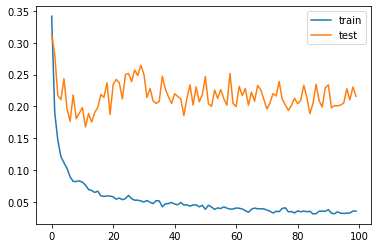

In [25]:
print('epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers')
plt.plot(H.history['loss'],label='train')
plt.plot(H.history['val_loss'],label='test')
plt.legend()
plt.savefig('GOC_loss_function.png')

epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers


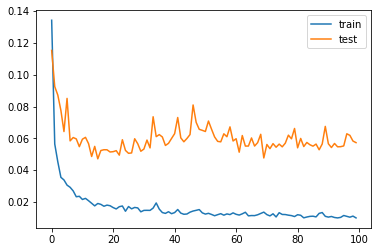

In [26]:
print('epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers')
plt.plot(H_POC.history['loss'],label='train')
plt.plot(H_POC.history['val_loss'],label='test')
plt.legend()
plt.savefig('POC_loss_function.png')

In [27]:
print('epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers')
print(score)

epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers
[0.21800146996974945, 0.21800146996974945]


In [28]:
print('epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers')
print(score_POC)

epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers
[0.05705741047859192, 0.05705741047859192]


In [29]:
print('epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers')
GOC_prediction_train_NN = model.predict(Driver_data_train_PhZMLD)
print('Check train:')
print('RMSE: ',np.sqrt(np.mean((Target_data_train_GOC - GOC_prediction_train_NN[:,0])**2)))
print('Bias:', np.mean(Target_data_train_GOC) - np.mean(GOC_prediction_train_NN[:,0]))
print('Correlation:', scipy.stats.pearsonr(Target_data_train_GOC,GOC_prediction_train_NN[:,0]))
GOC_prediction_eval_NN = model.predict(Driver_data_eval_PhZMLD)
print('Check eval:')
print('RMSE: ',np.sqrt(np.mean((Target_data_eval_GOC - GOC_prediction_eval_NN[:,0])**2)))
print('Bias:', np.mean(Target_data_eval_GOC) - np.mean(GOC_prediction_eval_NN[:,0]))
print('Correlation:', scipy.stats.pearsonr(Target_data_eval_GOC,GOC_prediction_eval_NN[:,0]))
GOC_prediction_NN = model.predict(Driver_data_valid_PhZMLD)
print('Check validation:')
print('RMSE: ',np.sqrt(np.mean((Target_data_valid_GOC - GOC_prediction_NN[:,0])**2)))
print('Bias:', np.mean(Target_data_valid_GOC) - np.mean(GOC_prediction_NN[:,0]))
print('Correlation:', scipy.stats.pearsonr(Target_data_valid_GOC,GOC_prediction_NN[:,0]))
GOC_prediction_IV_NN = model.predict(Driver_data_IV_PhZMLD)
print('Check IV validation:')
print('RMSE: ',np.sqrt(np.mean((Target_data_IV_GOC - GOC_prediction_IV_NN[:,0])**2)))
print('Bias:', np.mean(Target_data_IV_GOC) - np.mean(GOC_prediction_IV_NN[:,0]))
print('Correlation:', scipy.stats.pearsonr(Target_data_IV_GOC,GOC_prediction_IV_NN[:,0]))

epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers
Check train:
RMSE:  0.17608483456058824
Bias: 0.04691981035630576
Correlation: (0.985846195666545, 0.0)
Check eval:
RMSE:  0.4644192537051925
Bias: 0.09346387386975218
Correlation: (0.8896797813411029, 0.0)
Check validation:
RMSE:  0.4669063154728247
Bias: 0.09044755298668629
Correlation: (0.8919331710525812, 0.0)
Check IV validation:
RMSE:  0.7676193129155748
Bias: 0.09187640146330052
Correlation: (0.631113259693163, 0.0)


In [30]:
print('epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers')
POC_prediction_train_NN = model_POC.predict(Driver_data_train_PhZMLD)
print('Check train:')
print('RMSE: ',np.sqrt(np.mean((Target_data_train_POC - POC_prediction_train_NN[:,0])**2)))
print('Bias:', np.mean(Target_data_train_POC) - np.mean(POC_prediction_train_NN[:,0]))
print('Correlation:', scipy.stats.pearsonr(Target_data_train_POC,POC_prediction_train_NN[:,0]))
POC_prediction_eval_NN = model_POC.predict(Driver_data_eval_PhZMLD)
print('Check eval:')
print('RMSE: ',np.sqrt(np.mean((Target_data_eval_POC - POC_prediction_eval_NN[:,0])**2)))
print('Bias:', np.mean(Target_data_eval_POC) - np.mean(POC_prediction_eval_NN[:,0]))
print('Correlation:', scipy.stats.pearsonr(Target_data_eval_POC,POC_prediction_eval_NN[:,0]))
POC_prediction_NN = model_POC.predict(Driver_data_valid_PhZMLD)
print('Check validation:')
print('RMSE: ',np.sqrt(np.mean((Target_data_valid_POC - POC_prediction_NN[:,0])**2)))
print('Bias:', np.mean(Target_data_valid_POC) - np.mean(POC_prediction_NN[:,0]))
print('Correlation:', scipy.stats.pearsonr(Target_data_valid_POC,POC_prediction_NN[:,0]))
POC_prediction_IV_NN = model_POC.predict(Driver_data_IV_PhZMLD)
print('Check IV validation:')
print('RMSE: ',np.sqrt(np.mean((Target_data_IV_POC - POC_prediction_IV_NN[:,0])**2)))
print('Bias:', np.mean(Target_data_IV_POC) - np.mean(POC_prediction_IV_NN[:,0]))
print('Correlation:', scipy.stats.pearsonr(Target_data_IV_POC,POC_prediction_IV_NN[:,0]))

epoch=100, batch=20, Adam: ll=0.01, 1051 parameters - 3 layers
Check train:
RMSE:  0.10573199913896482
Bias: -0.013749649365367309
Correlation: (0.9954741701623593, 0.0)
Check eval:
RMSE:  0.239514862499872
Bias: -0.012698763146396425
Correlation: (0.9722375274219681, 0.0)
Check validation:
RMSE:  0.23886692401407636
Bias: -0.02897901445708643
Correlation: (0.972067137743567, 0.0)
Check IV validation:
RMSE:  0.35922414697796373
Bias: 0.0068334993888594375
Correlation: (0.9208108072686964, 0.0)


In [31]:
GOC_prediction_2009_NN_PhZMLD = model.predict(Driver_data_2009_PhZMLD)

GOC_prediction_2010_NN_PhZMLD = model.predict(Driver_data_2010_PhZMLD)

GOC_prediction_2011_NN_PhZMLD = model.predict(Driver_data_2011_PhZMLD)

GOC_prediction_2012_NN_PhZMLD = model.predict(Driver_data_2012_PhZMLD)

GOC_prediction_2013_NN_PhZMLD = model.predict(Driver_data_2013_PhZMLD)